In [1]:
from tools_stance import * 
import torch 
import pandas as pd

n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('There are',torch.cuda.device_count(),'GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


dict_cl=dict()
dict_cl[0]="support"
dict_cl[1]="denying"
dict_cl[2]="questioning"
dict_cl[3]="commenting"

#sdqc
d_lab=dict()
d_lab["support"]=0
d_lab["denying"]=1
d_lab["questioning"]=2
d_lab["commenting"]=3

path="../Datasets/CSV_Stance/"
train =pd.read_csv(path + "train_semeval_raw.csv")
val=pd.read_csv(path + "dev_semeval_raw.csv")
test=pd.read_csv(path + "test_semeval_raw.csv")

stoplist = stopwords.words("english")
puntos='!?."()[´]“<>¡¿-/;:=_”@#.'

Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1060 6GB


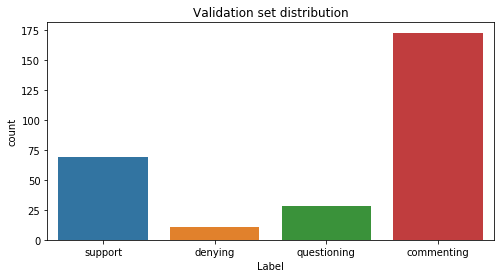

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.countplot(val['Label'], order=['support', 'denying', 'questioning', 'commenting'])
plt.title('Validation set distribution')
plt.show()

In [3]:
def det_samples(df, dict_class, c_weights=None): #None o diccionario de fracciones a aum.
    conteos= Counter(df)
    aumentos= dict()
    maxi= max(conteos.values())
            
    if c_weights is None:        # uniform class weights
        for tipo in conteos:
            actual= conteos[tipo]
            if actual<maxi:
                aumentos[tipo]=int(maxi-actual)
            else:
                aumentos[tipo]=0
        return aumentos   
    else:
        try:
            for clase in c_weights.keys():
                aumentos[clase]=int(c_weights[clase]*conteos[clase])
            for key in conteos.keys():
                if key not in aumentos.keys():
                    aumentos[key]=0
            return aumentos
        except:
            print ("No se ha especificado el diccionario de tasas de aumento de datos (por clase)")
    

In [4]:
def just_tag_word(sentence, tags_all, tag):  #wd en el vocab pues es la palabra que más pesa en el reemplazo
    n_sentence=[]
    indices=[]
    valid=[]
    i=0
    for wd in sentence:
        if wd in puntos or wd[0]=='#':
            i+=1
            continue
        else:
            if (tags_all[i] not in tag) or (wd not in token_2_idx.keys()):
                i+=1
                continue
            else:
                n_sentence.append(wd)
                indices.append(i)
                valid.append(tags_all[i])
            i+=1
    return np.asarray(n_sentence), np.asarray(indices), np.asarray(valid)

def re_generar(texto, tags_all, tag, f):
    sent, indices, tags = just_tag_word(texto, tags_all, tag)
    noise_mask = bernoulli.rvs(f, size=sent.shape)
    bool_list=list(map(bool,noise_mask))
    to_replace=sent[bool_list]
    indix=indices[bool_list]  
    tagx=tags[bool_list] 
    return to_replace , indix, tagx

In [5]:
def find_negative(target, not_sent, window=4):
    cleaned = cleaner(not_sent)[1]
    ide = cleaned.index(target)
    wind_neg=find_window(cleaned, target, ide, window=window)   
    return wind_neg
      
def predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, name_model):
    etiq = etiq.astype("int")
    trainPredict = trained.predict(x_train, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq, trainPredict)  
    f1=f1_score(etiq, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq, trainPredict))
    print ("")
    print ("Accuracy sobre Train", name_model, ":",acc)  
    print ("F1-score None sobre Train", name_model, ":",f1)
    print ("F1-score macro sobre Train", name_model, ":",f1_ma)
    ########################################
    trainPredict = trained.predict(x_val, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq_v, trainPredict)  
    f1=f1_score(etiq_v, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq_v, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq_v, trainPredict))
    print ("")
    print ("Accuracy sobre Val", name_model, ":",acc)  
    print ("F1-score None sobre Val", name_model, ":",f1)
    print ("F1-score macro sobre Val", name_model, ":",f1_ma)
    ########################################
    trainPredict = trained.predict(x_test, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc_t= accuracy_score(etiq_t, trainPredict)  
    f1_t=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma_t=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    matriz_t=normalize(confusion_matrix(etiq_t, trainPredict))
    print ("")
    print ("Accuracy sobre Test", name_model, ":",acc_t)  
    print ("F1-score None sobre Test", name_model, ":",f1_t)
    print ("F1-score macro sobre Test", name_model, ":",f1_ma_t)
    
    return f1_ma_t, f1_t, acc_t, matriz_t

In [6]:
def most_similar_cosmul(space, EMB_matrix, bias, positive=None, negative=None, topn=1 ): #agregar space de vpcab
    if isinstance(topn, int) and topn < 1:
        return []
    if positive is None:
        positive = []
    if negative is None:
        negative = []
    if isinstance(positive, str) and not negative:
        positive = [positive]
  
    ids_pos = [
        token_2_idx[word] if isinstance(word, string_types) else 'Tipo positivo no admitido'
        for word in positive
    ]
    
    positive = [EMB_matrix[idx] for idx in ids_pos]  #space de vocab
    ids_nega= [
        token_2_idx[word] if isinstance(word, string_types) else 'Tipo negativo no admitido'
        for word in negative
    ]
    negative = [EMB_matrix[idx] for idx in ids_nega] #space de vocab

    if not positive:
        raise ValueError("cannot compute similarity with no input")
    
    pos_dists = [((1 + dot(space, term))/2) for term in positive]    
    pos_dists[0]=pos_dists[0] + bias
    neg_dists = [((1 + dot(space, term))/2) for term in negative]
    dists = prod(pos_dists, axis=0) / (prod(neg_dists, axis=0) + 0.000001)
    
    if not topn:
        return dists
    best = matutils.argsort(dists, topn=topn + len(positive + negative), reverse=True)  #ordena en vocab used

    return best, dists[best] #retorna indices y distancias asociadas

def most_similar_cos(space, EMB_matrix, bias, positive=None, negative=None, topn=1 ): 
    if isinstance(topn, int) and topn < 1:
        return []
    if positive is None:
        positive = []
    if negative is None:
        negative = []
    if isinstance(positive, str) and not negative:
        positive = [positive]
  
    ids_pos = [
        token_2_idx[word] if isinstance(word, string_types) else 'Tipo positivo no admitido'
        for word in positive
    ]
    
    positive = [EMB_matrix[idx] for idx in ids_pos]  #space de vocab
    ids_nega= [
        token_2_idx[word] if isinstance(word, string_types) else 'Tipo negativo no admitido'
        for word in negative
    ]
    negative = [EMB_matrix[idx] for idx in ids_nega] #space de vocab

    if not positive:
        raise ValueError("cannot compute similarity with no input")
    
    
    len_all=len(positive + negative)-1 
    pos_dists = []
    i=0
    for term in positive:
        if i==0:
            pos_dists.append(((1 + dot(space, term))/2))
        else:
            pos_dists.append(((1 + dot(space, term))/(2*len_all)))

    neg_dists = []
    i=0
    for term in negative:
        if i==0:
            neg_dists.append(((1 + dot(space, term))/2))
        else:
            neg_dists.append(((1 + dot(space, term))/(2*len_all)))
    
    
    dists = prod(pos_dists, axis=0) / (prod(neg_dists, axis=0) + 0.000001)
    
    if not topn:
        return dists
    best = matutils.argsort(dists, topn=topn + len(positive + negative), reverse=True)  #ordena en vocab used


    return best, dists[best] #retorna indices y distancias asociadas



In [26]:
def aumentar_clase(clase, num_ejem, tags_all, prob, topn=1, BERT=False, pond=False):
    dict_resumen=dict()
    new_sample=[]
    indx=train['Label']==clase
    print ("Consultando por la clase", clase)
    label=d_lab[clase]    
    print ("Entrega label", label)
    contador=1
    
    no_modificados=0
    modificados=0
    terms_modif=0  
    terms_supuestos=0  
    totales=0
    largos=0
    SENT_LEN=0
    #TOPE_LEN=0
    
    if num_ejem>0:
        while (len(new_sample)<num_ejem):
            muestras=train['Tweet'][indx]
            tw_ids=train['Tw_id'][indx]
            for muestra in muestras:  
                if len(new_sample)<num_ejem:
                    #pre=np.asarray(tokenizer_loaded.tokenize(my_cleaner(muestra)[0]))
                    pre=np.asarray(cleaner(muestra)[1]) #fiel a texto original (return pre modificado en indxs)
                    tags_pre= [nltk.pos_tag([wd])[0][-1] for wd in pre]
                    terms, indxs, tagx = re_generar(pre, tags_pre, tags_all, prob)  #terms to replace
                    terms_supuestos+=len(terms)

                    news=[]
                    #TOPE_LEN+=tope_replace
                    SENT_LEN+=len(terms)
                    
                    if len(terms)>0:     
                        
                        for term, ind, tag in list(zip(terms, indxs, tagx)):  
                            if BERT:
                                mask_words = valid & np.asarray(d_posTg[tag])     
                            else:
                                mask_words = np.asarray(d_vocab[clase]) & np.asarray(d_posTg[tag])
                            vocab_used_pos = np.arange(len(mask_words))[mask_words]
                            space= EMB_matrix[mask_words] #espacio BERT de clase y tag solicitado
                            
                            if term!='user' and term!='hashtag' and term!='html':
                                not_clase, used_classes = sample_neg_class(clase) #definir clases a buscar
                                
                                valid_pos=[]
                                pos = find_positive(list(pre), term, ind, bias=1, window=4) #se puede cambiar la ventana! 
                                valid_pos=check_valid(pos, tags_all)

                                id_need = 999999999 #simbolo de que no encontró tweet
                                neg = []
                                while(id_need == 999999999):
                                    try:
                                        id_need = np.random.choice(dic_IdxI[not_clase][term]) #sample id
                                    except:
                                        if len(used_classes) == len(d_lab.keys()): 
                                            break #ya revisó todas las clases
                                        not_clase, used_classes = sample_neg_class(used_classes) # change class 

                                valid_neg=[]
                                if id_need != 999999999: #si encontró tweet
                                    not_sent = train["Tweet"][id_need]
                                    neg = find_negative(term, not_sent, window=4)  
                                    valid_neg=check_valid(neg, tags_all)

                                
                                """Modificar acá posible, obligatorio, positivos"""
                                if len(valid_neg)<1 or len(valid_pos)<1:
                                    continue #obligatorio ambos :)
                                    #pass para solo casos negativos pifeados <1

                                if pond:
                                    best, dists_best = most_similar_cos(space, EMB_matrix, 0.0, positive=valid_pos, negative=valid_neg)
                                else:
                                    best, dists_best = most_similar_cosmul(space, EMB_matrix, 0.0, positive=valid_pos, negative=valid_neg)#, topn=TOPN)
                                

                                todo_words = {
                                    token_2_idx[word] for word in valid_pos + valid_neg
                                    if not isinstance(word, ndarray) and word in token_2_idx
                                    }
                                result = []
                                for sim, dist_sim in list(zip(best, dists_best)):
                                    n_sim = vocab_used_pos[sim]
                                    if n_sim not in todo_words:
                                        result.append((idx_2_token[n_sim], float(dist_sim)))
                                        
                                if len(result)>0:
                                    candidatos = result[:topn] #+2
                                    print ("Original:",term ," \tReemplazo: ", candidatos)
                                else:
                                    continue

                                new = choose_replace(candidatos, ind, term)  
                                news.append(new) 
                                if tag in dict_resumen.keys():
                                    dict_resumen[tag]+=1
                                else:
                                    dict_resumen[tag]=1
                                
                        cambia=False
                        news= Sort_Tuple(news) 
                        
                        if len(news)<1:
                            no_modificados+=1
                            continue
                        else:
                            x=np.asarray(news)[:,1]
                            y=np.asarray(news)[:,0]
                            n_news=np.asarray(np.vstack((x,y))).T

                            nueva_sent=[]
                            cont_new=0
                            for i in range(len(pre)):
                                try:
                                    if int(n_news[cont_new][0])==i:
                                        nueva_sent.append(n_news[cont_new][1])                 
                                        cont_new+=1
                                    else: 
                                        nueva_sent.append(pre[i])
                                except: 
                                    nueva_sent.append(pre[i])
                       
                            totales+=cont_new

                            
                            if contador<200:
                                print ("Sentencia original:")
                                print (pre)
                                print ("Sentencia final:" , label)
                                print (nueva_sent)
                                print ("")
                                print ("")
                            
                            new_sample.append(["Gen_"+str(contador), nueva_sent, label])
                            modificados+=1
                            terms_modif+=len(news)
                            largos+=len(pre)
                            contador+=1
                               

                else:
                    count= Counter(train['Label'])   
                    for muestra, twid in list(zip(muestras,tw_ids)) :
                        pre=np.asarray(cleaner(muestra)[1])
                        new_sample.append([twid, pre, label])
                    break
                    
    else:
        count= Counter(train['Label'])
        news= train[indx].sample(count[clase]+num_ejem)
        news_tw=news['Tweet'].values
        news_id=news['Tw_id'].values
        for muestra, twid in list(zip(news_tw, news_id)):
            pre=np.asarray(cleaner(muestra)[1])  #np.asarray
            new_sample.append([twid, pre, label])

    try:
        print ("# terms modificados promedio", terms_modif/modificados ,"términos por sentencia")
        print ("Largo de sentencia promedio", largos/modificados ,"términos por sentencia")
        print ("para esta ejecución se debiesen reemplazar", SENT_LEN, " de" ,TOPE_LEN, "terminos")

    except: 
        print ("No se generan ejemplos")

    print ("new_sample shpe", np.asarray(new_sample).shape)
    return new_sample, dict_resumen

In [8]:
tokenizer_loaded = BertTokenizer.from_pretrained("bert-base-uncased")
model_loaded = BertForSequenceClassification.from_pretrained("bert-base-uncased",  num_labels=4) 
idx_2_token = tokenizer_loaded.ids_to_tokens
token_2_idx = {value : key for (key, value) in idx_2_token.items()}

import os 
embeddings_index = {}
f = open(os.path.join("../Datasets/glove.twitter.27B.200d.txt"))#'glove.twitter.27B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Se encontraron %s terminos con sus vectores de embedding.' % len(embeddings_index))

In [9]:
def cleaner(post): 
    s= re.sub(r"http\S+", " html ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " hashtag ", s) ########3
    s= re.sub(r'@\w+ ?', " user ", s)##############    
    s= s.lower()
    s=emoji_pattern.sub(r'', s)
    s=re.sub(r"'\b", " ' ", s)
    s=re.sub(r"\b'\b", " ' ", s)
    s=re.sub(r"“\b", " “ ", s)
    s=re.sub(r"\b’", " ’ ", s)
    s=re.sub(r"‘\b", " ‘ ", s)
    s=re.sub(r"\b’\b", " ‘ ", s)
    s = re.sub(r"-", " - ", s)
    s = re.sub(r"\(", " ", s)
    s = re.sub(r"\)", " ", s)
    s = re.sub(r"\?", " ? ", s)    
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"' ", " ' ", s)
    s = re.sub(r" '", " ' ", s)
    s = re.sub(r"\!", " ! ", s)
    s=re.sub("[\.]+", " . ", s)
    s=re.sub("[\,]+", " , ", s)
    s=re.sub("[\;]+", " ; ", s)
    s=re.sub("[\:]+", " : ", s)
    s=re.sub('[\"]+', ' " ', s)
    s=re.sub(r'\b[0-9]\b', " number ",  s)
    s=re.sub(r'\b[0-9]*[0-9]\b', " number ",  s)    
    s=re.sub(r'\b”', ' " ', s)
    sl= list(s.split())
    sl_2=[]
    for wd in sl:
        try: 
            q=token_2_idx[wd]
            sl_2.append(wd)
        except:
            try: 
                if stemmer.stem(wd) in token_2_idx.keys():
                    sl_2.append(stemmer.stem(wd))
                elif lemmatizer.lemmatize(wd) in token_2_idx.keys():
                    sl_2.append(lemmatizer.lemmatize(wd))
                else:
                    sl_2.append(wd)
            except:
                sl_2.append(wd)
    sl=sl_2
    s=' '.join([word for word in sl])# if word not in stoplist])
    return s, sl

In [10]:
keys=["commenting", "support", "denying", "questioning"]

dict_clases={}
for key in keys: 
    tr_k=train.loc[train["Label"]==key]
    tr_k=tr_k["Tweet"].values    
    trs_k=[]
    for tw in tr_k:
        #tokenizer_loaded.tokenize(cleaner(tw)[0]))
        cleaned = cleaner(tw)[1]
        trs_k+=cleaned
        #print ("Result tokenizer: ", encoded_sent)
    dict_clases[key]=trs_k  

In [11]:
vocabulary={}
for key in keys: 
    temp=list(set(dict_clases[key]))
    print ("#Tweets",key,":",len(temp))
    vocabulary[key]=temp

#Tweets commenting : 4806
#Tweets support : 2089
#Tweets denying : 1397
#Tweets questioning : 1165


In [12]:
dic_IdxI = {value: {} for value in d_lab.keys()}
for i, (muestra, label) in enumerate(list(zip(train["Tweet"],train["Label"]))):
    pre=np.asarray(cleaner(muestra)[1])
    for token in pre:
        if token not in dic_IdxI[label]:
            dic_IdxI[label][token] = [i]
        else:
            dic_IdxI[label][token].append(i)

In [13]:
def check_vocab(token, clase):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or  token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        if token in vocabulary[clase]:
            return True
        else: 
            return False
        
        
def check_tag(token, tag):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        if nltk.pos_tag([token])[0][-1]==tag and token in token_2_idx.keys():
            return True
        else: 
            return False
            
def check_valid(lista, tags):
    keep=[]
    lista_tag= [nltk.pos_tag([wd])[0][-1] for wd in lista] 
    for tag, word in list(zip(lista_tag , lista)):
        if tag in tags and word in token_2_idx.keys():
            keep.append(word)
    return keep

In [14]:
tags=['NN','NNS', 'JJ', 'JJR', 'JJS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
clases=['support', 'denying', 'questioning', 'commenting']
MAX_LEN = 50

d_posTg= dict()
for tag in tags:
    d_posTg[tag]= [check_tag(k, tag) for k in idx_2_token.values()]
    
d_vocab=dict()
for clase in clases:
    d_vocab[clase]= [check_vocab(k, clase) for k in idx_2_token.values()]
    

In [15]:
data_2_idx=dict()

corpus=[]
not_found=[]
found=[]
pos_tag_nf=[]
pos_tag=[]
    
for vocab_clase in vocabulary.keys():
    corpus+=vocabulary[vocab_clase]

corpus=list(set(corpus))
for term in corpus:
    try:
        if term not in data_2_idx.keys():
            found.append(term)
            pos_tag.append(nltk.pos_tag([term])[0][-1])
            data_2_idx[term]=token_2_idx[term]
    except:
        not_found.append(term)
        pos_tag_nf.append(nltk.pos_tag([term])[0][-1])
        continue

In [16]:
original=len(set(corpus))
matched=len(data_2_idx.keys())
print ("Se distinguen", original, "términos en el dataset. Reconociendo a", matched, "de estos (%.2f" % (matched/original) + "%)")
print ("\nExisten", len(not_found), "términos no encontrados:")
for term in not_found[:20]:
    print ("-",term)

Se distinguen 5846 términos en el dataset. Reconociendo a 4466 de estos (0.76%)

Existen 1380 términos no encontrados:
- cowardice
- freekill
- pix
- sydneysiders
- 230km
- avenged
- *you*
- horrifying
- wolinski
- yamiche
- spineless
- heist
- nicer
- blks
- copycats
- +hasn
- banksy
- gendarmes
- sll
- shoplifting


In [17]:
print ("Distribución en POS tag entre términos encontrados:\n",  Counter(pos_tag))
print ("\nDistribución en POS tag entre términos NO encontrados:\n",  Counter(pos_tag_nf))

Distribución en POS tag entre términos encontrados:
 Counter({'NN': 3449, 'NNS': 772, 'JJ': 383, 'VBN': 352, 'VBG': 330, 'RB': 230, 'VBD': 65, 'IN': 55, 'VB': 48, 'CD': 45, 'VBZ': 20, 'DT': 16, 'PRP': 15, 'JJS': 10, 'MD': 9, 'JJR': 8, 'PRP$': 7, 'CC': 5, 'WRB': 4, 'RBR': 4, ':': 3, '.': 3, 'WP': 3, 'VBP': 2, 'WDT': 2, '$': 1, "''": 1, '#': 1, 'TO': 1, ',': 1, 'WP$': 1})

Distribución en POS tag entre términos NO encontrados:
 Counter({'NN': 1001, 'NNS': 144, 'VBG': 66, 'JJ': 59, 'VBN': 44, 'CD': 30, 'RB': 27, 'VB': 4, 'VBD': 3, 'JJS': 1, 'IN': 1})


#### POS tags 

- JJ adjective 'big'
- JJR adjective, comparative 'bigger'
- JJS adjective, superlative 'biggest'

- NN noun, singular 'desk'
- NNS noun plural 'desks'
- NNP proper noun, singular 'Harrison'
- NNPS proper noun, plural 'Americans'

- RB adverb very, silently,   (no considerado) 
- RBR adverb, comparative better  (no considerado)
- RBS adverb, superlative best  (no considerado)

- VB verb, base form take    
- VBD verb, past tense took
- VBG verb, gerund/present participle taking
- VBN verb, past participle taken
- VBP verb, sing. present, non-3d take
- VBZ verb, 3rd person sing. present takes



In [18]:
EMB_matrix= model_loaded.bert.embeddings.word_embeddings.weight.detach().cpu().numpy()
transformer = Normalizer().fit(EMB_matrix) 
EMB_matrix=transformer.transform(EMB_matrix)
EMB_matrix.shape

(30522, 768)

In [19]:
def valid_token(token):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        exceptions=['[CLS]', '[SEP]', '[MASK]', '[PAD]']
        if token not in exceptions:       
            return True
        else: 
            return False
        
valid=np.asarray([valid_token(k) for k in idx_2_token.values()])


## Análisis de espacio embedding

max len: 37


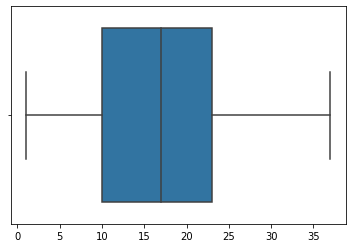

In [20]:
lens=[]
for tweet in train["Tweet"].values:
    tw=cleaner(tweet)[1]
    lens.append(len(tw))

print ("max len:", max(lens))
sns.boxplot(lens)

In [21]:
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE 

import numpy as np 
import pandas as pd
from collections import Counter 
from bert_serving.client import BertClient

bc = BertClient()  

data_bas=[]
for tweet in train["Tweet"].values:
    h=cleaner(tweet)[0]
    vector=bc.encode([h])[0]
    data_bas.append(vector)

In [3]:
model = TSNE(2, metric='cosine')
to_plot_tsne = model.fit_transform(data_bas)    
plt.figure(figsize=(10,7))
for key in keys:
    mask = train["Label"]==key
    plt.scatter(to_plot_tsne[:,0][mask],to_plot_tsne[:,1][mask], s=12, label=str(key))

plt.legend()
plt.title("Dataset RumourEval task A - Sin aumento de datos ")
plt.show()

NameError: name 'data_bas' is not defined

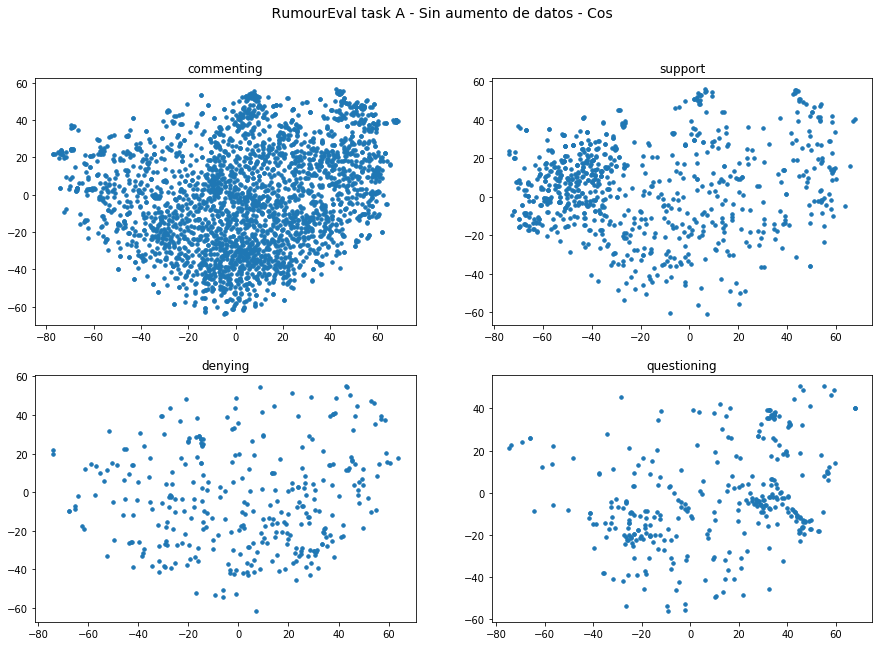

In [23]:
fig = plt.figure(figsize=(15,10))
j=220
for key in keys:
    mask = train["Label"]==key
    j+=1
    h=fig.add_subplot(j)
    plt.scatter(to_plot_tsne[:,0][mask],to_plot_tsne[:,1][mask], s=12, label=str(key))
    h.title.set_text(str(key))

fig.suptitle(" RumourEval task A - Sin aumento de datos - Cos", fontsize=14)
plt.show()


# Generación Varias

In [27]:
prob= 0.15
topn = 1

aum_weight=det_samples(train['Label'], dict_cl)#, c_weights={"support":1, "questioning":2, "denying":2})
print ("--------------------------------------------------------")
print ("\nGenerando ejemplos en base a probabilidad --> ", prob)
print ("--------------------------------------------------------") 
print (aum_weight)

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.15
--------------------------------------------------------
{'questioning': 2404, 'commenting': 0, 'support': 1893, 'denying': 2401}


### Sujeto a clase no ponderando target

In [28]:
macro_augmented=[]
for clase in aum_weight:
    start_time=time.time()
    print ("\n\nGenerando", aum_weight[clase], "ejemplos para", clase)
    muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob)
    macro_augmented+=muestras
    print ("Resumen de modificaciones:", dict_aumentos)
    elapsed_time= time.time() - start_time
    print ("Este proceso tomó", elapsed_time, "seg")   



Generando 2404 ejemplos para questioning
Consultando por la clase questioning
Entrega label 2
Original: hostage  	Reemplazo:  [('understand', 2.008267879486084)]
Sentencia original:
['user' 'user' 'if' 'so' 'that' 'hostage' 'will' 'be' 'the' 'person'
 'best' 'able' 'to' 'give' 'an' 'insight' 'into' 'the' 'attack' ',' 'if'
 'the' 'suspects' 'were' 'responsible' '.']
Sentencia final: 2
['user', 'user', 'if', 'so', 'that', 'understand', 'will', 'be', 'the', 'person', 'best', 'able', 'to', 'give', 'an', 'insight', 'into', 'the', 'attack', ',', 'if', 'the', 'suspects', 'were', 'responsible', '.']


Original: giving  	Reemplazo:  [('causing', 1.386574387550354)]
Sentencia original:
['user' 'i' 'thought' 'police' 'asked' 'media' 'not' 'to' 'report'
 'demands' '.' 'why' 'you' 'giving' 'these' 'terrorists' 'a' 'voice' '?']
Sentencia final: 2
['user', 'i', 'thought', 'police', 'asked', 'media', 'not', 'to', 'report', 'demands', '.', 'why', 'you', 'causing', 'these', 'terrorists', 'a', 'voice',

Original: was  	Reemplazo:  [('were', 0.7786705493927002)]
Sentencia original:
['user' 'user' 'ironic' 'since' 'all' 'the' 'i' 'witnesses' 'say' 'the'
 'officer' 'was' 'white' '.' 'now' 'it' 'is' 'the' 'black' 'officer'
 'darren' 'wilson' 'who' 'shot' '?' '?']
Sentencia final: 2
['user', 'user', 'ironic', 'since', 'all', 'the', 'i', 'witnesses', 'say', 'the', 'officer', 'were', 'white', '.', 'now', 'it', 'is', 'the', 'black', 'officer', 'darren', 'wilson', 'who', 'shot', '?', '?']


Original: wait  	Reemplazo:  [('manipulate', 0.779871940612793)]
Sentencia original:
['user' 'wait' '.' 'what' '?' '?' '?' '!' '!' '!']
Sentencia final: 2
['user', 'manipulate', '.', 'what', '?', '?', '?', '!', '!', '!']


Original: was  	Reemplazo:  [('were', 1.4262511730194092)]
Sentencia original:
['user' 'did' 'the' 'media' 'ask' 'for' 'the' 'video' 'under' 'foia' 'as'
 'the' 'chief' 'of' 'police' 'said' '?' 'and' 'why' 'was' 'video'
 'released' 'without' 'commentary' 'in' 'am' '?']
Sentencia final: 2
[

Original: t  	Reemplazo:  [('don', 0.7222258448600769)]
Original: done  	Reemplazo:  [('made', 0.7403907179832458)]
Sentencia original:
['if' 'michael' 'zehaf' '-' 'bebeau' 'had' 'his' 'passport' 'confiscated'
 'doesn' "'" 't' 'it' 'make' 'sense' 'to' 'track' 'his' 'movements' '-'
 'was' 'this' 'done' '?' 'user' 'user']
Sentencia final: 2
['if', 'michael', 'zehaf', '-', 'bebeau', 'had', 'his', 'passport', 'confiscated', 'doesn', "'", 'don', 'it', 'make', 'sense', 'to', 'track', 'his', 'movements', '-', 'was', 'this', 'made', '?', 'user', 'user']


Original: be  	Reemplazo:  [('go', 0.6621676087379456)]
Sentencia original:
['user' 'user' 'user' 'user' 'i' "'" 'm' 'not' 'arguing' 'that' 'he'
 'deserved' 'to' 'be' 'shot' '.']
Sentencia final: 2
['user', 'user', 'user', 'user', 'i', "'", 'm', 'not', 'arguing', 'that', 'he', 'deserved', 'to', 'go', 'shot', '.']


Original: fact  	Reemplazo:  [('prefer', 1.2748099565505981)]
Sentencia original:
['user' 'rather' 'than' 'being' 'a' "'" 'lone' 

Original: siege  	Reemplazo:  [('isil', 0.6397674679756165)]
Sentencia original:
['“' 'user' ':' 'uber' 'intro' 'surge' 'pricing' 'in' 'downtown' 'sydney'
 'during' 'hostage' 'siege' 'html' 'html' 'just' 'not' 'right']
Sentencia final: 2
['“', 'user', ':', 'uber', 'intro', 'surge', 'pricing', 'in', 'downtown', 'sydney', 'during', 'hostage', 'isil', 'html', 'html', 'just', 'not', 'right']


Original: lots  	Reemplazo:  [('inquiries', 0.31157049536705017)]
Sentencia original:
['user' 'user' 'user' 'yes' 'lots' 'of' 'mixed' 'info' 'coming' 'out' '.'
 'anyone' 'else' 'here' 'about' 'potential' 'number' 'prison' 'connection'
 'btwn' 'planners' '?']
Sentencia final: 2
['user', 'user', 'user', 'yes', 'inquiries', 'of', 'mixed', 'info', 'coming', 'out', '.', 'anyone', 'else', 'here', 'about', 'potential', 'number', 'prison', 'connection', 'btwn', 'planners', '?']


Original: criminal  	Reemplazo:  [('investigative', 0.540879487991333)]
Original: write  	Reemplazo:  [('story', 0.855376005172729

Original: don  	Reemplazo:  [('hand', 0.7899537086486816)]
Sentencia original:
['user' 'was' 'he' 'saying' '"' 'hands' 'up' 'don' "'" 't' 'shoot' '"' '?'
 'police' 'overreaction' '?' 'people' 'are' 'glad' 'the' 'police' 'are'
 'there' 'when' 'they' 'are' 'in' 'trouble' '.']
Sentencia final: 2
['user', 'was', 'he', 'saying', '"', 'hands', 'up', 'hand', "'", 't', 'shoot', '"', '?', 'police', 'overreaction', '?', 'people', 'are', 'glad', 'the', 'police', 'are', 'there', 'when', 'they', 'are', 'in', 'trouble', '.']


Original: number  	Reemplazo:  [('name', 0.6833027005195618)]
Original: number  	Reemplazo:  [('night', 0.6744275093078613)]
Sentencia original:
['user' 'and' ',' '.' '?' 'when' 'user' 'asked' 'live' 'nation' 'why' 'no'
 'one' 'made' 'this' 'clarification' 'number' 'or' 'number' 'hours'
 'earlier' '?']
Sentencia final: 2
['user', 'and', ',', '.', '?', 'when', 'user', 'asked', 'live', 'nation', 'why', 'no', 'one', 'made', 'this', 'clarification', 'name', 'or', 'night', 'hours',

Original: were  	Reemplazo:  [('came', 1.0482428073883057)]
Sentencia original:
['user' 'user' 'how' 'were' 'the' 'police' 'so' 'quick' 'to' 'indicate'
 'mike' 'brown' 'if' 'all' 'of' 'this' 'took' 'place' 'in' 'a' 'matter'
 'of' 'minutes' '?']
Sentencia final: 2
['user', 'user', 'how', 'came', 'the', 'police', 'so', 'quick', 'to', 'indicate', 'mike', 'brown', 'if', 'all', 'of', 'this', 'took', 'place', 'in', 'a', 'matter', 'of', 'minutes', '?']


Original: don  	Reemplazo:  [('thought', 0.7644128203392029)]
Original: need  	Reemplazo:  [('want', 1.217423439025879)]
Sentencia original:
['user' 'i' 'think' 'we' 'don' "'" 't' 'have' 'enough' 'facts' 'about'
 'the' 'big' 'picture' 'right' 'now' 'aqap' 'isis' 'etc' ',' 'we' "'" 'll'
 'need' 'to' 'wait' 'and' 'see' 'user']
Sentencia final: 2
['user', 'i', 'think', 'we', 'thought', "'", 't', 'have', 'enough', 'facts', 'about', 'the', 'big', 'picture', 'right', 'now', 'aqap', 'isis', 'etc', ',', 'we', "'", 'll', 'want', 'to', 'wait', 'and', '

Original: seen  	Reemplazo:  [('been', 0.7567952871322632)]
Original: doing  	Reemplazo:  [('being', 0.8033747673034668)]
Original: t  	Reemplazo:  [('abc', 0.41993001103401184)]
Original: tell  	Reemplazo:  [('cbs', 0.8008266091346741)]
Original: black  	Reemplazo:  [('unarmed', 0.6628261208534241)]
Original: wait  	Reemplazo:  [('rider', 1.2212347984313965)]
Original: know  	Reemplazo:  [('believe', 0.8292498588562012)]
Original: person  	Reemplazo:  [('understand', 0.8208747506141663)]
Original: gun  	Reemplazo:  [('hat', 0.6900395154953003)]
Original: manager  	Reemplazo:  [('owner', 0.7212822437286377)]
Original: decided  	Reemplazo:  [('avoided', 0.7085505127906799)]
Original: brown  	Reemplazo:  [('found', 1.3081915378570557)]
Original: unarmed  	Reemplazo:  [('sarcastic', 0.5966590046882629)]
Original: robbed  	Reemplazo:  [('robber', 1.4160300493240356)]
Original: get  	Reemplazo:  [('go', 0.6863004565238953)]
Original: are  	Reemplazo:  [('am', 0.6779805421829224)]
Original: 

Original: nothing  	Reemplazo:  [('anything', 1.3464772701263428)]
Original: s  	Reemplazo:  [('attacker', 0.7144789099693298)]
Original: guy  	Reemplazo:  [('dude', 0.5047470331192017)]
Original: is  	Reemplazo:  [('has', 0.4574170410633087)]
Original: do  	Reemplazo:  [('have', 0.8056116700172424)]
Original: number  	Reemplazo:  [('lot', 0.49732479453086853)]
Original: means  	Reemplazo:  [('gunmen', 0.8336729407310486)]
Original: t  	Reemplazo:  [('michael', 0.5144396424293518)]
Original: mike  	Reemplazo:  [('stupidity', 0.531603991985321)]
Original: reporting  	Reemplazo:  [('reporter', 0.48543301224708557)]
Original: is  	Reemplazo:  [('has', 2.0744805335998535)]
Original: number  	Reemplazo:  [('confirm', 0.5871545672416687)]
Original: anything  	Reemplazo:  [('something', 1.3965450525283813)]
Original: doesn  	Reemplazo:  [('didn', 1.4221800565719604)]
Original: t  	Reemplazo:  [('didn', 0.8344299793243408)]
Original: are  	Reemplazo:  [('am', 0.43398308753967285)]
Original: co

Original: speak  	Reemplazo:  [('attack', 0.7698858976364136)]
Original: does  	Reemplazo:  [('says', 0.5598716735839844)]
Original: looking  	Reemplazo:  [('talking', 0.8092463612556458)]
Original: been  	Reemplazo:  [('commented', 1.1876347064971924)]
Original: journalism  	Reemplazo:  [('excellent', 0.8915009498596191)]
Original: is  	Reemplazo:  [('has', 1.2113544940948486)]
Original: level  	Reemplazo:  [('justification', 0.48228684067726135)]
Original: obama  	Reemplazo:  [('muslim', 0.5765402317047119)]
Original: america  	Reemplazo:  [('understand', 0.8117716312408447)]
Original: remember  	Reemplazo:  [('believe', 2.3573973178863525)]
Original: is  	Reemplazo:  [('has', 1.2997829914093018)]
Original: was  	Reemplazo:  [('were', 0.4928344190120697)]
Original: isn  	Reemplazo:  [('wasn', 1.3864495754241943)]
Original: heard  	Reemplazo:  [('hear', 1.4017565250396729)]
Original: friend  	Reemplazo:  [('girlfriend', 0.48840048909187317)]
Original: shot  	Reemplazo:  [('shoot', 2.2

Original: stupid  	Reemplazo:  [('many', 1.942111849784851)]
Original: think  	Reemplazo:  [('blackout', 0.30472972989082336)]
Original: don  	Reemplazo:  [('didn', 0.8521763682365417)]
Original: t  	Reemplazo:  [('need', 1.3175712823867798)]
Original: need  	Reemplazo:  [('want', 0.8389579653739929)]
Original: great  	Reemplazo:  [('good', 0.46533235907554626)]
Original: cheers  	Reemplazo:  [('words', 3.004551887512207)]
Original: problem  	Reemplazo:  [('home', 0.696682870388031)]
Original: make  	Reemplazo:  [('be', 1.261026382446289)]
Original: hi  	Reemplazo:  [('clarify', 0.5206297636032104)]
Original: responsible  	Reemplazo:  [('sarcastic', 0.5174232125282288)]
Original: updates  	Reemplazo:  [('thoughts', 1.2218742370605469)]
Original: home  	Reemplazo:  [('family', 0.6805652976036072)]
Original: time  	Reemplazo:  [('coroner', 0.46249672770500183)]
Original: shut  	Reemplazo:  [('remain', 0.7636404633522034)]
Original: shows  	Reemplazo:  [('darren', 0.8382208943367004)]
Ori

Original: does  	Reemplazo:  [('says', 0.8091649413108826)]
Original: county  	Reemplazo:  [('state', 1.183639407157898)]
Original: crisis  	Reemplazo:  [('confrontation', 0.7516514658927917)]
Original: same  	Reemplazo:  [('whole', 1.9705065488815308)]
Original: robbery  	Reemplazo:  [('supermarket', 0.8178680539131165)]
Original: wearing  	Reemplazo:  [('carrying', 1.1618856191635132)]
Original: new  	Reemplazo:  [('questionable', 0.3079310357570648)]
Original: do  	Reemplazo:  [('remove', 0.4568721055984497)]
Original: are  	Reemplazo:  [('am', 1.1921228170394897)]
Original: do  	Reemplazo:  [('have', 0.504341185092926)]
Original: was  	Reemplazo:  [('came', 0.282768189907074)]
Original: job  	Reemplazo:  [('laugh', 0.7817179560661316)]
Original: t  	Reemplazo:  [('saw', 0.7299713492393494)]
Original: see  	Reemplazo:  [('know', 0.452013224363327)]
Original: paying  	Reemplazo:  [('protesting', 0.5049170255661011)]
Original: does  	Reemplazo:  [('says', 0.45932525396347046)]
Origina

Original: charlie  	Reemplazo:  [('suspect', 0.7787750363349915)]
Original: news  	Reemplazo:  [('wat', 0.2014222890138626)]
Original: opinion  	Reemplazo:  [('gonna', 2.2830007076263428)]
Original: dad  	Reemplazo:  [('attacker', 1.8914923667907715)]
Original: wise  	Reemplazo:  [('epstein', 0.5703285932540894)]
Original: did  	Reemplazo:  [('were', 1.536688208580017)]
Original: way  	Reemplazo:  [('right', 0.7240051627159119)]
Original: hat  	Reemplazo:  [('ironic', 0.704432487487793)]
Original: is  	Reemplazo:  [('has', 1.1608753204345703)]
Original: wearing  	Reemplazo:  [('using', 1.8983087539672852)]
Original: was  	Reemplazo:  [('were', 0.8720805048942566)]
Original: release  	Reemplazo:  [('reporting', 0.5176898241043091)]
Original: people  	Reemplazo:  [('blacks', 0.5033038258552551)]
Original: care  	Reemplazo:  [('responsibility', 1.1289950609207153)]
Original: don  	Reemplazo:  [('terrorist', 0.43078508973121643)]
Original: uber  	Reemplazo:  [('rate', 1.0096620321273804)]


Original: d  	Reemplazo:  [('ll', 2.4056859016418457)]
Original: weeks  	Reemplazo:  [('rumours', 0.4907207787036896)]
Original: relay  	Reemplazo:  [('time', 0.6817232370376587)]
Original: indicate  	Reemplazo:  [('manipulate', 0.9122647047042847)]
Original: police  	Reemplazo:  [('cops', 0.4843835234642029)]
Original: get  	Reemplazo:  [('be', 0.8562613725662231)]
Original: sidewalk  	Reemplazo:  [('retribution', 0.6716501116752625)]
Original: …  	Reemplazo:  [('manipulate', 0.9504579901695251)]
Original: t  	Reemplazo:  [('isn', 1.2680919170379639)]
Original: witness  	Reemplazo:  [('remain', 0.7541282176971436)]
Original: terrorist  	Reemplazo:  [('want', 0.8929460048675537)]
Original: report  	Reemplazo:  [('time', 5.038825035095215)]
Original: french  	Reemplazo:  [('black', 2.030393362045288)]
Original: reporting  	Reemplazo:  [('gonna', 1.5342038869857788)]
Original: wait  	Reemplazo:  [('man', 0.46998289227485657)]
Original: blocked  	Reemplazo:  [('filled', 0.6976533532142639

Original: convenient  	Reemplazo:  [('supermarket', 0.47715017199516296)]
Original: t  	Reemplazo:  [('nothing', 1.2231686115264893)]
Original: is  	Reemplazo:  [('has', 0.44213125109672546)]
Original: messenger  	Reemplazo:  [('message', 1.1975767612457275)]
Original: please  	Reemplazo:  [('didn', 1.9538434743881226)]
Original: number  	Reemplazo:  [('hostage', 0.6232791543006897)]
Original: —  	Reemplazo:  [('stupidity', 0.7929880023002625)]
Original: updates  	Reemplazo:  [('attackers', 0.7812358140945435)]
Original: intro  	Reemplazo:  [('divert', 0.7531936168670654)]
Original: sydney  	Reemplazo:  [('terrorist', 0.5378714799880981)]
Original: siege  	Reemplazo:  [('isil', 0.6397674679756165)]
Original: coming  	Reemplazo:  [('bringing', 0.523024320602417)]
Original: right  	Reemplazo:  [('correct', 1.2493383884429932)]
Original: t  	Reemplazo:  [('didn', 0.4977140426635742)]
Original: shot  	Reemplazo:  [('shooter', 0.7783416509628296)]
Original: does  	Reemplazo:  [('says', 1.20

Original: seems  	Reemplazo:  [('appears', 0.6045907735824585)]
Original: d  	Reemplazo:  [('ve', 0.5287041664123535)]
Original: brown  	Reemplazo:  [('robber', 1.3465224504470825)]
Original: were  	Reemplazo:  [('was', 0.8421837091445923)]
Original: madness  	Reemplazo:  [('stupidity', 0.34645766019821167)]
Original: causing  	Reemplazo:  [('using', 1.116254448890686)]
Original: hope  	Reemplazo:  [('chance', 2.1441192626953125)]
Original: listening  	Reemplazo:  [('referring', 0.7527139782905579)]
Original: said  	Reemplazo:  [('did', 0.8697917461395264)]
Original: don  	Reemplazo:  [('didn', 1.3516614437103271)]
Original: drivers  	Reemplazo:  [('rumours', 0.7766740918159485)]
Original: is  	Reemplazo:  [('gets', 0.851249098777771)]
Original: robber  	Reemplazo:  [('confirm', 1.6218235492706299)]
Original: shooting  	Reemplazo:  [('holding', 1.8770160675048828)]
Original: ok  	Reemplazo:  [('right', 1.9823800325393677)]
Original: source  	Reemplazo:  [('owner', 0.7694726586341858)]


Original: read  	Reemplazo:  [('write', 0.7225133776664734)]
Original: flag  	Reemplazo:  [('isil', 0.8525146245956421)]
Original: talking  	Reemplazo:  [('fucking', 1.3577195405960083)]
Original: be  	Reemplazo:  [('go', 0.779495894908905)]
Original: god  	Reemplazo:  [('man', 1.4310988187789917)]
Original: god  	Reemplazo:  [('man', 1.1721718311309814)]
Original: number  	Reemplazo:  [('hostage', 0.5475325584411621)]
Original: downtown  	Reemplazo:  [('sidewalk', 0.7516506314277649)]
Original: sydney  	Reemplazo:  [('terrorist', 0.6285737156867981)]
Original: trial  	Reemplazo:  [('prosecution', 1.139391541481018)]
Original: provide  	Reemplazo:  [('found', 1.8130675554275513)]
Original: did  	Reemplazo:  [('happened', 0.733113169670105)]
Original: appears  	Reemplazo:  [('seems', 0.8586485981941223)]
Original: wow  	Reemplazo:  [('yep', 1.1101007461547852)]
Original: is  	Reemplazo:  [('has', 0.7569852471351624)]
Original: does  	Reemplazo:  [('says', 0.805770754814148)]
Original: s

Original: isis  	Reemplazo:  [('isil', 0.5306169986724854)]
Original: happening  	Reemplazo:  [('terrifying', 0.3396652936935425)]
Original: please  	Reemplazo:  [('gonna', 1.1427160501480103)]
Original: d  	Reemplazo:  [('ve', 0.5154696106910706)]
Original: correct  	Reemplazo:  [('tomorrow', 0.48800963163375854)]
Original: police  	Reemplazo:  [('people', 1.1025234460830688)]
Original: thank  	Reemplazo:  [('manipulate', 0.3726009130477905)]
Original: peaceful  	Reemplazo:  [('end', 1.3278326988220215)]
Original: don  	Reemplazo:  [('didn', 1.1769838333129883)]
Original: be  	Reemplazo:  [('have', 1.1409952640533447)]
Original: hit  	Reemplazo:  [('shot', 1.1059553623199463)]
Original: s  	Reemplazo:  [('ironic', 0.7794374227523804)]
Original: shooting  	Reemplazo:  [('throwing', 2.0358643531799316)]
Original: unarmed  	Reemplazo:  [('sarcastic', 0.8169472813606262)]
Original: correct  	Reemplazo:  [('right', 1.2065637111663818)]
Original: terrorism  	Reemplazo:  [('station', 0.70860

Original: world  	Reemplazo:  [('ve', 0.7876201868057251)]
Original: carrying  	Reemplazo:  [('holding', 0.8011611104011536)]
Original: rifle  	Reemplazo:  [('retribution', 0.6077268123626709)]
Original: min  	Reemplazo:  [('don', 1.1822640895843506)]
Original: watch  	Reemplazo:  [('number', 0.41556382179260254)]
Original: drivers  	Reemplazo:  [('accounts', 1.1080923080444336)]
Original: police  	Reemplazo:  [('cops', 2.034329652786255)]
Original: sense  	Reemplazo:  [('feel', 0.46712031960487366)]
Original: do  	Reemplazo:  [('have', 1.1576768159866333)]
Original: number  	Reemplazo:  [('reporter', 0.491877943277359)]
Original: t  	Reemplazo:  [('gonna', 1.2607529163360596)]
Original: referring  	Reemplazo:  [('airing', 1.0779635906219482)]
Original: live  	Reemplazo:  [('new', 0.6811832785606384)]
Original: please  	Reemplazo:  [('divert', 0.3913402259349823)]
Original: stop  	Reemplazo:  [('divert', 0.40134134888648987)]
Original: showing  	Reemplazo:  [('encouraging', 0.541547298

Original: be  	Reemplazo:  [('do', 0.8689080476760864)]
Original: bbc  	Reemplazo:  [('ask', 0.6949636340141296)]
Original: wait  	Reemplazo:  [('stay', 0.7175173163414001)]
Original: did  	Reemplazo:  [('happened', 1.8483524322509766)]
Original: media  	Reemplazo:  [('people', 0.6524196863174438)]
Original: video  	Reemplazo:  [('time', 3.251882791519165)]
Original: russia  	Reemplazo:  [('shouldn', 5.646311283111572)]
Original: i  	Reemplazo:  [('time', 1.2388453483581543)]
Original: do  	Reemplazo:  [('say', 0.8407368659973145)]
Original: true  	Reemplazo:  [('real', 1.2268576622009277)]
Original: names  	Reemplazo:  [('signatures', 0.698071300983429)]
Original: release  	Reemplazo:  [('print', 0.7676469087600708)]
Original: air  	Reemplazo:  [('thought', 0.6994224190711975)]
Original: have  	Reemplazo:  [('be', 1.1054021120071411)]
Original: was  	Reemplazo:  [('were', 0.7078635096549988)]
Original: call  	Reemplazo:  [('use', 0.535106360912323)]
Original: past  	Reemplazo:  [('cop

Original: trouble  	Reemplazo:  [('re', 1.0858815908432007)]
Original: live  	Reemplazo:  [('unarmed', 0.413901686668396)]
Original: nation  	Reemplazo:  [('ask', 0.5305016040802002)]
Original: such  	Reemplazo:  [('other', 0.6706215739250183)]
Original: world  	Reemplazo:  [('life', 1.1930806636810303)]
Original: most  	Reemplazo:  [('worst', 0.6757852435112)]
Original: statement  	Reemplazo:  [('splitting', 0.4817328453063965)]
Original: department  	Reemplazo:  [('niece', 0.5715963840484619)]
Original: is  	Reemplazo:  [('has', 0.2773245573043823)]
Original: moderate  	Reemplazo:  [('accuse', 1.240860104560852)]
Original: mean  	Reemplazo:  [('doesn', 1.3108782768249512)]
Original: enjoy  	Reemplazo:  [('remain', 1.088412880897522)]
Original: is  	Reemplazo:  [('has', 1.9761054515838623)]
Original: makes  	Reemplazo:  [('gives', 0.8638845086097717)]
Original: wait  	Reemplazo:  [('man', 0.46998289227485657)]
Original: time  	Reemplazo:  [('stay', 0.6952246427536011)]
Original: sydne

Original: don  	Reemplazo:  [('terrorist', 0.5659816861152649)]
Original: have  	Reemplazo:  [('do', 2.0174522399902344)]
Original: matter  	Reemplazo:  [('man', 1.0945165157318115)]
Original: true  	Reemplazo:  [('real', 0.7034325003623962)]
Original: struggle  	Reemplazo:  [('confrontation', 0.7598536014556885)]
Original: is  	Reemplazo:  [('has', 1.2466658353805542)]
Original: bigger  	Reemplazo:  [('higher', 1.206125259399414)]
Original: pic  	Reemplazo:  [('robbed', 1.3727399110794067)]
Original: photos  	Reemplazo:  [('pictures', 0.7912812829017639)]
Original: released  	Reemplazo:  [('confiscated', 0.8601962327957153)]
Original: breaking  	Reemplazo:  [('announcing', 0.713806688785553)]
Original: conference  	Reemplazo:  [('splitting', 0.4648303687572479)]
Original: running  	Reemplazo:  [('going', 1.1487394571304321)]
Original: been  	Reemplazo:  [('known', 1.1394773721694946)]
Original: t  	Reemplazo:  [('home', 2.1584835052490234)]
Original: account  	Reemplazo:  [('explanati

Original: t  	Reemplazo:  [('journalism', 0.8820252418518066)]
Original: start  	Reemplazo:  [('launch', 1.886811375617981)]
Original: wait  	Reemplazo:  [('man', 0.46998289227485657)]
Original: won  	Reemplazo:  [('don', 0.706368625164032)]
Original: gives  	Reemplazo:  [('makes', 1.2282801866531372)]
Original: kill  	Reemplazo:  [('need', 1.2688398361206055)]
Original: concerned  	Reemplazo:  [('worried', 0.7963117957115173)]
Original: have  	Reemplazo:  [('do', 2.102128267288208)]
Original: words  	Reemplazo:  [('thoughts', 1.1606557369232178)]
Original: police  	Reemplazo:  [('people', 1.2160388231277466)]
Original: is  	Reemplazo:  [('has', 2.1794075965881348)]
Original: comment  	Reemplazo:  [('commentary', 1.1409492492675781)]
Original: ll  	Reemplazo:  [('want', 1.3371074199676514)]
Original: thank  	Reemplazo:  [('attacker', 0.5897733569145203)]
Original: said  	Reemplazo:  [('was', 0.3292771577835083)]
Original: get  	Reemplazo:  [('find', 0.7654653191566467)]
Original: hosta

Original: need  	Reemplazo:  [('time', 1.1181734800338745)]
Original: stories  	Reemplazo:  [('reporters', 0.5981789827346802)]
Original: is  	Reemplazo:  [('appears', 0.2886599004268646)]
Original: louis  	Reemplazo:  [('missouri', 1.1748303174972534)]
Original: using  	Reemplazo:  [('wearing', 1.2856183052062988)]
Original: force  	Reemplazo:  [('use', 1.2162129878997803)]
Original: concert  	Reemplazo:  [('show', 0.770150363445282)]
Original: hostage  	Reemplazo:  [('situation', 0.8293305039405823)]
Original: is  	Reemplazo:  [('has', 1.3182623386383057)]
Original: robbery  	Reemplazo:  [('supermarket', 0.7684643864631653)]
Original: need  	Reemplazo:  [('want', 2.2246127128601074)]
Original: is  	Reemplazo:  [('has', 2.0618584156036377)]
Original: new  	Reemplazo:  [('old', 0.815934419631958)]
Original: forced  	Reemplazo:  [('been', 0.4450237452983856)]
Original: followers  	Reemplazo:  [('updates', 0.9148244857788086)]
Original: has  	Reemplazo:  [('is', 0.49023574590682983)]
Ori

Original: source  	Reemplazo:  [('minister', 1.113863468170166)]
Original: have  	Reemplazo:  [('get', 0.4751075804233551)]
Original: read  	Reemplazo:  [('hear', 0.6870755553245544)]
Original: opinion  	Reemplazo:  [('thought', 1.1421246528625488)]
Original: world  	Reemplazo:  [('state', 2.4308459758758545)]
Original: murder  	Reemplazo:  [('robbery', 0.6196759343147278)]
Original: are  	Reemplazo:  [('am', 0.6028883457183838)]
Original: right  	Reemplazo:  [('correct', 0.7330512404441833)]
Original: sit  	Reemplazo:  [('want', 0.5232241749763489)]
Original: speak  	Reemplazo:  [('attack', 0.7698858976364136)]
Original: evil  	Reemplazo:  [('talk', 1.2028323411941528)]
Original: evacuated  	Reemplazo:  [('clarified', 0.8859623074531555)]
Original: idea  	Reemplazo:  [('think', 1.2095143795013428)]
Original: did  	Reemplazo:  [('were', 0.5727606415748596)]
Original: red  	Reemplazo:  [('black', 0.7350600361824036)]
Original: does  	Reemplazo:  [('says', 0.5505285263061523)]
Original: 

Original: don  	Reemplazo:  [('didn', 1.3516614437103271)]
Original: terror  	Reemplazo:  [('call', 1.874124526977539)]
Original: does  	Reemplazo:  [('is', 1.1544570922851562)]
Original: shit  	Reemplazo:  [('coroner', 0.7836546301841736)]
Original: hostages  	Reemplazo:  [('wounds', 1.4258732795715332)]
Original: prick  	Reemplazo:  [('stupidity', 0.6585750579833984)]
Original: yes  	Reemplazo:  [('attackers', 0.2857373356819153)]
Original: live  	Reemplazo:  [('other', 2.3163232803344727)]
Original: hoping  	Reemplazo:  [('trying', 3.4642813205718994)]
Original: considering  	Reemplazo:  [('claiming', 0.7355833649635315)]
Original: was  	Reemplazo:  [('said', 0.8112479448318481)]
Original: t  	Reemplazo:  [('blackout', 0.26866182684898376)]
Original: shoot  	Reemplazo:  [('shot', 0.7121312022209167)]
Original: are  	Reemplazo:  [('am', 0.6577615737915039)]
Original: are  	Reemplazo:  [('am', 0.6932355761528015)]
Original: night  	Reemplazo:  [('day', 2.475398540496826)]
Original: do

Original: holding  	Reemplazo:  [('looting', 0.48940110206604004)]
Original: are  	Reemplazo:  [('am', 1.1366157531738281)]
Original: killed  	Reemplazo:  [('fired', 2.1267731189727783)]
Original: bad  	Reemplazo:  [('good', 0.7800372838973999)]
Original: movements  	Reemplazo:  [('thoughts', 0.6910945773124695)]
Original: lone  	Reemplazo:  [('gonna', 1.2469912767410278)]
Original: escaped  	Reemplazo:  [('avoided', 1.1721612215042114)]
Original: escape  	Reemplazo:  [('retribution', 0.46225506067276)]
Original: sydney  	Reemplazo:  [('hostage', 0.6329255104064941)]
Original: is  	Reemplazo:  [('has', 0.8306695818901062)]
Original: are  	Reemplazo:  [('am', 1.9649696350097656)]
Original: understand  	Reemplazo:  [('clarify', 0.757522463798523)]
Original: think  	Reemplazo:  [('suppose', 1.3404539823532104)]
Original: account  	Reemplazo:  [('didn', 1.1776617765426636)]
Original: photo  	Reemplazo:  [('picture', 0.8600350618362427)]
Original: yep  	Reemplazo:  [('wow', 0.76048111915588

Original: were  	Reemplazo:  [('was', 0.45235541462898254)]
Original: ferguson  	Reemplazo:  [('muhammad', 0.5892947316169739)]
Original: police  	Reemplazo:  [('criminals', 0.794926643371582)]
Original: i  	Reemplazo:  [('time', 1.9781728982925415)]
Original: were  	Reemplazo:  [('did', 1.8055944442749023)]
Original: explosives  	Reemplazo:  [('terrorists', 0.9891775250434875)]
Original: are  	Reemplazo:  [('am', 1.7652539014816284)]
Original: causing  	Reemplazo:  [('using', 1.116254448890686)]
Original: anyone  	Reemplazo:  [('anything', 1.5277334451675415)]
Original: don  	Reemplazo:  [('doesn', 2.600588321685791)]
Original: drivers  	Reemplazo:  [('rumours', 0.7766740918159485)]
Original: brown  	Reemplazo:  [('part', 1.2008243799209595)]
Original: is  	Reemplazo:  [('has', 1.2677477598190308)]
Original: ok  	Reemplazo:  [('okay', 2.065042018890381)]
Original: source  	Reemplazo:  [('owner', 0.7694726586341858)]
Original: crime  	Reemplazo:  [('paris', 0.5442517399787903)]
Origina

Original: convenient  	Reemplazo:  [('supermarket', 0.47715017199516296)]
Original: is  	Reemplazo:  [('has', 0.7443695664405823)]
Original: muhammad  	Reemplazo:  [('man', 0.6978830099105835)]
Original: is  	Reemplazo:  [('has', 0.4481375515460968)]
Original: source  	Reemplazo:  [('shouldn', 1.340270757675171)]
Original: intro  	Reemplazo:  [('divert', 0.7531936168670654)]
Original: sydney  	Reemplazo:  [('london', 1.2801252603530884)]
Original: did  	Reemplazo:  [('had', 1.2031586170196533)]
Original: co  	Reemplazo:  [('part', 2.039161443710327)]
Original: need  	Reemplazo:  [('want', 0.4676423668861389)]
Original: facts  	Reemplazo:  [('inquiries', 0.3744022846221924)]
Original: u  	Reemplazo:  [('rt', 0.8230901956558228)]
Original: prosecution  	Reemplazo:  [('andrei', 0.8371738195419312)]
Original: give  	Reemplazo:  [('remove', 0.47721758484840393)]
Original: rules  	Reemplazo:  [('laws', 1.3324413299560547)]
Original: using  	Reemplazo:  [('wearing', 1.2856183052062988)]
Origi

Original: attack  	Reemplazo:  [('attacker', 0.8518592119216919)]
Original: do  	Reemplazo:  [('have', 1.567231297492981)]
Original: s  	Reemplazo:  [('re', 1.1869491338729858)]
Original: correct  	Reemplazo:  [('confirm', 0.9280603528022766)]
Original: yesterday  	Reemplazo:  [('confirm', 0.6712468862533569)]
Original: chief  	Reemplazo:  [('clarify', 0.5725414156913757)]
Original: tell  	Reemplazo:  [('time', 3.059497356414795)]
Original: explosives  	Reemplazo:  [('terrorists', 0.983657717704773)]
Original: numerous  	Reemplazo:  [('unable', 2.438521385192871)]
Original: causing  	Reemplazo:  [('using', 1.116254448890686)]
Original: listening  	Reemplazo:  [('referring', 0.7527139782905579)]
Original: are  	Reemplazo:  [('am', 0.8203833699226379)]
Original: is  	Reemplazo:  [('gets', 0.28534695506095886)]
Original: unarmed  	Reemplazo:  [('sarcastic', 0.8736761808395386)]
Original: crime  	Reemplazo:  [('paris', 0.827745795249939)]
Original: monday  	Reemplazo:  [('day', 0.725381910

new_sample shpe (2734, 3)
Resumen de modificaciones: {}
Este proceso tomó 0.2002272605895996 seg


Generando 1893 ejemplos para support
Consultando por la clase support
Entrega label 0
Original: shoot  	Reemplazo:  [('assassinate', 1.1775689125061035)]
Sentencia original:
['shoot' 'unarmed' 'kid' '.' 'conceal' 'evidence' '.' 'impose' 'martial'
 'law' '.' 'harass' 'reporters' '.' 'smear' 'the' 'victim' '.' 'worst' '.'
 'police' '.' 'ever' '.' 'hashtag' 'hashtag']
Sentencia final: 0
['assassinate', 'unarmed', 'kid', '.', 'conceal', 'evidence', '.', 'impose', 'martial', 'law', '.', 'harass', 'reporters', '.', 'smear', 'the', 'victim', '.', 'worst', '.', 'police', '.', 'ever', '.', 'hashtag', 'hashtag']


Original: samson  	Reemplazo:  [('carnage', 0.7702668309211731)]
Sentencia original:
['“' 'user' ':' 'several' 'hostages' 'freed' 'at' 'jewish' 'supermarket'
 'in' 'paris' '.' 'photo' 'thomas' 'samson' 'hashtag' 'html' 'schaut'
 'genau' 'hin' '!']
Sentencia final: 0
['“', 'user', ':', 'se

Original: reports  	Reemplazo:  [('policemen', 1.0685532093048096)]
Sentencia original:
['“' 'user' ':' 'police' 'reports' 'released' 'this' 'morning' 'indicate'
 'mike' 'brown' 'was' 'a' 'suspect' 'in' 'a' '"' 'strong' '-' 'armed' '"'
 'robbery' 'in' 'hashtag' '”' 'hashtag']
Sentencia final: 0
['“', 'user', ':', 'police', 'policemen', 'released', 'this', 'morning', 'indicate', 'mike', 'brown', 'was', 'a', 'suspect', 'in', 'a', '"', 'strong', '-', 'armed', '"', 'robbery', 'in', 'hashtag', '”', 'hashtag']


Original: looks  	Reemplazo:  [('sounds', 1.2919942140579224)]
Sentencia original:
['user' 'that' 'looks' 'like' 'a' 'double' 'to' 'me' ',' 'dear' '.']
Sentencia final: 0
['user', 'that', 'sounds', 'like', 'a', 'double', 'to', 'me', ',', 'dear', '.']


Original: was  	Reemplazo:  [('were', 0.8674677014350891)]
Original: is  	Reemplazo:  [('has', 0.5878888368606567)]
Sentencia original:
['so' 'if' 'hashtag' 'had' 'hashtag' 'assassinated' 'was' 'it' 'at' 'the'
 'direction' 'of' 'putin'

Original: said  	Reemplazo:  [('denied', 0.7446831464767456)]
Sentencia original:
['french' 'police' ':' 'said' 'kouachi' 'and' 'cherif' 'kouachi' 'wanted'
 'in' 'paris' 'terror' 'attack' ':' 'html' 'html']
Sentencia final: 0
['french', 'police', ':', 'denied', 'kouachi', 'and', 'cherif', 'kouachi', 'wanted', 'in', 'paris', 'terror', 'attack', ':', 'html', 'html']


Original: shots  	Reemplazo:  [('breaks', 0.5932236313819885)]
Original: fired  	Reemplazo:  [('assassinated', 0.5825923681259155)]
Sentencia original:
['breaking' ':' 'shots' 'fired' ',' 'hostages' 'taken' 'in' 'manhunt'
 'for' 'hashtag' 'attackers' ',' 'police' 'say' 'html' 'html']
Sentencia final: 0
['breaking', ':', 'breaks', 'assassinated', ',', 'hostages', 'taken', 'in', 'manhunt', 'for', 'hashtag', 'attackers', ',', 'police', 'say', 'html', 'html']


Original: was  	Reemplazo:  [('were', 0.808103621006012)]
Sentencia original:
['“' 'user' ':' 'police' 'reports' 'released' 'this' 'morning' 'indicate'
 'mike' 'brown' '

Original: n  	Reemplazo:  [('qaeda', 1.7079484462738037)]
Sentencia original:
['user' 'thy' 'wil' 'bcum' 'satan' 'aftr' 'death' '!' 'kep' 'drmng' 'abt'
 'martdm' '&amp' ';' 'abt' 'thse' 'number' 'virgin' 'n' 'heavn' '!' 'n'
 'india' 'we' 'mde' 'mny' 'trrorsts' ',' 'satan' 'n' 'kashmir' '!' 'o']
Sentencia final: 0
['user', 'thy', 'wil', 'bcum', 'satan', 'aftr', 'death', '!', 'kep', 'drmng', 'abt', 'martdm', '&amp', ';', 'abt', 'thse', 'number', 'virgin', 'n', 'heavn', '!', 'qaeda', 'india', 'we', 'mde', 'mny', 'trrorsts', ',', 'satan', 'n', 'kashmir', '!', 'o']


Original: are  	Reemplazo:  [('am', 0.15864355862140656)]
Original: treated  	Reemplazo:  [('evacuated', 0.7483869791030884)]
Sentencia original:
['“' 'user' ':' 'hashtag' ':' 'at' 'least' 'two' 'people' 'have' 'died'
 'following' 'the' 'hashtag' '.' 'number' 'people' 'are' 'being' 'treated'
 'by' 'paramedics' '.' '”' 'no' 'please']
Sentencia final: 0
['“', 'user', ':', 'hashtag', ':', 'at', 'least', 'two', 'people', 'have', 'd

Original: police  	Reemplazo:  [('media', 1.9205844402313232)]
Original: situation  	Reemplazo:  [('nsw', 0.5184260010719299)]
Sentencia original:
['police' ':' 'negotiators' 'are' 'now' 'in' 'contact' 'with' 'armed'
 'hostage' '-' 'taker' 'in' 'sydney' 'situation' ';' 'motive' 'remains'
 'unknown' '-' 'html']
Sentencia final: 0
['media', ':', 'negotiators', 'are', 'now', 'in', 'contact', 'with', 'armed', 'hostage', '-', 'taker', 'in', 'sydney', 'nsw', ';', 'motive', 'remains', 'unknown', '-', 'html']


Original: help  	Reemplazo:  [('assistance', 0.5686803460121155)]
Original: word  	Reemplazo:  [('name', 0.7328548431396484)]
Original: fundraiser  	Reemplazo:  [('counter', 1.9179878234863281)]
Original: company  	Reemplazo:  [('qaeda', 2.7736897468566895)]
Sentencia original:
['user' 'please' 'help' 'us' 'spread' 'the' 'word' 'for' 'our'
 'fundraiser' 'to' 'kickstart' 'our' 'company' 'html' 'hashtag' 'hashtag'
 'hashtag']
Sentencia final: 0
['user', 'please', 'assistance', 'us', 'spre

Original: good  	Reemplazo:  [('great', 0.7540678381919861)]
Sentencia original:
['“' 'user' ':' 'breaking' 'alert' ':' 'preliminary' 'reports' 'indicate'
 'perpetrators' 'appear' 'to' 'be' 'members' 'of' 'hashtag' '.' 'hashtag'
 '”' 'well' 'this' 'is' 'good']
Sentencia final: 0
['“', 'user', ':', 'breaking', 'midfielder', ':', 'preliminary', 'reports', 'indicate', 'attackers', 'appear', 'to', 'be', 'members', 'of', 'hashtag', '.', 'hashtag', '”', 'well', 'this', 'is', 'great']


Original: used  	Reemplazo:  [('harmed', 0.566058874130249)]
Sentencia original:
['police' 'move' 'in' ':' 'police' 'confirm' 'live' 'ammunition' 'used'
 'in' 'martin' 'place' 'hashtag']
Sentencia final: 0
['police', 'move', 'in', ':', 'police', 'confirm', 'live', 'ammunition', 'harmed', 'in', 'martin', 'place', 'hashtag']


Original: have  	Reemplazo:  [('impose', 0.5025852918624878)]
Sentencia original:
['user' 'user' 'police' 'have' 'just' 'confirmed' 'the' 'connection' 'on'
 'html']
Sentencia final: 0
['us

Original: agreed  	Reemplazo:  [('decided', 0.7677688598632812)]
Sentencia original:
['user' 'agreed']
Sentencia final: 0
['user', 'decided']


Original: innocent  	Reemplazo:  [('date', 1.1690752506256104)]
Sentencia original:
['user' 'user' 'terminate' 'him' '.' 'doing' 'this' 'number' 'innocent'
 'ppl' '.' 'give' 'the' 'coward' 'a' 'uniform&amp' ';' 'put' 'him' 'on'
 'battlefield' 'number' 'see' 'how' 'tough' 'he' 'is']
Sentencia final: 0
['user', 'user', 'terminate', 'him', '.', 'doing', 'this', 'number', 'date', 'ppl', '.', 'give', 'the', 'coward', 'a', 'uniform&amp', ';', 'put', 'him', 'on', 'battlefield', 'number', 'see', 'how', 'tough', 'he', 'is']


Original: ap  	Reemplazo:  [('qaeda', 1.795452356338501)]
Sentencia original:
['“' 'user' ':' 'number' 'now' 'confirmed' 'dead' 'in' 'hashtag' 'attack'
 'in' 'paris' ',' 'user' 'is' 'reporting' ':' 'html' 'ap' 'html']
Sentencia final: 0
['“', 'user', ':', 'number', 'now', 'confirmed', 'dead', 'in', 'hashtag', 'attack', 'in', 'paris


Original: yes  	Reemplazo:  [('confirms', 0.43970420956611633)]
Sentencia original:
['user' 'user' 'yes' 'there' 'is' 'a' 'link' '.' 'it' 'was' 'confirmed'
 'officially' 'today' '.']
Sentencia final: 0
['user', 'user', 'confirms', 'there', 'is', 'a', 'link', '.', 'it', 'was', 'confirmed', 'officially', 'today', '.']


Original: did  	Reemplazo:  [('had', 0.8102650046348572)]
Original: journalists  	Reemplazo:  [('posts', 1.9330579042434692)]
Sentencia original:
['user' 'they' 'did' 'release' 'the' 'video' '.' 'up' 'to' 'the'
 'journalists' 'to' 'post' 'them' 'user']
Sentencia final: 0
['user', 'they', 'had', 'release', 'the', 'video', '.', 'up', 'to', 'the', 'posts', 'to', 'post', 'them', 'user']


Original: problem  	Reemplazo:  [('doesn', 1.5805319547653198)]
Sentencia original:
['user' 'this' ',' 'and' 'their' 'militaristic' 'approach' 'to' 'the'
 'problem' ',' 'does' 'not' 'paint' 'the' 'fergie' 'pd' 'in' 'a'
 'favorable' 'light']
Sentencia final: 0
['user', 'this', ',', 'and', 't

Original: are  	Reemplazo:  [('am', 0.7832583785057068)]
Sentencia original:
['hashtag' 'tweets' "'" 'canada' "'" 's' 'thoughts' 'and' 'prayers' 'are'
 'with' 'our' 'australian' 'friends' '.' "'" 'number' '-' 'number'
 'hostages' 'held' 'in' 'cafe' 'in' 'hashtag' '.' 'hashtag']
Sentencia final: 0
['hashtag', 'tweets', "'", 'canada', "'", 's', 'thoughts', 'and', 'prayers', 'am', 'with', 'our', 'australian', 'friends', '.', "'", 'number', '-', 'number', 'hostages', 'held', 'in', 'cafe', 'in', 'hashtag', '.', 'hashtag']


Original: name  	Reemplazo:  [('title', 1.1840550899505615)]
Original: thru  	Reemplazo:  [('thy', 0.8063780665397644)]
Sentencia original:
['the' 'press' 'conf' 'makes' 'hashtag' 'pd' 'look' 'like' 'they' "'" 've'
 'gone' 'from' 'stonewalling' 'to' 'counter' 'punching' '.' 'we' 'give'
 'up' 'a' 'name' ',' 'we' 'drag' 'his' 'thru' 'the' 'mud' '.']
Sentencia final: 0
['the', 'press', 'conf', 'makes', 'hashtag', 'pd', 'look', 'like', 'they', "'", 've', 'gone', 'from', 'sto

Original: updated  	Reemplazo:  [('postponed', 0.7553133368492126)]
Original: true  	Reemplazo:  [('suspicious', 0.49502503871917725)]
Original: s  	Reemplazo:  [('execution', 1.2979227304458618)]
Original: executed  	Reemplazo:  [('assassinated', 0.8639199137687683)]
Original: i  	Reemplazo:  [('ak', 0.7357327938079834)]
Original: m  	Reemplazo:  [('isis', 0.6915614604949951)]
Original: were  	Reemplazo:  [('was', 0.5160679221153259)]
Original: ottawa  	Reemplazo:  [('afternoon', 0.9357273578643799)]
Original: evacuated  	Reemplazo:  [('shouted', 2.6787667274475098)]
Original: emergency  	Reemplazo:  [('alert', 0.8131312727928162)]
Original: warning  	Reemplazo:  [('telling', 1.203423023223877)]
Original: u  	Reemplazo:  [('time', 1.2484930753707886)]
Original: maintain  	Reemplazo:  [('time', 1.10378897190094)]
Original: agree  	Reemplazo:  [('midfielder', 0.9627448320388794)]
Original: day  	Reemplazo:  [('night', 0.8186952471733093)]
Original: investigation  	Reemplazo:  [('wasn', 

Original: thomas  	Reemplazo:  [('henry', 0.7355179190635681)]
Original: prince  	Reemplazo:  [('game', 0.42243602871894836)]
Original: secret  	Reemplazo:  [('comedic', 0.3776615262031555)]
Original: day  	Reemplazo:  [('night', 0.29084914922714233)]
Original: number  	Reemplazo:  [('set', 0.7924209833145142)]
Original: is  	Reemplazo:  [('has', 1.270309567451477)]
Original: paris  	Reemplazo:  [('suspect', 0.5897015333175659)]
Original: police  	Reemplazo:  [('policemen', 0.6941847205162048)]
Original: shooting  	Reemplazo:  [('fleeing', 0.7206591367721558)]
Original: live  	Reemplazo:  [('second', 1.2929364442825317)]
Original: have  	Reemplazo:  [('be', 0.31211110949516296)]
Original: +  	Reemplazo:  [('yep', 0.8541537523269653)]
Original: suspects  	Reemplazo:  [('killers', 0.8870938420295715)]
Original: police  	Reemplazo:  [('buildings', 0.6842570304870605)]
Original: paris  	Reemplazo:  [('photograph', 0.6522747874259949)]
Original: witness  	Reemplazo:  [('light', 1.1323829889

Original: take  	Reemplazo:  [('assume', 0.5803897976875305)]
Original: hostages  	Reemplazo:  [('riots', 1.8651198148727417)]
Original: live  	Reemplazo:  [('satirical', 0.5048994421958923)]
Original: right  	Reemplazo:  [('left', 0.5209329724311829)]
Original: are  	Reemplazo:  [('am', 0.6500961780548096)]
Original: are  	Reemplazo:  [('am', 1.1693731546401978)]
Original: suicide  	Reemplazo:  [('qaeda', 1.2007455825805664)]
Original: –  	Reemplazo:  [('qaeda', 1.1432201862335205)]
Original: stop  	Reemplazo:  [('turn', 0.7335790991783142)]
Original: shot  	Reemplazo:  [('shoot', 0.768165111541748)]
Original: is  	Reemplazo:  [('has', 1.225826621055603)]
Original: sydney  	Reemplazo:  [('centre', 0.6851727962493896)]
Original: knew  	Reemplazo:  [('knows', 0.6445275545120239)]
Original: danger  	Reemplazo:  [('theft', 0.8885012865066528)]
Original: allies  	Reemplazo:  [('hostages', 0.8167740106582642)]
Original: enter  	Reemplazo:  [('supermarket', 0.5318673253059387)]
Original: hea

Original: memorial  	Reemplazo:  [('name', 0.7488911151885986)]
Original: terror  	Reemplazo:  [('condemn', 0.42982017993927)]
Original: martyrs  	Reemplazo:  [('become', 0.9224887490272522)]
Original: heroes  	Reemplazo:  [('aren', 0.7391769289970398)]
Original: attacks  	Reemplazo:  [('actions', 1.2206395864486694)]
Original: building  	Reemplazo:  [('expand', 0.8004813194274902)]
Original: attackers  	Reemplazo:  [('suspects', 0.6086688041687012)]
Original: today  	Reemplazo:  [('tonight', 2.408217668533325)]
Original: breaking  	Reemplazo:  [('stealing', 1.212352991104126)]
Original: borne  	Reemplazo:  [('horrific', 0.752377450466156)]
Original: high  	Reemplazo:  [('huge', 0.8563669323921204)]
Original: didn  	Reemplazo:  [('don', 0.32898908853530884)]
Original: get  	Reemplazo:  [('go', 0.7928173542022705)]
Original: shot  	Reemplazo:  [('shoot', 0.7860178351402283)]
Original: scene  	Reemplazo:  [('invade', 0.5219353437423706)]
Original: beat  	Reemplazo:  [('upset', 0.69456124

Original: memorial  	Reemplazo:  [('attach', 0.7670110464096069)]
Original: identified  	Reemplazo:  [('designated', 0.7407960295677185)]
Original: breaking  	Reemplazo:  [('stealing', 0.7475274801254272)]
Original: wounded  	Reemplazo:  [('propelled', 0.8140414357185364)]
Original: taken  	Reemplazo:  [('given', 2.1936981678009033)]
Original: rt  	Reemplazo:  [('terrorism', 1.2798584699630737)]
Original: twitter  	Reemplazo:  [('qaeda', 1.5664089918136597)]
Original: ways  	Reemplazo:  [('backwards', 1.314010500907898)]
Original: respect  	Reemplazo:  [('freed', 0.742041826248169)]
Original: way  	Reemplazo:  [('use', 0.7837277054786682)]
Original: make  	Reemplazo:  [('have', 0.7978478074073792)]
Original: final  	Reemplazo:  [('weekly', 0.7768450379371643)]
Original: war  	Reemplazo:  [('battlefield', 0.4082079529762268)]
Original: shows  	Reemplazo:  [('tells', 0.8040904998779297)]
Original: credit  	Reemplazo:  [('credibility', 0.715764045715332)]
Original: excuse  	Reemplazo:  [(

Original: breaking  	Reemplazo:  [('stealing', 0.7475274801254272)]
Original: wounded  	Reemplazo:  [('propelled', 1.032231330871582)]
Original: sydney  	Reemplazo:  [('nsw', 0.902502715587616)]
Original: be  	Reemplazo:  [('have', 1.1978679895401)]
Original: rates  	Reemplazo:  [('men', 1.0274293422698975)]
Original: place  	Reemplazo:  [('site', 0.7549076676368713)]
Original: rip  	Reemplazo:  [('flash', 1.1673645973205566)]
Original: number  	Reemplazo:  [('confirm', 0.5970547795295715)]
Original: usual  	Reemplazo:  [('possible', 1.1002997159957886)]
Original: held  	Reemplazo:  [('hold', 1.4834692478179932)]
Original: siege  	Reemplazo:  [('harassment', 0.8626996874809265)]
Original: other  	Reemplazo:  [('several', 1.23032808303833)]
Original: police  	Reemplazo:  [('assaults', 0.3028256595134735)]
Original: assault  	Reemplazo:  [('harassment', 0.8274142146110535)]
Original: al  	Reemplazo:  [('ar', 0.7236478924751282)]
Original: islam  	Reemplazo:  [('qaeda', 2.302086114883423)

Original: day  	Reemplazo:  [('morning', 0.7904984354972839)]
Original: demands  	Reemplazo:  [('threatens', 0.5379351377487183)]
Original: world  	Reemplazo:  [('work', 1.2468817234039307)]
Original: let  	Reemplazo:  [('give', 0.831588625907898)]
Original: killed  	Reemplazo:  [('murdered', 0.6824285387992859)]
Original: jewish  	Reemplazo:  [('jew', 0.8173867464065552)]
Original: happened  	Reemplazo:  [('occurred', 0.7790706157684326)]
Original: eh  	Reemplazo:  [('isn', 0.992443323135376)]
Original: got  	Reemplazo:  [('was', 1.2694144248962402)]
Original: fbi  	Reemplazo:  [('assistance', 0.8439041376113892)]
Original: plain  	Reemplazo:  [('spoken', 1.2788398265838623)]
Original: lie  	Reemplazo:  [('fake', 1.1807910203933716)]
Original: sydney  	Reemplazo:  [('midfielder', 0.9409257769584656)]
Original: hostage  	Reemplazo:  [('captive', 0.9327024817466736)]
Original: self  	Reemplazo:  [('qaeda', 1.3186571598052979)]
Original: sheikh  	Reemplazo:  [('qaeda', 1.8822132349014282

Original: supermarket  	Reemplazo:  [('grocery', 0.8382236361503601)]
Original: siege  	Reemplazo:  [('die', 1.3599748611450195)]
Original: say  	Reemplazo:  [('do', 0.7077320218086243)]
Original: canada  	Reemplazo:  [('shot', 0.3535272777080536)]
Original: w  	Reemplazo:  [('time', 2.001107692718506)]
Original: number  	Reemplazo:  [('set', 2.020010471343994)]
Original: shows  	Reemplazo:  [('lots', 0.6941983699798584)]
Original: t  	Reemplazo:  [('isn', 0.7106611728668213)]
Original: soldier  	Reemplazo:  [('assassinate', 0.9579384922981262)]
Original: war  	Reemplazo:  [('kill', 0.5333878397941589)]
Original: killing  	Reemplazo:  [('saying', 0.9170551300048828)]
Original: linked  	Reemplazo:  [('connected', 0.5288678407669067)]
Original: sydney  	Reemplazo:  [('hostage', 0.8429489135742188)]
Original: does  	Reemplazo:  [('continues', 0.7882675528526306)]
Original: anti  	Reemplazo:  [('islam', 0.5996288657188416)]
Original: didn  	Reemplazo:  [('doesn', 0.896307647228241)]
Origin

Original: ‘  	Reemplazo:  [('seem', 0.8090338706970215)]
Original: belts  	Reemplazo:  [('demands', 1.069109559059143)]
Original: ’  	Reemplazo:  [('autopsy', 1.0898345708847046)]
Original: s  	Reemplazo:  [('service', 1.3188047409057617)]
Original: police  	Reemplazo:  [('reports', 0.468647837638855)]
Original: hostages  	Reemplazo:  [('confirms', 0.548175573348999)]
Original: longer  	Reemplazo:  [('qaeda', 1.4275038242340088)]
Original: is  	Reemplazo:  [('has', 1.9688247442245483)]
Original: died  	Reemplazo:  [('was', 0.632546603679657)]
Original: war  	Reemplazo:  [('fight', 0.703133225440979)]
Original: memorial  	Reemplazo:  [('list', 2.055330276489258)]
Original: nathan  	Reemplazo:  [('percent', 1.8806861639022827)]
Original: police  	Reemplazo:  [('cops', 1.2022743225097656)]
Original: is  	Reemplazo:  [('has', 1.2842133045196533)]
Original: shot  	Reemplazo:  [('isn', 1.2331942319869995)]
Original: escaped  	Reemplazo:  [('wounded', 0.8794800043106079)]
Original: day  	Reem

Original: road  	Reemplazo:  [('street', 0.785141110420227)]
Original: mp  	Reemplazo:  [('government', 0.794821560382843)]
Original: taken  	Reemplazo:  [('given', 0.426209419965744)]
Original: update  	Reemplazo:  [('opera', 1.8637498617172241)]
Original: number  	Reemplazo:  [('investigate', 0.43668133020401)]
Original: islamic  	Reemplazo:  [('aware', 2.031874418258667)]
Original: credibility  	Reemplazo:  [('weaken', 0.7093414664268494)]
Original: high  	Reemplazo:  [('great', 1.2269046306610107)]
Original: anyone  	Reemplazo:  [('anybody', 1.0548232793807983)]
Original: trying  	Reemplazo:  [('hoping', 0.5507758259773254)]
Original: been  	Reemplazo:  [('rumored', 0.7594643235206604)]
Original: michael  	Reemplazo:  [('mike', 1.1606025695800781)]
Original: martyr  	Reemplazo:  [('martyrs', 1.0801893472671509)]
Original: others  	Reemplazo:  [('muslims', 1.5065739154815674)]
Original: iraq  	Reemplazo:  [('invade', 0.6036792993545532)]
Original: card  	Reemplazo:  [('passport', 1.

Original: was  	Reemplazo:  [('were', 2.0813169479370117)]
Original: brown  	Reemplazo:  [('show', 1.4975018501281738)]
Original: is  	Reemplazo:  [('has', 0.6948006749153137)]
Original: did  	Reemplazo:  [('had', 1.2261409759521484)]
Original: hands  	Reemplazo:  [('fingers', 2.3009212017059326)]
Original: thanks  	Reemplazo:  [('confirms', 0.5153956413269043)]
Original: i  	Reemplazo:  [('man', 0.4525085985660553)]
Original: s  	Reemplazo:  [('koch', 0.28020748496055603)]
Original: including  	Reemplazo:  [('killing', 0.28623634576797485)]
Original: muslims  	Reemplazo:  [('jews', 1.1046168804168701)]
Original: muslims  	Reemplazo:  [('terrorists', 0.3456888198852539)]
Original: mt  	Reemplazo:  [('france', 0.5222398638725281)]
Original: killed  	Reemplazo:  [('murdered', 0.7619200348854065)]
Original: dead  	Reemplazo:  [('new', 0.479543536901474)]
Original: satirical  	Reemplazo:  [('daily', 1.0333521366119385)]
Original: gunmen  	Reemplazo:  [('killers', 1.2246019840240479)]
Origi

Original: yes  	Reemplazo:  [('policemen', 0.385596364736557)]
Original: shoot  	Reemplazo:  [('assassinate', 1.3539845943450928)]
Original: things  	Reemplazo:  [('criminals', 0.6038193106651306)]
Original: suspects  	Reemplazo:  [('threatens', 0.6379819512367249)]
Original: did  	Reemplazo:  [('looked', 0.4734782576560974)]
Original: holy  	Reemplazo:  [('ball', 1.2227860689163208)]
Original: balls  	Reemplazo:  [('prayers', 0.7510669231414795)]
Original: old  	Reemplazo:  [('new', 0.7518290281295776)]
Original: s  	Reemplazo:  [('today', 0.5052850246429443)]
Original: today  	Reemplazo:  [('tonight', 0.8719534873962402)]
Original: i  	Reemplazo:  [('hear', 0.757876992225647)]
Original: heard  	Reemplazo:  [('hear', 0.5907649397850037)]
Original: hostage  	Reemplazo:  [('comedic', 0.5142990350723267)]
Original: rescue  	Reemplazo:  [('theft', 0.9342234134674072)]
Original: shooting  	Reemplazo:  [('firing', 0.7869234681129456)]
Original: suspects  	Reemplazo:  [('tells', 1.0434536933

Original: jesse  	Reemplazo:  [('silence', 0.972197949886322)]
Original: silent  	Reemplazo:  [('leftist', 0.4424569606781006)]
Original: have  	Reemplazo:  [('do', 1.2772951126098633)]
Original: i  	Reemplazo:  [('al', 1.1786035299301147)]
Original: attack  	Reemplazo:  [('assault', 2.052659511566162)]
Original: are  	Reemplazo:  [('am', 0.6082715392112732)]
Original: alert  	Reemplazo:  [('coroner', 1.0981844663619995)]
Original: died  	Reemplazo:  [('escaped', 0.811318039894104)]
Original: multiple  	Reemplazo:  [('die', 0.8639609217643738)]
Original: safe  	Reemplazo:  [('scary', 0.7686091065406799)]
Original: wounded  	Reemplazo:  [('died', 2.9817655086517334)]
Original: mike  	Reemplazo:  [('right', 1.89314866065979)]
Original: breaking  	Reemplazo:  [('leading', 1.122103214263916)]
Original: reported  	Reemplazo:  [('responded', 0.9712788462638855)]
Original: ottawa  	Reemplazo:  [('officer', 0.8199862837791443)]
Original: people  	Reemplazo:  [('men', 0.45276761054992676)]
Orig

Original: siege  	Reemplazo:  [('force', 0.8351534008979797)]
Original: hold  	Reemplazo:  [('hostage', 0.961753249168396)]
Original: islamic  	Reemplazo:  [('iranian', 0.5486238598823547)]
Original: rt  	Reemplazo:  [('mt', 0.7640920281410217)]
Original: hostages  	Reemplazo:  [('witnesses', 1.3445004224777222)]
Original: crazy  	Reemplazo:  [('become', 1.1929494142532349)]
Original: appear  	Reemplazo:  [('come', 0.6891887784004211)]
Original: reporting  	Reemplazo:  [('sniper', 0.6012094616889954)]
Original: news  	Reemplazo:  [('press', 1.3212252855300903)]
Original: weapons  	Reemplazo:  [('politicians', 0.7700138688087463)]
Original: employee  	Reemplazo:  [('escape', 0.8581608533859253)]
Original: numerous  	Reemplazo:  [('several', 0.20521290600299835)]
Original: gunmen  	Reemplazo:  [('perpetrators', 0.4512696862220764)]
Original: was  	Reemplazo:  [('were', 0.5019967555999756)]
Original: shot  	Reemplazo:  [('robbed', 0.4891064167022705)]
Original: visit  	Reemplazo:  [('horr

Original: charlie  	Reemplazo:  [('broken', 0.8852918744087219)]
Original: safe  	Reemplazo:  [('free', 0.8275598883628845)]
Original: russia  	Reemplazo:  [('qaeda', 4.99220085144043)]
Original: rip  	Reemplazo:  [('information', 1.1902228593826294)]
Original: needs  	Reemplazo:  [('demands', 0.7176926732063293)]
Original: police  	Reemplazo:  [('cops', 0.9196537137031555)]
Original: national  	Reemplazo:  [('local', 0.7157286405563354)]
Original: everyone  	Reemplazo:  [('everything', 1.3177214860916138)]
Original: third  	Reemplazo:  [('second', 0.9572370052337646)]
Original: centre  	Reemplazo:  [('north', 1.1034159660339355)]
Original: polite  	Reemplazo:  [('coroner', 0.7400685548782349)]
Original: coverage  	Reemplazo:  [('gonna', 2.2767181396484375)]
Original: been  	Reemplazo:  [('sold', 0.7226321697235107)]
Original: photo  	Reemplazo:  [('picture', 1.2883349657058716)]
Original: updates  	Reemplazo:  [('lives', 1.2361547946929932)]
Original: yes  	Reemplazo:  [('thanks', 1.0

Original: shooters  	Reemplazo:  [('terrorists', 0.9870829582214355)]
Original: sick  	Reemplazo:  [('agree', 0.8120337128639221)]
Original: enter  	Reemplazo:  [('indicate', 1.4271093606948853)]
Original: allowed  	Reemplazo:  [('harmed', 0.5655778646469116)]
Original: midfielder  	Reemplazo:  [('prosecutor', 0.7862107157707214)]
Original: religion  	Reemplazo:  [('qaeda', 7.290011405944824)]
Original: god  	Reemplazo:  [('customer', 0.8150973916053772)]
Original: suspects  	Reemplazo:  [('perpetrators', 0.6185500621795654)]
Original: storm  	Reemplazo:  [('house', 0.7478848695755005)]
Original: police  	Reemplazo:  [('policemen', 0.25734418630599976)]
Original: sources  	Reemplazo:  [('policemen', 0.4268038272857666)]
Original: unknown  	Reemplazo:  [('military', 1.3701913356781006)]
Original: hike  	Reemplazo:  [('pricing', 0.9034987092018127)]
Original: online  	Reemplazo:  [('stay', 1.1680529117584229)]
Original: r  	Reemplazo:  [('rt', 0.7240833640098572)]
Original: something  	R

Original: rt  	Reemplazo:  [('mt', 1.2052098512649536)]
Original: darren  	Reemplazo:  [('passports', 0.8401737809181213)]
Original: officer  	Reemplazo:  [('shoot', 1.1645610332489014)]
Original: mike  	Reemplazo:  [('shoot', 0.7979933023452759)]
Original: brown  	Reemplazo:  [('shooter', 1.4453245401382446)]
Original: is  	Reemplazo:  [('has', 1.210289478302002)]
Original: hostage  	Reemplazo:  [('qaeda', 1.9645349979400635)]
Original: minister  	Reemplazo:  [('spokesman', 0.7291399836540222)]
Original: last  	Reemplazo:  [('second', 0.8557021617889404)]
Original: released  	Reemplazo:  [('made', 1.8802525997161865)]
Original: reports  	Reemplazo:  [('rumors', 1.2239960432052612)]
Original: hope  	Reemplazo:  [('customer', 0.7296417355537415)]
Original: don  	Reemplazo:  [('doesn', 1.003633737564087)]
Original: media  	Reemplazo:  [('people', 1.0454990863800049)]
Original: people  	Reemplazo:  [('killers', 0.5122905373573303)]
Original: escaped  	Reemplazo:  [('emerged', 0.7727426886

Original: supermarket  	Reemplazo:  [('store', 1.1674187183380127)]
Original: sydney  	Reemplazo:  [('nsw', 0.7960740923881531)]
Original: number  	Reemplazo:  [('hostage', 0.7679723501205444)]
Original: needs  	Reemplazo:  [('uses', 2.4624693393707275)]
Original: family  	Reemplazo:  [('group', 0.47348499298095703)]
Original: right  	Reemplazo:  [('correct', 1.2121022939682007)]
Original: i  	Reemplazo:  [('thought', 0.7974550127983093)]
Original: other  	Reemplazo:  [('black', 0.7914624810218811)]
Original: killed  	Reemplazo:  [('murdered', 0.9955766797065735)]
Original: satire  	Reemplazo:  [('cartoonist', 0.7206372618675232)]
Original: michael  	Reemplazo:  [('television', 0.5785077810287476)]
Original: yes  	Reemplazo:  [('policemen', 0.764844536781311)]
Original: cops  	Reemplazo:  [('police', 1.0711517333984375)]
Original: are  	Reemplazo:  [('am', 1.628332257270813)]
Original: paris  	Reemplazo:  [('northeast', 0.7627938985824585)]
Original: old  	Reemplazo:  [('new', 3.692897

Original: evidence  	Reemplazo:  [('carnage', 0.45823290944099426)]
Original: charged  	Reemplazo:  [('confiscated', 0.6065137386322021)]
Original: uniforms  	Reemplazo:  [('policemen', 0.7935712337493896)]
Original: super  	Reemplazo:  [('tabloid', 0.7886808514595032)]
Original: canada  	Reemplazo:  [('canadian', 0.4903014004230499)]
Original: hadley  	Reemplazo:  [('part', 1.8472678661346436)]
Original: ray  	Reemplazo:  [('speak', 0.8525766730308533)]
Original: hadley  	Reemplazo:  [('vladimir', 0.5108869671821594)]
Original: jesse  	Reemplazo:  [('silence', 0.972197949886322)]
Original: reported  	Reemplazo:  [('went', 0.8405126333236694)]
Original: said  	Reemplazo:  [('had', 0.6052252054214478)]
Original: hands  	Reemplazo:  [('breaks', 0.9706191420555115)]
Original: re  	Reemplazo:  [('ve', 0.6997013688087463)]
Original: safe  	Reemplazo:  [('second', 1.0975488424301147)]
Original: reported  	Reemplazo:  [('occurred', 0.4825299382209778)]
Original: source  	Reemplazo:  [('confir

Original: being  	Reemplazo:  [('having', 1.1816459894180298)]
Sentencia original:
['user' 'user' 'user' 'i' "'" 'm' 'not' 'watching' 'it' ',' 'but' 'it'
 'sounds' 'as' 'if' 'it' 'is' 'being' 'treated' 'as' 'sport' '.']
Sentencia final: 1
['user', 'user', 'user', 'i', "'", 'm', 'not', 'watching', 'it', ',', 'but', 'it', 'sounds', 'as', 'if', 'it', 'has', 'having', 'treated', 'as', 'sport', '.']


Original: france  	Reemplazo:  [('journalist', 0.6563419699668884)]
Sentencia original:
['“' 'user' ':' 'hashtag' 'three' 'men' 'including' 'two' 'brothers'
 'identified' 'in' 'france' 'newspaper' 'attack' ':' 'source' 'html'
 'hashtag' '”']
Sentencia final: 1
['“', 'user', ':', 'hashtag', 'three', 'men', 'including', 'two', 'brothers', 'identified', 'in', 'journalist', 'newspaper', 'attack', ':', 'source', 'html', 'hashtag', '”']


Original: fucking  	Reemplazo:  [('being', 0.384007066488266)]
Sentencia original:
['.' 'user' 'this' '"' 'fucking' 'moron' '"' 'has' 'an' 'iq' 'of' 'number'
 '&am

Original: is  	Reemplazo:  [('has', 1.3124909400939941)]
Sentencia original:
['user' 'is' 'that' 'even' 'him' 'in' 'the' 'stills' '?']
Sentencia final: 1
['user', 'has', 'that', 'even', 'him', 'in', 'the', 'stills', '?']


Original: same  	Reemplazo:  [('new', 0.7139455676078796)]
Original: news  	Reemplazo:  [('man', 0.42900553345680237)]
Original: i  	Reemplazo:  [('school', 1.1519238948822021)]
Sentencia original:
['.' 'user' 'user' 'were' 'you' 'listening' 'to' 'the' 'same' 'news'
 'conference' 'i' 'was' '?' '?' '?' '?' '?' 'what' 'is' 'with' 'all' 'of'
 'the' 'disinformation' 'on' 'this' 'event' '?' '?' '?']
Sentencia final: 1
['.', 'user', 'user', 'were', 'you', 'listening', 'to', 'the', 'new', 'man', 'conference', 'school', 'was', '?', '?', '?', '?', '?', 'what', 'is', 'with', 'all', 'of', 'the', 'disinformation', 'on', 'this', 'event', '?', '?', '?']


Original: comparing  	Reemplazo:  [('fucking', 0.9056383967399597)]
Original: race  	Reemplazo:  [('gonna', 1.3059946298599243)

Original: think  	Reemplazo:  [('qaeda', 3.3088202476501465)]
Sentencia original:
['srry' 'the' 'whole' 'holding' 'the' 'hostages' '&amp' ';' 'threatening'
 'to' 'kill' 'them' 'made' 'me' 'think' 'it' "'" 's' 'extreme' 'user' 'my'
 'bad' '.' 'jk' 'ur' 'dumb' '!']
Sentencia final: 1
['srry', 'the', 'whole', 'holding', 'the', 'hostages', '&amp', ';', 'threatening', 'to', 'kill', 'them', 'made', 'me', 'qaeda', 'it', "'", 's', 'extreme', 'user', 'my', 'bad', '.', 'jk', 'ur', 'dumb', '!']


Original: is  	Reemplazo:  [('has', 1.2343047857284546)]
Sentencia original:
['user' 'smdh' '.' 'this' 'is' 'ridiculous' '.']
Sentencia final: 1
['user', 'smdh', '.', 'this', 'has', 'ridiculous', '.']


Original: telegraph  	Reemplazo:  [('judicial', 0.7673713564872742)]
Sentencia original:
['to' 'not' 'telegraph' 'their' 'court' 'case' '“' 'user' ':' 'if' 'there'
 'is' 'surveillance' 'of' 'a' 'robbery' 'why' 'release' 'stills' 'and'
 'not' 'video' 'itself' '?' 'hashtag' '”']
Sentencia final: 1
['to', 'n

Original: memorial  	Reemplazo:  [('martyrs', 0.5106519460678101)]
Original: parliament  	Reemplazo:  [('martyrs', 0.8167053461074829)]
Original: hill  	Reemplazo:  [('hall', 1.138258695602417)]
Sentencia original:
['police' 'have' 'clarified' 'that' 'there' 'were' 'two' 'shoot' 'in'
 'ottawa' 'today' ',' 'not' 'three' ':' 'at' 'the' 'war' 'memorial' 'and'
 'parliament' 'hill' '.']
Sentencia final: 1
['police', 'have', 'clarified', 'that', 'there', 'were', 'two', 'shot', 'in', 'ottawa', 'today', ',', 'not', 'three', ':', 'at', 'the', 'war', 'martyrs', 'and', 'martyrs', 'hall', '.']


Original: u  	Reemplazo:  [('jewish', 0.7316811680793762)]
Original: open  	Reemplazo:  [('hypothetical', 0.4802471995353699)]
Sentencia original:
['user' 'user' 'user' 'hehe' 'u' 'jews' 'are' 'good' 'by' 'changing'
 'subjects' '.' 'open' 'another' 'topic' '.' 'we' 'are' 'talking' 'of'
 'anti' 'semitsm' 'and' 'anti' 'islam']
Sentencia final: 1
['user', 'user', 'user', 'hehe', 'jewish', 'jews', 'are', 'good

Original: playing  	Reemplazo:  [('speaking', 1.3606209754943848)]
Sentencia original:
['.' 'user' 'i' 'can' 'also' 'confirm' 'he' 'will' 'not' 'be' 'playing'
 'in' 'rankin' 'inlet' ',' 'nu' 'either']
Sentencia final: 1
['.', 'user', 'i', 'can', 'also', 'confirm', 'he', 'will', 'not', 'be', 'speaking', 'in', 'rankin', 'inlet', ',', 'nu', 'either']


Original: sydney  	Reemplazo:  [('isn', 1.4177985191345215)]
Original: wasn  	Reemplazo:  [('isn', 0.6123437285423279)]
Sentencia original:
['sydney' 'airspace' 'wasn' "'" 't' 'closed' '.' 'a' 'second' 'terror'
 'suspect' 'wasn' "'" 't' 'arrested' '.' 'myths' 'around' 'hashtag'
 'debunked' '.' 'html']
Sentencia final: 1
['isn', 'airspace', 'isn', "'", 't', 'closed', '.', 'a', 'second', 'terror', 'suspect', 'wasn', "'", 't', 'arrested', '.', 'myths', 'around', 'hashtag', 'debunked', '.', 'html']


Original: murderers  	Reemplazo:  [('killers', 0.5707721710205078)]
Original: i  	Reemplazo:  [('mo', 0.4995705783367157)]
Original: don  	Reempla

Original: memorial  	Reemplazo:  [('forehead', 1.1622989177703857)]
Sentencia original:
['rt' 'user' 'police' 'have' 'clarified' 'that' 'there' 'were' 'two'
 'shoot' 'in' 'ottawa' 'today' ',' 'not' 'three' ':' 'at' 'the' 'war'
 'memorial' 'and' 'parliament' 'hill' '.' 'hashtag']
Sentencia final: 1
['kgb', 'user', 'police', 'have', 'clarified', 'that', 'there', 'were', 'two', 'shoot', 'in', 'tonight', 'today', ',', 'not', 'three', ':', 'at', 'the', 'war', 'forehead', 'and', 'parliament', 'hill', '.', 'hashtag']


Original: paris  	Reemplazo:  [('distrust', 0.3625941574573517)]
Sentencia original:
['“' 'user' ':' 'french' 'police' ':' 'said' 'kouachi' 'and' 'cherif'
 'kouachi' 'wanted' 'in' 'paris' 'terror' 'attack' ':' 'html' 'html' 'him']
Sentencia final: 1
['“', 'user', ':', 'french', 'police', ':', 'said', 'kouachi', 'and', 'cherif', 'kouachi', 'wanted', 'in', 'distrust', 'terror', 'attack', ':', 'html', 'html', 'him']


Original: is  	Reemplazo:  [('appears', 0.49524542689323425)]
S

Original: s  	Reemplazo:  [('halifax', 0.4797148108482361)]
Sentencia original:
['user' 'user' 'i' "'" 'm' 'fascinated' 'by' 'ray' 'hadley' "'" 's' 'role'
 'in' 'hashtag' '.' 'genuine' 'intermediary' 'or' 'opportunistic'
 'blowhard' '?']
Sentencia final: 1
['user', 'user', 'i', "'", 'm', 'fascinated', 'by', 'ray', 'hadley', "'", 'halifax', 'role', 'in', 'hashtag', '.', 'genuine', 'intermediary', 'or', 'opportunistic', 'blowhard', '?']


Original: faith  	Reemplazo:  [('religion', 0.7954190969467163)]
Sentencia original:
['user' 'flag' 'in' 'hashtag' 'hostage' 'situation' 'shows' 'the'
 'islamic' 'profession' 'of' 'faith' "'" 'shahada' "'" '.' 'not' 'an' 'is'
 'flag' 'despite' 'the' 'same' 'word']
Sentencia final: 1
['user', 'flag', 'in', 'hashtag', 'hostage', 'situation', 'shows', 'the', 'islamic', 'profession', 'of', 'religion', "'", 'shahada', "'", '.', 'not', 'an', 'is', 'flag', 'despite', 'the', 'same', 'word']


Original: english  	Reemplazo:  [('french', 0.5104824900627136)]
Orig

Original: chief  	Reemplazo:  [('commander', 1.3264944553375244)]
Original: didn  	Reemplazo:  [('doesn', 0.5577758550643921)]
Sentencia original:
['oh' '.' 'so' 'now' 'the' 'hashtag' 'police' 'chief' 'says' 'the' 'cop'
 'didn' "'" 't' 'know' 'about' 'the' 'robbery' 'when' 'he' 'stopped'
 'hashtag' '.' 'the' 'kid' 'was' '"' 'jaywalking' '"' '?' 'bs' '!']
Sentencia final: 1
['oh', '.', 'so', 'now', 'the', 'hashtag', 'police', 'commander', 'says', 'the', 'cop', 'doesn', "'", 't', 'know', 'about', 'the', 'robbery', 'when', 'he', 'stopped', 'hashtag', '.', 'the', 'kid', 'was', '"', 'jaywalking', '"', '?', 'bs', '!']


Original: u  	Reemplazo:  [('qaeda', 0.962380588054657)]
Sentencia original:
['user' 'user' 'fuck' 'u']
Sentencia final: 1
['user', 'user', 'fuck', 'qaeda']


Original: t  	Reemplazo:  [('ve', 0.7740336060523987)]
Original: bloody  	Reemplazo:  [('bit', 0.67557692527771)]
Sentencia original:
['user' 'user' 'i' 'know' 'i' 'can' "'" 't' 'be' 'insight' 'yet' '-'
 'that' "'" 's' 

Original: t  	Reemplazo:  [('work', 0.7324552536010742)]
Original: mike  	Reemplazo:  [('held', 1.0903162956237793)]
Original: massey  	Reemplazo:  [('leftist', 0.7679727077484131)]
Original: police  	Reemplazo:  [('attacks', 0.43543049693107605)]
Original: police  	Reemplazo:  [('cops', 0.7953898310661316)]
Original: is  	Reemplazo:  [('has', 0.7682932019233704)]
Original: best  	Reemplazo:  [('worst', 0.8512006998062134)]
Original: take  	Reemplazo:  [('have', 1.2037396430969238)]
Original: report  	Reemplazo:  [('claimed', 0.3125392198562622)]
Original: spreading  	Reemplazo:  [('causing', 2.2093701362609863)]
Original: execution  	Reemplazo:  [('operation', 1.284649133682251)]
Original: ferguson  	Reemplazo:  [('illustrator', 1.453453779220581)]
Original: party  	Reemplazo:  [('kgb', 0.4826907813549042)]
Original: current  	Reemplazo:  [('plausible', 0.5241759419441223)]
Original: stop  	Reemplazo:  [('held', 1.2722300291061401)]
Original: event  	Reemplazo:  [('time', 1.1240961551

Original: own  	Reemplazo:  [('racial', 2.1864564418792725)]
Original: gun  	Reemplazo:  [('defiance', 0.6877848505973816)]
Original: call  	Reemplazo:  [('time', 0.7181183695793152)]
Original: gun  	Reemplazo:  [('gunfire', 0.7334545254707336)]
Original: focus  	Reemplazo:  [('distrust', 0.5887175798416138)]
Original: real  	Reemplazo:  [('bad', 1.2328115701675415)]
Original: is  	Reemplazo:  [('has', 0.806499183177948)]
Original: feeling  	Reemplazo:  [('saying', 0.8070380687713623)]
Original: looks  	Reemplazo:  [('lots', 0.8433229327201843)]
Original: t  	Reemplazo:  [('shut', 0.773301899433136)]
Original: closed  	Reemplazo:  [('stopped', 2.881481409072876)]
Original: flag  	Reemplazo:  [('isn', 1.4434553384780884)]
Original: is  	Reemplazo:  [('has', 0.4534350037574768)]
Original: different  	Reemplazo:  [('other', 1.4432697296142578)]
Original: are  	Reemplazo:  [('am', 1.2134830951690674)]
Original: harmed  	Reemplazo:  [('made', 1.897977352142334)]
Original: did  	Reemplazo:  

Original: isis  	Reemplazo:  [('wwii', 0.2629774808883667)]
Original: hostage  	Reemplazo:  [('hold', 0.3222289979457855)]
Original: scare  	Reemplazo:  [('attempt', 1.0097392797470093)]
Original: shot  	Reemplazo:  [('shoot', 1.3624491691589355)]
Original: human  	Reemplazo:  [('ignorant', 0.7967749238014221)]
Original: beings  	Reemplazo:  [('perpetrators', 0.4845641851425171)]
Original: pa  	Reemplazo:  [('da', 0.7154538631439209)]
Original: fine  	Reemplazo:  [('okay', 0.7541666626930237)]
Original: black  	Reemplazo:  [('white', 1.4376227855682373)]
Original: due  	Reemplazo:  [('responsible', 1.084012746810913)]
Original: free  	Reemplazo:  [('neutral', 3.3292903900146484)]
Original: saying  	Reemplazo:  [('causing', 2.4140989780426025)]
Original: mike  	Reemplazo:  [('ll', 1.350866675376892)]
Original: s  	Reemplazo:  [('time', 1.9214425086975098)]
Original: has  	Reemplazo:  [('gets', 0.7556225061416626)]
Original: valid  	Reemplazo:  [('plausible', 0.5722336173057556)]
Origina

Original: is  	Reemplazo:  [('has', 1.3496575355529785)]
Original: was  	Reemplazo:  [('were', 2.4146502017974854)]
Original: name  	Reemplazo:  [('word', 1.2067829370498657)]
Original: little  	Reemplazo:  [('few', 0.8632888793945312)]
Original: bit  	Reemplazo:  [('kid', 0.8375838398933411)]
Original: was  	Reemplazo:  [('were', 1.3910456895828247)]
Original: french  	Reemplazo:  [('african', 2.154892921447754)]
Original: was  	Reemplazo:  [('were', 0.8001442551612854)]
Original: reason  	Reemplazo:  [('wasn', 0.7319020628929138)]
Original: insulting  	Reemplazo:  [('watching', 2.2758545875549316)]
Original: u  	Reemplazo:  [('asshole', 0.4272919297218323)]
Original: appreciate  	Reemplazo:  [('doesn', 1.454095482826233)]
Original: headline  	Reemplazo:  [('scream', 1.1785379648208618)]
Original: comment  	Reemplazo:  [('anything', 0.7268861532211304)]
Original: s  	Reemplazo:  [('re', 1.8818304538726807)]
Original: had  	Reemplazo:  [('was', 0.7864952087402344)]
Original: excuse  	R

Original: english  	Reemplazo:  [('many', 0.7030167579650879)]
Original: terror  	Reemplazo:  [('work', 1.160557746887207)]
Original: fuck  	Reemplazo:  [('shit', 0.752496063709259)]
Original: shot  	Reemplazo:  [('time', 0.746601939201355)]
Original: point  	Reemplazo:  [('provoke', 0.3590245842933655)]
Original: irrelevant  	Reemplazo:  [('time', 0.7267635464668274)]
Original: is  	Reemplazo:  [('has', 0.973849356174469)]
Original: important  	Reemplazo:  [('other', 0.45022308826446533)]
Original: officer  	Reemplazo:  [('advisor', 0.8710808157920837)]
Original: suspect  	Reemplazo:  [('contact', 1.3209818601608276)]
Original: time  	Reemplazo:  [('okay', 0.5343546867370605)]
Original: calm  	Reemplazo:  [('peace', 0.7008714079856873)]
Original: t  	Reemplazo:  [('rt', 0.6983228325843811)]
Original: good  	Reemplazo:  [('great', 0.7827218174934387)]
Original: cc  	Reemplazo:  [('hs', 1.106341004371643)]
Original: taken  	Reemplazo:  [('harmed', 0.5602119565010071)]
Original: sir  	Re

Original: muslims  	Reemplazo:  [('perpetrators', 0.36159268021583557)]
Original: statement  	Reemplazo:  [('name', 1.1205644607543945)]
Original: is  	Reemplazo:  [('has', 0.7998229265213013)]
Original: remains  	Reemplazo:  [('flags', 0.5259555578231812)]
Original: ray  	Reemplazo:  [('victim', 0.8826121091842651)]
Original: breaking  	Reemplazo:  [('giving', 1.1651543378829956)]
Original: appear  	Reemplazo:  [('happen', 0.7321890592575073)]
Original: remains  	Reemplazo:  [('stays', 0.7776205539703369)]
Original: ongoing  	Reemplazo:  [('awaiting', 0.7780821323394775)]
Original: religion  	Reemplazo:  [('ignorant', 0.7620849013328552)]
Original: great  	Reemplazo:  [('terrible', 0.7827585339546204)]
Original: witnesses  	Reemplazo:  [('reports', 1.1317652463912964)]
Original: didn  	Reemplazo:  [('doesn', 1.4140666723251343)]
Original: serious  	Reemplazo:  [('new', 0.7195155620574951)]
Original: clear  	Reemplazo:  [('obvious', 0.7390313148498535)]
Original: fighting  	Reemplazo: 

Original: breaking  	Reemplazo:  [('murdering', 0.5247156023979187)]
Original: hill  	Reemplazo:  [('street', 0.6994496583938599)]
Original: have  	Reemplazo:  [('lose', 0.8048030138015747)]
Original: have  	Reemplazo:  [('do', 0.7616486549377441)]
Original: drawn  	Reemplazo:  [('provoke', 0.7203963398933411)]
Original: chance  	Reemplazo:  [('time', 0.7084001302719116)]
Original: was  	Reemplazo:  [('were', 0.8560701608657837)]
Original: yours  	Reemplazo:  [('people', 0.6537618041038513)]
Original: mouth  	Reemplazo:  [('forehead', 1.276134967803955)]
Original: indicate  	Reemplazo:  [('confirm', 0.78896164894104)]
Original: appear  	Reemplazo:  [('remove', 0.5457862019538879)]
Original: getting  	Reemplazo:  [('being', 0.4228113889694214)]
Original: be  	Reemplazo:  [('appear', 0.46607279777526855)]
Original: brothers  	Reemplazo:  [('individuals', 0.8453499674797058)]
Original: attack  	Reemplazo:  [('leftist', 0.4976359009742737)]
Original: price  	Reemplazo:  [('cost', 0.7884750

Original: safe  	Reemplazo:  [('plausible', 0.5716694593429565)]
Original: yes  	Reemplazo:  [('murderers', 0.26991885900497437)]
Original: take  	Reemplazo:  [('have', 1.2037396430969238)]
Original: hostage  	Reemplazo:  [('claimed', 0.5587236881256104)]
Original: canada  	Reemplazo:  [('canadian', 0.5617024302482605)]
Original: russia  	Reemplazo:  [('group', 0.1726440042257309)]
Original: was  	Reemplazo:  [('were', 2.496273994445801)]
Original: listening  	Reemplazo:  [('watching', 0.7699601650238037)]
Original: conference  	Reemplazo:  [('mo', 0.25101786851882935)]
Original: was  	Reemplazo:  [('were', 0.8354949355125427)]
Original: attempt  	Reemplazo:  [('awful', 0.6043797731399536)]
Original: get  	Reemplazo:  [('go', 0.7384306788444519)]
Original: lives  	Reemplazo:  [('people', 1.1679632663726807)]
Original: whole  	Reemplazo:  [('entire', 0.9519005417823792)]
Original: tiny  	Reemplazo:  [('nasty', 0.8162943720817566)]
Original: get  	Reemplazo:  [('see', 0.44104352593421936

Original: today  	Reemplazo:  [('tonight', 2.5150721073150635)]
Original: i  	Reemplazo:  [('right', 1.918296217918396)]
Original: myths  	Reemplazo:  [('riots', 0.8745551705360413)]
Original: be  	Reemplazo:  [('have', 0.49217528104782104)]
Original: don  	Reemplazo:  [('didn', 0.49050208926200867)]
Original: flag  	Reemplazo:  [('deploy', 0.7180883288383484)]
Original: group  	Reemplazo:  [('family', 0.75907963514328)]
Original: flag  	Reemplazo:  [('top', 1.1250193119049072)]
Original: fingers  	Reemplazo:  [('arms', 1.8018041849136353)]
Original: canadians  	Reemplazo:  [('americans', 0.758512020111084)]
Original: are  	Reemplazo:  [('am', 0.7523303627967834)]
Original: kind  	Reemplazo:  [('funny', 0.740581214427948)]
Original: makes  	Reemplazo:  [('provides', 0.7725169658660889)]
Original: nice  	Reemplazo:  [('good', 1.9312833547592163)]
Original: belt  	Reemplazo:  [('system', 0.7239335775375366)]
Original: rate  	Reemplazo:  [('leftist', 0.49270573258399963)]
Original: was  	

Original: happened  	Reemplazo:  [('escaped', 0.744762659072876)]
Original: number  	Reemplazo:  [('name', 0.3212253451347351)]
Original: connection  	Reemplazo:  [('found', 1.0855964422225952)]
Original: injured  	Reemplazo:  [('other', 3.333064079284668)]
Original: york  	Reemplazo:  [('gotta', 0.7838995456695557)]
Original: ottawa  	Reemplazo:  [('distrust', 0.5070825815200806)]
Original: wasn  	Reemplazo:  [('isn', 0.9048847556114197)]
Original: wasn  	Reemplazo:  [('terrorist', 0.6605551242828369)]
Original: t  	Reemplazo:  [('hope', 0.7636983394622803)]
Original: prince  	Reemplazo:  [('ignorant', 0.4541054964065552)]
Original: playing  	Reemplazo:  [('attacking', 0.6973952651023865)]
Original: number  	Reemplazo:  [('use', 0.5612607598304749)]
Original: charlie  	Reemplazo:  [('ll', 3.1649651527404785)]
Original: hostage  	Reemplazo:  [('kidnap', 0.7901822328567505)]
Original: stop  	Reemplazo:  [('criticism', 0.5921251177787781)]
Original: lives  	Reemplazo:  [('situations', 0.

Original: shooters  	Reemplazo:  [('murderers', 0.34351465106010437)]
Original: isis  	Reemplazo:  [('house', 1.8887592554092407)]
Original: islamic  	Reemplazo:  [('african', 1.8125343322753906)]
Original: false  	Reemplazo:  [('exaggerated', 0.7077037692070007)]
Original: agree  	Reemplazo:  [('anything', 0.9287176728248596)]
Original: something  	Reemplazo:  [('anything', 1.2463722229003906)]
Original: bad  	Reemplazo:  [('terrible', 0.7429080009460449)]
Original: t  	Reemplazo:  [('life', 1.4370626211166382)]
Original: little  	Reemplazo:  [('tiny', 0.48196589946746826)]
Original: guy  	Reemplazo:  [('man', 1.2975752353668213)]
Original: number  	Reemplazo:  [('time', 2.4451897144317627)]
Original: be  	Reemplazo:  [('get', 0.4738357663154602)]
Original: confirm  	Reemplazo:  [('confirmation', 1.304444432258606)]
Original: t  	Reemplazo:  [('qaeda', 1.382252812385559)]
Original: covered  	Reemplazo:  [('relieved', 1.298693060874939)]
Original: group  	Reemplazo:  [('family', 0.7590

Original: shit  	Reemplazo:  [('crap', 1.3272658586502075)]
Original: be  	Reemplazo:  [('go', 0.7478200793266296)]
Original: distracted  	Reemplazo:  [('biased', 0.3868168592453003)]
Original: police  	Reemplazo:  [('replies', 0.5184377431869507)]
Original: robbery  	Reemplazo:  [('gonna', 1.9561094045639038)]
Original: i  	Reemplazo:  [('time', 0.7363110780715942)]
Original: flag  	Reemplazo:  [('use', 0.29996487498283386)]
Original: people  	Reemplazo:  [('men', 0.7644392848014832)]
Original: scare  	Reemplazo:  [('try', 0.8697344064712524)]
Original: do  	Reemplazo:  [('go', 0.7253831028938293)]
Original: do  	Reemplazo:  [('remove', 0.6988728642463684)]
Original: get  	Reemplazo:  [('go', 0.7686489820480347)]
Original: violent  	Reemplazo:  [('act', 1.6336392164230347)]
Original: shows  	Reemplazo:  [('lots', 0.46152621507644653)]
Original: profile  	Reemplazo:  [('distrust', 0.4247879981994629)]
Original: know  	Reemplazo:  [('realize', 0.737332284450531)]
Original: kid  	Reempla

Original: anti  	Reemplazo:  [('al', 1.0799593925476074)]
Original: citizens  	Reemplazo:  [('contains', 1.9701435565948486)]
Original: number  	Reemplazo:  [('group', 1.8988237380981445)]
Original: thinks  	Reemplazo:  [('teaches', 0.8757355809211731)]
Original: t  	Reemplazo:  [('man', 0.840279221534729)]
Original: shooter  	Reemplazo:  [('qaeda', 3.4083642959594727)]
Original: reports  	Reemplazo:  [('rumours', 0.8644135594367981)]
Original: dead  	Reemplazo:  [('young', 2.238431215286255)]
Original: big  	Reemplazo:  [('ridiculous', 0.8127726316452026)]
Original: french  	Reemplazo:  [('hilarious', 0.8475849628448486)]
Original: question  	Reemplazo:  [('distrust', 0.37346047163009644)]
Original: prime  	Reemplazo:  [('tuesday', 1.341062307357788)]
Original: ministers  	Reemplazo:  [('perpetrators', 0.5628511309623718)]
Original: excuse  	Reemplazo:  [('justification', 0.5788022875785828)]
Original: is  	Reemplazo:  [('appears', 0.48236969113349915)]
Original: glad  	Reemplazo:  [(

Original: events  	Reemplazo:  [('media', 1.1323896646499634)]
Original: point  	Reemplazo:  [('time', 1.318248987197876)]
Original: red  	Reemplazo:  [('intentional', 0.8128142356872559)]
Original: save  	Reemplazo:  [('run', 1.7894394397735596)]
Original: few  	Reemplazo:  [('several', 0.794163167476654)]
Original: number  	Reemplazo:  [('time', 1.144199013710022)]
Original: question  	Reemplazo:  [('debate', 0.769728422164917)]
Original: were  	Reemplazo:  [('was', 1.3354547023773193)]
Original: other  	Reemplazo:  [('different', 0.4606522023677826)]
Original: release  	Reemplazo:  [('level', 1.1890848875045776)]
Original: have  	Reemplazo:  [('be', 0.8803007006645203)]
Original: is  	Reemplazo:  [('has', 1.5961518287658691)]
Original: s  	Reemplazo:  [('re', 1.9749809503555298)]
Original: s  	Reemplazo:  [('insult', 0.7278291583061218)]
Original: insulting  	Reemplazo:  [('confusing', 1.2127338647842407)]
Original: young  	Reemplazo:  [('new', 1.2605090141296387)]
Original: is  	Re

Original: i  	Reemplazo:  [('use', 0.514154314994812)]
Original: everyone  	Reemplazo:  [('stay', 0.32911616563796997)]
Original: paris  	Reemplazo:  [('supermarket', 0.5797998905181885)]
Original: hostages  	Reemplazo:  [('prisoners', 1.4308252334594727)]
Original: suspects  	Reemplazo:  [('threatens', 1.4068424701690674)]
Original: are  	Reemplazo:  [('am', 0.49022069573402405)]
Original: former  	Reemplazo:  [('true', 1.2102887630462646)]
Original: o  	Reemplazo:  [('right', 1.9588502645492554)]
Original: rick  	Reemplazo:  [('look', 0.5342333912849426)]
Original: knew  	Reemplazo:  [('cares', 0.7725805640220642)]
Original: didn  	Reemplazo:  [('doesn', 0.5577758550643921)]
Original: makes  	Reemplazo:  [('does', 0.7394189834594727)]
Original: today  	Reemplazo:  [('tonight', 1.6306731700897217)]
Original: prisoners  	Reemplazo:  [('hostages', 0.5499451756477356)]
Original: topic  	Reemplazo:  [('subject', 1.2994745969772339)]
Original: islam  	Reemplazo:  [('qaeda', 1.5460768938064

Original: i  	Reemplazo:  [('victim', 0.854403555393219)]
Original: role  	Reemplazo:  [('job', 0.7058526277542114)]
Original: is  	Reemplazo:  [('has', 0.7426115274429321)]
Original: fuck  	Reemplazo:  [('asshole', 0.32621437311172485)]
Original: need  	Reemplazo:  [('use', 0.7716135382652283)]
Original: terror  	Reemplazo:  [('time', 1.9661952257156372)]
Original: get  	Reemplazo:  [('run', 0.7792247533798218)]
Original: s  	Reemplazo:  [('time', 1.8520805835723877)]
Original: facts  	Reemplazo:  [('gotten', 0.5171864628791809)]
Original: b  	Reemplazo:  [('want', 0.8076374530792236)]
Original: important  	Reemplazo:  [('bad', 1.1633113622665405)]
Original: is  	Reemplazo:  [('has', 0.5977506637573242)]
Original: typical  	Reemplazo:  [('next', 1.8498361110687256)]
Original: direct  	Reemplazo:  [('speculative', 0.5114960670471191)]
Original: don  	Reemplazo:  [('work', 1.9287248849868774)]
Original: point  	Reemplazo:  [('helpful', 0.5129859447479248)]
Original: legal  	Reemplazo:  

Original: forces  	Reemplazo:  [('prisoners', 1.1785528659820557)]
Original: concert  	Reemplazo:  [('distrust', 0.5003717541694641)]
Original: disappointed  	Reemplazo:  [('surprised', 0.6874864101409912)]
Original: be  	Reemplazo:  [('go', 2.308776617050171)]
Original: deal  	Reemplazo:  [('weasel', 0.8397195339202881)]
Original: journalists  	Reemplazo:  [('reports', 0.7613763213157654)]
Original: possible  	Reemplazo:  [('potential', 1.289522647857666)]
Original: innocent  	Reemplazo:  [('won', 0.8014503717422485)]
Original: lost  	Reemplazo:  [('murdered', 0.5780255198478699)]
Original: people  	Reemplazo:  [('beings', 0.9423568844795227)]
Original: peoples  	Reemplazo:  [('people', 0.538077175617218)]
Original: actions  	Reemplazo:  [('people', 0.8070544600486755)]
Original: t  	Reemplazo:  [('bizarre', 0.4377959370613098)]
Original: is  	Reemplazo:  [('has', 2.066171884536743)]
Original: lying  	Reemplazo:  [('listening', 3.78165340423584)]
Original: do  	Reemplazo:  [('go', 0.8

Original: turned  	Reemplazo:  [('was', 1.1400365829467773)]
Original: stop  	Reemplazo:  [('change', 0.3059787452220917)]
Original: act  	Reemplazo:  [('rankin', 0.2201610803604126)]
Original: yesterday  	Reemplazo:  [('illustrator', 0.5961348414421082)]
Original: isis  	Reemplazo:  [('provoke', 0.56923907995224)]
Original: held  	Reemplazo:  [('hold', 0.5318065285682678)]
Original: cafe  	Reemplazo:  [('muslim', 0.8383789658546448)]
Original: according  	Reemplazo:  [('speaking', 0.9787712097167969)]
Original: rip  	Reemplazo:  [('son', 0.7923170328140259)]
Original: thought  	Reemplazo:  [('think', 1.405929446220398)]
Original: didn  	Reemplazo:  [('doesn', 1.3420475721359253)]
Original: t  	Reemplazo:  [('don', 0.8346344828605652)]
Original: know  	Reemplazo:  [('realize', 1.4541451930999756)]
Original: l  	Reemplazo:  [('oh', 0.8603063821792603)]
Original: violent  	Reemplazo:  [('violence', 1.6529078483581543)]
Original: cops  	Reemplazo:  [('thugs', 0.9015018939971924)]
Original

Original: terrorists  	Reemplazo:  [('gunmen', 1.4659607410430908)]
Original: number  	Reemplazo:  [('name', 1.1104141473770142)]
Original: took  	Reemplazo:  [('got', 0.45725217461586)]
Original: budget  	Reemplazo:  [('investigation', 1.3275630474090576)]
Original: get  	Reemplazo:  [('be', 1.2092338800430298)]
Original: killed  	Reemplazo:  [('harmed', 0.5356059074401855)]
Original: stupid  	Reemplazo:  [('terrible', 2.1272764205932617)]
Original: use  	Reemplazo:  [('need', 1.9442138671875)]
Original: helpful  	Reemplazo:  [('relevant', 0.8072264194488525)]
Original: pro  	Reemplazo:  [('reporters', 0.4389961063861847)]
Original: is  	Reemplazo:  [('has', 0.9120722413063049)]
Original: uber  	Reemplazo:  [('try', 1.2645114660263062)]
Original: own  	Reemplazo:  [('new', 1.1406103372573853)]
Original: wait  	Reemplazo:  [('generic', 0.46853700280189514)]
Original: seems  	Reemplazo:  [('appears', 0.7636956572532654)]
Original: chief  	Reemplazo:  [('leftist', 0.2954109311103821)]
Or

Original: wearing  	Reemplazo:  [('insulting', 0.7277346849441528)]
Original: is  	Reemplazo:  [('has', 0.7650989890098572)]
Original: shooting  	Reemplazo:  [('giving', 1.152387022972107)]
Original: happen  	Reemplazo:  [('remove', 0.4809667766094208)]
Original: number  	Reemplazo:  [('anything', 1.494163155555725)]
Original: least  	Reemplazo:  [('worst', 0.26269203424453735)]
Original: died  	Reemplazo:  [('were', 0.6710206270217896)]
Original: soldier  	Reemplazo:  [('gonna', 1.3606747388839722)]
Original: same  	Reemplazo:  [('red', 0.44226762652397156)]
Original: cannot  	Reemplazo:  [('gotta', 0.6585789918899536)]
Original: deliver  	Reemplazo:  [('google', 1.1352839469909668)]
Original: are  	Reemplazo:  [('am', 0.7221590876579285)]
Original: flag  	Reemplazo:  [('deploy', 0.6073479056358337)]
Original: sydney  	Reemplazo:  [('halifax', 0.7380395531654358)]
Original: i  	Reemplazo:  [('time', 2.1818015575408936)]
Original: want  	Reemplazo:  [('need', 1.2590934038162231)]
Origi

Original: done  	Reemplazo:  [('taken', 1.1261167526245117)]
Original: man  	Reemplazo:  [('qaeda', 2.2236239910125732)]
Original: go  	Reemplazo:  [('have', 0.5211144685745239)]
Original: desperate  	Reemplazo:  [('provoke', 0.48223793506622314)]
Original: wait  	Reemplazo:  [('encourage', 0.9371854662895203)]
Original: official  	Reemplazo:  [('confirm', 0.6142220497131348)]
Original: re  	Reemplazo:  [('head', 0.6614341735839844)]
Original: chief  	Reemplazo:  [('ignorant', 0.490192711353302)]
Original: leave  	Reemplazo:  [('take', 0.7033693194389343)]
Original: values  	Reemplazo:  [('riots', 1.2648169994354248)]
Original: war  	Reemplazo:  [('wwii', 0.754178524017334)]
Original: has  	Reemplazo:  [('is', 0.4173508584499359)]
Original: taking  	Reemplazo:  [('running', 0.7375826239585876)]
Original: people  	Reemplazo:  [('men', 1.3036308288574219)]
Original: were  	Reemplazo:  [('was', 0.3984419107437134)]
Original: is  	Reemplazo:  [('has', 0.7685832977294922)]
Original: sydney 

Original: rt  	Reemplazo:  [('gunfire', 0.6043326258659363)]
Original: i  	Reemplazo:  [('picture', 2.147282361984253)]
Original: t  	Reemplazo:  [('thought', 0.8288624882698059)]
Original: idiot  	Reemplazo:  [('asshole', 0.9216275215148926)]
Original: news  	Reemplazo:  [('bs', 0.44974061846733093)]
Original: don  	Reemplazo:  [('doesn', 1.467084527015686)]
Original: terrorist  	Reemplazo:  [('suspect', 0.8500755429267883)]
Original: insult  	Reemplazo:  [('profession', 2.00980806350708)]
Original: t  	Reemplazo:  [('response', 0.8170323371887207)]
Original: coverage  	Reemplazo:  [('hasn', 1.049228549003601)]
Original: is  	Reemplazo:  [('appears', 0.5344460010528564)]
Original: next  	Reemplazo:  [('second', 0.2811274230480194)]
Original: islamic  	Reemplazo:  [('safe', 1.839715838432312)]
Original: state  	Reemplazo:  [('country', 0.8383889198303223)]
Original: weapons  	Reemplazo:  [('terrorists', 0.7464209198951721)]
Original: t  	Reemplazo:  [('work', 1.1199798583984375)]
Origi

Original: put  	Reemplazo:  [('life', 0.7567009329795837)]
Original: report  	Reemplazo:  [('reporting', 0.32761701941490173)]
Original: execution  	Reemplazo:  [('operation', 1.284649133682251)]
Original: stills  	Reemplazo:  [('myths', 1.2020533084869385)]
Original: gunfire  	Reemplazo:  [('gunshot', 0.8426131010055542)]
Original: parliament  	Reemplazo:  [('halifax', 0.7821764945983887)]
Original: russian  	Reemplazo:  [('islamic', 1.3963559865951538)]
Original: russia  	Reemplazo:  [('country', 0.2975228428840637)]
Original: attempt  	Reemplazo:  [('hoax', 0.6615779995918274)]
Original: shame  	Reemplazo:  [('gonna', 1.3231701850891113)]
Original: ok  	Reemplazo:  [('okay', 0.8211630582809448)]
Original: are  	Reemplazo:  [('am', 0.22907333076000214)]
Original: contact  	Reemplazo:  [('illustrator', 0.9286653995513916)]
Original: worse  	Reemplazo:  [('higher', 0.4734812080860138)]
Original: said  	Reemplazo:  [('happened', 1.27391517162323)]
Original: confused  	Reemplazo:  [('man

Original: are  	Reemplazo:  [('am', 0.6084455847740173)]
Original: uber  	Reemplazo:  [('face', 0.7482815384864807)]
Original: hike  	Reemplazo:  [('work', 0.7448854446411133)]
Original: flag  	Reemplazo:  [('muslim', 0.5355733036994934)]
Original: isis  	Reemplazo:  [('obama', 1.3256735801696777)]
Original: action  	Reemplazo:  [('work', 1.9265882968902588)]
Original: i  	Reemplazo:  [('thought', 0.793347954750061)]
Original: heard  	Reemplazo:  [('hear', 0.4604487121105194)]
Original: massey  	Reemplazo:  [('today', 0.8552131056785583)]
Original: hall  	Reemplazo:  [('ignorant', 0.30978456139564514)]
Original: tonight  	Reemplazo:  [('airspace', 0.6806591153144836)]
Original: die  	Reemplazo:  [('death', 1.178916335105896)]
Original: is  	Reemplazo:  [('has', 1.2915372848510742)]
Original: live  	Reemplazo:  [('alive', 1.2645800113677979)]
Original: memorial  	Reemplazo:  [('deserve', 1.127225637435913)]
Original: s  	Reemplazo:  [('time', 0.6994415521621704)]
Original: paris  	Reemp

Original: got  	Reemplazo:  [('took', 0.41995859146118164)]
Original: won  	Reemplazo:  [('win', 0.8349460363388062)]
Original: t  	Reemplazo:  [('win', 0.7810945510864258)]
Original: re  	Reemplazo:  [('distrust', 0.832420825958252)]
Original: ottawa  	Reemplazo:  [('distrust', 0.4690694212913513)]
Original: conference  	Reemplazo:  [('concert', 1.1461567878723145)]
Original: airspace  	Reemplazo:  [('deploy', 0.7900984287261963)]
Original: t  	Reemplazo:  [('arrest', 0.8578478097915649)]
Original: playing  	Reemplazo:  [('comparing', 0.8721356391906738)]
Original: massey  	Reemplazo:  [('leftist', 0.7679727077484131)]
Original: hall  	Reemplazo:  [('house', 0.7106071710586548)]
Original: tonight  	Reemplazo:  [('today', 0.8758689761161804)]
Original: did  	Reemplazo:  [('happened', 1.1894265413284302)]
Original: gunmen  	Reemplazo:  [('killers', 1.1782952547073364)]
Original: freed  	Reemplazo:  [('re', 0.7325302958488464)]
Original: claimed  	Reemplazo:  [('found', 1.212561607360839

Original: t  	Reemplazo:  [('time', 1.139377236366272)]
Original: mind  	Reemplazo:  [('use', 0.422859787940979)]
Original: i  	Reemplazo:  [('something', 0.7811760902404785)]
Original: history  	Reemplazo:  [('work', 0.429352730512619)]
Original: liberal  	Reemplazo:  [('political', 0.7752981781959534)]
Original: coverage  	Reemplazo:  [('illustrator', 1.057208776473999)]
Original: downtown  	Reemplazo:  [('stay', 0.7440887093544006)]
Original: situations  	Reemplazo:  [('hostages', 1.3123822212219238)]
Original: next  	Reemplazo:  [('hypothetical', 0.2777436375617981)]
Original: time  	Reemplazo:  [('right', 0.7885903716087341)]
Original: insult  	Reemplazo:  [('human', 0.8464663624763489)]
# terms modificados promedio 1.6622240733027904 términos por sentencia
Largo de sentencia promedio 20.543523531861723 términos por sentencia
No se generan ejemplos
new_sample shpe (2734, 3)
Resumen de modificaciones: {'NN': 2156, 'VBZ': 211, 'VBD': 141, 'NNS': 416, 'VBN': 148, 'JJ': 369, 'VB': 248

In [29]:
data_bas_c=[]
#macro_augmented= np.load('../Datasets/CSV_Stance/balance_clase_noPon.npy', allow_pickle=True)
macro_augmented=np.asarray(macro_augmented)
for tweet in macro_augmented[:,1]:
    try: 
        vector= bc.encode([tweet])[0]
    except:
        tw=' '.join([word for word in tweet])
        vector= bc.encode([tw])[0]
    data_bas_c.append(vector)

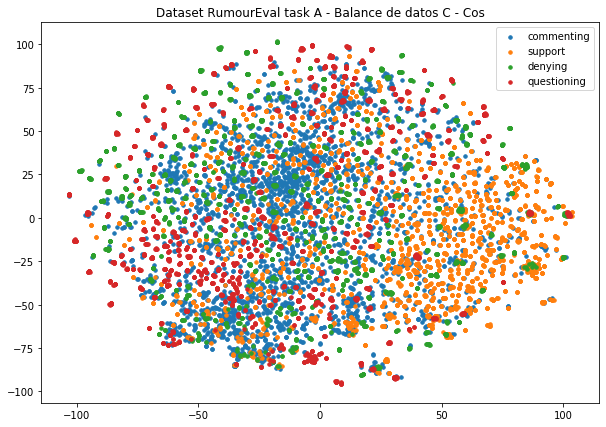

In [31]:
model = TSNE(2, metric='cosine')
to_plot_tsne = model.fit_transform(data_bas_c)    
plt.figure(figsize=(10,7))
for key in keys:
    labels=[dict_cl[lab] for lab in macro_augmented[:,2]]
    mask = np.asarray(labels)==key
    plt.scatter(to_plot_tsne[:,0][mask],to_plot_tsne[:,1][mask], s=12, label=str(key))

plt.legend()
plt.title("Dataset RumourEval task A - Balance de datos C - Cos")
plt.show()

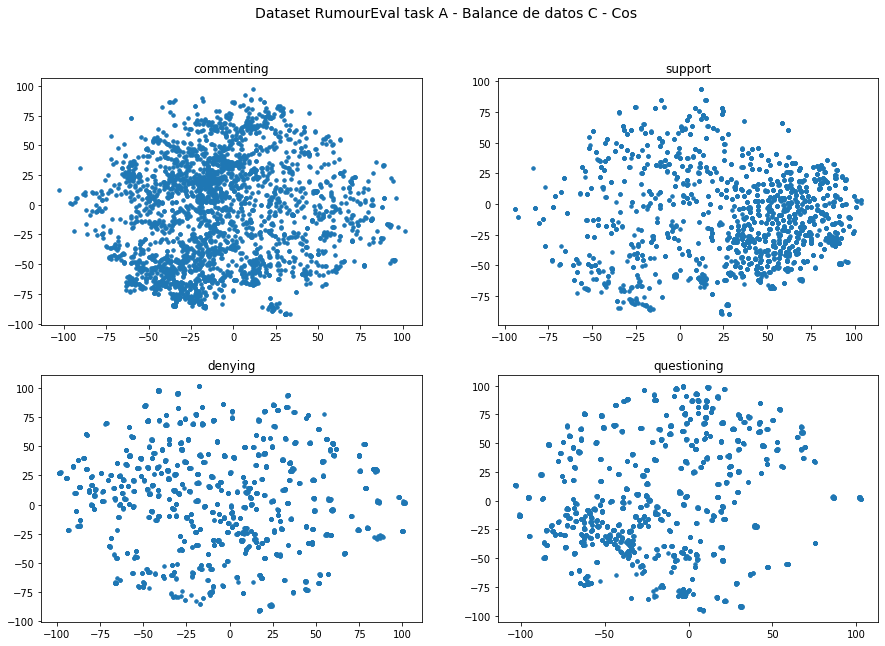

In [33]:
fig = plt.figure(figsize=(15,10))
j=220
for key in keys:
    labels=[dict_cl[lab] for lab in macro_augmented[:,2]]
    mask = np.asarray(labels)==key
    j+=1
    h=fig.add_subplot(j)
    plt.scatter(to_plot_tsne[:,0][mask],to_plot_tsne[:,1][mask], s=12, label=str(key))
    h.title.set_text(str(key))

fig.suptitle("Dataset RumourEval task A - Balance de datos C - Cos", fontsize=14)
plt.show()

In [34]:
#macro_augmented = np.asarray(macro_augmented, dtype=object)
np.random.shuffle(macro_augmented)
np.save('../Datasets/CSV_Stance/balance_clase_noPon.npy', macro_augmented)


### Sujeto a Clase ponderando target

In [35]:
macro_augmented=[]
for clase in aum_weight:
    start_time=time.time()
    print ("\n\nGenerando", aum_weight[clase], "ejemplos para", clase)
    muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, pond=True)
    macro_augmented+=muestras
    print ("Resumen de modificaciones:", dict_aumentos)
    elapsed_time= time.time() - start_time
    print ("Este proceso tomó", elapsed_time, "seg")   



Generando 2404 ejemplos para questioning
Consultando por la clase questioning
Entrega label 2
Original: being  	Reemplazo:  [('saying', 0.7684832811355591)]
Sentencia original:
['user' 'user' 'any' 'chance' 'that' "'" 's' 'being' 'said' 'for' 'fear'
 'of' 'retribution' '?']
Sentencia final: 2
['user', 'user', 'any', 'chance', 'that', "'", 's', 'saying', 'said', 'for', 'fear', 'of', 'retribution', '?']


Original: ah  	Reemplazo:  [('gunshot', 1.3367124795913696)]
Original: ll  	Reemplazo:  [('gonna', 1.0994640588760376)]
Original: coroner  	Reemplazo:  [('helpful', 0.48688769340515137)]
Original: won  	Reemplazo:  [('doesn', 0.9041232466697693)]
Sentencia original:
['user' 'user' 'user' 'user' 'ah' 'true' '.' 'problem' 'now' 'is' 'we' "'"
 'll' 'probably' 'only' 'get' 'coroner' "'" 's' 'details' 'they' 'won' "'"
 't' 'make' 'it' '.']
Sentencia final: 2
['user', 'user', 'user', 'user', 'gunshot', 'true', '.', 'problem', 'now', 'is', 'we', "'", 'gonna', 'probably', 'only', 'get', 'help

Original: cafe  	Reemplazo:  [('canada', 0.7962354421615601)]
Sentencia original:
['user' 'but' 'why' 'a' 'fucking' 'cafe' 'in' 'australia']
Sentencia final: 2
['user', 'but', 'why', 'a', 'fucking', 'canada', 'in', 'australia']


Original: true  	Reemplazo:  [('unable', 1.5187770128250122)]
Original: past  	Reemplazo:  [('yesterday', 1.5282588005065918)]
Sentencia original:
['user' 'true' '.' 'but' 'i' 'hear' 'there' 'was' 'a' 'similar' 'incident'
 'this' 'past' 'monday' '.' 'is' 'that' 'correct' '?' 'that' 'makes' 'me'
 'think' 'its' 'low' 'level' 'terrorism']
Sentencia final: 2
['user', 'unable', '.', 'but', 'i', 'hear', 'there', 'was', 'a', 'similar', 'incident', 'this', 'yesterday', 'monday', '.', 'is', 'that', 'correct', '?', 'that', 'makes', 'me', 'think', 'its', 'low', 'level', 'terrorism']


Original: black  	Reemplazo:  [('dead', 0.5140852928161621)]
Sentencia original:
['user' 'user' 'user' 'so' 'they' "'" 're' 'claiming' 'a' 'black' 'cop'
 'killed' 'hashtag' '?' '?']
Sentenc

Original: are  	Reemplazo:  [('am', 0.6972745656967163)]
Sentencia original:
['user' 'what' 'are' 'your' 'thoughts' 'on' 'hashtag' '?']
Sentencia final: 2
['user', 'what', 'am', 'your', 'thoughts', 'on', 'hashtag', '?']


Original: s  	Reemplazo:  [('time', 2.1133105754852295)]
Sentencia original:
['user' 'na' ',' 'it' "'" 's' 'too' 'many' 'black' 'people' 'for'
 'hashtag' 'to' 'care']
Sentencia final: 2
['user', 'na', ',', 'it', "'", 'time', 'too', 'many', 'black', 'people', 'for', 'hashtag', 'to', 'care']


Original: sake  	Reemplazo:  [('fine', 1.181374192237854)]
Sentencia original:
['user' 'just' 'for' 'the' 'sake' 'of' 'good' 'journalism' ',' 'which'
 'one' 'is' 'it' '?' 'html']
Sentencia final: 2
['user', 'just', 'for', 'the', 'fine', 'of', 'good', 'journalism', ',', 'which', 'one', 'is', 'it', '?', 'html']


Original: exist  	Reemplazo:  [('irrelevant', 0.4890223443508148)]
Sentencia original:
['user' 'user' 'maintain' 'high' 'level' 'of' 'vigilance' '?' 'against'
 'who' '?' 'o

Original: i  	Reemplazo:  [('ll', 1.1715404987335205)]
Original: flip  	Reemplazo:  [('home', 1.8977590799331665)]
Sentencia original:
['user' 'user' 'i' "'" 'm' 'looking' 'for' 'his' 'read' 'hat' 'and' 'his'
 'flip' 'flop' 'can' 'you' 'find' 'them' '?' 'html']
Sentencia final: 2
['user', 'user', 'll', "'", 'm', 'looking', 'for', 'his', 'read', 'hat', 'and', 'his', 'home', 'flop', 'can', 'you', 'find', 'them', '?', 'html']


Original: got  	Reemplazo:  [('was', 0.7684165239334106)]
Sentencia original:
['user' 'user' 'it' 'wasn' "'" 't' 'the' 'quik' 'stop' 'that' 'got'
 'burned' 'down' '?']
Sentencia final: 2
['user', 'user', 'it', 'wasn', "'", 't', 'the', 'quik', 'stop', 'that', 'was', 'burned', 'down', '?']


Original: store  	Reemplazo:  [('robbery', 0.7915676832199097)]
Sentencia original:
['user' 'user' 'shit' 'not' 'adding' 'up' '.' 'what' 'convenient' 'store'
 'was' 'robbed' '?' 'who' 'are' 'the' 'witnesses' 'that' 'called' 'it'
 'in' '?']
Sentencia final: 2
['user', 'user', 'shi

Original: t  	Reemplazo:  [('didn', 0.4741501212120056)]
Original: consider  	Reemplazo:  [('identify', 0.5679961442947388)]
Sentencia original:
['user' 'user' 'western' 'countries' 'have' 'killed' 'more' 'innocent'
 'children' 'than' 'hitler' 'assmunch' '.' 'but' 'you' 'prob' 'don' "'"
 't' 'consider' 'that' 'terror' '?' '?']
Sentencia final: 2
['user', 'user', 'western', 'countries', 'have', 'killed', 'more', 'innocent', 'children', 'than', 'hitler', 'assmunch', '.', 'but', 'you', 'prob', 'don', "'", 'didn', 'identify', 'that', 'terror', '?', '?']


Original: peaceful  	Reemplazo:  [('stupidity', 0.5969588756561279)]
Original: resolution  	Reemplazo:  [('fuck', 0.7612131237983704)]
Sentencia original:
['user' 'this' 'peaceful' 'resolution' 'shit' 'just' 'resulted' 'in'
 'dead' 'and' 'wounded' 'hostages']
Sentencia final: 2
['user', 'this', 'stupidity', 'fuck', 'shit', 'just', 'resulted', 'in', 'dead', 'and', 'wounded', 'hostages']


Original: believe  	Reemplazo:  [('assume', 1.63074

Original: many  	Reemplazo:  [('numerous', 0.5980915427207947)]
Sentencia original:
['user' 'user' 'jet' 'so' 'many' 'muslims' 'around' 'the' 'world' 'are'
 'a' 'problem' 'how' 'do' 'you' 'explain' 'that' '?']
Sentencia final: 2
['user', 'user', 'jet', 'so', 'numerous', 'muslims', 'around', 'the', 'world', 'are', 'a', 'problem', 'how', 'do', 'you', 'explain', 'that', '?']


Original: stop  	Reemplazo:  [('taxi', 0.9244507551193237)]
Sentencia original:
['user' 'user' 'indicate' '?' 'if' 'he' 'was' 'a' 'suspect' 'why' 'did'
 'the' 'police' 'stop' 'his' 'car' 'next' 'to' 'him' 'and' 'tell' 'him'
 'to' '"' 'get' 'the' 'f' 'hashtag' 'on' 'the' 'sidewalk' '"' '?']
Sentencia final: 2
['user', 'user', 'indicate', '?', 'if', 'he', 'was', 'a', 'suspect', 'why', 'did', 'the', 'police', 'taxi', 'his', 'car', 'next', 'to', 'him', 'and', 'tell', 'him', 'to', '"', 'get', 'the', 'f', 'hashtag', 'on', 'the', 'sidewalk', '"', '?']


Original: trained  	Reemplazo:  [('motivated', 1.5107030868530273)]
Or

Original: are  	Reemplazo:  [('am', 1.1482491493225098)]
Original: is  	Reemplazo:  [('has', 0.4990483820438385)]
Original: list  	Reemplazo:  [('understand', 3.5131237506866455)]
Sentencia original:
['user' 'user' 'so' 'what' 'they' 'are' 'doing' 'is' 'right' '?' '?' '?'
 'you' "'" 're' 'wacked' '!' '!' '!' 'you' 'should' 'be' 'on' 'a' 'list'
 '!' '!' '!']
Sentencia final: 2
['user', 'user', 'so', 'what', 'they', 'am', 'doing', 'has', 'right', '?', '?', '?', 'you', "'", 're', 'wacked', '!', '!', '!', 'you', 'should', 'be', 'on', 'a', 'understand', '!', '!', '!']


Original: have  	Reemplazo:  [('find', 0.7169812917709351)]
Sentencia original:
['user' 'do' 'you' 'have' 'a' 'link' '?']
Sentencia final: 2
['user', 'do', 'you', 'find', 'a', 'link', '?']


Original: police  	Reemplazo:  [('cops', 0.7700986862182617)]
Original: confirm  	Reemplazo:  [('clarify', 0.4081798493862152)]
Original: cafe  	Reemplazo:  [('retribution', 0.6242902278900146)]
Sentencia original:
['“' 'user' ':' 'more'

Original: isn  	Reemplazo:  [('wasn', 0.904886782169342)]
Original: been  	Reemplazo:  [('seen', 0.7449384331703186)]
Original: t  	Reemplazo:  [('hear', 0.7364348769187927)]
Original: ongoing  	Reemplazo:  [('performing', 1.1144044399261475)]
Original: robber  	Reemplazo:  [('shoot', 0.8370213508605957)]
Original: alright  	Reemplazo:  [('okay', 0.8216366171836853)]
Original: gm  	Reemplazo:  [('thought', 1.293474793434143)]
Original: did  	Reemplazo:  [('had', 0.5756980776786804)]
Original: rides  	Reemplazo:  [('shows', 0.38946184515953064)]
Original: t  	Reemplazo:  [('ferguson', 0.4759299159049988)]
Original: incident  	Reemplazo:  [('comment', 0.7449208498001099)]
Original: do  	Reemplazo:  [('see', 1.124149203300476)]
Original: killed  	Reemplazo:  [('deserved', 2.2946839332580566)]
Original: corruption  	Reemplazo:  [('stupidity', 1.2244353294372559)]
Original: happened  	Reemplazo:  [('resulted', 0.678506076335907)]
Original: holding  	Reemplazo:  [('carrying', 0.7340787053108

Original: okay  	Reemplazo:  [('alright', 0.6493692398071289)]
Original: s  	Reemplazo:  [('time', 1.1583669185638428)]
Original: active  	Reemplazo:  [('unarmed', 0.79404616355896)]
Original: situation  	Reemplazo:  [('confrontation', 0.3399646282196045)]
Original: tell  	Reemplazo:  [('ask', 0.7075508236885071)]
Original: have  	Reemplazo:  [('do', 1.4884202480316162)]
Original: correct  	Reemplazo:  [('today', 1.3374786376953125)]
Original: ferguson  	Reemplazo:  [('theft', 0.8664887547492981)]
Original: didn  	Reemplazo:  [('doesn', 0.5329757332801819)]
Original: stop  	Reemplazo:  [('pause', 0.8072190880775452)]
Original: suspect  	Reemplazo:  [('accuse', 0.5803989768028259)]
Original: police  	Reemplazo:  [('cops', 1.211775302886963)]
Original: causing  	Reemplazo:  [('wearing', 1.2801614999771118)]
Original: is  	Reemplazo:  [('gets', 0.46122804284095764)]
Original: thank  	Reemplazo:  [('pay', 0.4514324963092804)]
Original: confirmed  	Reemplazo:  [('commented', 1.5206072330474

Original: number  	Reemplazo:  [('hostage', 0.41858574748039246)]
Original: updates  	Reemplazo:  [('inquiries', 0.5997372269630432)]
Original: pricing  	Reemplazo:  [('supermarket', 0.7864430546760559)]
Original: stories  	Reemplazo:  [('reporters', 0.5981789827346802)]
Original: source  	Reemplazo:  [('provide', 0.8464803695678711)]
Original: please  	Reemplazo:  [('fact', 1.084499478340149)]
Original: st  	Reemplazo:  [('ve', 1.1535751819610596)]
Original: swarm  	Reemplazo:  [('attacker', 1.4225178956985474)]
Original: concert  	Reemplazo:  [('show', 0.770150363445282)]
Original: happening  	Reemplazo:  [('airing', 0.5420103669166565)]
Original: looting  	Reemplazo:  [('shoving', 0.6533666253089905)]
Original: brown  	Reemplazo:  [('jeffrey', 0.4795434772968292)]
Original: video  	Reemplazo:  [('photo', 1.160971999168396)]
Original: been  	Reemplazo:  [('done', 0.6869006752967834)]
Original: being  	Reemplazo:  [('using', 0.8178681135177612)]
Original: followers  	Reemplazo:  [('pe

Original: video  	Reemplazo:  [('release', 0.8354347348213196)]
Original: give  	Reemplazo:  [('take', 0.7163408994674683)]
Original: missing  	Reemplazo:  [('carrying', 1.094058632850647)]
Original: store  	Reemplazo:  [('show', 0.7102511525154114)]
Original: car  	Reemplazo:  [('use', 0.7885618209838867)]
Original: brown  	Reemplazo:  [('shoot', 0.8191529512405396)]
Original: was  	Reemplazo:  [('were', 0.7990248799324036)]
Original: i  	Reemplazo:  [('ll', 2.0188145637512207)]
Original: many  	Reemplazo:  [('much', 1.1707998514175415)]
Original: read  	Reemplazo:  [('time', 1.1877332925796509)]
Original: world  	Reemplazo:  [('brown', 1.3021259307861328)]
Original: kids  	Reemplazo:  [('children', 0.5152146816253662)]
Original: heard  	Reemplazo:  [('hear', 1.6587895154953003)]
Original: evacuated  	Reemplazo:  [('identified', 0.7191860675811768)]
Original: state  	Reemplazo:  [('blackout', 0.4957354664802551)]
Original: have  	Reemplazo:  [('do', 0.47095397114753723)]
Original: ide

Original: is  	Reemplazo:  [('gets', 0.5206977725028992)]
Original: uber  	Reemplazo:  [('pay', 1.4443445205688477)]
Original: d  	Reemplazo:  [('ll', 0.7143958806991577)]
Original: d  	Reemplazo:  [('ve', 0.7399192452430725)]
Original: photo  	Reemplazo:  [('picture', 3.3474600315093994)]
Original: was  	Reemplazo:  [('were', 1.3131954669952393)]
Original: suspect  	Reemplazo:  [('saw', 0.7960296869277954)]
Original: did  	Reemplazo:  [('had', 0.7772380709648132)]
Original: witness  	Reemplazo:  [('remain', 0.7755700945854187)]
Original: jail  	Reemplazo:  [('prison', 2.3028929233551025)]
Original: free  	Reemplazo:  [('questionable', 0.5002270340919495)]
Original: reports  	Reemplazo:  [('accounts', 1.2944774627685547)]
Original: suspects  	Reemplazo:  [('weren', 0.7187619209289551)]
Original: t  	Reemplazo:  [('blackout', 0.5007588863372803)]
Original: blocked  	Reemplazo:  [('filled', 0.6976533532142639)]
Original: won  	Reemplazo:  [('retribution', 0.43546584248542786)]
Original: 

Original: hostages  	Reemplazo:  [('gunmen', 0.42852944135665894)]
Original: identified  	Reemplazo:  [('evacuated', 0.8305609822273254)]
Original: newspaper  	Reemplazo:  [('jack', 1.044346809387207)]
Original: thank  	Reemplazo:  [('use', 1.2982003688812256)]
Original: is  	Reemplazo:  [('seems', 1.3753457069396973)]
Original: everything  	Reemplazo:  [('everyone', 1.3922251462936401)]
Original: other  	Reemplazo:  [('numerous', 0.8660637736320496)]
Original: man  	Reemplazo:  [('place', 1.8866862058639526)]
Original: s  	Reemplazo:  [('concert', 0.695225715637207)]
Original: were  	Reemplazo:  [('was', 0.49249133467674255)]
Original: known  	Reemplazo:  [('seen', 1.1587613821029663)]
Original: flop  	Reemplazo:  [('track', 1.882537603378296)]
Original: got  	Reemplazo:  [('avoided', 0.4760468304157257)]
Original: shit  	Reemplazo:  [('manipulate', 0.3531239628791809)]
Original: please  	Reemplazo:  [('present', 1.0999619960784912)]
Original: updates  	Reemplazo:  [('attackers', 0.78

Original: be  	Reemplazo:  [('have', 0.7151439189910889)]
Original: brown  	Reemplazo:  [('smith', 0.45916298031806946)]
Original: confirmed  	Reemplazo:  [('commented', 1.4449325799942017)]
Original: context  	Reemplazo:  [('respect', 1.1018623113632202)]
Original: shooting  	Reemplazo:  [('being', 1.8302972316741943)]
Original: contact  	Reemplazo:  [('anything', 0.5136600732803345)]
Original: soo  	Reemplazo:  [('attacker', 0.8901810050010681)]
Original: hear  	Reemplazo:  [('heard', 0.41209322214126587)]
Original: incident  	Reemplazo:  [('event', 0.7493375539779663)]
Original: past  	Reemplazo:  [('yesterday', 1.5282588005065918)]
Original: is  	Reemplazo:  [('has', 0.7126959562301636)]
Original: makes  	Reemplazo:  [('says', 1.1816378831863403)]
Original: level  	Reemplazo:  [('rate', 1.9351565837860107)]
Original: claiming  	Reemplazo:  [('protesting', 0.5049152970314026)]
Original: saying  	Reemplazo:  [('being', 1.2345049381256104)]
Original: brown  	Reemplazo:  [('wilson', 0.

Original: matter  	Reemplazo:  [('hear', 0.8231534361839294)]
Original: does  	Reemplazo:  [('is', 0.7021195292472839)]
Original: rate  	Reemplazo:  [('level', 0.4319905638694763)]
Original: is  	Reemplazo:  [('seems', 0.48090285062789917)]
Original: flag  	Reemplazo:  [('doesn', 1.1666446924209595)]
Original: reporters  	Reemplazo:  [('journalists', 0.4952004849910736)]
Original: guy  	Reemplazo:  [('man', 0.7718987464904785)]
Original: number  	Reemplazo:  [('group', 0.809422492980957)]
Original: clerk  	Reemplazo:  [('mean', 0.865185022354126)]
Original: means  	Reemplazo:  [('looks', 0.7057329416275024)]
Original: s  	Reemplazo:  [('doesn', 1.4048445224761963)]
Original: flag  	Reemplazo:  [('declare', 0.6140254139900208)]
Original: cause  	Reemplazo:  [('state', 0.7072127461433411)]
Original: is  	Reemplazo:  [('has', 1.6944948434829712)]
Original: journalists  	Reemplazo:  [('inquiries', 0.42482075095176697)]
Original: video  	Reemplazo:  [('picture', 0.9161200523376465)]
Origina

Original: hat  	Reemplazo:  [('right', 1.2306139469146729)]
Original: mean  	Reemplazo:  [('doesn', 1.774833083152771)]
Original: s  	Reemplazo:  [('st', 0.6485704183578491)]
Original: is  	Reemplazo:  [('has', 2.011805534362793)]
Original: maintain  	Reemplazo:  [('manipulate', 0.7541671991348267)]
Original: level  	Reemplazo:  [('justification', 0.48228684067726135)]
Original: america  	Reemplazo:  [('understand', 0.8117716312408447)]
Original: cost  	Reemplazo:  [('pricing', 0.7300671339035034)]
Original: higher  	Reemplazo:  [('bigger', 0.9369829297065735)]
Original: is  	Reemplazo:  [('seems', 0.862133264541626)]
Original: pic  	Reemplazo:  [('prick', 0.8207871317863464)]
Original: s  	Reemplazo:  [('owner', 0.8047019243240356)]
Original: news  	Reemplazo:  [('broken', 0.748957633972168)]
Original: police  	Reemplazo:  [('media', 0.45525723695755005)]
Original: isn  	Reemplazo:  [('wasn', 1.5655982494354248)]
Original: arrest  	Reemplazo:  [('jail', 0.9077391028404236)]
Original: 

Original: say  	Reemplazo:  [('do', 0.7050695419311523)]
Original: hide  	Reemplazo:  [('schedule', 1.2513084411621094)]
Original: crime  	Reemplazo:  [('employ', 0.30511701107025146)]
Original: proof  	Reemplazo:  [('show', 1.354042410850525)]
Original: i  	Reemplazo:  [('use', 0.7995527386665344)]
Original: are  	Reemplazo:  [('am', 0.23107780516147614)]
Original: escape  	Reemplazo:  [('time', 3.172736883163452)]
Original: look  	Reemplazo:  [('feel', 1.917031168937683)]
Original: other  	Reemplazo:  [('many', 0.7521767020225525)]
Original: non  	Reemplazo:  [('past', 1.1465442180633545)]
Original: resolution  	Reemplazo:  [('stupidity', 0.8716254830360413)]
Original: praying  	Reemplazo:  [('hoping', 0.8138831257820129)]
Original: shoot  	Reemplazo:  [('shot', 0.7121312022209167)]
Original: number  	Reemplazo:  [('stupidity', 0.4640822410583496)]
Original: muslim  	Reemplazo:  [('islam', 0.8467277884483337)]
Original: department  	Reemplazo:  [('niece', 0.5715963840484619)]
Origina

Original: person  	Reemplazo:  [('terrorist', 1.4131910800933838)]
Original: s  	Reemplazo:  [('time', 1.2583236694335938)]
Original: hostages  	Reemplazo:  [('people', 0.7757481336593628)]
Original: many  	Reemplazo:  [('other', 1.283604621887207)]
Original: addition  	Reemplazo:  [('isil', 1.2113900184631348)]
Original: reports  	Reemplazo:  [('accounts', 1.239351511001587)]
Original: conspiracy  	Reemplazo:  [('use', 0.83407062292099)]
Original: sure  	Reemplazo:  [('gonna', 1.2688642740249634)]
Original: had  	Reemplazo:  [('was', 0.7459821701049805)]
Original: make  	Reemplazo:  [('do', 0.6806548833847046)]
Original: track  	Reemplazo:  [('feel', 0.7902156114578247)]
Original: be  	Reemplazo:  [('go', 0.6621676087379456)]
Original: lone  	Reemplazo:  [('gonna', 1.2469912767410278)]
Original: copy  	Reemplazo:  [('version', 0.4521922767162323)]
Original: fact  	Reemplazo:  [('prefer', 1.2748099565505981)]
Original: everyone  	Reemplazo:  [('understand', 1.5170801877975464)]
Origina

Original: s  	Reemplazo:  [('st', 0.7287808656692505)]
Original: excellent  	Reemplazo:  [('doesn', 2.4471616744995117)]
Original: blame  	Reemplazo:  [('responsibility', 1.8976876735687256)]
Original: mean  	Reemplazo:  [('suppose', 0.991513729095459)]
Original: journalists  	Reemplazo:  [('reporters', 0.4181870222091675)]
Original: aid  	Reemplazo:  [('worthless', 0.3656176030635834)]
Original: d  	Reemplazo:  [('ve', 0.7117567658424377)]
Original: are  	Reemplazo:  [('am', 0.41434985399246216)]
Original: suspect  	Reemplazo:  [('didn', 0.8666915893554688)]
Original: police  	Reemplazo:  [('cops', 0.4120517373085022)]
Original: next  	Reemplazo:  [('last', 1.1550902128219604)]
Original: tell  	Reemplazo:  [('ask', 1.7662205696105957)]
Original: armed  	Reemplazo:  [('killed', 1.3397231101989746)]
Original: store  	Reemplazo:  [('manager', 0.7092341184616089)]
Original: friend  	Reemplazo:  [('girlfriend', 0.8049424886703491)]
Original: gotten  	Reemplazo:  [('weren', 0.88911193609237

Original: didn  	Reemplazo:  [('doesn', 0.8609997630119324)]
Original: t  	Reemplazo:  [('shoot', 0.47222304344177246)]
Original: i  	Reemplazo:  [('read', 1.1008713245391846)]
Original: think  	Reemplazo:  [('suppose', 1.9870784282684326)]
Original: take  	Reemplazo:  [('do', 0.84823077917099)]
Original: dead  	Reemplazo:  [('black', 1.137367844581604)]
Original: right  	Reemplazo:  [('correct', 0.5221161246299744)]
Original: anything  	Reemplazo:  [('nothing', 1.2907700538635254)]
Original: i  	Reemplazo:  [('use', 0.7273305654525757)]
Original: store  	Reemplazo:  [('supermarket', 0.4899541139602661)]
Original: talking  	Reemplazo:  [('fucking', 0.478285014629364)]
Original: arabic  	Reemplazo:  [('allah', 1.3551898002624512)]
Original: source  	Reemplazo:  [('stream', 1.1348541975021362)]
Original: right  	Reemplazo:  [('home', 3.2746212482452393)]
Original: were  	Reemplazo:  [('was', 0.5361481308937073)]
Original: info  	Reemplazo:  [('intro', 0.8002620339393616)]
Original: is  	

Original: is  	Reemplazo:  [('has', 3.252593755722046)]
Original: minutes  	Reemplazo:  [('hours', 1.15169095993042)]
Original: i  	Reemplazo:  [('use', 0.829230546951294)]
Original: sydney  	Reemplazo:  [('toronto', 0.7835789918899536)]
Original: be  	Reemplazo:  [('go', 1.2699068784713745)]
Original: motivated  	Reemplazo:  [('disgusted', 0.5225319862365723)]
Original: i  	Reemplazo:  [('use', 0.7209038734436035)]
Original: am  	Reemplazo:  [('are', 0.41616132855415344)]
Original: coward  	Reemplazo:  [('retribution', 0.4545237720012665)]
Original: i  	Reemplazo:  [('time', 1.2016148567199707)]
Original: was  	Reemplazo:  [('had', 0.8791519403457642)]
Original: s  	Reemplazo:  [('right', 1.2395395040512085)]
Original: seen  	Reemplazo:  [('sold', 2.0755059719085693)]
Original: expect  	Reemplazo:  [('assume', 0.5274564027786255)]
Original: say  	Reemplazo:  [('know', 0.2708977162837982)]
Original: is  	Reemplazo:  [('has', 0.7686898708343506)]
Original: black  	Reemplazo:  [('white',

Original: someone  	Reemplazo:  [('something', 0.873421847820282)]
Original: coming  	Reemplazo:  [('bringing', 0.4930068254470825)]
Original: source  	Reemplazo:  [('canada', 1.2724672555923462)]
Original: share  	Reemplazo:  [('gonna', 1.4597166776657104)]
Original: robbery  	Reemplazo:  [('murder', 1.1661938428878784)]
Original: values  	Reemplazo:  [('muslims', 1.4908697605133057)]
Original: life  	Reemplazo:  [('family', 1.281113624572754)]
Original: have  	Reemplazo:  [('do', 1.234906554222107)]
Original: been  	Reemplazo:  [('done', 2.0326032638549805)]
Original: know  	Reemplazo:  [('believe', 0.7508044242858887)]
Original: hand  	Reemplazo:  [('gunshot', 0.5906619429588318)]
Original: gun  	Reemplazo:  [('employ', 0.29756370186805725)]
Original: are  	Reemplazo:  [('am', 0.6526175737380981)]
Original: banned  	Reemplazo:  [('been', 1.7974058389663696)]
Original: wonder  	Reemplazo:  [('umm', 0.47211581468582153)]
Original: look  	Reemplazo:  [('watch', 1.1762115955352783)]
Ori

Original: bad  	Reemplazo:  [('good', 0.7689804434776306)]
Original: please  	Reemplazo:  [('oh', 1.1072865724563599)]
Original: info  	Reemplazo:  [('gonna', 1.428423285484314)]
Original: reliable  	Reemplazo:  [('sarcastic', 0.7790634036064148)]
Original: opinion  	Reemplazo:  [('thought', 1.1421246528625488)]
Original: white  	Reemplazo:  [('black', 1.4500296115875244)]
Original: actions  	Reemplazo:  [('rates', 1.9187508821487427)]
Original: need  	Reemplazo:  [('want', 0.5168834328651428)]
Original: read  	Reemplazo:  [('reporting', 0.5043582916259766)]
Original: report  	Reemplazo:  [('write', 1.2200088500976562)]
Original: reporter  	Reemplazo:  [('reporting', 0.7784079313278198)]
Original: dad  	Reemplazo:  [('attacker', 1.8914923667907715)]
Original: update  	Reemplazo:  [('clarify', 0.5886508226394653)]
Original: shooting  	Reemplazo:  [('running', 1.1507856845855713)]
Original: speak  	Reemplazo:  [('accuse', 0.5916473865509033)]
Original: have  	Reemplazo:  [('be', 0.744960

Original: cnn  	Reemplazo:  [('dad', 0.8305042386054993)]
Original: prince  	Reemplazo:  [('confirmation', 0.8723236322402954)]
Original: arrested  	Reemplazo:  [('disgusted', 0.9805984497070312)]
Original: abc  	Reemplazo:  [('cbs', 0.503875195980072)]
Original: be  	Reemplazo:  [('have', 0.7447575330734253)]
Original: pointed  	Reemplazo:  [('commented', 0.777429461479187)]
Original: s  	Reemplazo:  [('time', 1.165928840637207)]
Original: peaceful  	Reemplazo:  [('terrorist', 0.6223403215408325)]
Original: true  	Reemplazo:  [('sarcastic', 0.5801242589950562)]
Original: banned  	Reemplazo:  [('been', 1.112348198890686)]
Original: proof  	Reemplazo:  [('show', 1.354042410850525)]
Original: escape  	Reemplazo:  [('time', 3.172736883163452)]
Original: cops  	Reemplazo:  [('criminals', 0.9309510588645935)]
Original: aggressive  	Reemplazo:  [('islamic', 1.0772216320037842)]
Original: safe  	Reemplazo:  [('reliable', 0.8725876212120056)]
Original: hurt  	Reemplazo:  [('hit', 1.82011115550

Original: alright  	Reemplazo:  [('okay', 0.8216366171836853)]
Original: have  	Reemplazo:  [('know', 0.4384458065032959)]
Original: don  	Reemplazo:  [('man', 0.7702046036720276)]
Original: get  	Reemplazo:  [('be', 0.8114160299301147)]
Original: hours  	Reemplazo:  [('minutes', 0.8450052738189697)]
Original: check  	Reemplazo:  [('accuse', 0.9590591788291931)]
Original: source  	Reemplazo:  [('thought', 0.7258167862892151)]
Original: great  	Reemplazo:  [('good', 0.7749801278114319)]
Original: corruption  	Reemplazo:  [('stupidity', 1.2244353294372559)]
Original: appearance  	Reemplazo:  [('schedule', 2.338266611099243)]
Original: sit  	Reemplazo:  [('accuse', 0.6189956068992615)]
Original: reports  	Reemplazo:  [('lies', 1.2849863767623901)]
Original: is  	Reemplazo:  [('has', 0.4614916145801544)]
Original: are  	Reemplazo:  [('am', 0.7369456887245178)]
Original: guy  	Reemplazo:  [('dude', 0.8358154296875)]
Original: michael  	Reemplazo:  [('peter', 1.1807456016540527)]
Original: c

Original: saying  	Reemplazo:  [('being', 0.7137975096702576)]
Original: hostage  	Reemplazo:  [('wasn', 2.4162120819091797)]
Original: police  	Reemplazo:  [('weren', 1.2720040082931519)]
Original: such  	Reemplazo:  [('numerous', 1.1415128707885742)]
Original: comment  	Reemplazo:  [('commentary', 1.1409492492675781)]
Original: i  	Reemplazo:  [('thought', 0.8108954429626465)]
Original: t  	Reemplazo:  [('ve', 0.7329873442649841)]
Original: ll  	Reemplazo:  [('shouldn', 1.1551403999328613)]
Original: see  	Reemplazo:  [('know', 0.4505425989627838)]
Original: t  	Reemplazo:  [('ve', 1.1867791414260864)]
Original: being  	Reemplazo:  [('saying', 1.2798550128936768)]
Original: get  	Reemplazo:  [('expect', 1.4542685747146606)]
Original: coroner  	Reemplazo:  [('helpful', 0.48688769340515137)]
Original: won  	Reemplazo:  [('retribution', 0.5015295147895813)]
Original: make  	Reemplazo:  [('be', 1.261026382446289)]
Original: australia  	Reemplazo:  [('weren', 0.6418816447257996)]
Original

Original: number  	Reemplazo:  [('jail', 0.6127661466598511)]
Original: shooting  	Reemplazo:  [('happening', 0.5245192646980286)]
Original: paris  	Reemplazo:  [('exist', 0.8784488439559937)]
Original: investigation  	Reemplazo:  [('crime', 0.8944780826568604)]
Original: facts  	Reemplazo:  [('needs', 0.33925262093544006)]
Original: many  	Reemplazo:  [('numerous', 1.2686340808868408)]
Original: killed  	Reemplazo:  [('murdered', 0.6224337816238403)]
Original: prosecution  	Reemplazo:  [('andrei', 0.8371738195419312)]
Original: please  	Reemplazo:  [('divert', 0.7700421810150146)]
Original: is  	Reemplazo:  [('has', 1.0697529315948486)]
Original: missouri  	Reemplazo:  [('doesn', 0.7093865871429443)]
Original: are  	Reemplazo:  [('am', 1.955741286277771)]
Original: manipulate  	Reemplazo:  [('press', 0.8421213030815125)]
Original: media  	Reemplazo:  [('journalists', 0.9226968288421631)]
Original: fine  	Reemplazo:  [('alright', 0.5652763843536377)]
Original: hostage  	Reemplazo:  [('

Original: low  	Reemplazo:  [('high', 0.8794422149658203)]
Original: terrorism  	Reemplazo:  [('terrorist', 0.5405737161636353)]
Original: re  	Reemplazo:  [('retribution', 0.848832368850708)]
Original: place  	Reemplazo:  [('time', 2.007294178009033)]
Original: are  	Reemplazo:  [('am', 0.4914674162864685)]
Original: have  	Reemplazo:  [('take', 0.4499453008174896)]
Original: remain  	Reemplazo:  [('stay', 0.7470859885215759)]
Original: police  	Reemplazo:  [('cops', 2.097294330596924)]
Original: ve  	Reemplazo:  [('gonna', 1.7113831043243408)]
Original: makes  	Reemplazo:  [('seems', 1.241834044456482)]
Original: suspect  	Reemplazo:  [('use', 0.41758817434310913)]
Original: minutes  	Reemplazo:  [('hours', 1.191213607788086)]
Original: suspect  	Reemplazo:  [('blonde', 0.7125754952430725)]
Original: stop  	Reemplazo:  [('end', 1.185391902923584)]
Original: sydney  	Reemplazo:  [('group', 2.172888994216919)]
Original: talk  	Reemplazo:  [('speak', 0.8150965571403503)]
Original: mothe

Original: guy  	Reemplazo:  [('dude', 0.5009006857872009)]
Original: action  	Reemplazo:  [('retribution', 0.5542297959327698)]
Original: number  	Reemplazo:  [('time', 0.7616904377937317)]
Original: number  	Reemplazo:  [('name', 0.8326700329780579)]
Original: clerk  	Reemplazo:  [('mean', 0.865185022354126)]
Original: gun  	Reemplazo:  [('man', 1.8659148216247559)]
Original: cafe  	Reemplazo:  [('family', 2.045485496520996)]
Original: australia  	Reemplazo:  [('bars', 1.1495013236999512)]
Original: wasn  	Reemplazo:  [('isn', 0.572486400604248)]
Original: shoes  	Reemplazo:  [('media', 3.204267978668213)]
Original: do  	Reemplazo:  [('go', 1.8784990310668945)]
Original: number  	Reemplazo:  [('confirm', 0.3711627125740051)]
Original: isis  	Reemplazo:  [('wat', 0.48045873641967773)]
Original: is  	Reemplazo:  [('has', 0.8932289481163025)]
Original: heard  	Reemplazo:  [('hear', 1.6469719409942627)]
Original: please  	Reemplazo:  [('divert', 0.31948322057724)]
Original: showing  	Reem

Original: hat  	Reemplazo:  [('right', 1.2306139469146729)]
Original: does  	Reemplazo:  [('wants', 0.5680959224700928)]
Original: easy  	Reemplazo:  [('able', 0.7369290590286255)]
Original: id  	Reemplazo:  [('passport', 0.8318930864334106)]
Original: wilson  	Reemplazo:  [('gonna', 1.3686497211456299)]
Original: are  	Reemplazo:  [('am', 0.7023091912269592)]
Original: black  	Reemplazo:  [('other', 0.9242671728134155)]
Original: journalism  	Reemplazo:  [('excellent', 0.8915009498596191)]
Original: high  	Reemplazo:  [('low', 0.9940282702445984)]
Original: level  	Reemplazo:  [('station', 0.4383165240287781)]
Original: cost  	Reemplazo:  [('pricing', 0.7300671339035034)]
Original: cops  	Reemplazo:  [('police', 1.1915104389190674)]
Original: population  	Reemplazo:  [('area', 0.696165144443512)]
Original: matter  	Reemplazo:  [('speak', 1.1446809768676758)]
Original: is  	Reemplazo:  [('gets', 0.4855189621448517)]
Original: brown  	Reemplazo:  [('car', 1.1795648336410522)]
Original: 

Original: rip  	Reemplazo:  [('horrific', 0.5572395324707031)]
Sentencia original:
['user' 'rip' 'nathan' ',' 'we' 'love' 'you']
Sentencia final: 0
['user', 'horrific', 'nathan', ',', 'we', 'love', 'you']


Original: blame  	Reemplazo:  [('comedic', 0.332824170589447)]
Sentencia original:
['user' 'because' 'jaywalking' 'and' 'stealing' 'cigar' 'are' 'capital'
 'crimes' '.' 'it' "'" 's' 'the' 'classic' '"' 'blame' 'the' 'victim' '"'
 'defense' '.']
Sentencia final: 0
['user', 'because', 'jaywalking', 'and', 'stealing', 'cigar', 'are', 'capital', 'crimes', '.', 'it', "'", 's', 'the', 'classic', '"', 'comedic', 'the', 'victim', '"', 'defense', '.']


Original: least  	Reemplazo:  [('most', 2.164341449737549)]
Sentencia original:
['breaking' ':' 'at' 'least' 'number' 'killed' 'in' 'shooting' 'at'
 'french' 'satirical' 'newspaper' 'charlie' 'hebdo' ',' 'paris'
 'prosecutor' "'" 's' 'office' 'says' '.' 'html']
Sentencia final: 0
['breaking', ':', 'at', 'most', 'number', 'killed', 'in', 'shoo

Sentencia final: 0
['user', 'one', 'in', 'which', 'you', "'", 'shootout', 'already', 'decided', 'to', 'take', 'them', 'get', 'away', 'with', 'it', '.', 'he', "'", 's', 'on', 'ray', 'vaca', '.']


Original: satirical  	Reemplazo:  [('russian', 0.8593348860740662)]
Sentencia original:
['“' 'user' ':' 'at' 'least' 'number' 'killed' 'in' 'shooting' 'at'
 'french' 'satirical' 'newspaper' 'charlie' 'hebdo' ',' 'paris'
 'prosecutor' "'" 's' 'office' 'says' '.' 'html']
Sentencia final: 0
['“', 'user', ':', 'at', 'least', 'number', 'killed', 'in', 'shooting', 'at', 'french', 'russian', 'newspaper', 'charlie', 'hebdo', ',', 'paris', 'prosecutor', "'", 's', 'office', 'says', '.', 'html']


Original: dead  	Reemplazo:  [('total', 0.289116770029068)]
Sentencia original:
['“' 'user' ':' 'hashtag' '-' 'number' 'dead' 'including' 'number'
 'police' 'in' 'paris' 'shooting' '.' 'photo' 'user' 'hashtag' 'html'
 'hashtag']
Sentencia final: 0
['“', 'user', ':', 'hashtag', '-', 'number', 'total', 'including

Original: ground  	Reemplazo:  [('air', 1.2042934894561768)]
Sentencia original:
['user' 'user' 'i' 'remember' 'the' 'same' 'type' 'of' 'coverage' 'when'
 'we' 'invaded' 'iraq' '.' 'boots' 'on' 'the' 'ground' '?' 'cont' '.']
Sentencia final: 0
['user', 'user', 'i', 'remember', 'the', 'same', 'type', 'of', 'coverage', 'when', 'we', 'invaded', 'iraq', '.', 'shoes', 'on', 'the', 'air', '?', 'cont', '.']


Original: leave  	Reemplazo:  [('follow', 0.7733920216560364)]
Sentencia original:
['user' 'god' "'" 's' 'miracles' 'are' 'just' 'inexplicable' ',' 'who'
 'had' 'imagined' 'an' 'execution' 'would' 'leave' 'his' 'identity' 'card'
 'at' 'the' 'crime' 'scene']
Sentencia final: 0
['user', 'god', "'", 's', 'miracles', 'are', 'just', 'inexplicable', ',', 'who', 'had', 'imagined', 'an', 'execution', 'would', 'follow', 'his', 'identity', 'card', 'at', 'the', 'crime', 'scene']


Original: released  	Reemplazo:  [('been', 0.46427038311958313)]
Original: number  	Reemplazo:  [('release', 0.34424126

Original: get  	Reemplazo:  [('have', 0.7349807620048523)]
Sentencia original:
['user' 'user' 'user' 'user' 'not' 'everything' 'will' 'come' 'out' '.'
 'but' 'we' 'will' 'get' 'details' ',' 'especially' 'these' 'days' '.']
Sentencia final: 0
['user', 'user', 'user', 'user', 'not', 'everything', 'will', 'come', 'out', '.', 'but', 'we', 'will', 'have', 'details', ',', 'especially', 'these', 'days', '.']


Original: non  	Reemplazo:  [('ex', 0.787773847579956)]
Sentencia original:
['user' 'user' 'user' 'a' 'jehovah' "'" 's' 'witness' 'extremist' '?'
 'mormon' 'extremist' '?' 'roman' 'catholic' 'extremist' '?' 'etc' '.'
 'non' 'existent' '!' 'muslim' '.' '?' '?' '?']
Sentencia final: 0
['user', 'user', 'user', 'a', 'jehovah', "'", 's', 'witness', 'extremist', '?', 'mormon', 'extremist', '?', 'roman', 'catholic', 'extremist', '?', 'etc', '.', 'ex', 'existent', '!', 'muslim', '.', '?', '?', '?']


Original: are  	Reemplazo:  [('am', 1.147661566734314)]
Sentencia original:
['user' 'curly' 'wu

Original: update  	Reemplazo:  [('hostage', 1.355851411819458)]
Original: heard  	Reemplazo:  [('hear', 0.5179798007011414)]
Sentencia original:
['update' ':' 'hostages' 'fleeing' 'hashtag' 'cafe' 'held' 'by' 'iranian'
 'gunman' 'as' 'explosions' ',' 'gunshot' 'are' 'heard' ':' 'html']
Sentencia final: 0
['hostage', ':', 'hostages', 'fleeing', 'hashtag', 'cafe', 'held', 'by', 'iranian', 'gunman', 'as', 'explosions', ',', 'gunshot', 'are', 'hear', ':', 'html']


Original: number  	Reemplazo:  [('die', 0.7550961375236511)]
Sentencia original:
['hashtag' ':' 'number' 'dead' ',' 'several' 'injured' 'in' 'shootout'
 'north' '-' 'east' 'of' 'paris' 'french' 'radio' 'user' 'html' 'hashtag']
Sentencia final: 0
['hashtag', ':', 'die', 'dead', ',', 'several', 'injured', 'in', 'shootout', 'north', '-', 'east', 'of', 'paris', 'french', 'radio', 'user', 'html', 'hashtag']


Original: islamic  	Reemplazo:  [('uniformed', 0.916158139705658)]
Original: flags  	Reemplazo:  [('muslims', 1.12779188156127

Original: is  	Reemplazo:  [('has', 1.2760722637176514)]
Original: say  	Reemplazo:  [('happen', 1.2545443773269653)]
Sentencia original:
['user' 'user' 'well' ',' 'blick' 'is' 'a' 'tabloid' ',' 'so' 'i' 'wouldn'
 "'" 't' 'necessarily' 'believe' 'everything' 'they' 'say' ':' '-']
Sentencia final: 0
['user', 'user', 'well', ',', 'blick', 'has', 'a', 'tabloid', ',', 'so', 'i', 'wouldn', "'", 't', 'necessarily', 'believe', 'everything', 'they', 'happen', ':', '-']


Original: stop  	Reemplazo:  [('time', 2.005889892578125)]
Sentencia original:
['agreed' '-' 'also' ',' 'if' 'hashtag' 'was' 'suspect' ',' 'why' 'not'
 'just' 'question' 'him' '?' 'why' 'tell' 'him' '&amp' ';' 'friend' 'get'
 'off' 'road' ',' 'not' 'stop' 'them' '?' 'user' 'hashtag']
Sentencia final: 0
['agreed', '-', 'also', ',', 'if', 'hashtag', 'was', 'suspect', ',', 'why', 'not', 'just', 'question', 'him', '?', 'why', 'tell', 'him', '&amp', ';', 'friend', 'get', 'off', 'road', ',', 'not', 'time', 'them', '?', 'user', 'hash

Original: number  	Reemplazo:  [('die', 0.4466091990470886)]
Sentencia original:
['“' 'user' ':' 'hashtag' '-' 'number' 'dead' 'including' 'number'
 'police' 'in' 'paris' 'shooting' '.' 'photo' 'user' 'hashtag' 'html']
Sentencia final: 0
['“', 'user', ':', 'hashtag', '-', 'die', 'dead', 'including', 'number', 'police', 'in', 'paris', 'shooting', '.', 'photo', 'user', 'hashtag', 'html']


Original: publish  	Reemplazo:  [('photo', 0.6264813542366028)]
Original: photos  	Reemplazo:  [('policemen', 0.48831290006637573)]
Sentencia original:
['mt' 'user' 'french' 'police' 'publish' 'photos' 'of' 'suspect' 'in'
 'montrouge' 'shooting' '.' 'maybe' 'the' 'same' 'people' 'in' 'kosher'
 'market' 'html']
Sentencia final: 0
['mt', 'user', 'french', 'police', 'photo', 'policemen', 'of', 'suspect', 'in', 'montrouge', 'shooting', '.', 'maybe', 'the', 'same', 'people', 'in', 'kosher', 'market', 'html']


Original: canada  	Reemplazo:  [('canadian', 0.4947361946105957)]
Sentencia original:
['“' 'user' 

Original: memorial  	Reemplazo:  [('horrific', 0.36563757061958313)]
Sentencia original:
['gunfire' 'inside' 'canadian' 'parliament' ';' 'soldier' 'shot' 'at'
 'national' 'war' 'memorial' 'in' 'ottawa' 'html' 'hashtag' 'user']
Sentencia final: 0
['gunfire', 'inside', 'canadian', 'parliament', ';', 'soldier', 'shot', 'at', 'national', 'war', 'horrific', 'in', 'ottawa', 'html', 'hashtag', 'user']


Original: number  	Reemplazo:  [('leftist', 0.43486255407333374)]
Sentencia original:
['urgent' ':' 'number' 'gunmen' 'involved' 'in' 'deadly' 'attack' 'on'
 'hashtag' '-' 'french' 'interior' 'minister' 'html' 'hashtag' 'html']
Sentencia final: 0
['urgent', ':', 'leftist', 'gunmen', 'involved', 'in', 'deadly', 'attack', 'on', 'hashtag', '-', 'french', 'interior', 'minister', 'html', 'hashtag', 'html']


Original: tonight  	Reemplazo:  [('today', 0.832696259021759)]
Sentencia original:
['“' 'user' ':' 'in' 'response' 'to' 'inquiries' ',' 'we' 'can' 'confirm'
 'that' 'prince' 'will' 'not' 'be' '

Original: dropping  	Reemplazo:  [('punching', 1.382205605506897)]
Original: muslims  	Reemplazo:  [('terrorists', 0.8580648899078369)]
Sentencia original:
['user' 'user' 'how' 'about' 'dropping' 'bombs' 'on' 'muslims' 'all'
 'over' 'the' 'world' '.' 'not' 'radical' '.']
Sentencia final: 0
['user', 'user', 'how', 'about', 'punching', 'bombs', 'on', 'terrorists', 'all', 'over', 'the', 'world', '.', 'not', 'radical', '.']


Original: wants  	Reemplazo:  [('seems', 1.225843906402588)]
Sentencia original:
['reports' 'on' 'user' 'hashtag' 'gunman' 'wants' 'hashtag' 'flag'
 'delivered' 'to' 'cafe' 'and' 'he' 'also' 'wants' 'to' 'speak' 'to' 'pm'
 'or' 'people' 'will' 'be' 'killed' '.']
Sentencia final: 0
['reports', 'on', 'user', 'hashtag', 'gunman', 'wants', 'hashtag', 'flag', 'delivered', 'to', 'cafe', 'and', 'he', 'also', 'seems', 'to', 'speak', 'to', 'pm', 'or', 'people', 'will', 'be', 'killed', '.']


Original: typical  	Reemplazo:  [('pathetic', 0.40607061982154846)]
Original: bs  	Ree

Original: window  	Reemplazo:  [('airspace', 0.39479169249534607)]
Original: cafe  	Reemplazo:  [('comedic', 0.42328324913978577)]
Original: i  	Reemplazo:  [('koch', 0.29231709241867065)]
Original: tells  	Reemplazo:  [('witnesses', 1.0220645666122437)]
Original: suspected  	Reemplazo:  [('accused', 0.5759952664375305)]
Original: soldier  	Reemplazo:  [('veteran', 0.807775616645813)]
Original: brown  	Reemplazo:  [('koch', 0.4598982632160187)]
Original: agree  	Reemplazo:  [('vi', 0.703257143497467)]
Original: were  	Reemplazo:  [('went', 0.4758162498474121)]
Original: cop  	Reemplazo:  [('gonna', 1.9806174039840698)]
Original: al  	Reemplazo:  [('re', 1.2988300323486328)]
Original: are  	Reemplazo:  [('am', 1.0879569053649902)]
Original: french  	Reemplazo:  [('plausible', 0.4087669253349304)]
Original: be  	Reemplazo:  [('have', 0.4956820011138916)]
Original: are  	Reemplazo:  [('am', 0.6818109750747681)]
Original: paris  	Reemplazo:  [('east', 0.5429584980010986)]
Original: serve  

Original: ottawa  	Reemplazo:  [('gunshot', 0.5901209115982056)]
Original: i  	Reemplazo:  [('ve', 0.7467023730278015)]
Original: escaping  	Reemplazo:  [('fleeing', 1.142785668373108)]
Original: hospital  	Reemplazo:  [('ctv', 0.5542970895767212)]
Original: unarmed  	Reemplazo:  [('interested', 3.5954859256744385)]
Original: teenager  	Reemplazo:  [('stole', 0.9164237976074219)]
Original: shot  	Reemplazo:  [('execution', 0.7388355135917664)]
Original: police  	Reemplazo:  [('authorities', 1.2555372714996338)]
Original: massey  	Reemplazo:  [('honor', 1.928382396697998)]
Original: sale  	Reemplazo:  [('qaeda', 2.318892478942871)]
Original: hostages  	Reemplazo:  [('knees', 1.89565908908844)]
Original: sydney  	Reemplazo:  [('qaeda', 2.847141742706299)]
Original: number  	Reemplazo:  [('couple', 1.162050724029541)]
Original: shooting  	Reemplazo:  [('firing', 2.054109573364258)]
Original: have  	Reemplazo:  [('be', 0.3150929808616638)]
Original: weekly  	Reemplazo:  [('daily', 0.473216

Original: sense  	Reemplazo:  [('convenient', 0.804694414138794)]
Original: was  	Reemplazo:  [('were', 2.249234914779663)]
Original: hostage  	Reemplazo:  [('qaeda', 2.256655216217041)]
Original: situation  	Reemplazo:  [('captive', 0.7975640296936035)]
Original: australian  	Reemplazo:  [('incredible', 0.3245461583137512)]
Original: says  	Reemplazo:  [('seems', 0.6476222276687622)]
Original: don  	Reemplazo:  [('didn', 0.5387875437736511)]
Original: spoken  	Reemplazo:  [('become', 1.2291361093521118)]
Original: lies  	Reemplazo:  [('confirms', 0.5210877060890198)]
Original: terror  	Reemplazo:  [('london', 0.7860769033432007)]
Original: attack  	Reemplazo:  [('assault', 0.9638398885726929)]
Original: face  	Reemplazo:  [('asshole', 0.754009485244751)]
Original: gunfire  	Reemplazo:  [('gunshot', 0.8426131010055542)]
Original: paris  	Reemplazo:  [('france', 0.799893856048584)]
Original: satirical  	Reemplazo:  [('pathetic', 0.7941195964813232)]
Original: charlie  	Reemplazo:  [('ca

Original: events  	Reemplazo:  [('incidents', 0.7824417948722839)]
Original: style  	Reemplazo:  [('family', 0.815833330154419)]
Original: believed  	Reemplazo:  [('suspected', 0.7726573944091797)]
Original: cafe  	Reemplazo:  [('cartoonist', 0.6285675764083862)]
Original: attack  	Reemplazo:  [('use', 1.1914345026016235)]
Original: good  	Reemplazo:  [('great', 1.2366265058517456)]
Original: hostages  	Reemplazo:  [('perpetrators', 0.3370760977268219)]
Original: held  	Reemplazo:  [('hold', 0.47721824049949646)]
Original: number  	Reemplazo:  [('set', 2.0588252544403076)]
Original: dead  	Reemplazo:  [('alive', 1.2304844856262207)]
Original: police  	Reemplazo:  [('tells', 0.571402907371521)]
Original: die  	Reemplazo:  [('kill', 0.7084161043167114)]
Original: martyrs  	Reemplazo:  [('qaeda', 1.6236839294433594)]
Original: last  	Reemplazo:  [('second', 0.7615188360214233)]
Original: night  	Reemplazo:  [('release', 0.33030134439468384)]
Original: former  	Reemplazo:  [('old', 0.44826

Original: robbery  	Reemplazo:  [('robbed', 0.6422467231750488)]
Original: arms  	Reemplazo:  [('fingers', 0.8145450353622437)]
Original: martial  	Reemplazo:  [('service', 0.6949363946914673)]
Original: larger  	Reemplazo:  [('higher', 0.7427867650985718)]
Original: update  	Reemplazo:  [('hostage', 0.8987789750099182)]
Original: heard  	Reemplazo:  [('hear', 0.63946533203125)]
Original: i  	Reemplazo:  [('felt', 0.5549474954605103)]
Original: north  	Reemplazo:  [('northeast', 1.141516089439392)]
Original: morning  	Reemplazo:  [('afternoon', 0.8804062008857727)]
Original: isn  	Reemplazo:  [('wasn', 1.3030716180801392)]
Original: people  	Reemplazo:  [('women', 0.4679851830005646)]
Original: been  	Reemplazo:  [('gone', 0.44927698373794556)]
Original: cafe  	Reemplazo:  [('captive', 1.3457530736923218)]
Original: hostage  	Reemplazo:  [('leftist', 0.6789528727531433)]
Original: hostage  	Reemplazo:  [('human', 1.2122634649276733)]
Original: unknown  	Reemplazo:  [('anonymous', 0.631

Original: is  	Reemplazo:  [('has', 1.2276242971420288)]
Original: character  	Reemplazo:  [('part', 0.7161499261856079)]
Original: sydney  	Reemplazo:  [('nsw', 1.2093368768692017)]
Original: held  	Reemplazo:  [('hold', 0.9083104729652405)]
Original: hostage  	Reemplazo:  [('hold', 0.5415676832199097)]
Original: incidents  	Reemplazo:  [('riots', 1.3628473281860352)]
Original: war  	Reemplazo:  [('peace', 1.332389235496521)]
Original: other  	Reemplazo:  [('second', 1.2091031074523926)]
Original: flag  	Reemplazo:  [('leftist', 0.5498660206794739)]
Original: isis  	Reemplazo:  [('leftist', 0.3704521358013153)]
Original: al  	Reemplazo:  [('ar', 0.6919651031494141)]
Original: background  	Reemplazo:  [('information', 1.454375982284546)]
Original: video  	Reemplazo:  [('display', 0.5329442620277405)]
Original: black  	Reemplazo:  [('racial', 0.8150650858879089)]
Original: man  	Reemplazo:  [('qaeda', 1.60693359375)]
Original: somebody  	Reemplazo:  [('someone', 0.5445507168769836)]
Ori

Original: demands  	Reemplazo:  [('threatens', 0.5379351377487183)]
Original: killed  	Reemplazo:  [('murdered', 0.8904287815093994)]
Original: leave  	Reemplazo:  [('improve', 0.4350554347038269)]
Original: terrorist  	Reemplazo:  [('assassin', 1.0109450817108154)]
Original: website  	Reemplazo:  [('blog', 0.8270534873008728)]
Original: ready  	Reemplazo:  [('prepared', 1.1655635833740234)]
Original: eh  	Reemplazo:  [('isn', 0.992443323135376)]
Original: doesn  	Reemplazo:  [('isn', 0.5693046450614929)]
Original: look  	Reemplazo:  [('comedic', 0.49790671467781067)]
Original: minor  	Reemplazo:  [('time', 1.8067750930786133)]
Original: shooting  	Reemplazo:  [('protesting', 0.5769093632698059)]
Original: confirmed  	Reemplazo:  [('suspected', 0.8388100862503052)]
Original: get  	Reemplazo:  [('see', 3.4001591205596924)]
Original: aren  	Reemplazo:  [('balls', 0.7935882806777954)]
Original: call  	Reemplazo:  [('death', 1.2567403316497803)]
Original: came  	Reemplazo:  [('went', 0.476

Original: confused  	Reemplazo:  [('started', 0.739086925983429)]
Original: help  	Reemplazo:  [('doesn', 1.4419506788253784)]
Original: has  	Reemplazo:  [('seems', 0.5907348990440369)]
Original: was  	Reemplazo:  [('were', 1.4312001466751099)]
Original: al  	Reemplazo:  [('wasn', 0.3959864377975464)]
Original: number  	Reemplazo:  [('zone', 1.1614631414413452)]
Original: number  	Reemplazo:  [('set', 3.2906768321990967)]
Original: have  	Reemplazo:  [('know', 0.7909309267997742)]
Original: rob  	Reemplazo:  [('assassinate', 0.9804915189743042)]
Original: fuck  	Reemplazo:  [('customer', 0.8084215521812439)]
Original: says  	Reemplazo:  [('does', 1.6684070825576782)]
Original: ok  	Reemplazo:  [('horrific', 0.4768844246864319)]
Original: dead  	Reemplazo:  [('last', 0.4538455009460449)]
Original: t  	Reemplazo:  [('work', 0.7973305583000183)]
Original: excellent  	Reemplazo:  [('attach', 0.32739752531051636)]
Original: money  	Reemplazo:  [('time', 0.661091148853302)]
Original: kept  

Original: citizens  	Reemplazo:  [('policemen', 0.6618283987045288)]
Original: take  	Reemplazo:  [('be', 2.1360390186309814)]
Original: yes  	Reemplazo:  [('hats', 0.827609121799469)]
Original: wonder  	Reemplazo:  [('night', 1.2830636501312256)]
Original: do  	Reemplazo:  [('go', 1.98503839969635)]
Original: french  	Reemplazo:  [('israeli', 0.9152542948722839)]
Original: didn  	Reemplazo:  [('doesn', 2.721559524536133)]
Original: sense  	Reemplazo:  [('right', 0.7360481023788452)]
Original: was  	Reemplazo:  [('were', 3.8563313484191895)]
Original: prime  	Reemplazo:  [('rt', 0.6887957453727722)]
Original: right  	Reemplazo:  [('customer', 0.9434245824813843)]
Original: valuable  	Reemplazo:  [('suspicious', 1.0057084560394287)]
Original: i  	Reemplazo:  [('tell', 1.3170311450958252)]
Original: police  	Reemplazo:  [('tells', 0.4740453064441681)]
Original: man  	Reemplazo:  [('shooter', 0.5201520323753357)]
Original: charlie  	Reemplazo:  [('comedic', 0.4104914367198944)]
Original: 

Original: want  	Reemplazo:  [('horrific', 0.37322449684143066)]
Original: north  	Reemplazo:  [('east', 0.8749295473098755)]
Original: footage  	Reemplazo:  [('assassinate', 0.4236643314361572)]
Original: help  	Reemplazo:  [('assistance', 1.2264434099197388)]
Original: s  	Reemplazo:  [('carnage', 0.8162800669670105)]
Original: disgusting  	Reemplazo:  [('following', 1.1653252840042114)]
Original: compelling  	Reemplazo:  [('work', 0.2725844383239746)]
Original: i  	Reemplazo:  [('destructive', 0.7734572887420654)]
Original: killer  	Reemplazo:  [('home', 1.1844122409820557)]
Original: man  	Reemplazo:  [('thought', 0.8461360335350037)]
Original: soldier  	Reemplazo:  [('gunshot', 0.5808800458908081)]
Original: loose  	Reemplazo:  [('satirical', 0.6776270866394043)]
Original: were  	Reemplazo:  [('was', 0.6826621294021606)]
Original: shooting  	Reemplazo:  [('telling', 0.5993481874465942)]
Original: supermarket  	Reemplazo:  [('coroner', 0.9067873358726501)]
Original: look  	Reemplaz

Original: made  	Reemplazo:  [('placed', 0.49536970257759094)]
Original: have  	Reemplazo:  [('do', 1.2226263284683228)]
Original: reports  	Reemplazo:  [('assaults', 0.4657445251941681)]
Original: ottawa  	Reemplazo:  [('become', 0.7942851781845093)]
Original: shot  	Reemplazo:  [('become', 0.7631977200508118)]
Original: cafe  	Reemplazo:  [('shop', 1.2682987451553345)]
Original: contact  	Reemplazo:  [('connection', 1.2185746431350708)]
Original: situation  	Reemplazo:  [('condition', 1.2797865867614746)]
Original: re  	Reemplazo:  [('un', 0.7149556875228882)]
Original: please  	Reemplazo:  [('assistance', 0.791974663734436)]
Original: top  	Reemplazo:  [('state', 1.9374967813491821)]
Original: had  	Reemplazo:  [('was', 0.5663711428642273)]
Original: traveller  	Reemplazo:  [('handgun', 0.7325466275215149)]
Original: passport  	Reemplazo:  [('qaeda', 1.505576729774475)]
Original: sign  	Reemplazo:  [('time', 2.1054530143737793)]
Original: killed  	Reemplazo:  [('murdered', 0.8298729

Original: thank  	Reemplazo:  [('honor', 1.1967066526412964)]
Original: suspects  	Reemplazo:  [('knows', 2.0614116191864014)]
Original: wanted  	Reemplazo:  [('died', 0.5511443018913269)]
Original: killed  	Reemplazo:  [('murdered', 0.7706385850906372)]
Original: is  	Reemplazo:  [('has', 1.2872040271759033)]
Original: stills  	Reemplazo:  [('captures', 0.7802595496177673)]
Original: sydney  	Reemplazo:  [('london', 0.8216554522514343)]
Original: mean  	Reemplazo:  [('meant', 0.7533924579620361)]
Original: building  	Reemplazo:  [('fundraiser', 0.5185997486114502)]
Original: muslims  	Reemplazo:  [('jews', 1.8738569021224976)]
Original: world  	Reemplazo:  [('country', 1.1954102516174316)]
Original: radical  	Reemplazo:  [('local', 1.0935330390930176)]
Original: reports  	Reemplazo:  [('sources', 1.095382809638977)]
Original: cafe  	Reemplazo:  [('deliver', 1.3160128593444824)]
Original: didn  	Reemplazo:  [('doesn', 0.553287923336029)]
Original: t  	Reemplazo:  [('don', 0.79012387990

Original: twitter  	Reemplazo:  [('email', 0.9161421060562134)]
Original: police  	Reemplazo:  [('authorities', 0.8101992607116699)]
Original: people  	Reemplazo:  [('men', 0.8250460028648376)]
Original: good  	Reemplazo:  [('reliable', 0.5484830737113953)]
Original: official  	Reemplazo:  [('owner', 1.1615718603134155)]
Original: least  	Reemplazo:  [('latest', 0.27923697233200073)]
Original: sure  	Reemplazo:  [('didn', 0.7365292906761169)]
Original: thanks  	Reemplazo:  [('asks', 1.305527687072754)]
Original: ongoing  	Reemplazo:  [('happening', 0.7917196750640869)]
Original: situation  	Reemplazo:  [('airspace', 0.8981263041496277)]
Original: died  	Reemplazo:  [('propelled', 0.5589109659194946)]
Original: have  	Reemplazo:  [('appear', 0.8038884401321411)]
Original: time  	Reemplazo:  [('part', 0.7385213971138)]
Original: breaking  	Reemplazo:  [('stealing', 2.0378620624542236)]
Original: shut  	Reemplazo:  [('leftist', 0.4936557710170746)]
Original: jewish  	Reemplazo:  [('jew', 

Original: small  	Reemplazo:  [('large', 0.9037798643112183)]
Original: was  	Reemplazo:  [('were', 1.2903093099594116)]
Original: trying  	Reemplazo:  [('being', 0.757142186164856)]
Original: did  	Reemplazo:  [('happened', 1.250838041305542)]
Original: received  	Reemplazo:  [('treated', 0.7428306341171265)]
Original: stable  	Reemplazo:  [('reliable', 0.5396484136581421)]
Original: be  	Reemplazo:  [('go', 1.1923325061798096)]
Original: police  	Reemplazo:  [('cops', 2.9491729736328125)]
Original: fans  	Reemplazo:  [('jews', 1.364319086074829)]
Original: racist  	Reemplazo:  [('horrific', 0.6915321350097656)]
Original: o  	Reemplazo:  [('customer', 0.49643951654434204)]
Original: call  	Reemplazo:  [('drive', 1.3389347791671753)]
Original: thoughts  	Reemplazo:  [('inquiries', 0.8424233794212341)]
Original: celebrities  	Reemplazo:  [('politicians', 0.8145034313201904)]
Original: have  	Reemplazo:  [('be', 0.3173893690109253)]
Original: shot  	Reemplazo:  [('death', 0.7101144790649

Original: flag  	Reemplazo:  [('man', 0.6636343598365784)]
Original: vi  	Reemplazo:  [('nyc', 0.7205573916435242)]
Original: siege  	Reemplazo:  [('comedic', 0.38071444630622864)]
Original: is  	Reemplazo:  [('has', 1.356218934059143)]
Original: escape  	Reemplazo:  [('work', 1.1758153438568115)]
Original: ottawa  	Reemplazo:  [('shoot', 2.209031581878662)]
Original: weapons  	Reemplazo:  [('rifles', 0.8938396573066711)]
Original: having  	Reemplazo:  [('being', 0.5210432410240173)]
Original: show  	Reemplazo:  [('group', 1.214292049407959)]
Original: news  	Reemplazo:  [('broken', 1.2816389799118042)]
Original: ottawa  	Reemplazo:  [('government', 0.4892830550670624)]
Original: memorial  	Reemplazo:  [('canadian', 0.8383433222770691)]
Original: shot  	Reemplazo:  [('someone', 0.7424136996269226)]
Original: surprise  	Reemplazo:  [('horror', 1.2379002571105957)]
Original: show  	Reemplazo:  [('comedic', 0.5582054257392883)]
Original: latest  	Reemplazo:  [('worst', 0.7641677260398865)

Original: attack  	Reemplazo:  [('use', 1.1914345026016235)]
Original: soldier  	Reemplazo:  [('gunshot', 0.5808800458908081)]
Original: pressed  	Reemplazo:  [('besieged', 0.7271989583969116)]
Original: were  	Reemplazo:  [('was', 0.5892267227172852)]
Original: story  	Reemplazo:  [('report', 1.66161048412323)]
Original: rest  	Reemplazo:  [('part', 2.019638776779175)]
Original: head  	Reemplazo:  [('day', 0.5481646060943604)]
Original: president  	Reemplazo:  [('past', 1.9126791954040527)]
Original: prince  	Reemplazo:  [('sheikh', 0.731423556804657)]
Original: be  	Reemplazo:  [('appear', 0.7495595216751099)]
Original: police  	Reemplazo:  [('cops', 1.210991621017456)]
Original: are  	Reemplazo:  [('am', 0.7621380686759949)]
Original: sold  	Reemplazo:  [('harmed', 0.3337934613227844)]
Original: ottawa  	Reemplazo:  [('reporting', 0.5810496211051941)]
Original: report  	Reemplazo:  [('government', 0.8490785956382751)]
Original: happening  	Reemplazo:  [('doing', 1.972525954246521)]


Original: siege  	Reemplazo:  [('comedic', 0.5192811489105225)]
Original: cafe  	Reemplazo:  [('hold', 0.8920419216156006)]
Original: north  	Reemplazo:  [('northeast', 1.141516089439392)]
Original: flags  	Reemplazo:  [('passports', 1.1247457265853882)]
Original: canada  	Reemplazo:  [('canadian', 0.7573099732398987)]
Original: number  	Reemplazo:  [('group', 0.30673283338546753)]
Original: sydney  	Reemplazo:  [('nsw', 0.8403090238571167)]
Original: motive  	Reemplazo:  [('terminate', 0.4338495433330536)]
Original: i  	Reemplazo:  [('work', 0.6880371570587158)]
Original: confusing  	Reemplazo:  [('being', 1.2097030878067017)]
Original: valid  	Reemplazo:  [('empty', 1.1722021102905273)]
Original: word  	Reemplazo:  [('name', 1.2322618961334229)]
Original: michael  	Reemplazo:  [('broken', 1.4250930547714233)]
Original: sign  	Reemplazo:  [('place', 2.035701036453247)]
Original: anonymous  	Reemplazo:  [('unnamed', 0.8430125117301941)]
Original: shooting  	Reemplazo:  [('firing', 1.21

Original: remain  	Reemplazo:  [('ctv', 0.592717707157135)]
Original: freed  	Reemplazo:  [('leftist', 0.7561787962913513)]
Original: supermarket  	Reemplazo:  [('grocery', 0.8382236957550049)]
Original: taking  	Reemplazo:  [('making', 0.4587510824203491)]
Original: hostages  	Reemplazo:  [('explosives', 1.0581059455871582)]
Original: flag  	Reemplazo:  [('demand', 0.8228265643119812)]
Original: darren  	Reemplazo:  [('proves', 0.7739922404289246)]
Original: armed  	Reemplazo:  [('besieged', 0.5509763956069946)]
Original: freed  	Reemplazo:  [('leftist', 0.7561787962913513)]
Original: opera  	Reemplazo:  [('comedic', 0.405565470457077)]
Original: friend  	Reemplazo:  [('girlfriend', 1.4372309446334839)]
Original: friends  	Reemplazo:  [('canadians', 0.8961695432662964)]
Original: has  	Reemplazo:  [('is', 3.5333011150360107)]
Original: was  	Reemplazo:  [('went', 0.5050017237663269)]
Original: brown  	Reemplazo:  [('comedic', 0.3447466790676117)]
Original: isis  	Reemplazo:  [('carnag

Original: sydney  	Reemplazo:  [('chicago', 0.8229660391807556)]
Original: o  	Reemplazo:  [('customer', 0.49643951654434204)]
Original: militants  	Reemplazo:  [('terrorists', 0.8745684623718262)]
Original: cafe  	Reemplazo:  [('assassinate', 0.31675514578819275)]
Original: harmed  	Reemplazo:  [('assassinated', 0.8225729465484619)]
Original: tony  	Reemplazo:  [('midfielder', 0.8174886107444763)]
Original: number  	Reemplazo:  [('hold', 0.5479311347007751)]
Original: thomas  	Reemplazo:  [('henry', 0.7355179190635681)]
Original: family  	Reemplazo:  [('friend', 0.3257012963294983)]
Original: soldier  	Reemplazo:  [('carnage', 0.928210437297821)]
Original: rt  	Reemplazo:  [('nyc', 0.4447678327560425)]
Original: ac  	Reemplazo:  [('ap', 0.722581684589386)]
Original: milan  	Reemplazo:  [('paris', 0.7635400295257568)]
Original: midfielder  	Reemplazo:  [('prosecutor', 0.7862107157707214)]
Original: been  	Reemplazo:  [('rumored', 0.5238878130912781)]
Original: get  	Reemplazo:  [('have

Original: michael  	Reemplazo:  [('mike', 1.1606025695800781)]
Original: sold  	Reemplazo:  [('delivered', 1.2795323133468628)]
Original: shooting  	Reemplazo:  [('conflicting', 0.5933778882026672)]
Original: centre  	Reemplazo:  [('middle', 2.0126993656158447)]
Original: t  	Reemplazo:  [('home', 1.3136540651321411)]
Original: murder  	Reemplazo:  [('death', 1.2262234687805176)]
Original: are  	Reemplazo:  [('am', 0.43335631489753723)]
Original: media  	Reemplazo:  [('sites', 0.49899283051490784)]
Original: building  	Reemplazo:  [('harassment', 0.5289282202720642)]
Original: shooting  	Reemplazo:  [('being', 0.7140388488769531)]
Original: old  	Reemplazo:  [('plausible', 1.2226202487945557)]
Original: son  	Reemplazo:  [('nephew', 1.0191982984542847)]
Original: live  	Reemplazo:  [('satirical', 0.4443167448043823)]
Original: are  	Reemplazo:  [('am', 1.1185652017593384)]
Original: nathan  	Reemplazo:  [('right', 1.7328373193740845)]
Original: is  	Reemplazo:  [('has', 0.8159645795822

Original: i  	Reemplazo:  [('time', 0.7853509187698364)]
Sentencia original:
['.' 'user' 'user' 'were' 'you' 'listening' 'to' 'the' 'same' 'news'
 'conference' 'i' 'was' '?' '?' '?' '?' '?' 'what' 'is' 'with' 'all' 'of'
 'the' 'disinformation' 'on' 'this' 'event' '?' '?' '?']
Sentencia final: 1
['.', 'user', 'user', 'were', 'you', 'watching', 'to', 'the', 'same', 'news', 'conference', 'time', 'was', '?', '?', '?', '?', '?', 'what', 'is', 'with', 'all', 'of', 'the', 'disinformation', 'on', 'this', 'event', '?', '?', '?']


Original: occupation  	Reemplazo:  [('offense', 0.7051254510879517)]
Sentencia original:
['user' 'user' 'how' 'the' 'fuck' 'you' 'comparing' 'a' 'whole' 'race'
 'too' 'a' 'single' 'occupation' 'of' 'course' 'you' 'are' 'gonna' 'get'
 'a' 'tiny' '%' 'dumbass']
Sentencia final: 1
['user', 'user', 'how', 'the', 'fuck', 'you', 'comparing', 'a', 'whole', 'race', 'too', 'a', 'single', 'offense', 'of', 'course', 'you', 'are', 'gonna', 'get', 'a', 'tiny', '%', 'dumbass']


Or

Original: police  	Reemplazo:  [('men', 0.47352129220962524)]
Original: people  	Reemplazo:  [('men', 1.398136854171753)]
Sentencia original:
['“' 'user' ':' 'police' 'taking' 'people' 'out' 'of' 'hashtag' 'grocery'
 'where' 'hostages' 'were' 'being' 'held' '.' 'html']
Sentencia final: 1
['“', 'user', ':', 'men', 'taking', 'men', 'out', 'of', 'hashtag', 'grocery', 'where', 'hostages', 'were', 'being', 'held', '.', 'html']


Original: rides  	Reemplazo:  [('denies', 0.7978814840316772)]
Original: pickup  	Reemplazo:  [('heartbreak', 0.8296404480934143)]
Sentencia original:
['user' 'user' 'uber' 'is' 'covering' 'the' 'cost' 'of' 'all' 'rides' ','
 'uber' 'is' 'still' 'paying' 'drivers' 'higher' 'fares' 'to' 'encourage'
 'them' 'to' 'pickup' 'rides']
Sentencia final: 1
['user', 'user', 'uber', 'is', 'covering', 'the', 'cost', 'of', 'all', 'denies', ',', 'uber', 'is', 'still', 'paying', 'drivers', 'higher', 'fares', 'to', 'encourage', 'them', 'to', 'heartbreak', 'rides']


Original: attack

Original: surveillance  	Reemplazo:  [('kgb', 0.7743395566940308)]
Sentencia original:
['to' 'not' 'telegraph' 'their' 'court' 'case' '“' 'user' ':' 'if' 'there'
 'is' 'surveillance' 'of' 'a' 'robbery' 'why' 'release' 'stills' 'and'
 'not' 'video' 'itself' '?' 'hashtag' '”']
Sentencia final: 1
['to', 'not', 'telegraph', 'their', 'court', 'case', '“', 'user', ':', 'if', 'there', 'is', 'kgb', 'of', 'a', 'robbery', 'why', 'release', 'stills', 'and', 'not', 'video', 'itself', '?', 'hashtag', '”']


Original: cost  	Reemplazo:  [('supermarket', 0.5491219758987427)]
Sentencia original:
['user' 'user' 'the' 'property' 'would' 'have' 'been' 'valued' 'by'
 'store' 'employee' 'not' 'cops' '.' 'retail' 'cost' 'as' 'determined'
 'by' 'business' '.']
Sentencia final: 1
['user', 'user', 'the', 'property', 'would', 'have', 'been', 'valued', 'by', 'store', 'employee', 'not', 'cops', '.', 'retail', 'supermarket', 'as', 'determined', 'by', 'business', '.']


Original: number  	Reemplazo:  [('employee', 


Original: wanted  	Reemplazo:  [('had', 0.3238557279109955)]
Sentencia original:
['user' 'lies' '!' 'hashtag' 'was' 'not' 'wanted' 'number' 'robbery'
 'otherise' 'his' 'friend' 'would' 'hv' 'been' 'considered' 'an'
 'accomplice' '.' 'hashtag' 'hashtag']
Sentencia final: 1
['user', 'lies', '!', 'hashtag', 'was', 'not', 'had', 'number', 'robbery', 'otherise', 'his', 'friend', 'would', 'hv', 'been', 'considered', 'an', 'accomplice', '.', 'hashtag', 'hashtag']


Original: hospital  	Reemplazo:  [('school', 1.1977691650390625)]
Original: get  	Reemplazo:  [('realize', 0.8420777916908264)]
Sentencia original:
['user' 'user' 'us' 'citizens' '!' '!' 'number' ':' 'fbruary' 'number' '.'
 'health' 'insurance' 'deadline' 'obamacare' 'register' 'and' 'go' 'to'
 'the' 'hospital' 'to' 'get' 'sick' ',' 'your' 'health' '!' '!']
Sentencia final: 1
['user', 'user', 'us', 'citizens', '!', '!', 'number', ':', 'fbruary', 'number', '.', 'health', 'insurance', 'deadline', 'obamacare', 'register', 'and', 'go'

Original: insult  	Reemplazo:  [('profession', 2.00980806350708)]
Original: t  	Reemplazo:  [('response', 1.3233529329299927)]
Sentencia original:
['user' 'user' 'user' 'user' 'hilarious' '!' 'a' 'hashtag' 'like' 'you'
 'can' 'insult' 'me' ',' 'then' 'block' 'me' 'so' 'i' 'can' "'" 't'
 'respond' '?' 'hashtag']
Sentencia final: 1
['user', 'user', 'user', 'user', 'hilarious', '!', 'a', 'hashtag', 'like', 'you', 'can', 'profession', 'me', ',', 'then', 'block', 'me', 'so', 'i', 'can', "'", 'response', 'respond', '?', 'hashtag']


Original: been  	Reemplazo:  [('manipulated', 0.3479968309402466)]
Original: situations  	Reemplazo:  [('scenarios', 1.2192697525024414)]
Sentencia original:
['user' 'user' 'user' 'their' 'entire' 'coverage' 'has' 'been' 'a' 'joke'
 '.' 'see' 'the' 'uni' 'professor' 'explain' 'hypothetical' 'in' 'hostage'
 'situations' '?']
Sentencia final: 1
['user', 'user', 'user', 'their', 'entire', 'coverage', 'has', 'manipulated', 'a', 'joke', '.', 'see', 'the', 'uni', 'prof

Original: facts  	Reemplazo:  [('myths', 0.7766180038452148)]
Original: was  	Reemplazo:  [('were', 1.3160991668701172)]
Sentencia original:
['user' 'check' 'your' 'facts' 'and' 'the' 'pic' 'from' 'what' 'he' 'was'
 'wearing' 'when' 'he' 'was' 'gun' 'down' ',' 'smh']
Sentencia final: 1
['user', 'check', 'your', 'myths', 'and', 'the', 'pic', 'from', 'what', 'he', 'were', 'wearing', 'when', 'he', 'was', 'gun', 'down', ',', 'smh']


Original: crap  	Reemplazo:  [('shit', 0.8938643932342529)]
Sentencia original:
['user' 'user' 'heh' 'heh' 'muslims' 'always' 'full' 'of' 'crap' '.'
 'what' 'alternate' 'universe' 'you' 'live' 'in']
Sentencia final: 1
['user', 'user', 'heh', 'heh', 'muslims', 'always', 'full', 'of', 'shit', '.', 'what', 'alternate', 'universe', 'you', 'live', 'in']


Original: info  	Reemplazo:  [('bs', 0.4786406457424164)]
Original: happen  	Reemplazo:  [('remove', 0.6853190660476685)]
Original: police  	Reemplazo:  [('reporters', 0.4999442398548126)]
Sentencia original:
['us

Original: evidence  	Reemplazo:  [('proof', 0.8458923101425171)]
Sentencia original:
['user' 'user' 'unless' 'you' "'" 've' 'got' 'evidence' 'of' 'this' '.'
 'shut' 'it' '.' 'sick' 'to' 'death' 'of' 'my' 'emotions' 'being'
 'manipulated' 'for' 'money' '.' 'hashtag']
Sentencia final: 1
['user', 'user', 'unless', 'you', "'", 've', 'got', 'proof', 'of', 'this', '.', 'shut', 'it', '.', 'sick', 'to', 'death', 'of', 'my', 'emotions', 'being', 'manipulated', 'for', 'money', '.', 'hashtag']


Original: been  	Reemplazo:  [('biased', 0.4761538803577423)]
Sentencia original:
['user' 'user' 'user' 'not' 'a' 'comment' '.' 'stated' 'gunman' 'had'
 'been' 'neutral' '.' 'simply' 'not' 'true' '.' 'over' '500k' 'followers'
 '.' 'irresponsible' '.']
Sentencia final: 1
['user', 'user', 'user', 'not', 'a', 'comment', '.', 'stated', 'gunman', 'had', 'biased', 'neutral', '.', 'simply', 'not', 'true', '.', 'over', '500k', 'followers', '.', 'irresponsible', '.']


Original: be  	Reemplazo:  [('go', 0.48404717

Original: approached  	Reemplazo:  [('contacted', 1.873826265335083)]
Sentencia original:
['user' 'user' 'user' 'user' 'what' 'other' 'info' 'do' 'they' 'have'
 'ready' 'to' 'release' '?' 'all' 'they' 'have' 'said' 'is' 'this' 'is'
 'why' 'we' 'approached' 'him' '.']
Sentencia final: 1
['user', 'user', 'user', 'user', 'what', 'other', 'info', 'do', 'they', 'have', 'ready', 'to', 'release', '?', 'all', 'they', 'have', 'said', 'is', 'this', 'is', 'why', 'we', 'contacted', 'him', '.']


Original: prick  	Reemplazo:  [('man', 0.7230039238929749)]
Original: em  	Reemplazo:  [('hysteria', 0.33870241045951843)]
Original: outta  	Reemplazo:  [('gonna', 1.4011565446853638)]
Sentencia original:
['user' 'user' '"' 'grease' 'my' 'palm' 'with' 'silver' 'lovie' '.' '"'
 'the' 'disgraceful' 'prick' '.' 'run' "'" 'em' 'outta' 'town' 'folks' '.']
Sentencia final: 1
['user', 'user', '"', 'grease', 'my', 'palm', 'with', 'silver', 'lovie', '.', '"', 'the', 'disgraceful', 'man', '.', 'run', "'", 'hysteria'

Original: d  	Reemplazo:  [('oz', 0.7533262372016907)]
Original: court  	Reemplazo:  [('judicial', 0.7860444188117981)]
Original: lazy  	Reemplazo:  [('left', 1.209202527999878)]
Original: have  	Reemplazo:  [('be', 1.6672163009643555)]
Original: been  	Reemplazo:  [('made', 1.0816748142242432)]
Original: valued  	Reemplazo:  [('harmed', 0.46103158593177795)]
Original: store  	Reemplazo:  [('supermarket', 1.2779525518417358)]
Original: russian  	Reemplazo:  [('hypothetical', 0.8586273193359375)]
Original: flag  	Reemplazo:  [('akbar', 0.5414379239082336)]
Original: i  	Reemplazo:  [('boy', 0.6736342310905457)]
Original: years  	Reemplazo:  [('days', 0.7995330691337585)]
Original: most  	Reemplazo:  [('least', 0.773883044719696)]
Original: report  	Reemplazo:  [('reporting', 0.49782517552375793)]
Original: has  	Reemplazo:  [('is', 1.2042378187179565)]
Original: saying  	Reemplazo:  [('being', 1.528291940689087)]
Original: big  	Reemplazo:  [('great', 0.7385331392288208)]
Original: cops

Original: is  	Reemplazo:  [('has', 0.3589327335357666)]
Original: typical  	Reemplazo:  [('traditional', 0.7434349060058594)]
Original: made  	Reemplazo:  [('done', 1.937111496925354)]
Original: false  	Reemplazo:  [('many', 0.7082359790802002)]
Original: t  	Reemplazo:  [('rt', 0.6970353722572327)]
Original: offense  	Reemplazo:  [('offence', 0.6862444281578064)]
Original: i  	Reemplazo:  [('head', 1.1297929286956787)]
Original: is  	Reemplazo:  [('has', 3.252593755722046)]
Original: such  	Reemplazo:  [('reasonable', 0.47076570987701416)]
Original: don  	Reemplazo:  [('left', 0.673149585723877)]
Original: s  	Reemplazo:  [('time', 1.0961886644363403)]
Original: dick  	Reemplazo:  [('face', 0.7706278562545776)]
Original: head  	Reemplazo:  [('forehead', 1.4723119735717773)]
Original: confirmed  	Reemplazo:  [('stated', 1.2190639972686768)]
Original: is  	Reemplazo:  [('has', 0.4452531337738037)]
Original: i  	Reemplazo:  [('pm', 0.2950717508792877)]
Original: has  	Reemplazo:  [('get

Original: work  	Reemplazo:  [('business', 1.2092156410217285)]
Original: qaeda  	Reemplazo:  [('shouldn', 1.5400614738464355)]
Original: are  	Reemplazo:  [('am', 0.6588360667228699)]
Original: o  	Reemplazo:  [('son', 1.1972979307174683)]
Original: flags  	Reemplazo:  [('standards', 1.0896937847137451)]
Original: mike  	Reemplazo:  [('verify', 0.6215189695358276)]
Original: robbery  	Reemplazo:  [('doesn', 1.6857082843780518)]
Original: didn  	Reemplazo:  [('doesn', 0.9706356525421143)]
Original: didn  	Reemplazo:  [('doesn', 0.922281801700592)]
Original: french  	Reemplazo:  [('ridiculous', 0.5754058957099915)]
Original: taxes  	Reemplazo:  [('italians', 0.6048455834388733)]
Original: don  	Reemplazo:  [('didn', 1.251894474029541)]
Original: t  	Reemplazo:  [('oppression', 0.5167074799537659)]
Original: treat  	Reemplazo:  [('provoke', 0.493411123752594)]
Original: are  	Reemplazo:  [('am', 1.1610041856765747)]
Original: number  	Reemplazo:  [('want', 1.3195241689682007)]
Original: 

Original: believe  	Reemplazo:  [('say', 1.1598715782165527)]
Original: need  	Reemplazo:  [('become', 0.7335850596427917)]
Original: is  	Reemplazo:  [('has', 1.1902697086334229)]
Original: man  	Reemplazo:  [('work', 0.5367493629455566)]
Original: hey  	Reemplazo:  [('wwii', 0.5282732248306274)]
Original: faith  	Reemplazo:  [('religion', 0.7913677096366882)]
Original: do  	Reemplazo:  [('say', 1.9172958135604858)]
Original: fuck  	Reemplazo:  [('hell', 0.7867180109024048)]
Original: facts  	Reemplazo:  [('gotten', 0.5326902866363525)]
Original: gotten  	Reemplazo:  [('shots', 0.8045815825462341)]
Original: number  	Reemplazo:  [('time', 3.269495964050293)]
Original: careful  	Reemplazo:  [('want', 0.7280339002609253)]
Original: number  	Reemplazo:  [('inference', 0.6046487092971802)]
Original: is  	Reemplazo:  [('has', 0.6213483214378357)]
Original: happened  	Reemplazo:  [('was', 0.804482638835907)]
Original: officer  	Reemplazo:  [('contact', 1.392212986946106)]
Original: false  	

Original: hostages  	Reemplazo:  [('people', 1.1717298030853271)]
Original: drivers  	Reemplazo:  [('perpetrators', 0.42106035351753235)]
Original: higher  	Reemplazo:  [('worse', 0.9013186097145081)]
Original: news  	Reemplazo:  [('work', 0.7267916202545166)]
Original: news  	Reemplazo:  [('heartbreak', 0.7657897472381592)]
Original: muslims  	Reemplazo:  [('perpetrators', 0.3628018796443939)]
Original: statement  	Reemplazo:  [('name', 1.1205644607543945)]
Original: false  	Reemplazo:  [('current', 0.6766303777694702)]
Original: country  	Reemplazo:  [('nation', 2.1984355449676514)]
Original: breaking  	Reemplazo:  [('turning', 1.1096011400222778)]
Original: great  	Reemplazo:  [('terrible', 0.7827585339546204)]
Original: please  	Reemplazo:  [('defiance', 0.5112475752830505)]
Original: say  	Reemplazo:  [('expect', 0.4787968397140503)]
Original: didn  	Reemplazo:  [('don', 0.7769049406051636)]
Original: t  	Reemplazo:  [('thought', 0.8071408867835999)]
Original: clear  	Reemplazo:  

Original: respond  	Reemplazo:  [('response', 1.463625431060791)]
Original: entire  	Reemplazo:  [('whole', 0.9169270396232605)]
Original: are  	Reemplazo:  [('am', 1.819786548614502)]
Original: do  	Reemplazo:  [('happen', 0.6951196193695068)]
Original: have  	Reemplazo:  [('do', 0.7616486549377441)]
Original: have  	Reemplazo:  [('remove', 0.5083572864532471)]
Original: shot  	Reemplazo:  [('shoot', 0.7911296486854553)]
Original: enter  	Reemplazo:  [('try', 1.4128872156143188)]
Original: don  	Reemplazo:  [('didn', 1.4212074279785156)]
Original: t  	Reemplazo:  [('work', 0.7998205423355103)]
Original: ignorant  	Reemplazo:  [('qaeda', 1.2828043699264526)]
Original: wow  	Reemplazo:  [('jumping', 0.7345056533813477)]
Original: reports  	Reemplazo:  [('indicates', 0.9628158211708069)]
Original: members  	Reemplazo:  [('minutes', 3.285282611846924)]
Original: s  	Reemplazo:  [('time', 3.445939540863037)]
Original: isis  	Reemplazo:  [('qaeda', 1.2576279640197754)]
Original: number  	Re

Original: facts  	Reemplazo:  [('lies', 3.2445068359375)]
Original: hasn  	Reemplazo:  [('isn', 1.3436810970306396)]
Original: reports  	Reemplazo:  [('remains', 0.45227497816085815)]
Original: alive  	Reemplazo:  [('unarmed', 0.7009042501449585)]
Original: been  	Reemplazo:  [('arrested', 0.5049064755439758)]
Original: cia  	Reemplazo:  [('person', 0.7632080912590027)]
Original: coming  	Reemplazo:  [('hoping', 1.3366904258728027)]
Original: come  	Reemplazo:  [('go', 1.2054749727249146)]
Original: gotta  	Reemplazo:  [('gonna', 1.2763454914093018)]
Original: u  	Reemplazo:  [('provoke', 0.48911699652671814)]
Original: i  	Reemplazo:  [('mo', 0.4460153877735138)]
Original: week  	Reemplazo:  [('year', 2.227034568786621)]
Original: take  	Reemplazo:  [('make', 1.9624780416488647)]
Original: wow  	Reemplazo:  [('qaeda', 1.432237148284912)]
Original: having  	Reemplazo:  [('hoping', 1.5257445573806763)]
Original: indicates  	Reemplazo:  [('reports', 0.3197779655456543)]
Original: m  	Ree

Original: jews  	Reemplazo:  [('individuals', 0.4363892376422882)]
Original: anti  	Reemplazo:  [('discussion', 0.6805681586265564)]
Original: anti  	Reemplazo:  [('al', 1.0799593925476074)]
Original: robbery  	Reemplazo:  [('want', 0.5096423029899597)]
Original: number  	Reemplazo:  [('group', 1.959801435470581)]
Original: go  	Reemplazo:  [('come', 0.7512317299842834)]
Original: get  	Reemplazo:  [('realize', 0.8420777916908264)]
Original: health  	Reemplazo:  [('life', 2.009298086166382)]
Original: t  	Reemplazo:  [('irrelevant', 0.7289639115333557)]
Original: happened  	Reemplazo:  [('escaped', 0.7674615383148193)]
Original: want  	Reemplazo:  [('need', 2.1822686195373535)]
Original: safe  	Reemplazo:  [('stable', 0.667580246925354)]
Original: little  	Reemplazo:  [('tiny', 0.5012584924697876)]
Original: is  	Reemplazo:  [('appears', 0.3889912962913513)]
Original: flag  	Reemplazo:  [('colour', 1.2347241640090942)]
Original: rumors  	Reemplazo:  [('rumours', 1.4285176992416382)]
Or

Original: shot  	Reemplazo:  [('shoot', 0.8154215812683105)]
Original: careful  	Reemplazo:  [('want', 0.7280339002609253)]
Original: waiting  	Reemplazo:  [('awaiting', 0.5764448046684265)]
Original: is  	Reemplazo:  [('has', 0.6134971976280212)]
Original: happened  	Reemplazo:  [('was', 0.804482638835907)]
Original: security  	Reemplazo:  [('helpful', 0.8591597080230713)]
Original: jury  	Reemplazo:  [('provoke', 0.5028514266014099)]
Original: was  	Reemplazo:  [('were', 0.8507435917854309)]
Original: report  	Reemplazo:  [('house', 1.0575979948043823)]
Original: don  	Reemplazo:  [('didn', 1.1892238855361938)]
Original: cc  	Reemplazo:  [('hs', 1.106341004371643)]
Original: bullshit  	Reemplazo:  [('terrorist', 0.8024048209190369)]
Original: don  	Reemplazo:  [('man', 1.2540109157562256)]
Original: t  	Reemplazo:  [('man', 2.087059259414673)]
Original: saying  	Reemplazo:  [('feeling', 1.242735505104065)]
Original: are  	Reemplazo:  [('am', 0.737400472164154)]
Original: plausible  	

Original: attacking  	Reemplazo:  [('criticizing', 0.6670894026756287)]
Original: ray  	Reemplazo:  [('illustrator', 0.9373499155044556)]
Original: appear  	Reemplazo:  [('leave', 1.124410629272461)]
Original: sydney  	Reemplazo:  [('deserve', 1.3382883071899414)]
Original: cafe  	Reemplazo:  [('halifax', 0.7654263973236084)]
Original: bs  	Reemplazo:  [('employee', 0.773208498954773)]
Original: s  	Reemplazo:  [('time', 2.123601198196411)]
Original: wrong  	Reemplazo:  [('different', 0.7148388028144836)]
Original: journalism  	Reemplazo:  [('journalist', 0.5975225567817688)]
Original: witnesses  	Reemplazo:  [('reports', 1.1317652463912964)]
Original: go  	Reemplazo:  [('come', 0.7646828293800354)]
Original: facts  	Reemplazo:  [('myths', 0.8238630890846252)]
Original: subject  	Reemplazo:  [('topic', 1.9987472295761108)]
Original: police  	Reemplazo:  [('perpetrators', 0.7771956324577332)]
Original: expect  	Reemplazo:  [('happen', 1.2157819271087646)]
Original: been  	Reemplazo:  [(

Original: situations  	Reemplazo:  [('scenarios', 1.2192697525024414)]
Original: lying  	Reemplazo:  [('getting', 0.35989877581596375)]
Original: facts  	Reemplazo:  [('gotten', 0.5207388997077942)]
Original: lives  	Reemplazo:  [('lies', 1.2300323247909546)]
Original: are  	Reemplazo:  [('am', 0.732563853263855)]
Original: state  	Reemplazo:  [('country', 0.7975239157676697)]
Original: do  	Reemplazo:  [('go', 0.8206452131271362)]
Original: tell  	Reemplazo:  [('told', 1.4994754791259766)]
Original: distrust  	Reemplazo:  [('worthless', 0.7738329172134399)]
Original: yours  	Reemplazo:  [('men', 1.0266799926757812)]
Original: are  	Reemplazo:  [('am', 0.4535978436470032)]
Original: breaking  	Reemplazo:  [('criticizing', 0.5790513157844543)]
Original: perpetrators  	Reemplazo:  [('murderers', 0.8619166016578674)]
Original: bye  	Reemplazo:  [('qaeda', 1.219448447227478)]
Original: help  	Reemplazo:  [('illustrator', 0.8829602599143982)]
Original: i  	Reemplazo:  [('stupidity', 0.45662

Original: t  	Reemplazo:  [('man', 0.7716971635818481)]
Original: playing  	Reemplazo:  [('insulting', 0.405953586101532)]
Original: tonight  	Reemplazo:  [('leftist', 0.39351925253868103)]
Original: says  	Reemplazo:  [('believes', 0.5548005104064941)]
Original: be  	Reemplazo:  [('get', 0.41657471656799316)]
Original: police  	Reemplazo:  [('cops', 0.7970243096351624)]
Original: realize  	Reemplazo:  [('know', 1.276208758354187)]
Original: report  	Reemplazo:  [('claimed', 0.5455395579338074)]
Original: showing  	Reemplazo:  [('watching', 0.6640759706497192)]
Original: ottawa  	Reemplazo:  [('airspace', 0.4828736186027527)]
Original: ties  	Reemplazo:  [('threatens', 0.8259418606758118)]
Original: t  	Reemplazo:  [('suspect', 0.7652968764305115)]
Original: was  	Reemplazo:  [('were', 2.456211566925049)]
Original: same  	Reemplazo:  [('new', 0.7204971313476562)]
Original: shame  	Reemplazo:  [('stupidity', 0.9040526747703552)]
Original: have  	Reemplazo:  [('know', 0.5022038817405701)

Original: nothing  	Reemplazo:  [('verify', 0.5161892175674438)]
Original: call  	Reemplazo:  [('order', 1.9970821142196655)]
Original: t  	Reemplazo:  [('thought', 0.8286367654800415)]
Original: be  	Reemplazo:  [('remove', 0.4853750169277191)]
Original: yes  	Reemplazo:  [('thanks', 1.0545954704284668)]
Original: coverage  	Reemplazo:  [('isn', 0.8907723426818848)]
Original: is  	Reemplazo:  [('has', 1.1593568325042725)]
Original: number  	Reemplazo:  [('time', 2.2478318214416504)]
Original: remains  	Reemplazo:  [('stays', 1.1631685495376587)]
Original: news  	Reemplazo:  [('disagree', 0.5042859315872192)]
Original: calm  	Reemplazo:  [('qaeda', 1.6173985004425049)]
Original: fact  	Reemplazo:  [('truth', 1.3365124464035034)]
Original: has  	Reemplazo:  [('is', 0.8146796226501465)]
Original: lying  	Reemplazo:  [('getting', 1.011466145515442)]
Original: danger  	Reemplazo:  [('fear', 1.142568588256836)]
Original: background  	Reemplazo:  [('work', 1.9275904893875122)]
Original: rumo

Original: is  	Reemplazo:  [('has', 0.7492175698280334)]
Original: linked  	Reemplazo:  [('identified', 1.2020506858825684)]
Original: trying  	Reemplazo:  [('confusing', 0.514014720916748)]
Original: journalist  	Reemplazo:  [('journalism', 0.8334466814994812)]
Original: facts  	Reemplazo:  [('conclusions', 1.2832210063934326)]
Original: t  	Reemplazo:  [('qaeda', 1.1927223205566406)]
Original: is  	Reemplazo:  [('does', 1.282865285873413)]
Original: celebrities  	Reemplazo:  [('terrorists', 0.7997140288352966)]
Original: end  	Reemplazo:  [('death', 1.3008953332901)]
Original: man  	Reemplazo:  [('guy', 1.1901413202285767)]
Original: true  	Reemplazo:  [('plausible', 0.4966827929019928)]
Original: wow  	Reemplazo:  [('right', 1.7932487726211548)]
Original: having  	Reemplazo:  [('hoping', 1.5257445573806763)]
Original: new  	Reemplazo:  [('speculative', 0.5443729162216187)]
Original: is  	Reemplazo:  [('does', 0.7529345750808716)]
Original: new  	Reemplazo:  [('second', 0.71012681722

Original: electric  	Reemplazo:  [('bad', 0.6702093482017517)]
Original: am  	Reemplazo:  [('are', 1.1653329133987427)]
Original: problems  	Reemplazo:  [('situations', 0.8821679949760437)]
Original: citizens  	Reemplazo:  [('jews', 0.8150597810745239)]
Original: few  	Reemplazo:  [('many', 1.529963493347168)]
Original: have  	Reemplazo:  [('get', 0.7653775811195374)]
Original: did  	Reemplazo:  [('happened', 2.029228448867798)]
Original: photo  	Reemplazo:  [('picture', 0.7598398327827454)]
Original: mind  	Reemplazo:  [('stay', 0.732616126537323)]
Original: nothing  	Reemplazo:  [('something', 0.7261264324188232)]
Original: african  	Reemplazo:  [('australian', 0.9629808068275452)]
Original: i  	Reemplazo:  [('blame', 0.862047016620636)]
Original: pushing  	Reemplazo:  [('criticizing', 0.40644609928131104)]
Original: fuck  	Reemplazo:  [('asshole', 0.6501277685165405)]
Original: suspect  	Reemplazo:  [('focus', 1.2329827547073364)]
Original: la  	Reemplazo:  [('google', 1.47339344024

Original: suicide  	Reemplazo:  [('death', 0.7036048173904419)]
Original: folks  	Reemplazo:  [('happens', 1.363954782485962)]
Original: muslim  	Reemplazo:  [('arabic', 0.9668266177177429)]
Original: ties  	Reemplazo:  [('threatens', 0.8259418606758118)]
Original: party  	Reemplazo:  [('kgb', 0.4826907813549042)]
Original: s  	Reemplazo:  [('house', 1.2938587665557861)]
Original: current  	Reemplazo:  [('plausible', 0.5241759419441223)]
Original: stop  	Reemplazo:  [('left', 0.7454993724822998)]
Original: were  	Reemplazo:  [('was', 0.7037745118141174)]
Original: i  	Reemplazo:  [('time', 0.6807709336280823)]
Original: get  	Reemplazo:  [('appear', 0.7706184983253479)]
Original: lives  	Reemplazo:  [('people', 1.1679632663726807)]
Original: fuck  	Reemplazo:  [('compare', 0.8931500911712646)]
Original: comparing  	Reemplazo:  [('fucking', 0.9056383967399597)]
Original: gonna  	Reemplazo:  [('become', 1.0878046751022339)]
Original: die  	Reemplazo:  [('worthless', 0.535377025604248)]
O

Original: surprised  	Reemplazo:  [('second', 1.1027681827545166)]
Original: taken  	Reemplazo:  [('drafted', 1.2540929317474365)]
Original: does  	Reemplazo:  [('is', 0.773965060710907)]
Original: kid  	Reemplazo:  [('qaeda', 3.336763620376587)]
Original: gets  	Reemplazo:  [('seems', 2.3302929401397705)]
Original: am  	Reemplazo:  [('are', 0.6299397349357605)]
Original: confused  	Reemplazo:  [('distracted', 1.368443250656128)]
Original: trained  	Reemplazo:  [('manipulated', 0.2986377477645874)]
Original: problems  	Reemplazo:  [('situations', 0.8821679949760437)]
Original: deserve  	Reemplazo:  [('shouldn', 0.8150333166122437)]
Original: rt  	Reemplazo:  [('gunfire', 0.8695069551467896)]
Original: americans  	Reemplazo:  [('canadians', 0.8221516013145447)]
Original: muslims  	Reemplazo:  [('jews', 2.1748099327087402)]
Original: be  	Reemplazo:  [('make', 0.753436267375946)]
Original: s  	Reemplazo:  [('debate', 0.7791664004325867)]
Original: facts  	Reemplazo:  [('conclusions', 1.2

Original: french  	Reemplazo:  [('english', 0.47536054253578186)]
Original: claimed  	Reemplazo:  [('found', 1.2125616073608398)]
Original: realize  	Reemplazo:  [('expect', 1.403996229171753)]
Original: lives  	Reemplazo:  [('values', 0.6606209874153137)]
Original: spreading  	Reemplazo:  [('murdering', 0.9777966141700745)]
Original: suck  	Reemplazo:  [('everyone', 2.188497304916382)]
Original: ottawa  	Reemplazo:  [('airspace', 0.834280788898468)]
Original: current  	Reemplazo:  [('plausible', 0.5241759419441223)]
Original: said  	Reemplazo:  [('stopped', 0.8806307315826416)]
Original: said  	Reemplazo:  [('took', 0.7932857275009155)]
Original: were  	Reemplazo:  [('was', 0.4323886036872864)]
Original: i  	Reemplazo:  [('time', 0.45049387216567993)]
Original: is  	Reemplazo:  [('has', 1.2811317443847656)]
Original: event  	Reemplazo:  [('concert', 1.1492516994476318)]
Original: get  	Reemplazo:  [('have', 0.2967031002044678)]
Original: suspects  	Reemplazo:  [('perpetrators', 0.3409

Original: stop  	Reemplazo:  [('provoke', 0.5553435683250427)]
Original: false  	Reemplazo:  [('exaggerated', 0.6830313801765442)]
Original: don  	Reemplazo:  [('didn', 1.415210485458374)]
Original: t  	Reemplazo:  [('disagree', 0.3587217926979065)]
Original: own  	Reemplazo:  [('unarmed', 0.48140910267829895)]
Original: stupidity  	Reemplazo:  [('gonna', 1.4367058277130127)]
Original: little  	Reemplazo:  [('young', 0.8167544603347778)]
Original: number  	Reemplazo:  [('name', 2.0523054599761963)]
Original: does  	Reemplazo:  [('is', 0.7665640711784363)]
Original: looks  	Reemplazo:  [('lots', 0.8433229327201843)]
Original: face  	Reemplazo:  [('head', 0.7543808221817017)]
Original: airspace  	Reemplazo:  [('deploy', 0.7900984287261963)]
Original: arrested  	Reemplazo:  [('harmed', 0.7690759301185608)]
Original: isis  	Reemplazo:  [('work', 0.7680327892303467)]
Original: use  	Reemplazo:  [('work', 1.409508466720581)]
Original: flag  	Reemplazo:  [('change', 1.2049920558929443)]
Origi

Original: point  	Reemplazo:  [('edge', 0.7010871767997742)]
Original: number  	Reemplazo:  [('name', 1.1527009010314941)]
Original: number  	Reemplazo:  [('hospital', 0.7121202349662781)]
Original: hospital  	Reemplazo:  [('school', 1.1977691650390625)]
Original: does  	Reemplazo:  [('provides', 0.6700273752212524)]
Original: soldier  	Reemplazo:  [('indicate', 1.2635148763656616)]
Original: brave  	Reemplazo:  [('respond', 0.6037582755088806)]
Original: s  	Reemplazo:  [('time', 1.993649959564209)]
Original: say  	Reemplazo:  [('do', 5.221432209014893)]
Original: number  	Reemplazo:  [('group', 0.7152653336524963)]
Original: article  	Reemplazo:  [('column', 1.1475197076797485)]
Original: closer  	Reemplazo:  [('name', 0.28007110953330994)]
Original: number  	Reemplazo:  [('gonna', 1.2493767738342285)]
Original: is  	Reemplazo:  [('has', 0.4409506618976593)]
Original: approached  	Reemplazo:  [('contacted', 1.873826265335083)]
Original: outta  	Reemplazo:  [('gonna', 1.40115654468536

Original: t  	Reemplazo:  [('faith', 0.7464637756347656)]
Original: believe  	Reemplazo:  [('remember', 0.4549844264984131)]
Original: kids  	Reemplazo:  [('italians', 0.47487887740135193)]
Original: number  	Reemplazo:  [('name', 1.5457041263580322)]
Original: confirm  	Reemplazo:  [('confirmation', 1.304444432258606)]
Original: nu  	Reemplazo:  [('gonna', 2.52250599861145)]
Original: believe  	Reemplazo:  [('be', 0.46978461742401123)]
Original: happening  	Reemplazo:  [('being', 2.0221009254455566)]
Original: number  	Reemplazo:  [('name', 0.7396371364593506)]
Original: looks  	Reemplazo:  [('lots', 0.8433229327201843)]
Original: covered  	Reemplazo:  [('made', 0.4529595673084259)]
Original: was  	Reemplazo:  [('were', 0.8289317488670349)]
Original: murderers  	Reemplazo:  [('killers', 0.33150967955589294)]
Original: t  	Reemplazo:  [('thought', 0.8232549428939819)]
Original: kind  	Reemplazo:  [('gonna', 1.4350814819335938)]
Original: cia  	Reemplazo:  [('reporting', 0.5809731483459

Original: shooting  	Reemplazo:  [('killing', 0.7746418118476868)]
Original: profile  	Reemplazo:  [('distrust', 0.4247879981994629)]
Original: t  	Reemplazo:  [('work', 0.44952043890953064)]
Original: s  	Reemplazo:  [('place', 1.1808459758758545)]
Original: point  	Reemplazo:  [('head', 1.2761036157608032)]
Original: order  	Reemplazo:  [('weasel', 0.7579691410064697)]
Original: sick  	Reemplazo:  [('stay', 0.7520183324813843)]
Original: number  	Reemplazo:  [('lot', 0.6536787152290344)]
Original: hostages  	Reemplazo:  [('people', 0.6426673531532288)]
Original: right  	Reemplazo:  [('left', 0.7944984436035156)]
Original: son  	Reemplazo:  [('daughter', 2.2154362201690674)]
Original: centre  	Reemplazo:  [('canadian', 1.2873973846435547)]
Original: canada  	Reemplazo:  [('canadian', 0.6728856563568115)]
Original: school  	Reemplazo:  [('hospital', 1.117409110069275)]
Original: racist  	Reemplazo:  [('bloody', 1.288852572441101)]
Original: is  	Reemplazo:  [('provides', 0.529819548130

Original: facts  	Reemplazo:  [('denies', 0.9219202995300293)]
Original: s  	Reemplazo:  [('ll', 1.1289185285568237)]
Original: s  	Reemplazo:  [('oppression', 0.67497718334198)]
Original: alive  	Reemplazo:  [('unarmed', 0.6979947090148926)]
Original: is  	Reemplazo:  [('has', 1.182952642440796)]
Original: caused  	Reemplazo:  [('committed', 1.3727226257324219)]
Original: confirmed  	Reemplazo:  [('clarified', 0.6612825393676758)]
Original: reporters  	Reemplazo:  [('canadians', 1.0198075771331787)]
Original: are  	Reemplazo:  [('am', 1.1216702461242676)]
Original: confirmed  	Reemplazo:  [('suggested', 1.2401849031448364)]
Original: own  	Reemplazo:  [('unarmed', 0.45737674832344055)]
Original: happens  	Reemplazo:  [('rumours', 0.47100093960762024)]
Original: going  	Reemplazo:  [('coming', 1.2308279275894165)]
Original: stupidity  	Reemplazo:  [('gonna', 1.7162145376205444)]
Original: kids  	Reemplazo:  [('citizens', 0.7856595516204834)]
Original: liberal  	Reemplazo:  [('political

Original: said  	Reemplazo:  [('did', 0.6481580138206482)]
Original: facts  	Reemplazo:  [('folks', 0.6061583757400513)]
Original: confirmed  	Reemplazo:  [('made', 1.613509178161621)]
Original: is  	Reemplazo:  [('has', 0.7280343174934387)]
Original: i  	Reemplazo:  [('employee', 0.49686378240585327)]
Original: i  	Reemplazo:  [('thought', 0.8437716364860535)]
Original: minutes  	Reemplazo:  [('days', 0.7677899599075317)]
Original: such  	Reemplazo:  [('other', 0.4053212106227875)]
Original: murdered  	Reemplazo:  [('killed', 0.7763205766677856)]
Original: stopped  	Reemplazo:  [('happened', 1.2238352298736572)]
Original: t  	Reemplazo:  [('verify', 0.5032238364219666)]
Original: trying  	Reemplazo:  [('waiting', 1.956874132156372)]
Original: saying  	Reemplazo:  [('wearing', 1.8143514394760132)]
Original: flag  	Reemplazo:  [('leftist', 0.34948116540908813)]
Original: stuff  	Reemplazo:  [('asshole', 0.37524521350860596)]
Original: confrontation  	Reemplazo:  [('become', 0.7142845392

Original: hoping  	Reemplazo:  [('guarding', 0.2983330190181732)]
Original: everyone  	Reemplazo:  [('stay', 0.3110054135322571)]
Original: suspects  	Reemplazo:  [('perpetrators', 0.6117638349533081)]
Original: work  	Reemplazo:  [('school', 1.194544792175293)]
Original: former  	Reemplazo:  [('true', 1.2102887630462646)]
Original: unarmed  	Reemplazo:  [('racial', 1.4207247495651245)]
Original: isis  	Reemplazo:  [('oppression', 0.5872819423675537)]
Original: flags  	Reemplazo:  [('ways', 3.0978362560272217)]
Original: brown  	Reemplazo:  [('ignorant', 0.5580657720565796)]
Original: robbery  	Reemplazo:  [('doesn', 1.6453348398208618)]
Original: didn  	Reemplazo:  [('doesn', 0.5577758550643921)]
Original: s  	Reemplazo:  [('re', 0.7151670455932617)]
Original: have  	Reemplazo:  [('do', 0.745909571647644)]
Original: were  	Reemplazo:  [('did', 1.7168158292770386)]
Original: today  	Reemplazo:  [('tonight', 1.7030274868011475)]
Original: don  	Reemplazo:  [('didn', 0.8150807619094849)]

In [36]:
data_bas_cp=[]
macro_augmented=np.asarray(macro_augmented)
#macro_augmented= np.load('../Datasets/CSV_Stance/balance_clase_Pon.npy', allow_pickle=True)
for tweet in macro_augmented[:,1]:
    try: 
        vector= bc.encode([tweet])[0]
    except:
        tw=' '.join([word for word in tweet])
        vector= bc.encode([tw])[0]
    data_bas_cp.append(vector)

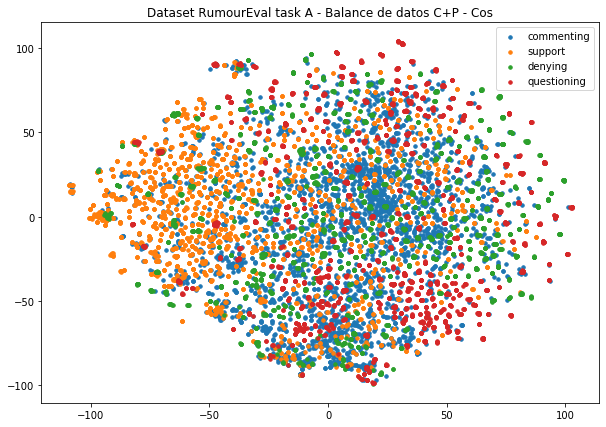

In [37]:
model = TSNE(2, metric='cosine')
to_plot_tsne = model.fit_transform(data_bas_cp)    
plt.figure(figsize=(10,7))
for key in keys:
    labels=[dict_cl[lab] for lab in macro_augmented[:,2]]
    mask = np.asarray(labels)==key
    plt.scatter(to_plot_tsne[:,0][mask],to_plot_tsne[:,1][mask], s=12, label=str(key))

plt.legend()
plt.title("Dataset RumourEval task A - Balance de datos C+P - Cos")
plt.show()

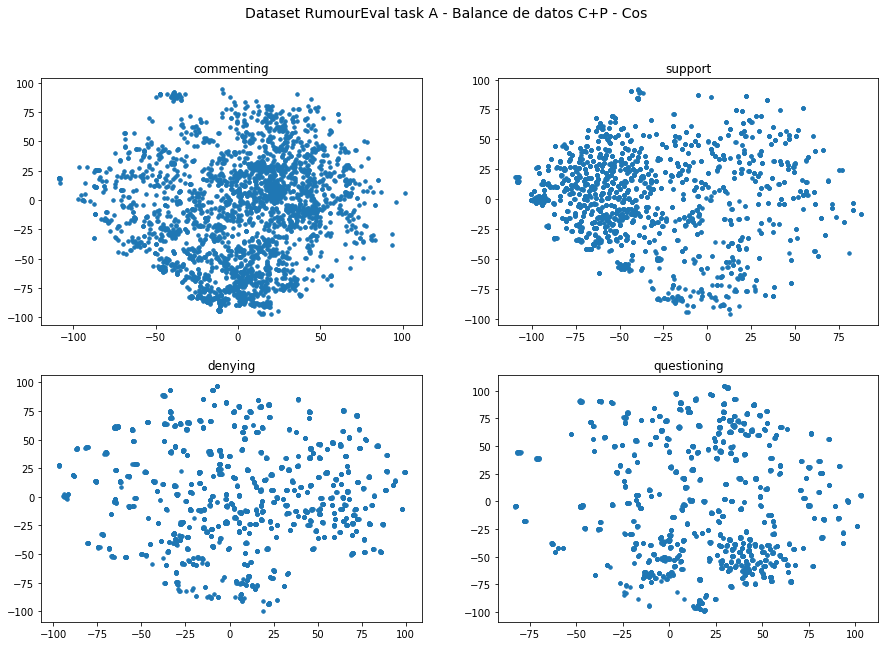

In [38]:
fig = plt.figure(figsize=(15,10))
j=220
for key in keys:
    labels=[dict_cl[lab] for lab in macro_augmented[:,2]]
    mask = np.asarray(labels)==key
    j+=1
    h=fig.add_subplot(j)
    plt.scatter(to_plot_tsne[:,0][mask],to_plot_tsne[:,1][mask], s=12, label=str(key))
    h.title.set_text(str(key))

fig.suptitle("Dataset RumourEval task A - Balance de datos C+P - Cos", fontsize=14)
plt.show()


In [39]:
np.random.shuffle(macro_augmented)
np.save('../Datasets/CSV_Stance/balance_clase_Pon.npy', macro_augmented)
    

### Sujeto a Embedding BERT sin ponderación target

In [40]:
macro_augmented=[]
for clase in aum_weight:
    start_time=time.time()
    print ("\n\nGenerando", aum_weight[clase], "ejemplos para", clase)
    muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, BERT=True)
    macro_augmented+=muestras
    print ("Resumen de modificaciones:", dict_aumentos)
    elapsed_time= time.time() - start_time
    print ("Este proceso tomó", elapsed_time, "seg")   



Generando 2404 ejemplos para questioning
Consultando por la clase questioning
Entrega label 2
Original: being  	Reemplazo:  [('saying', 0.7684832811355591)]
Sentencia original:
['user' 'user' 'any' 'chance' 'that' "'" 's' 'being' 'said' 'for' 'fear'
 'of' 'retribution' '?']
Sentencia final: 2
['user', 'user', 'any', 'chance', 'that', "'", 's', 'saying', 'said', 'for', 'fear', 'of', 'retribution', '?']


Original: get  	Reemplazo:  [('obtain', 0.7999216914176941)]
Original: make  	Reemplazo:  [('take', 1.1583632230758667)]
Sentencia original:
['user' 'user' 'user' 'user' 'ah' 'true' '.' 'problem' 'now' 'is' 'we' "'"
 'll' 'probably' 'only' 'get' 'coroner' "'" 's' 'details' 'they' 'won' "'"
 't' 'make' 'it' '.']
Sentencia final: 2
['user', 'user', 'user', 'user', 'ah', 'true', '.', 'problem', 'now', 'is', 'we', "'", 'll', 'probably', 'only', 'obtain', 'coroner', "'", 's', 'details', 'they', 'won', "'", 't', 'take', 'it', '.']


Original: hi  	Reemplazo:  [('hello', 2.0974652767181396)]

Original: source  	Reemplazo:  [('home', 1.1994084119796753)]
Sentencia original:
['user' 'source' 'plz' ':']
Sentencia final: 2
['user', 'home', 'plz', ':']


Original: re  	Reemplazo:  [('assertion', 0.8988488912582397)]
Sentencia original:
['user' 'user' 'user' 'so' 'they' "'" 're' 'claiming' 'a' 'black' 'cop'
 'killed' 'hashtag' '?' '?']
Sentencia final: 2
['user', 'user', 'user', 'so', 'they', "'", 'assertion', 'claiming', 'a', 'black', 'cop', 'killed', 'hashtag', '?', '?']


Original: scared  	Reemplazo:  [('frightened', 1.0517783164978027)]
Original: place  	Reemplazo:  [('spot', 3.346874475479126)]
Sentencia original:
['user' 'user' 'user' 'or' 'maybe' 'the' 'police' 'scared' 'him' 'into'
 'saying' 'it' 'was' 'michael' 'brown' 'in' 'the' 'first' 'place' '?']
Sentencia final: 2
['user', 'user', 'user', 'or', 'maybe', 'the', 'police', 'frightened', 'him', 'into', 'saying', 'it', 'was', 'michael', 'brown', 'in', 'the', 'first', 'spot', '?']


Original: s  	Reemplazo:  [('cold', 1.

Original: isn  	Reemplazo:  [('wasn', 0.5905872583389282)]
Sentencia original:
['user' 'isn' "'" 't' 'it' 'etiquette' 'to' 'remove' 'names' 'from' 'a'
 'press' 'release' '?']
Sentencia final: 2
['user', 'wasn', "'", 't', 'it', 'etiquette', 'to', 'remove', 'names', 'from', 'a', 'press', 'release', '?']


Original: video  	Reemplazo:  [('state', 1.8330005407333374)]
Sentencia original:
['user' 'user' 'where' 'is' 'the' 'video' 'from' 'the' 'cellphone' 'taken'
 'from' 'one' 'of' 'the' 'witnesses' 'who' 'saw' 'brown' 'shot' 'and'
 'killed' '?']
Sentencia final: 2
['user', 'user', 'where', 'is', 'the', 'state', 'from', 'the', 'cellphone', 'taken', 'from', 'one', 'of', 'the', 'witnesses', 'who', 'saw', 'brown', 'shot', 'and', 'killed', '?']


Original: come  	Reemplazo:  [('go', 1.2680798768997192)]
Original: unarmed  	Reemplazo:  [('incapable', 1.3577390909194946)]
Sentencia original:
['user' 'user' 'user' 'user' 'dude' ',' 'come' 'on' '.' 'this' 'rogue'
 'cop' 'apparently' 'thought' 'he' '

Original: declare  	Reemplazo:  [('seventeenth', 0.2609063386917114)]
Original: cops  	Reemplazo:  [('seasons', 1.5210626125335693)]
Sentencia original:
['user' 'user' 'user' 'user' 'to' 'have' 'the' 'supreme' 'court' 'declare'
 'open' 'season' 'for' 'cops' 'on' 'the' 'population' 'is' 'a'
 'deliberate' 'decision' '.']
Sentencia final: 2
['user', 'user', 'user', 'user', 'to', 'utilize', 'the', 'supreme', 'court', 'seventeenth', 'open', 'season', 'for', 'seasons', 'on', 'the', 'population', 'is', 'a', 'deliberate', 'decision', '.']


Original: struggle  	Reemplazo:  [('battling', 0.7918965816497803)]
Sentencia original:
['user' 'user' '-' 'is' 'it' 'true' 'there' 'was' 'a' 'struggle' 'in'
 'the' 'squad' 'car' ',' 'before' 'shooting' '?']
Sentencia final: 2
['user', 'user', '-', 'is', 'it', 'true', 'there', 'was', 'a', 'battling', 'in', 'the', 'squad', 'car', ',', 'before', 'shooting', '?']


Original: pic  	Reemplazo:  [('mcc', 2.282667875289917)]
Sentencia original:
['user' 'is' 'that'

Original: got  	Reemplazo:  [('stopped', 0.6154941320419312)]
Sentencia original:
['user' 'user' 'it' 'wasn' "'" 't' 'the' 'quik' 'stop' 'that' 'got'
 'burned' 'down' '?']
Sentencia final: 2
['user', 'user', 'it', 'wasn', "'", 't', 'the', 'quik', 'stop', 'that', 'stopped', 'burned', 'down', '?']


Original: convenient  	Reemplazo:  [('pisa', 0.47695034742355347)]
Original: witnesses  	Reemplazo:  [('calls', 0.5090038776397705)]
Sentencia original:
['user' 'user' 'shit' 'not' 'adding' 'up' '.' 'what' 'convenient' 'store'
 'was' 'robbed' '?' 'who' 'are' 'the' 'witnesses' 'that' 'called' 'it'
 'in' '?']
Sentencia final: 2
['user', 'user', 'shit', 'not', 'adding', 'up', '.', 'what', 'pisa', 'store', 'was', 'robbed', '?', 'who', 'are', 'the', 'calls', 'that', 'called', 'it', 'in', '?']


Original: flag  	Reemplazo:  [('banner', 0.8171325325965881)]
Original: talking  	Reemplazo:  [('chatting', 0.5107682943344116)]
Sentencia original:
['user' 'user' 'have' 'you' 'actually' 'confirmed' 'its' 

Original: i  	Reemplazo:  [('consume', 0.78650963306427)]
Original: say  	Reemplazo:  [('emphasize', 0.8646643161773682)]
Sentencia original:
['user' 'i' 'hate' 'to' 'say' 'that' 'but' 'maybe' 'we' 'should' 'let'
 'assad' 'finish' 'the' 'job' 'over' 'there']
Sentencia final: 2
['user', 'consume', 'hate', 'to', 'emphasize', 'that', 'but', 'maybe', 'we', 'should', 'let', 'assad', 'finish', 'the', 'job', 'over', 'there']


Original: is  	Reemplazo:  [('expects', 0.3104107081890106)]
Sentencia original:
['wait' ',' 'does' "'" 'higher' 'rate' "'" 'mean' 'what' 'user' 'is'
 'paying' 'drivers' '?' 'hashtag']
Sentencia final: 2
['wait', ',', 'does', "'", 'higher', 'rate', "'", 'mean', 'what', 'user', 'expects', 'paying', 'drivers', '?', 'hashtag']


Original: motive  	Reemplazo:  [('man', 1.0984286069869995)]
Original: is  	Reemplazo:  [('continues', 0.4488794803619385)]
Original: world  	Reemplazo:  [('thirteenth', 0.5388113856315613)]
Sentencia original:
['user' 'really' '?' 'the' 'motive' '

Original: don  	Reemplazo:  [('didn', 1.2254478931427002)]
Original: consider  	Reemplazo:  [('know', 0.742624044418335)]
Sentencia original:
['user' 'user' 'western' 'countries' 'have' 'killed' 'more' 'innocent'
 'children' 'than' 'hitler' 'assmunch' '.' 'but' 'you' 'prob' 'don' "'"
 't' 'consider' 'that' 'terror' '?' '?']
Sentencia final: 2
['user', 'user', 'western', 'northwards', 'have', 'killed', 'more', 'innocent', 'children', 'than', 'hitler', 'assmunch', '.', 'but', 'you', 'prob', 'didn', "'", 't', 'know', 'that', 'terror', '?', '?']


Original: robbery  	Reemplazo:  [('set', 3.2973225116729736)]
Sentencia original:
['user' 'initially' ',' 'but' 'found' 'out' 'about' 'the' 'robbery'
 'during' 'the' 'altercation']
Sentencia final: 2
['user', 'initially', ',', 'but', 'found', 'out', 'about', 'the', 'set', 'during', 'the', 'altercation']


Original: cartoons  	Reemplazo:  [('shrines', 0.6269499659538269)]
Original: values  	Reemplazo:  [('denominations', 1.0104650259017944)]
Sente

Original: interview  	Reemplazo:  [('interviewed', 0.5896764993667603)]
Sentencia original:
['user' 'how' 'many' 'weeks' 'until' 'police' 'interview' 'witnesses' '?'
 'user']
Sentencia final: 2
['user', 'how', 'many', 'weeks', 'until', 'police', 'interviewed', 'witnesses', '?', 'user']


Original: relay  	Reemplazo:  [('fifth', 0.7830134630203247)]
Sentencia original:
['user' 'user' 'user' 'kudos' 'to' 'your' 'relay' 'of' 'second' '-' 'hand'
 'information' '!' 'do' 'you' 'have' 'an' 'app' '?']
Sentencia final: 2
['user', 'user', 'user', 'kudos', 'to', 'your', 'fifth', 'of', 'second', '-', 'hand', 'information', '!', 'do', 'you', 'have', 'an', 'app', '?']


Original: world  	Reemplazo:  [('include', 0.7070391178131104)]
Original: problem  	Reemplazo:  [('need', 1.3413878679275513)]
Original: explain  	Reemplazo:  [('break', 1.0903981924057007)]
Sentencia original:
['user' 'user' 'jet' 'so' 'many' 'muslims' 'around' 'the' 'world' 'are'
 'a' 'problem' 'how' 'do' 'you' 'explain' 'that' '?'

Original: irrelevant  	Reemplazo:  [('aback', 3.0658819675445557)]
Sentencia original:
['user' 'user' 'you' 'thought' 'of' 'that' 'all' 'by' 'yourself' '?' '?'
 '?' 'amazingly' 'irrelevant' '!' '!' '!']
Sentencia final: 2
['user', 'user', 'you', 'thought', 'of', 'that', 'all', 'by', 'yourself', '?', '?', '?', 'amazingly', 'aback', '!', '!', '!']


Original: know  	Reemplazo:  [('say', 0.8193907141685486)]
Original: s  	Reemplazo:  [('rs', 1.2233970165252686)]
Original: flag  	Reemplazo:  [('banner', 0.7429670095443726)]
Sentencia original:
['user' 'user' 'sorry' '-' 'how' 'do' 'you' 'know' 'it' "'" 's' 'an'
 'isis' 'flag' '?' 'can' 'you' 'actually' 'confirm' 'that' '?']
Sentencia final: 2
['user', 'user', 'sorry', '-', 'how', 'do', 'you', 'say', 'it', "'", 'rs', 'an', 'isis', 'banner', '?', 'can', 'you', 'actually', 'confirm', 'that', '?']


Original: looks  	Reemplazo:  [('glances', 0.7407649159431458)]
Original: picture  	Reemplazo:  [('painting', 0.7244535684585571)]
Sentencia origi

Original: prefer  	Reemplazo:  [('title', 2.032182216644287)]
Original: michael  	Reemplazo:  [('frank', 1.2099947929382324)]
Original: was  	Reemplazo:  [('did', 0.9537184834480286)]
Original: done  	Reemplazo:  [('been', 0.5038508176803589)]
Original: m  	Reemplazo:  [('m2', 0.8015226721763611)]
Original: be  	Reemplazo:  [('get', 0.7394495010375977)]
Original: attacker  	Reemplazo:  [('assertion', 0.580622136592865)]
Original: police  	Reemplazo:  [('numbers', 0.9590012431144714)]
Original: escape  	Reemplazo:  [('breakout', 0.4922671914100647)]
Original: cafe  	Reemplazo:  [('cafes', 0.5179711580276489)]
Original: id  	Reemplazo:  [('identification', 1.3290389776229858)]
Original: photo  	Reemplazo:  [('picture', 2.3240058422088623)]
Original: hair  	Reemplazo:  [('resultant', 0.30363354086875916)]
Original: blonde  	Reemplazo:  [('lumpur', 1.9832381010055542)]
Original: name  	Reemplazo:  [('surname', 0.8175755739212036)]
Original: hi  	Reemplazo:  [('paul', 0.8295412063598633)]
O

Original: report  	Reemplazo:  [('reporting', 1.1456665992736816)]
Original: number  	Reemplazo:  [('variety', 1.343599557876587)]
Original: ottawa  	Reemplazo:  [('stayed', 3.9139819145202637)]
Original: danger  	Reemplazo:  [('depart', 0.566620409488678)]
Original: shows  	Reemplazo:  [('misses', 0.772030234336853)]
Original: s  	Reemplazo:  [('doesn', 1.1796233654022217)]
Original: flag  	Reemplazo:  [('cobra', 0.8365963697433472)]
Original: canada  	Reemplazo:  [('canadian', 2.284759283065796)]
Original: getting  	Reemplazo:  [('stating', 0.9221283793449402)]
Original: d  	Reemplazo:  [('ve', 0.5154696106910706)]
Original: correct  	Reemplazo:  [('incorrect', 0.536521315574646)]
Original: officer  	Reemplazo:  [('don', 2.0568838119506836)]
Original: brown  	Reemplazo:  [('halt', 0.5350651144981384)]
Original: are  	Reemplazo:  [('am', 1.1335089206695557)]
Original: is  	Reemplazo:  [('has', 0.847048819065094)]
Original: running  	Reemplazo:  [('limiting', 1.9706588983535767)]
Origi

Original: god  	Reemplazo:  [('goodness', 0.8320726156234741)]
Original: toronto  	Reemplazo:  [('zealand', 1.992443323135376)]
Original: alive  	Reemplazo:  [('aware', 1.3423110246658325)]
Original: didn  	Reemplazo:  [('doesn', 0.8769262433052063)]
Original: hair  	Reemplazo:  [('resultant', 0.30363354086875916)]
Original: dead  	Reemplazo:  [('alive', 1.2052249908447266)]
Original: going  	Reemplazo:  [('being', 2.1442368030548096)]
Original: agenda  	Reemplazo:  [('goalscorer', 1.297000527381897)]
Original: s  	Reemplazo:  [('living', 0.7246707081794739)]
Original: were  	Reemplazo:  [('was', 0.48433759808540344)]
Original: known  	Reemplazo:  [('seen', 1.1587613821029663)]
Original: do  	Reemplazo:  [('go', 0.7336174845695496)]
Original: i  	Reemplazo:  [('ii', 0.7476935982704163)]
Original: flip  	Reemplazo:  [('izzy', 1.3119748830795288)]
Original: shit  	Reemplazo:  [('programmer', 0.38684937357902527)]
Original: is  	Reemplazo:  [('has', 0.6919954419136047)]
Original: muhammad

Original: today  	Reemplazo:  [('tonight', 0.42914050817489624)]
Original: robbery  	Reemplazo:  [('show', 1.554734706878662)]
Original: thanks  	Reemplazo:  [('marks', 0.5133122801780701)]
Original: stay  	Reemplazo:  [('stayed', 0.9271305203437805)]
Original: irrelevant  	Reemplazo:  [('crambidae', 2.1892762184143066)]
Original: s  	Reemplazo:  [('time', 0.645027220249176)]
Original: right  	Reemplazo:  [('look', 1.28565514087677)]
Original: okay  	Reemplazo:  [('programmer', 0.6720761060714722)]
Original: happening  	Reemplazo:  [('being', 0.4492744207382202)]
Original: getting  	Reemplazo:  [('implementing', 0.6580732464790344)]
Original: word  	Reemplazo:  [('term', 1.288021445274353)]
Original: please  	Reemplazo:  [('told', 3.1905386447906494)]
Original: explosives  	Reemplazo:  [('worries', 1.0255801677703857)]
Original: causing  	Reemplazo:  [('allowing', 1.3325347900390625)]
Original: max  	Reemplazo:  [('use', 0.7067860960960388)]
Original: is  	Reemplazo:  [('has', 0.772957

Original: are  	Reemplazo:  [('am', 0.7236608266830444)]
Original: present  	Reemplazo:  [('shoot', 0.5422013998031616)]
Original: escape  	Reemplazo:  [('breakout', 0.4922671914100647)]
Original: please  	Reemplazo:  [('create', 0.7278239727020264)]
Original: happening  	Reemplazo:  [('occurring', 0.8369331359863281)]
Original: stories  	Reemplazo:  [('writes', 0.7087044715881348)]
Original: u  	Reemplazo:  [('gamer', 0.8055223822593689)]
Original: killed  	Reemplazo:  [('assassinated', 0.5611385703086853)]
Original: laws  	Reemplazo:  [('wickets', 1.7353042364120483)]
Original: force  	Reemplazo:  [('use', 2.3863563537597656)]
Original: s  	Reemplazo:  [('policy', 0.7210317254066467)]
Original: people  	Reemplazo:  [('men', 2.0031065940856934)]
Original: hostage  	Reemplazo:  [('captive', 1.2733982801437378)]
Original: accuse  	Reemplazo:  [('accusation', 1.2799354791641235)]
Original: killed  	Reemplazo:  [('murdered', 2.1259472370147705)]
Original: point  	Reemplazo:  [('brought', 

Original: does  	Reemplazo:  [('intends', 0.7489184737205505)]
Original: number  	Reemplazo:  [('card', 0.783932626247406)]
Original: number  	Reemplazo:  [('amount', 0.7269119024276733)]
Original: thanks  	Reemplazo:  [('marks', 0.5133122801780701)]
Original: good  	Reemplazo:  [('great', 2.0553207397460938)]
Original: abc  	Reemplazo:  [('heart', 1.1598159074783325)]
Original: sure  	Reemplazo:  [('batsman', 1.0195871591567993)]
Original: sorry  	Reemplazo:  [('lumpur', 1.4406472444534302)]
Original: canada  	Reemplazo:  [('canadian', 1.3390696048736572)]
Original: tell  	Reemplazo:  [('told', 0.8605446219444275)]
Original: ferguson  	Reemplazo:  [('policeman', 0.5660991072654724)]
Original: thank  	Reemplazo:  [('deity', 0.5177826881408691)]
Original: harm  	Reemplazo:  [('anybody', 0.7076929211616516)]
Original: max  	Reemplazo:  [('use', 0.7067860960960388)]
Original: are  	Reemplazo:  [('am', 0.2637985646724701)]
Original: police  	Reemplazo:  [('people', 0.7340218424797058)]
Ori

Original: t  	Reemplazo:  [('bo', 1.2513285875320435)]
Original: do  	Reemplazo:  [('be', 0.7833254933357239)]
Original: hat  	Reemplazo:  [('reading', 2.0299649238586426)]
Original: flip  	Reemplazo:  [('izzy', 1.3119748830795288)]
Original: find  	Reemplazo:  [('see', 1.2232387065887451)]
Original: flag  	Reemplazo:  [('include', 1.071731448173523)]
Original: talking  	Reemplazo:  [('chatting', 0.7136800289154053)]
Original: t  	Reemplazo:  [('urdu', 0.8472839593887329)]
Original: god  	Reemplazo:  [('islam', 1.0521265268325806)]
Original: god  	Reemplazo:  [('christ', 1.173834204673767)]
Original: hostages  	Reemplazo:  [('numbers', 0.8609739542007446)]
Original: —  	Reemplazo:  [('freyja', 0.830102264881134)]
Original: hostage  	Reemplazo:  [('xml', 0.7018693685531616)]
Original: provide  	Reemplazo:  [('found', 1.8130675554275513)]
Original: info  	Reemplazo:  [('inter', 0.8005489110946655)]
Original: shooting  	Reemplazo:  [('doing', 0.5590513348579407)]
Original: happen  	Reempl

Original: context  	Reemplazo:  [('time', 1.8504395484924316)]
Original: crime  	Reemplazo:  [('passionate', 0.6361660957336426)]
Original: was  	Reemplazo:  [('were', 0.4812619090080261)]
Original: similar  	Reemplazo:  [('comparable', 0.48340052366256714)]
Original: makes  	Reemplazo:  [('believes', 0.8497430682182312)]
Original: level  	Reemplazo:  [('tier', 0.7809801697731018)]
Original: terrorism  	Reemplazo:  [('tier', 1.3230429887771606)]
Original: claiming  	Reemplazo:  [('asserting', 0.793016791343689)]
Original: place  	Reemplazo:  [('time', 1.980301022529602)]
Original: safe  	Reemplazo:  [('unsafe', 0.680967390537262)]
Original: is  	Reemplazo:  [('has', 0.7565414309501648)]
Original: police  	Reemplazo:  [('numbers', 1.7013493776321411)]
Original: hostages  	Reemplazo:  [('confirms', 0.4564213752746582)]
Original: number  	Reemplazo:  [('quantity', 0.4792667627334595)]
Original: witness  	Reemplazo:  [('niece', 0.9424989819526672)]
Original: way  	Reemplazo:  [('end', 1.19

Original: hat  	Reemplazo:  [('set', 2.108854293823242)]
Original: stop  	Reemplazo:  [('left', 1.1130541563034058)]
Original: was  	Reemplazo:  [('secluded', 0.36381736397743225)]
Original: robbed  	Reemplazo:  [('bookstore', 0.7861296534538269)]
Original: are  	Reemplazo:  [('am', 0.44073784351348877)]
Original: isn  	Reemplazo:  [('wasn', 0.9048860669136047)]
Original: god  	Reemplazo:  [('deity', 0.6045013666152954)]
Original: be  	Reemplazo:  [('do', 0.8220292925834656)]
Original: god  	Reemplazo:  [('man', 1.2094300985336304)]
Original: cafe  	Reemplazo:  [('seduction', 0.31687915325164795)]
Original: updates  	Reemplazo:  [('users', 0.9460761547088623)]
Original: right  	Reemplazo:  [('left', 1.2780470848083496)]
Original: people  	Reemplazo:  [('men', 0.8120354413986206)]
Original: involved  	Reemplazo:  [('used', 0.7376911640167236)]
Original: shooting  	Reemplazo:  [('executing', 0.3315957486629486)]
Original: investigation  	Reemplazo:  [('indictment', 0.9056960940361023)]
O

Original: matter  	Reemplazo:  [('minute', 0.8350863456726074)]
Original: stupid  	Reemplazo:  [('similar', 2.124253749847412)]
Original: facts  	Reemplazo:  [('experts', 1.1686747074127197)]
Original: need  	Reemplazo:  [('await', 0.5049293041229248)]
Original: ah  	Reemplazo:  [('oh', 0.7528705596923828)]
Original: true  	Reemplazo:  [('problematic', 0.6988261938095093)]
Original: s  	Reemplazo:  [('intricate', 0.6104945540428162)]
Original: details  	Reemplazo:  [('people', 0.6740504503250122)]
Original: won  	Reemplazo:  [('rouen', 0.5122336149215698)]
Original: t  	Reemplazo:  [('win', 0.4989922344684601)]
Original: person  	Reemplazo:  [('become', 0.7968628406524658)]
Original: able  	Reemplazo:  [('unable', 0.5349482297897339)]
Original: suspects  	Reemplazo:  [('weren', 1.3334413766860962)]
Original: giving  	Reemplazo:  [('letting', 1.5222076177597046)]
Original: is  	Reemplazo:  [('represents', 1.305759310722351)]
Original: present  	Reemplazo:  [('use', 0.33759233355522156)]

Original: shit  	Reemplazo:  [('crap', 0.9851999282836914)]
Original: isis  	Reemplazo:  [('mascot', 1.4331425428390503)]
Original: allah  	Reemplazo:  [('death', 3.1871230602264404)]
Original: is  	Reemplazo:  [('expects', 0.4389655590057373)]
Original: shooting  	Reemplazo:  [('presenting', 1.0976463556289673)]
Original: surge  	Reemplazo:  [('resurgence', 0.7911585569381714)]
Original: please  	Reemplazo:  [('accommodate', 0.8855453729629517)]
Original: people  	Reemplazo:  [('men', 1.4753469228744507)]
Original: involved  	Reemplazo:  [('been', 0.736528754234314)]
Original: info  	Reemplazo:  [('snuck', 0.976111888885498)]
Original: coming  	Reemplazo:  [('mixing', 0.6042896509170532)]
Original: prison  	Reemplazo:  [('limitation', 0.40601810812950134)]
Original: op  	Reemplazo:  [('investigate', 0.6011484265327454)]
Original: doesn  	Reemplazo:  [('xml', 0.5974019169807434)]
Original: need  	Reemplazo:  [('necessity', 0.5181052088737488)]
Original: r  	Reemplazo:  [('ar', 1.170714

Original: running  	Reemplazo:  [('limiting', 1.9706588983535767)]
Original: harm  	Reemplazo:  [('anybody', 0.7076929211616516)]
Original: max  	Reemplazo:  [('use', 0.7067860960960388)]
Original: cc  	Reemplazo:  [('utilization', 0.5528620481491089)]
Original: context  	Reemplazo:  [('time', 1.8504395484924316)]
Original: shooting  	Reemplazo:  [('firing', 1.7683500051498413)]
Original: trying  	Reemplazo:  [('attempting', 1.0329352617263794)]
Original: i  	Reemplazo:  [('sound', 1.905057430267334)]
Original: incident  	Reemplazo:  [('background', 1.192339301109314)]
Original: past  	Reemplazo:  [('tuesday', 1.7535165548324585)]
Original: claiming  	Reemplazo:  [('using', 0.6957024931907654)]
Original: unarmed  	Reemplazo:  [('live', 1.1330550909042358)]
Original: is  	Reemplazo:  [('has', 1.2280226945877075)]
Original: cafe  	Reemplazo:  [('coffee', 1.293474555015564)]
Original: s  	Reemplazo:  [('sd', 0.8300948739051819)]
Original: are  	Reemplazo:  [('am', 0.610916018486023)]
Orig

Original: guy  	Reemplazo:  [('asshole', 0.47835662961006165)]
Original: cops  	Reemplazo:  [('uses', 0.8655877113342285)]
Original: cool  	Reemplazo:  [('warm', 1.212127923965454)]
Original: days  	Reemplazo:  [('weeks', 1.3362417221069336)]
Original: t  	Reemplazo:  [('couldn', 0.8814812302589417)]
Original: please  	Reemplazo:  [('identification', 1.455774188041687)]
Original: isil  	Reemplazo:  [('accomplish', 0.9161199927330017)]
Original: dropping  	Reemplazo:  [('relocating', 0.48808252811431885)]
Original: was  	Reemplazo:  [('had', 0.4700091779232025)]
Original: say  	Reemplazo:  [('emphasize', 0.9366658329963684)]
Original: pictures  	Reemplazo:  [('photos', 1.0679298639297485)]
Original: someone  	Reemplazo:  [('doesn', 0.8501763939857483)]
Original: picture  	Reemplazo:  [('photo', 2.30546498298645)]
Original: walking  	Reemplazo:  [('shrinking', 0.32305967807769775)]
Original: were  	Reemplazo:  [('was', 0.8188801407814026)]
Original: s  	Reemplazo:  [('genuine', 0.7480958

Original: building  	Reemplazo:  [('build', 3.698633909225464)]
Original: stupidity  	Reemplazo:  [('splendid', 0.49483585357666016)]
Original: i  	Reemplazo:  [('borrowing', 0.7582733035087585)]
Original: mike  	Reemplazo:  [('call', 1.3641242980957031)]
Original: says  	Reemplazo:  [('intends', 0.47574272751808167)]
Original: got  	Reemplazo:  [('was', 1.211301326751709)]
Original: i  	Reemplazo:  [('ii', 1.2354816198349)]
Original: have  	Reemplazo:  [('utilize', 0.4990946054458618)]
Original: expect  	Reemplazo:  [('assume', 0.5472229719161987)]
Original: tell  	Reemplazo:  [('told', 2.1440236568450928)]
Original: are  	Reemplazo:  [('am', 1.7942190170288086)]
Original: officer  	Reemplazo:  [('beige', 0.4492366909980774)]
Original: was  	Reemplazo:  [('were', 0.816656231880188)]
Original: is  	Reemplazo:  [('has', 0.7374957203865051)]
Original: media  	Reemplazo:  [('asks', 0.43596941232681274)]
Original: chief  	Reemplazo:  [('principal', 0.7475852370262146)]
Original: person  	R

Original: ll  	Reemplazo:  [('lumpur', 1.2615240812301636)]
Original: take  	Reemplazo:  [('assume', 0.8108477592468262)]
Original: pants  	Reemplazo:  [('trousers', 0.6223533749580383)]
Original: is  	Reemplazo:  [('has', 1.4368069171905518)]
Original: angus  	Reemplazo:  [('lumpur', 2.4012718200683594)]
Original: said  	Reemplazo:  [('replied', 0.8613230586051941)]
Original: heard  	Reemplazo:  [('customer', 0.9956309199333191)]
Original: number  	Reemplazo:  [('part', 3.3131229877471924)]
Original: showing  	Reemplazo:  [('displaying', 0.5523741245269775)]
Original: pictures  	Reemplazo:  [('videos', 0.5685015320777893)]
Original: confirm  	Reemplazo:  [('king', 1.220529317855835)]
Original: make  	Reemplazo:  [('give', 0.7417728900909424)]
Original: fuck  	Reemplazo:  [('beat', 0.8835278153419495)]
Original: number  	Reemplazo:  [('name', 0.7530115246772766)]
Original: tell  	Reemplazo:  [('told', 1.2900564670562744)]
Original: world  	Reemplazo:  [('country', 1.254643440246582)]
O

Original: call  	Reemplazo:  [('caller', 0.5858122110366821)]
Original: happen  	Reemplazo:  [('succeed', 1.123569130897522)]
Original: media  	Reemplazo:  [('looks', 0.7705902457237244)]
Original: be  	Reemplazo:  [('participate', 1.8261128664016724)]
Original: def  	Reemplazo:  [('aback', 2.926520347595215)]
Original: thoughts  	Reemplazo:  [('doubts', 0.8125640749931335)]
Original: dad  	Reemplazo:  [('baseman', 2.2694766521453857)]
Original: gunshot  	Reemplazo:  [('customer', 1.358846664428711)]
Original: website  	Reemplazo:  [('blog', 0.8270534873008728)]
Original: speak  	Reemplazo:  [('spoke', 0.8214930295944214)]
Original: evil  	Reemplazo:  [('spoke', 1.3343043327331543)]
Original: sydney  	Reemplazo:  [('city', 0.5002016425132751)]
Original: way  	Reemplazo:  [('right', 1.2986767292022705)]
Original: is  	Reemplazo:  [('has', 0.7503887414932251)]
Original: easy  	Reemplazo:  [('rican', 1.4234598875045776)]
Original: many  	Reemplazo:  [('other', 0.5628034472465515)]
Origina

Original: innocent  	Reemplazo:  [('child', 0.8821094632148743)]
Original: robbery  	Reemplazo:  [('robbed', 1.3282470703125)]
Original: believe  	Reemplazo:  [('realize', 1.9891055822372437)]
Original: proof  	Reemplazo:  [('photograph', 0.9041895270347595)]
Original: i  	Reemplazo:  [('mystery', 1.3282109498977661)]
Original: wonder  	Reemplazo:  [('foreigner', 0.3528612554073334)]
Original: other  	Reemplazo:  [('various', 0.4633040428161621)]
Original: help  	Reemplazo:  [('assistance', 0.5393257737159729)]
Original: is  	Reemplazo:  [('has', 0.46745577454566956)]
Original: cop  	Reemplazo:  [('man', 1.1479724645614624)]
Original: praying  	Reemplazo:  [('hoping', 1.6253753900527954)]
Original: saying  	Reemplazo:  [('asserting', 0.2912319302558899)]
Original: police  	Reemplazo:  [('media', 1.1065443754196167)]
Original: people  	Reemplazo:  [('men', 1.3222072124481201)]
Original: made  	Reemplazo:  [('done', 3.052539587020874)]
Original: hours  	Reemplazo:  [('numbers', 0.9295531

Original: kid  	Reemplazo:  [('guy', 1.9274238348007202)]
Original: i  	Reemplazo:  [('ii', 1.2522021532058716)]
Original: walking  	Reemplazo:  [('crawling', 1.165503978729248)]
Original: closer  	Reemplazo:  [('crambidae', 2.8995449542999268)]
Original: many  	Reemplazo:  [('several', 1.2907987833023071)]
Original: media  	Reemplazo:  [('looks', 0.5332220792770386)]
Original: muslims  	Reemplazo:  [('mosques', 0.6642418503761292)]
Original: report  	Reemplazo:  [('work', 2.0366246700286865)]
Original: see  	Reemplazo:  [('say', 0.8101329803466797)]
Original: have  	Reemplazo:  [('get', 0.778866708278656)]
Original: was  	Reemplazo:  [('were', 0.5274978280067444)]
Original: red  	Reemplazo:  [('simulated', 0.7814204692840576)]
Original: crisis  	Reemplazo:  [('kidnapping', 0.5032364726066589)]
Original: was  	Reemplazo:  [('wrote', 1.948196291923523)]
Original: killed  	Reemplazo:  [('murdered', 0.4783604145050049)]
Original: people  	Reemplazo:  [('men', 1.5631169080734253)]
Original

Original: violence  	Reemplazo:  [('violent', 0.9211044311523438)]
Original: sarcastic  	Reemplazo:  [('continual', 0.4876687228679657)]
Original: running  	Reemplazo:  [('being', 2.3946611881256104)]
Original: report  	Reemplazo:  [('affair', 1.3607187271118164)]
Original: value  	Reemplazo:  [('raise', 0.8177452683448792)]
Original: please  	Reemplazo:  [('facebook', 0.7193114161491394)]
Original: explain  	Reemplazo:  [('explanation', 0.8304557204246521)]
Original: time  	Reemplazo:  [('work', 1.882865309715271)]
Original: right  	Reemplazo:  [('left', 0.8015519380569458)]
Original: authority  	Reemplazo:  [('figure', 0.812440812587738)]
Original: gun  	Reemplazo:  [('suspect', 1.298521637916565)]
Original: has  	Reemplazo:  [('provides', 0.38143450021743774)]
Original: i  	Reemplazo:  [('lexie', 1.3751779794692993)]
Original: much  	Reemplazo:  [('considerable', 1.2343332767486572)]
Original: making  	Reemplazo:  [('being', 0.830862820148468)]
Original: relay  	Reemplazo:  [('fifth

Original: court  	Reemplazo:  [('announce', 0.3935452997684479)]
Original: population  	Reemplazo:  [('populace', 0.7303490042686462)]
Original: decision  	Reemplazo:  [('judgement', 0.8341870307922363)]
Original: true  	Reemplazo:  [('second', 0.7248818874359131)]
Original: brown  	Reemplazo:  [('blue', 1.2734203338623047)]
Original: bigger  	Reemplazo:  [('larger', 1.4782071113586426)]
Original: released  	Reemplazo:  [('published', 1.2696784734725952)]
Original: news  	Reemplazo:  [('broke', 0.8551373481750488)]
Original: police  	Reemplazo:  [('people', 0.4776994585990906)]
Original: running  	Reemplazo:  [('walking', 0.7242971062660217)]
Original: proven  	Reemplazo:  [('found', 2.1090006828308105)]
Original: i  	Reemplazo:  [('pisa', 0.4751955568790436)]
Original: haven  	Reemplazo:  [('don', 1.1931655406951904)]
Original: news  	Reemplazo:  [('hear', 0.5129690170288086)]
Original: police  	Reemplazo:  [('cops', 0.8062942624092102)]
Original: shot  	Reemplazo:  [('breuning', 3.16

Original: see  	Reemplazo:  [('expose', 0.44222232699394226)]
Original: proof  	Reemplazo:  [('photograph', 0.9041895270347595)]
Original: terrorist  	Reemplazo:  [('islamist', 0.3257243037223816)]
Original: help  	Reemplazo:  [('assistance', 0.505294144153595)]
Original: look  	Reemplazo:  [('set', 2.0945117473602295)]
Original: terrorist  	Reemplazo:  [('tourist', 1.1690411567687988)]
Original: is  	Reemplazo:  [('has', 1.26970636844635)]
Original: seems  	Reemplazo:  [('appears', 1.005901575088501)]
Original: t  	Reemplazo:  [('tn', 0.27974310517311096)]
Original: are  	Reemplazo:  [('am', 0.6438553929328918)]
Original: true  	Reemplazo:  [('real', 1.3053961992263794)]
Original: high  	Reemplazo:  [('low', 0.5246747136116028)]
Original: protesting  	Reemplazo:  [('facilitating', 0.6817994117736816)]
Original: mean  	Reemplazo:  [('meant', 1.288873314857483)]
Original: do  	Reemplazo:  [('improve', 0.8409051299095154)]
Original: thought  	Reemplazo:  [('time', 3.495681047439575)]
Ori

Original: investigation  	Reemplazo:  [('analysis', 0.8199617862701416)]
Original: friend  	Reemplazo:  [('adversary', 0.49373486638069153)]
Original: shot  	Reemplazo:  [('breuning', 3.1647512912750244)]
Original: sue  	Reemplazo:  [('show', 0.7781261801719666)]
Original: have  	Reemplazo:  [('do', 0.787872850894928)]
Original: shooting  	Reemplazo:  [('saying', 0.7897752523422241)]
Original: want  	Reemplazo:  [('fifteenth', 0.32650211453437805)]
Original: did  	Reemplazo:  [('had', 0.8658345341682434)]
Original: get  	Reemplazo:  [('do', 0.5904747247695923)]
Original: cbs  	Reemplazo:  [('nbc', 0.8361230492591858)]
Original: free  	Reemplazo:  [('other', 0.662340521812439)]
Original: don  	Reemplazo:  [('ii', 1.1983766555786133)]
Original: rumours  	Reemplazo:  [('gotten', 2.0885989665985107)]
Original: be  	Reemplazo:  [('have', 1.2259876728057861)]
Original: islam  	Reemplazo:  [('hinduism', 1.475119709968567)]
Original: s  	Reemplazo:  [('ll', 1.1226162910461426)]
Original: happe

Original: value  	Reemplazo:  [('raise', 0.8177452683448792)]
Original: i  	Reemplazo:  [('http', 2.3544116020202637)]
Original: s  	Reemplazo:  [('ideal', 0.7276599407196045)]
Original: available  	Reemplazo:  [('other', 0.4370383024215698)]
Original: mean  	Reemplazo:  [('nephew', 0.9306414723396301)]
Original: is  	Reemplazo:  [('expects', 0.33161696791648865)]
Original: rides  	Reemplazo:  [('pays', 0.8629379868507385)]
Original: have  	Reemplazo:  [('see', 1.3231101036071777)]
Original: world  	Reemplazo:  [('universe', 0.720231831073761)]
Original: get  	Reemplazo:  [('be', 0.4684879183769226)]
Original: gunmen  	Reemplazo:  [('pistols', 1.1536136865615845)]
Original: gotten  	Reemplazo:  [('explanations', 1.0184389352798462)]
Original: are  	Reemplazo:  [('am', 0.6820322275161743)]
Original: let  	Reemplazo:  [('disclose', 0.35125449299812317)]
Original: terrorist  	Reemplazo:  [('put', 1.39998197555542)]
Original: jail  	Reemplazo:  [('prison', 2.1565635204315186)]
Original: co

Original: walk  	Reemplazo:  [('truck', 0.46404770016670227)]
Original: utter  	Reemplazo:  [('parma', 0.6094033718109131)]
Original: is  	Reemplazo:  [('appears', 1.351994514465332)]
Original: consider  	Reemplazo:  [('be', 0.7818799614906311)]
Original: terrorist  	Reemplazo:  [('terrorism', 0.9699712991714478)]
Original: islam  	Reemplazo:  [('shia', 0.961044192314148)]
Original: are  	Reemplazo:  [('am', 0.6672585010528564)]
Original: many  	Reemplazo:  [('several', 0.8735967874526978)]
Original: killed  	Reemplazo:  [('murdered', 1.2766506671905518)]
Original: guy  	Reemplazo:  [('man', 1.2621417045593262)]
Original: real  	Reemplazo:  [('actual', 0.4516543745994568)]
Original: done  	Reemplazo:  [('performed', 0.8556445837020874)]
Original: i  	Reemplazo:  [('ii', 0.7476935982704163)]
Original: everyone  	Reemplazo:  [('everything', 1.473673939704895)]
Original: level  	Reemplazo:  [('baghdad', 0.8603240847587585)]
Original: sydney  	Reemplazo:  [('cafes', 0.4125881791114807)]
Or

Original: indicate  	Reemplazo:  [('jack', 1.2566016912460327)]
Original: comment  	Reemplazo:  [('remark', 1.15433931350708)]
Original: big  	Reemplazo:  [('good', 0.7807984352111816)]
Original: ll  	Reemplazo:  [('lumpur', 1.3760560750961304)]
Original: didn  	Reemplazo:  [('doesn', 1.529036283493042)]
Original: coroner  	Reemplazo:  [('cadiz', 0.5130646228790283)]
Original: s  	Reemplazo:  [('detail', 0.5120583176612854)]
Original: hostage  	Reemplazo:  [('become', 1.2655341625213623)]
Original: person  	Reemplazo:  [('become', 0.4566403329372406)]
Original: police  	Reemplazo:  [('people', 0.5051704049110413)]
Original: giving  	Reemplazo:  [('granting', 0.8187052607536316)]
Original: photo  	Reemplazo:  [('left', 1.1489790678024292)]
Original: are  	Reemplazo:  [('am', 0.7239659428596497)]
Original: source  	Reemplazo:  [('supplier', 0.8324576020240784)]
Original: uber  	Reemplazo:  [('fabio', 0.7893089056015015)]
Original: trips  	Reemplazo:  [('journeys', 0.8307008147239685)]
Or

Original: hole  	Reemplazo:  [('home', 1.1700706481933594)]
Original: north  	Reemplazo:  [('south', 0.9125052690505981)]
Sentencia original:
['“' 'user' ':' 'more' ':' 'official' ':' 'french' 'terror' 'suspects'
 'want' 'to' 'be' 'martyrs' ';' 'are' 'hole' 'up' 'with' 'hostage' 'north'
 'of' 'paris' ':' 'html']
Sentencia final: 0
['“', 'user', ':', 'more', ':', 'official', ':', 'unofficial', 'fear', 'suspects', 'want', 'to', 'be', 'martyrs', ';', 'are', 'home', 'up', 'with', 'hostage', 'south', 'of', 'paris', ':', 'html']


Original: are  	Reemplazo:  [('am', 0.41444090008735657)]
Original: don  	Reemplazo:  [('didn', 0.7877156138420105)]
Original: way  	Reemplazo:  [('time', 1.2310351133346558)]
Sentencia original:
['user' 'they' 'are' 'heroes' 'to' 'their' 'followers' 'no' 'matter'
 'what' '.' 'don' "'" 't' 'give' 'them' 'a' 'way' 'to' 'get' 'out'
 'instructions' 'to' 'trigger' 'future' 'attacks' '.']
Sentencia final: 0
['user', 'they', 'am', 'heroes', 'to', 'their', 'followers', 'n

Original: flip  	Reemplazo:  [('opposite', 1.184477686882019)]
Sentencia original:
['user' 'had' 'the' 'same' 'flip' 'flop' 'on' '.']
Sentencia final: 0
['user', 'had', 'the', 'same', 'opposite', 'flop', 'on', '.']


Original: including  	Reemplazo:  [('numbering', 0.5296465158462524)]
Original: paris  	Reemplazo:  [('shoot', 1.2736269235610962)]
Sentencia original:
['“' 'user' ':' 'hashtag' '-' 'number' 'dead' 'including' 'number'
 'police' 'in' 'paris' 'shooting' '.' 'photo' 'user' 'hashtag' 'html'
 'hashtag']
Sentencia final: 0
['“', 'user', ':', 'hashtag', '-', 'number', 'dead', 'numbering', 'number', 'police', 'in', 'shoot', 'shooting', '.', 'photo', 'user', 'hashtag', 'html', 'hashtag']


Original: dead  	Reemplazo:  [('numbered', 0.5398398637771606)]
Original: police  	Reemplazo:  [('numbers', 0.5513485074043274)]
Sentencia original:
['hashtag' '-' 'number' 'dead' 'including' 'number' 'police' 'in' 'paris'
 'shooting' '.' 'photo' 'user' 'hashtag' 'html']
Sentencia final: 0
['has

Sentencia original:
['user' '“' 'user' ':' 'hashtag' ':' 'both' 'charlie' 'hebdo' 'suspects'
 'killed' 'as' 'police' 'storm' 'building' 'police' 'sources' 'html'
 'http']
Sentencia final: 0
['user', '“', 'user', ':', 'hashtag', ':', 'both', 'charlie', 'hebdo', 'suspects', 'murdered', 'as', 'police', 'storm', 'building', 'police', 'sources', 'html', 'http']


Original: today  	Reemplazo:  [('yesterday', 0.902960479259491)]
Sentencia original:
['these' 'are' 'not' 'timid' 'colours' ';' 'soldiers' 'back' 'guarding'
 'tomb' 'of' 'unknown' 'soldier' 'after' 'today' "'" 's' 'shooting'
 'hashtag' 'html']
Sentencia final: 0
['these', 'are', 'not', 'timid', 'colours', ';', 'soldiers', 'back', 'guarding', 'tomb', 'of', 'unknown', 'soldier', 'after', 'yesterday', "'", 's', 'shooting', 'hashtag', 'html']


Original: calling  	Reemplazo:  [('defining', 0.7606669664382935)]
Sentencia original:
['user' 'u' 'r' 'among' 'the' 'only' 'journalists' 'saying' 'kosher'
 'market' '&amp' ';' 'not' 'calling' '

Original: source  	Reemplazo:  [('genuine', 0.4624691903591156)]
Original: source  	Reemplazo:  [('informant', 0.2606084644794464)]
Sentencia original:
['“' 'user' ':' 'hashtag' 'gunman' 'in' 'policewoman' 'killing'
 'suspected' 'in' 'new' 'paris' 'hostage' '-' 'taking' ':' 'source' '"'
 'source' 'please' '?']
Sentencia final: 0
['“', 'user', ':', 'hashtag', 'gunman', 'in', 'policewoman', 'killing', 'suspected', 'in', 'new', 'paris', 'hostage', '-', 'taking', ':', 'genuine', '"', 'informant', 'please', '?']


Original: m  	Reemplazo:  [('guess', 0.5406578183174133)]
Sentencia original:
['user' 'user' 'user' 'i' "'" 'm' 'guessing' 'obama' 'will' 'probably'
 'apologize' 'to' 'the' 'terrorists' 'on' 'canada' "'" 's' 'behalf' '.']
Sentencia final: 0
['user', 'user', 'user', 'i', "'", 'guess', 'guessing', 'obama', 'will', 'probably', 'apologize', 'to', 'the', 'terrorists', 'on', 'canada', "'", 's', 'behalf', '.']


Original: parliament  	Reemplazo:  [('shoot', 0.7810595631599426)]
Original:

Original: update  	Reemplazo:  [('eleventh', 0.54057377576828)]
Sentencia original:
['“' 'user' ':' 'update' ':' 'total' 'of' 'number' 'people' 'have' 'been'
 'able' 'to' 'get' 'out' 'of' 'cafe' 'during' 'hostage' 'situation' ':'
 'html' 'html']
Sentencia final: 0
['“', 'user', ':', 'eleventh', ':', 'total', 'of', 'number', 'people', 'have', 'been', 'able', 'to', 'get', 'out', 'of', 'cafe', 'during', 'hostage', 'situation', ':', 'html', 'html']


Original: sydney  	Reemplazo:  [('lumpur', 2.6926374435424805)]
Original: remains  	Reemplazo:  [('motives', 0.7642101049423218)]
Sentencia original:
['police' ':' 'negotiators' 'are' 'now' 'in' 'contact' 'with' 'armed'
 'hostage' '-' 'taker' 'in' 'sydney' 'situation' ';' 'motive' 'remains'
 'unknown' '-' 'html']
Sentencia final: 0
['police', ':', 'negotiators', 'are', 'now', 'in', 'contact', 'with', 'armed', 'hostage', '-', 'taker', 'in', 'lumpur', 'situation', ';', 'motive', 'motives', 'unknown', '-', 'html']


Original: victims  	Reemplazo:

Original: paris  	Reemplazo:  [('event', 0.8083339929580688)]
Sentencia original:
['most' 'compelling' 'image' 'i' "'" 've' 'seen' 'to' 'come' 'out' 'of'
 'horrifying' 'events' 'in' 'paris' ',' 'courtesy' 'of' 'banksy' '.'
 'hashtag' 'html']
Sentencia final: 0
['most', 'compelling', 'myriad', 'i', "'", 've', 'seen', 'to', 'come', 'out', 'of', 'horrifying', 'events', 'in', 'event', ',', 'courtesy', 'of', 'banksy', '.', 'hashtag', 'html']


Original: surge  	Reemplazo:  [('resurgence', 0.8216912746429443)]
Original: siege  	Reemplazo:  [('bribe', 0.9372487664222717)]
Sentencia original:
['way' 'uncool' ',' 'user' '.' 'rt' 'user' ':' 'uber' 'intro' 'surge'
 'pricing' 'in' 'downtown' 'sydney' 'during' 'hostage' 'siege' 'html']
Sentencia final: 0
['way', 'uncool', ',', 'user', '.', 'rt', 'user', ':', 'uber', 'intro', 'resurgence', 'pricing', 'in', 'downtown', 'sydney', 'during', 'hostage', 'bribe', 'html']


Original: thoughts  	Reemplazo:  [('doubts', 1.4100651741027832)]
Original: ottawa 

Original: martin  	Reemplazo:  [('use', 0.9101475477218628)]
Sentencia original:
['police' 'move' 'in' ':' 'police' 'confirm' 'live' 'ammunition' 'used'
 'in' 'martin' 'place' 'hashtag']
Sentencia final: 0
['police', 'move', 'in', ':', 'police', 'confirm', 'live', 'ammunition', 'used', 'in', 'use', 'place', 'hashtag']


Original: connection  	Reemplazo:  [('confirm', 1.1807258129119873)]
Sentencia original:
['user' 'user' 'police' 'have' 'just' 'confirmed' 'the' 'connection' 'on'
 'html']
Sentencia final: 0
['user', 'user', 'police', 'have', 'just', 'confirmed', 'the', 'confirm', 'on', 'html']


Original: video  	Reemplazo:  [('series', 1.220894694328308)]
Sentencia original:
['stills' 'from' 'eyewitness' 'video' 'show' 'two' 'hashtag' 'attackers'
 'wearing' 'hood' '&amp' ';' 'black' 'clothing' 'shoot' 'a' 'wounded'
 'man' 'html']
Sentencia final: 0
['stills', 'from', 'eyewitness', 'series', 'show', 'two', 'hashtag', 'attackers', 'wearing', 'hood', '&amp', ';', 'black', 'clothing', 'sh

Sentencia original:
['awful' '.' 'rt' 'user' ':' 'at' 'least' 'number' 'dead' 'in' 'the'
 'paris' 'shooting' '.' 'html' 'hashtag' 'html']
Sentencia final: 0
['mrs', '.', 'rt', 'user', ':', 'at', 'least', 'number', 'dead', 'in', 'the', 'shot', 'shooting', '.', 'html', 'hashtag', 'html']


Original: year  	Reemplazo:  [('decade', 0.8161683678627014)]
Sentencia original:
['darren' 'wilson' 'is' 'a' 'six' 'year' 'veteran' 'of' 'the' 'hashtag'
 'police' 'and' 'had' 'no' 'disciplinary' 'actions' 'against' 'him' '.']
Sentencia final: 0
['darren', 'wilson', 'is', 'a', 'six', 'decade', 'veteran', 'of', 'the', 'hashtag', 'police', 'and', 'had', 'no', 'disciplinary', 'actions', 'against', 'him', '.']


Original: morning  	Reemplazo:  [('afternoon', 0.6737080216407776)]
Original: alleged  	Reemplazo:  [('murdered', 0.8402949571609497)]
Sentencia original:
['user' 'yeah' ',' 'i' 'read' 'about' 'this' 'joker' 'this' 'morning' '-'
 'alleged' 'murder' 'and' 'sex' 'assaults' 'allegations' 'really' 'had

Original: reports  	Reemplazo:  [('users', 0.8444187641143799)]
Original: wants  	Reemplazo:  [('owns', 1.1666454076766968)]
Sentencia original:
['reports' 'on' 'user' 'hashtag' 'gunman' 'wants' 'hashtag' 'flag'
 'delivered' 'to' 'cafe' 'and' 'he' 'also' 'wants' 'to' 'speak' 'to' 'pm'
 'or' 'people' 'will' 'be' 'killed' '.']
Sentencia final: 0
['users', 'on', 'user', 'hashtag', 'gunman', 'owns', 'hashtag', 'flag', 'delivered', 'to', 'cafe', 'and', 'he', 'also', 'wants', 'to', 'speak', 'to', 'pm', 'or', 'people', 'will', 'be', 'killed', '.']


Original: wrong  	Reemplazo:  [('suspicious', 0.7850350141525269)]
Sentencia original:
['report' ':' 'hashtag' 'police' 'beat' 'up' 'wrong' 'suspect' 'then'
 'charged' 'him' 'for' 'getting' 'blood' 'on' 'uniforms' 'in' 'number'
 'html']
Sentencia final: 0
['report', ':', 'hashtag', 'police', 'beat', 'up', 'suspicious', 'suspect', 'then', 'charged', 'him', 'for', 'getting', 'blood', 'on', 'uniforms', 'in', 'number', 'html']


Original: money  	Reem

Original: hostages  	Reemplazo:  [('hands', 1.930168867111206)]
Original: cafe  	Reemplazo:  [('cafes', 0.9052051901817322)]
Sentencia original:
['hashtag' 'tweets' "'" 'canada' "'" 's' 'thoughts' 'and' 'prayers' 'are'
 'with' 'our' 'australian' 'friends' '.' "'" 'number' '-' 'number'
 'hostages' 'held' 'in' 'cafe' 'in' 'hashtag' '.' 'hashtag']
Sentencia final: 0
['hashtag', 'tweets', "'", 'canada', "'", 's', 'thoughts', 'and', 'reflections', 'are', 'with', 'our', 'australian', 'friends', '.', "'", 'part', '-', 'number', 'hands', 'held', 'in', 'cafes', 'in', 'hashtag', '.', 'hashtag']


Original: ve  	Reemplazo:  [('re', 1.0803232192993164)]
Original: gone  	Reemplazo:  [('arrived', 1.9135098457336426)]
Sentencia original:
['the' 'press' 'conf' 'makes' 'hashtag' 'pd' 'look' 'like' 'they' "'" 've'
 'gone' 'from' 'stonewalling' 'to' 'counter' 'punching' '.' 'we' 'give'
 'up' 'a' 'name' ',' 'we' 'drag' 'his' 'thru' 'the' 'mud' '.']
Sentencia final: 0
['the', 'press', 'conf', 'makes', 'has

Original: agree  	Reemplazo:  [('convince', 1.481528878211975)]
Original: number  	Reemplazo:  [('quantity', 0.9999986290931702)]
Original: self  	Reemplazo:  [('ecuador', 1.2909713983535767)]
Original: make  	Reemplazo:  [('let', 0.7321412563323975)]
Original: little  	Reemplazo:  [('few', 1.3269548416137695)]
Original: was  	Reemplazo:  [('became', 0.7822496891021729)]
Original: person  	Reemplazo:  [('sickness', 0.855743944644928)]
Original: came  	Reemplazo:  [('went', 0.4908398985862732)]
Original: injuries  	Reemplazo:  [('touchdowns', 1.7548716068267822)]
Original: stay  	Reemplazo:  [('stayed', 1.2859513759613037)]
Original: was  	Reemplazo:  [('were', 0.8240113258361816)]
Original: suspect  	Reemplazo:  [('chihuahua', 0.4520263075828552)]
Original: wife  	Reemplazo:  [('girlfriend', 0.5187392234802246)]
Original: sex  	Reemplazo:  [('sexuality', 0.7814581394195557)]
Original: hostage  	Reemplazo:  [('flown', 0.8195875883102417)]
Original: event  	Reemplazo:  [('left', 1.237715

Original: background  	Reemplazo:  [('order', 1.3892344236373901)]
Original: has  	Reemplazo:  [('does', 0.9226551055908203)]
Original: hike  	Reemplazo:  [('jogging', 0.8085132241249084)]
Original: sydney  	Reemplazo:  [('price', 0.7038711905479431)]
Original: least  	Reemplazo:  [('smallest', 0.7314234375953674)]
Original: sir  	Reemplazo:  [('splendid', 0.5378814339637756)]
Original: wanted  	Reemplazo:  [('had', 1.1612036228179932)]
Original: save  	Reemplazo:  [('buy', 0.4533924162387848)]
Original: breaking  	Reemplazo:  [('following', 1.825343132019043)]
Original: paris  	Reemplazo:  [('pharmacy', 0.5891940593719482)]
Original: threatens  	Reemplazo:  [('threaten', 0.931882917881012)]
Original: are  	Reemplazo:  [('am', 0.4648435115814209)]
Original: number  	Reemplazo:  [('doesn', 1.934119462966919)]
Original: t  	Reemplazo:  [('lim', 0.45857635140419006)]
Original: related  	Reemplazo:  [('unrelated', 0.8515942692756653)]
Original: support  	Reemplazo:  [('oppose', 0.859198808

Original: customers  	Reemplazo:  [('clients', 0.9550007581710815)]
Original: escaped  	Reemplazo:  [('had', 0.5447580218315125)]
Original: shooting  	Reemplazo:  [('stabbing', 0.5288476943969727)]
Original: was  	Reemplazo:  [('were', 0.5249924063682556)]
Original: latest  	Reemplazo:  [('newest', 0.5670549869537354)]
Original: killed  	Reemplazo:  [('murdered', 0.7062364220619202)]
Original: cover  	Reemplazo:  [('work', 0.7580605745315552)]
Original: is  	Reemplazo:  [('has', 1.279237151145935)]
Original: centre  	Reemplazo:  [('center', 0.9093637466430664)]
Original: rt  	Reemplazo:  [('moderator', 0.5760824084281921)]
Original: guard  	Reemplazo:  [('staff', 2.235811233520508)]
Original: injured  	Reemplazo:  [('undrafted', 1.9710915088653564)]
Original: ap  	Reemplazo:  [('aback', 1.6962839365005493)]
Original: remains  	Reemplazo:  [('motives', 0.7642101049423218)]
Original: unknown  	Reemplazo:  [('unclear', 0.9953398704528809)]
Original: upset  	Reemplazo:  [('distraught', 0.5

Original: journalists  	Reemplazo:  [('people', 0.6937795281410217)]
Original: rules  	Reemplazo:  [('guidelines', 0.5001993775367737)]
Original: rules  	Reemplazo:  [('guidelines', 0.4493744969367981)]
Original: sydney  	Reemplazo:  [('xml', 0.9721766114234924)]
Original: i  	Reemplazo:  [('ii', 1.2297747135162354)]
Original: sale  	Reemplazo:  [('woken', 1.473732352256775)]
Original: photo  	Reemplazo:  [('photograph', 0.7730088829994202)]
Original: i  	Reemplazo:  [('ii', 1.2555466890335083)]
Original: day  	Reemplazo:  [('week', 0.7806788682937622)]
Original: cafe  	Reemplazo:  [('cafes', 0.5520308017730713)]
Original: home  	Reemplazo:  [('everybody', 0.7962766289710999)]
Original: right  	Reemplazo:  [('reading', 0.49684596061706543)]
Original: police  	Reemplazo:  [('people', 0.758014976978302)]
Original: suspect  	Reemplazo:  [('aback', 1.2624056339263916)]
Original: t  	Reemplazo:  [('yellowish', 0.5540197491645813)]
Original: brown  	Reemplazo:  [('thirteenth', 0.357423365116

Original: s  	Reemplazo:  [('shot', 0.45859619975090027)]
Original: says  	Reemplazo:  [('is', 0.9191510081291199)]
Original: drivers  	Reemplazo:  [('teams', 1.1290740966796875)]
Original: r  	Reemplazo:  [('rr', 0.7316098809242249)]
Original: market  	Reemplazo:  [('kingdom', 1.8855376243591309)]
Original: police  	Reemplazo:  [('policemen', 0.8934171199798584)]
Original: reports  	Reemplazo:  [('releases', 0.8314093947410583)]
Original: morning  	Reemplazo:  [('afternoon', 0.8728614449501038)]
Original: indicate  	Reemplazo:  [('afternoon', 0.6081424951553345)]
Original: armed  	Reemplazo:  [('combined', 0.5744169354438782)]
Original: be  	Reemplazo:  [('organize', 0.440449059009552)]
Original: |  	Reemplazo:  [('nedra', 2.012040376663208)]
Original: update  	Reemplazo:  [('eleventh', 0.6182034611701965)]
Original: righteous  	Reemplazo:  [('pious', 0.800757646560669)]
Original: are  	Reemplazo:  [('am', 0.6347723007202148)]
Original: linked  	Reemplazo:  [('classed', 0.416198253631

Original: including  	Reemplazo:  [('numbering', 0.5296465158462524)]
Original: paris  	Reemplazo:  [('shoot', 1.2736269235610962)]
Original: are  	Reemplazo:  [('am', 0.4199438691139221)]
Original: god  	Reemplazo:  [('man', 2.005366563796997)]
Original: publish  	Reemplazo:  [('photographs', 0.6390557885169983)]
Original: photos  	Reemplazo:  [('policemen', 0.6344425678253174)]
Original: weekly  	Reemplazo:  [('periodical', 0.6097347140312195)]
Original: rt  	Reemplazo:  [('participant', 0.8408281803131104)]
Original: witnesses  	Reemplazo:  [('users', 1.1037685871124268)]
Original: identified  	Reemplazo:  [('diagnosed', 1.4018415212631226)]
Original: breaking  	Reemplazo:  [('shattering', 0.6933380961418152)]
Original: news  	Reemplazo:  [('broke', 0.7758804559707642)]
Original: ottawa  	Reemplazo:  [('saskatoon', 1.145225167274475)]
Original: ask  	Reemplazo:  [('kgb', 0.6627960205078125)]
Original: law  	Reemplazo:  [('jurisprudence', 0.7269638776779175)]
Original: dirty  	Reempl

Original: promoter  	Reemplazo:  [('organizer', 0.8393953442573547)]
Original: part  	Reemplazo:  [('miss', 0.8158071041107178)]
Original: friend  	Reemplazo:  [('comrade', 0.7813404202461243)]
Original: makes  	Reemplazo:  [('holds', 0.7355145215988159)]
Original: fed  	Reemplazo:  [('baseman', 1.5635586977005005)]
Original: is  	Reemplazo:  [('intends', 0.5412482023239136)]
Original: was  	Reemplazo:  [('became', 2.6826796531677246)]
Original: s  	Reemplazo:  [('sc', 1.1437162160873413)]
Original: s  	Reemplazo:  [('ds', 0.8122848272323608)]
Original: store  	Reemplazo:  [('ghent', 0.370832234621048)]
Original: send  	Reemplazo:  [('sent', 2.141176223754883)]
Original: urgent  	Reemplazo:  [('urgency', 0.8992343544960022)]
Original: wilson  	Reemplazo:  [('sima', 0.5217086672782898)]
Original: is  	Reemplazo:  [('expects', 0.5112636089324951)]
Original: police  	Reemplazo:  [('officers', 0.8935722708702087)]
Original: officer  	Reemplazo:  [('policeman', 0.4960453510284424)]
Original

Original: prime  	Reemplazo:  [('natasha', 0.8905313014984131)]
Original: photo  	Reemplazo:  [('france', 0.9334845542907715)]
Original: breaking  	Reemplazo:  [('violating', 0.9492974877357483)]
Original: midfielder  	Reemplazo:  [('defender', 0.8628096580505371)]
Original: michael  	Reemplazo:  [('fullback', 0.4387441873550415)]
Original: freed  	Reemplazo:  [('yiddish', 0.6207200884819031)]
Original: paris  	Reemplazo:  [('photograph', 0.9207580089569092)]
Original: want  	Reemplazo:  [('need', 0.5029777884483337)]
Original: good  	Reemplazo:  [('exemplary', 0.48586195707321167)]
Original: yes  	Reemplazo:  [('confirms', 0.5380188226699829)]
Original: attack  	Reemplazo:  [('counterattack', 0.785914421081543)]
Original: looking  	Reemplazo:  [('staring', 0.8049038648605347)]
Original: citizens  	Reemplazo:  [('encourages', 0.6540294289588928)]
Original: ve  	Reemplazo:  [('become', 1.3381785154342651)]
Original: investigation  	Reemplazo:  [('inquiry', 2.0779635906219482)]
Original:

Original: day  	Reemplazo:  [('night', 0.29347923398017883)]
Original: i  	Reemplazo:  [('night', 0.5294305682182312)]
Original: manager  	Reemplazo:  [('ask', 0.9189757704734802)]
Original: girlfriend  	Reemplazo:  [('fiancee', 0.7727274894714355)]
Original: parliament  	Reemplazo:  [('legislature', 0.8297919034957886)]
Original: hostage  	Reemplazo:  [('xml', 0.9983804821968079)]
Original: police  	Reemplazo:  [('policemen', 1.6590731143951416)]
Original: shooting  	Reemplazo:  [('chasing', 0.7091696262359619)]
Original: live  	Reemplazo:  [('unleashed', 0.5216361880302429)]
Original: shots  	Reemplazo:  [('numbers', 0.35647711157798767)]
Original: have  	Reemplazo:  [('utilize', 0.35981258749961853)]
Original: been  	Reemplazo:  [('gone', 0.7295712828636169)]
Original: darren  	Reemplazo:  [('wickets', 2.367664098739624)]
Original: wilson  	Reemplazo:  [('kylie', 2.118006467819214)]
Original: cop  	Reemplazo:  [('set', 1.2391061782836914)]
Original: shot  	Reemplazo:  [('shoot', 1.3

Original: anti  	Reemplazo:  [('un', 1.1139779090881348)]
Original: highest  	Reemplazo:  [('lowest', 1.232642412185669)]
Original: need  	Reemplazo:  [('use', 1.2952674627304077)]
Original: opera  	Reemplazo:  [('ballet', 1.2521675825119019)]
Original: movie  	Reemplazo:  [('telenovela', 0.84135901927948)]
Original: escaping  	Reemplazo:  [('fleeing', 1.1873770952224731)]
Original: rt  	Reemplazo:  [('st', 1.8699290752410889)]
Original: hostages  	Reemplazo:  [('perpetrators', 0.44666096568107605)]
Original: zone  	Reemplazo:  [('wartime', 0.9031305313110352)]
Original: right  	Reemplazo:  [('left', 0.8510543704032898)]
Original: are  	Reemplazo:  [('am', 1.1463301181793213)]
Original: em  	Reemplazo:  [('set', 1.9195277690887451)]
Original: pd  	Reemplazo:  [('dryly', 0.8973766565322876)]
Original: ’  	Reemplazo:  [('pmid', 1.9679611921310425)]
Original: shot  	Reemplazo:  [('shoot', 1.3572444915771484)]
Original: continues  	Reemplazo:  [('has', 1.8953391313552856)]
Original: died  

Original: isis  	Reemplazo:  [('isil', 1.413001537322998)]
Original: flag  	Reemplazo:  [('lankan', 2.4375150203704834)]
Original: ‘  	Reemplazo:  [('isn', 0.8326124548912048)]
Original: muhammad  	Reemplazo:  [('mohammad', 1.0385833978652954)]
Original: searching  	Reemplazo:  [('filtering', 0.4338773787021637)]
Original: day  	Reemplazo:  [('fifteenth', 0.4024236500263214)]
Original: shooting  	Reemplazo:  [('firing', 0.4940181374549866)]
Original: surge  	Reemplazo:  [('resurgence', 0.8216912746429443)]
Original: sydney  	Reemplazo:  [('melbourne', 1.2083914279937744)]
Original: hostage  	Reemplazo:  [('townsville', 0.4680408239364624)]
Original: get  	Reemplazo:  [('ensure', 0.8817319273948669)]
Original: trigger  	Reemplazo:  [('retaliation', 0.4312865138053894)]
Original: police  	Reemplazo:  [('surrounds', 0.8608429431915283)]
Original: building  	Reemplazo:  [('built', 0.8057400584220886)]
Original: suspected  	Reemplazo:  [('accused', 0.8402741551399231)]
Original: attackers  

Original: sydney  	Reemplazo:  [('janeiro', 2.039235830307007)]
Original: re  	Reemplazo:  [('try', 0.8122071027755737)]
Original: trying  	Reemplazo:  [('attempting', 0.9228889346122742)]
Original: help  	Reemplazo:  [('assistance', 0.5823293328285217)]
Original: been  	Reemplazo:  [('known', 0.6937028765678406)]
Original: traveller  	Reemplazo:  [('traveler', 0.8207055330276489)]
Original: stop  	Reemplazo:  [('start', 1.2180408239364624)]
Original: i  	Reemplazo:  [('something', 0.9745395183563232)]
Original: heard  	Reemplazo:  [('hear', 3.3393642902374268)]
Original: s  	Reemplazo:  [('assertion', 0.724097490310669)]
Original: thought  	Reemplazo:  [('think', 0.7881197929382324)]
Original: penalty  	Reemplazo:  [('midfielder', 1.4785244464874268)]
Original: canada  	Reemplazo:  [('city', 0.7473639249801636)]
Original: girlfriend  	Reemplazo:  [('fiancee', 0.5957289934158325)]
Original: giving  	Reemplazo:  [('granting', 0.535087525844574)]
Original: folks  	Reemplazo:  [('weren', 

Original: brown  	Reemplazo:  [('hadn', 1.8864330053329468)]
Original: didn  	Reemplazo:  [('don', 0.5259749889373779)]
Original: alleged  	Reemplazo:  [('implicated', 0.844743549823761)]
Original: report  	Reemplazo:  [('plan', 1.0682449340820312)]
Original: robbed  	Reemplazo:  [('spot', 1.288873553276062)]
Original: footage  	Reemplazo:  [('depict', 0.35345014929771423)]
Original: robbery  	Reemplazo:  [('php', 0.5959381461143494)]
Original: breaking  	Reemplazo:  [('shattering', 0.8058252930641174)]
Original: supermarket  	Reemplazo:  [('motel', 1.1873430013656616)]
Original: hill  	Reemplazo:  [('hillside', 0.5101618766784668)]
Original: story  	Reemplazo:  [('development', 0.564713716506958)]
Original: be  	Reemplazo:  [('appear', 1.4038314819335938)]
Original: character  	Reemplazo:  [('part', 0.7161499261856079)]
Original: sydney  	Reemplazo:  [('trip', 0.9476016759872437)]
Original: rip  	Reemplazo:  [('tear', 1.1395207643508911)]
Original: attack  	Reemplazo:  [('counterattac

Original: samson  	Reemplazo:  [('purification', 0.7931976318359375)]
Original: name  	Reemplazo:  [('title', 1.1468950510025024)]
Original: police  	Reemplazo:  [('chiefs', 0.533241868019104)]
Original: storm  	Reemplazo:  [('city', 0.7820394039154053)]
Original: idea  	Reemplazo:  [('notion', 0.928417444229126)]
Original: according  	Reemplazo:  [('being', 0.6721447706222534)]
Original: dead  	Reemplazo:  [('unnatural', 0.503425121307373)]
Original: war  	Reemplazo:  [('wartime', 0.7979486584663391)]
Original: dirty  	Reemplazo:  [('tell', 1.3911902904510498)]
Original: tv  	Reemplazo:  [('television', 0.6098625659942627)]
Original: dead  	Reemplazo:  [('ninth', 0.594148576259613)]
Original: dead  	Reemplazo:  [('defective', 0.47098347544670105)]
Original: website  	Reemplazo:  [('blog', 0.8270534873008728)]
Original: lack  	Reemplazo:  [('inability', 0.6073891520500183)]
Original: happened  	Reemplazo:  [('occurred', 0.7790706157684326)]
Original: eh  	Reemplazo:  [('isn', 0.9924433

Original: thank  	Reemplazo:  [('customer', 0.7555913925170898)]
Original: performing  	Reemplazo:  [('singing', 0.796467661857605)]
Original: true  	Reemplazo:  [('new', 1.218519926071167)]
Original: cafe  	Reemplazo:  [('park', 3.513840436935425)]
Original: thanks  	Reemplazo:  [('clears', 0.7448582649230957)]
Original: has  	Reemplazo:  [('intends', 0.5270872116088867)]
Original: al  	Reemplazo:  [('bolivian', 0.4130270183086395)]
Original: hit  	Reemplazo:  [('listing', 0.5108391642570496)]
Original: hadley  	Reemplazo:  [('meredith', 1.158484697341919)]
Original: attack  	Reemplazo:  [('suspect', 0.9444881081581116)]
Original: says  	Reemplazo:  [('wants', 0.5407857894897461)]
Original: has  	Reemplazo:  [('sells', 0.6301575303077698)]
Original: sydney  	Reemplazo:  [('price', 1.0752308368682861)]
Original: online  	Reemplazo:  [('internet', 0.8038427829742432)]
Original: passengers  	Reemplazo:  [('picks', 0.4915992319583893)]
Original: news  	Reemplazo:  [('reporting', 0.5340509

Original: t  	Reemplazo:  [('analysis', 0.7578364014625549)]
Original: do  	Reemplazo:  [('be', 1.9199310541152954)]
Original: s  	Reemplazo:  [('publisher', 0.6707870960235596)]
Original: killed  	Reemplazo:  [('attacked', 0.5196042060852051)]
Original: work  	Reemplazo:  [('use', 0.7124990224838257)]
Original: picture  	Reemplazo:  [('photo', 0.7542790770530701)]
Original: didn  	Reemplazo:  [('doesn', 0.8721593618392944)]
Original: made  	Reemplazo:  [('sensed', 0.6864650845527649)]
Original: felt  	Reemplazo:  [('feel', 3.5420897006988525)]
Original: prime  	Reemplazo:  [('lankan', 1.3857965469360352)]
Original: be  	Reemplazo:  [('go', 1.1663492918014526)]
Original: social  	Reemplazo:  [('modern', 1.1949070692062378)]
Original: media  	Reemplazo:  [('finds', 1.3204975128173828)]
Original: spoken  	Reemplazo:  [('become', 1.2291361093521118)]
Original: charlie  	Reemplazo:  [('comedic', 0.6812990307807922)]
Original: number  	Reemplazo:  [('amount', 0.5452637076377869)]
Original: 

Original: seen  	Reemplazo:  [('shown', 0.5499245524406433)]
Original: come  	Reemplazo:  [('see', 0.8672479391098022)]
Original: known  	Reemplazo:  [('famed', 0.4916543662548065)]
Original: good  	Reemplazo:  [('high', 2.24585223197937)]
Original: photos  	Reemplazo:  [('hostages', 0.937195360660553)]
Original: were  	Reemplazo:  [('was', 0.8227253556251526)]
Original: watching  	Reemplazo:  [('cheering', 0.6000358462333679)]
Original: attack  	Reemplazo:  [('london', 1.2783695459365845)]
Original: rest  	Reemplazo:  [('remainder', 0.704957127571106)]
Original: supermarket  	Reemplazo:  [('sawmill', 0.9217593669891357)]
Original: look  	Reemplazo:  [('customer', 0.9966982007026672)]
Original: night  	Reemplazo:  [('release', 0.4974534511566162)]
Original: fox  	Reemplazo:  [('possess', 0.3723483681678772)]
Original: republican  	Reemplazo:  [('democratic', 2.335536003112793)]
Original: be  	Reemplazo:  [('appear', 0.7374970316886902)]
Original: scene  	Reemplazo:  [('rush', 0.7594495

Original: passports  	Reemplazo:  [('starts', 0.8922569751739502)]
Original: hostage  	Reemplazo:  [('contexts', 0.9348430037498474)]
Original: linked  	Reemplazo:  [('fused', 0.6307560801506042)]
Original: local  	Reemplazo:  [('regional', 0.7768784761428833)]
Original: call  	Reemplazo:  [('visit', 0.7791769504547119)]
Original: got  	Reemplazo:  [('had', 1.2093605995178223)]
Original: remain  	Reemplazo:  [('displayed', 1.011913776397705)]
Original: rt  	Reemplazo:  [('myriad', 0.373731404542923)]
Original: supermarket  	Reemplazo:  [('london', 0.8868622183799744)]
Original: french  	Reemplazo:  [('italian', 2.475698471069336)]
Original: didn  	Reemplazo:  [('mrs', 1.0068295001983643)]
Original: t  	Reemplazo:  [('wasn', 0.9184132814407349)]
Original: come  	Reemplazo:  [('go', 0.7401465773582458)]
Original: witness  	Reemplazo:  [('sima', 0.7245362997055054)]
Original: etc  	Reemplazo:  [('doesn', 1.3012583255767822)]
Original: are  	Reemplazo:  [('am', 1.137856364250183)]
Original

Original: hey  	Reemplazo:  [('grimace', 0.372941255569458)]
Original: look  	Reemplazo:  [('hello', 0.5652461051940918)]
Original: racist  	Reemplazo:  [('dorchester', 0.5492151975631714)]
Original: doing  	Reemplazo:  [('saying', 0.7811406850814819)]
Original: number  	Reemplazo:  [('doin', 0.938678503036499)]
Original: happening  	Reemplazo:  [('coming', 1.7644670009613037)]
Original: shouldn  	Reemplazo:  [('policeman', 0.5567873120307922)]
Original: i  	Reemplazo:  [('time', 2.1139793395996094)]
Original: d  	Reemplazo:  [('time', 2.4706714153289795)]
Original: family  	Reemplazo:  [('man', 0.801638126373291)]
Original: i  	Reemplazo:  [('time', 2.0945401191711426)]
Original: robbery  	Reemplazo:  [('become', 1.9104832410812378)]
Original: disciplinary  	Reemplazo:  [('exemplary', 0.5106538534164429)]
Original: pr  	Reemplazo:  [('desire', 0.5005547404289246)]
Original: alleged  	Reemplazo:  [('murdered', 0.8402949571609497)]
Original: number  	Reemplazo:  [('slain', 0.53137916326

Original: terror  	Reemplazo:  [('frenchman', 0.39988747239112854)]
Original: want  	Reemplazo:  [('suspect', 0.44269928336143494)]
Original: be  	Reemplazo:  [('have', 0.8337616324424744)]
Original: job  	Reemplazo:  [('reserve', 0.4638003706932068)]
Original: change  	Reemplazo:  [('clothing', 0.7784772515296936)]
Original: clothes  	Reemplazo:  [('changes', 0.839831531047821)]
Original: tonight  	Reemplazo:  [('today', 0.9028987884521484)]
Original: faces  	Reemplazo:  [('represents', 0.8759264349937439)]
Original: heard  	Reemplazo:  [('hear', 0.524213433265686)]
Original: knows  	Reemplazo:  [('hears', 1.0630141496658325)]
Original: s  	Reemplazo:  [('star', 0.6408208608627319)]
Original: shot  	Reemplazo:  [('day', 2.096487045288086)]
Original: killing  	Reemplazo:  [('murdering', 0.9352023601531982)]
Original: taking  	Reemplazo:  [('seizing', 0.5072669386863708)]
Original: attack  	Reemplazo:  [('terrorism', 0.9265627264976501)]
Original: rt  	Reemplazo:  [('st', 1.869929075241

Original: u  	Reemplazo:  [('time', 1.4614583253860474)]
Original: citizens  	Reemplazo:  [('endeavors', 0.5363504886627197)]
Original: maintain  	Reemplazo:  [('lead', 1.144291639328003)]
Original: high  	Reemplazo:  [('low', 0.324285089969635)]
Original: yeah  	Reemplazo:  [('spoke', 0.8537113070487976)]
Original: i  	Reemplazo:  [('something', 1.1772642135620117)]
Original: whatsoever  	Reemplazo:  [('ezio', 1.633759617805481)]
Original: coverage  	Reemplazo:  [('reside', 0.6692438721656799)]
Original: sydney  	Reemplazo:  [('work', 1.1406750679016113)]
Original: going  	Reemplazo:  [('heading', 1.2638814449310303)]
Original: official  	Reemplazo:  [('korean', 1.3405916690826416)]
Original: u  	Reemplazo:  [('ve', 0.4626309871673584)]
Original: w  	Reemplazo:  [('wc', 0.7501870393753052)]
Original: scary  	Reemplazo:  [('uploaded', 0.45326220989227295)]
Original: hadley  	Reemplazo:  [('speak', 0.790540337562561)]
Original: spoke  	Reemplazo:  [('sobbed', 0.46227163076400757)]
Origi

Original: local  	Reemplazo:  [('national', 0.5674988627433777)]
Original: reports  	Reemplazo:  [('states', 1.1647628545761108)]
Sentencia original:
['user' 'kindly' 'verify' 'your' 'report' 'of' 'shooting' 'at' 'rideau'
 'centre' 'ottawa' ',' 'canada' '.' 'local' 'reports' 'state' 'otherwise'
 '.']
Sentencia final: 1
['user', 'kindly', 'verify', 'your', 'report', 'of', 'shooting', 'at', 'rideau', 'centre', 'ottawa', ',', 'canada', '.', 'national', 'states', 'state', 'otherwise', '.']


Original: including  	Reemplazo:  [('starring', 2.2367303371429443)]
Original: identified  	Reemplazo:  [('discovered', 0.8248617649078369)]
Sentencia original:
['“' 'user' ':' 'hashtag' 'three' 'men' 'including' 'two' 'brothers'
 'identified' 'in' 'france' 'newspaper' 'attack' ':' 'source' 'html'
 'hashtag' '”']
Sentencia final: 1
['“', 'user', ':', 'hashtag', 'three', 'men', 'starring', 'two', 'brothers', 'discovered', 'in', 'france', 'newspaper', 'attack', ':', 'source', 'html', 'hashtag', '”']


Or

Original: t  	Reemplazo:  [('think', 0.48214349150657654)]
Original: believe  	Reemplazo:  [('be', 0.7211707234382629)]
Original: is  	Reemplazo:  [('believes', 0.7369623780250549)]
Sentencia original:
['user' 'i' 'don' "'" 't' 'believe' 'that' 'is' 'what' 'he' 'said' '.'
 'he' 'said' 'the' 'stop' 'was' 'initially' 'not' 'about' 'that' '.'
 'previously' ',' 'they' 'said' 'he' 'knew' 'of' 'robbery' 'and' '.']
Sentencia final: 1
['user', 'i', 'don', "'", 'think', 'be', 'that', 'believes', 'what', 'he', 'said', '.', 'he', 'said', 'the', 'stop', 'was', 'initially', 'not', 'about', 'that', '.', 'previously', ',', 'they', 'said', 'he', 'knew', 'of', 'robbery', 'and', '.']


Original: same  	Reemplazo:  [('simultaneous', 0.5041330456733704)]
Original: i  	Reemplazo:  [('company', 0.6713459491729736)]
Original: was  	Reemplazo:  [('were', 0.4965907633304596)]
Sentencia original:
['.' 'user' 'user' 'were' 'you' 'listening' 'to' 'the' 'same' 'news'
 'conference' 'i' 'was' '?' '?' '?' '?' '?' 'wh

Original: cost  	Reemplazo:  [('expense', 0.7805913090705872)]
Original: drivers  	Reemplazo:  [('decreases', 0.4592841565608978)]
Original: pickup  	Reemplazo:  [('malibu', 0.8203640580177307)]
Sentencia original:
['user' 'user' 'uber' 'is' 'covering' 'the' 'cost' 'of' 'all' 'rides' ','
 'uber' 'is' 'still' 'paying' 'drivers' 'higher' 'fares' 'to' 'encourage'
 'them' 'to' 'pickup' 'rides']
Sentencia final: 1
['user', 'user', 'usage', 'is', 'covering', 'the', 'expense', 'of', 'all', 'rides', ',', 'uber', 'is', 'still', 'paying', 'decreases', 'higher', 'fares', 'to', 'encourage', 'them', 'to', 'malibu', 'rides']


Original: australian  	Reemplazo:  [('tasmanian', 0.7947706580162048)]
Sentencia original:
['rt“' 'user' ':' 'hostage' 'situation' 'erupts' 'in' 'sydney' 'cafe' ','
 'australian' 'prime' 'minister' 'says' 'it' 'may' 'be' '"' 'politically'
 'motivated' '"' 'html']
Sentencia final: 1
['rt“', 'user', ':', 'hostage', 'situation', 'erupts', 'in', 'sydney', 'cafe', ',', 'tasmanian',

Original: hostages  	Reemplazo:  [('troops', 2.251575469970703)]
Sentencia original:
['“' 'user' ':' 'sydney' 'siege' ':' 'gunman' 'forces' 'hostages' 'to'
 'hold' 'up' 'isis' 'flag' 'in' 'window' 'html' 'html' 'wtf']
Sentencia final: 1
['“', 'user', ':', 'sydney', 'siege', ':', 'gunman', 'forces', 'troops', 'to', 'hold', 'up', 'isis', 'flag', 'in', 'window', 'html', 'html', 'wtf']


Original: i  	Reemplazo:  [('ii', 0.8356412649154663)]
Sentencia original:
['user' 'i' 'saw' 'prince' 'in' 'concert' 'number' 'years' 'ago' 'in'
 'halifax' 'and' 'honestly' ',' 'was' 'the' 'most' 'boring' 'concert'
 'ever' '!' 'was' 'so' 'disappointed']
Sentencia final: 1
['user', 'ii', 'saw', 'prince', 'in', 'concert', 'number', 'years', 'ago', 'in', 'halifax', 'and', 'honestly', ',', 'was', 'the', 'most', 'boring', 'concert', 'ever', '!', 'was', 'so', 'disappointed']


Original: report  	Reemplazo:  [('reporting', 0.8229814767837524)]
Original: has  	Reemplazo:  [('is', 0.798967719078064)]
Original: died

Original: don  	Reemplazo:  [('didn', 0.7877156138420105)]
Sentencia original:
['user' 'me' 'thinks' 'you' 'like' 'to' 'emote' 'in' 'suppositions' '.'
 'truth' 'is' ',' 'you' 'don' "'" 't' 'know' 'what' 'happened' ',' 'but'
 'want' 'to' 'speculate' '.' 'user']
Sentencia final: 1
['user', 'me', 'thinks', 'you', 'like', 'to', 'emote', 'in', 'suppositions', '.', 'truth', 'is', ',', 'you', 'didn', "'", 't', 'know', 'what', 'happened', ',', 'but', 'want', 'to', 'speculate', '.', 'user']


Original: attention  	Reemplazo:  [('gloucestershire', 0.9290311932563782)]
Sentencia original:
['user' 'you' 'are' 'apparently' 'not' 'paying' 'attention' '.' 'sky'
 'news' 'is' 'showing' 'gign' 'aircraft' 'in' 'the' 'sky' ',' 'it' "'" 's'
 'safe' 'to' 'say' 'there' 'is' 'a' 'hostage' '.']
Sentencia final: 1
['user', 'you', 'are', 'apparently', 'not', 'paying', 'gloucestershire', '.', 'sky', 'news', 'is', 'showing', 'gign', 'aircraft', 'in', 'the', 'sky', ',', 'it', "'", 's', 'safe', 'to', 'say', 'there',

Original: number  	Reemplazo:  [('line', 1.4120240211486816)]
Original: people  	Reemplazo:  [('women', 1.4596867561340332)]
Original: problem  	Reemplazo:  [('tangle', 0.5197806358337402)]
Sentencia original:
['user' 'user' 'user' 'user' 'did' 'you' 'see' 'him' 'stand' 'number' "'"
 'away' 'and' 'get' 'shot' '?' 'no' '.' 'a' 'few' 'people' 'who' 'have'
 'a' 'problem' 'with' 'cops' 'did' '.']
Sentencia final: 1
['user', 'user', 'user', 'user', 'did', 'you', 'see', 'him', 'stand', 'line', "'", 'away', 'and', 'get', 'shot', '?', 'no', '.', 'a', 'few', 'women', 'who', 'have', 'a', 'tangle', 'with', 'cops', 'did', '.']


Original: reports  	Reemplazo:  [('stories', 1.2415262460708618)]
Original: i  	Reemplazo:  [('ii', 1.1464875936508179)]
Sentencia original:
['reports' 'of' 'gunshot' 'unconfirmed' 'rt' 'user' ':' 'only' 'photo' 'i'
 'will' 'tweet' '.' 'cpr' 'being' 'performed' 'on' 'the' 'soldier'
 'hashtag' 'html']
Sentencia final: 1
['stories', 'of', 'gunshot', 'unconfirmed', 'rt', 'use

Original: uber  	Reemplazo:  [('bordering', 0.5601261258125305)]
Sentencia original:
['user' 'uber' 'is' 'facing' 'problems' 'enough' ',' 'will' 'a' 'price'
 'hike' 'really' 'help' '?']
Sentencia final: 1
['user', 'bordering', 'is', 'facing', 'problems', 'enough', ',', 'will', 'a', 'price', 'hike', 'really', 'help', '?']


Original: is  	Reemplazo:  [('has', 2.2305638790130615)]
Original: isis  	Reemplazo:  [('panther', 0.8059560656547546)]
Sentencia original:
['user' 'this' 'is' 'not' 'an' '"' 'islamic' '"' 'flag' ',' 'not' 'even'
 'the' 'isis' 'flag' '.' 'the' 'islamic' 'community' 'in' 'no' 'way'
 'condones' 'these' 'action' '.']
Sentencia final: 1
['user', 'this', 'has', 'not', 'an', '"', 'islamic', '"', 'flag', ',', 'not', 'even', 'the', 'panther', 'flag', '.', 'the', 'islamic', 'community', 'in', 'no', 'way', 'condones', 'these', 'action', '.']


Original: i  	Reemplazo:  [('thought', 1.3218555450439453)]
Sentencia original:
['user' 'i' 'think' 'it' "'" 's' 'number' 'injured' '.'

['user', 'user', 'usage', "'", 'm', 'fascinated', 'by', 'ray', 'hadley', "'", 's', 'role', 'in', 'hashtag', '.', 'genuine', 'intermediary', 'or', 'opportunistic', 'blowhard', '?']


Original: faith  	Reemplazo:  [('religion', 0.7954190969467163)]
Original: is  	Reemplazo:  [('has', 0.75051349401474)]
Sentencia original:
['user' 'flag' 'in' 'hashtag' 'hostage' 'situation' 'shows' 'the'
 'islamic' 'profession' 'of' 'faith' "'" 'shahada' "'" '.' 'not' 'an' 'is'
 'flag' 'despite' 'the' 'same' 'word']
Sentencia final: 1
['user', 'flag', 'in', 'hashtag', 'hostage', 'situation', 'shows', 'the', 'islamic', 'profession', 'of', 'religion', "'", 'shahada', "'", '.', 'not', 'an', 'has', 'flag', 'despite', 'the', 'same', 'word']


Original: i  	Reemplazo:  [('listener', 0.5273966789245605)]
Sentencia original:
['user' 'user' 'user' 'i' 'dont' 'believe' 'in' 'any' 'of' 'them' 'and'
 'certainly' 'not' 'worship' 'them']
Sentencia final: 1
['user', 'user', 'user', 'listener', 'dont', 'believe', 'in', '

Original: ottawa  	Reemplazo:  [('janata', 1.500811219215393)]
Sentencia original:
['user' 'scary' 'stuff' 'in' 'ottawa']
Sentencia final: 1
['user', 'scary', 'stuff', 'in', 'janata']


Original: is  	Reemplazo:  [('expects', 0.3493274450302124)]
Sentencia original:
['user' 'where' 'is' 'the' 'robbery' '?' 'all' 'i' 'see' 'is' 'a'
 'confrontation' '.']
Sentencia final: 1
['user', 'where', 'is', 'the', 'robbery', '?', 'all', 'i', 'see', 'expects', 'a', 'confrontation', '.']


Original: flag  	Reemplazo:  [('name', 1.8513083457946777)]
Sentencia original:
['user' 'user' 'who' 'cares' 'about' 'the' 'flag' ',' 'the' 'people'
 'being' 'held' 'hostage' 'are' 'more' 'important' '.']
Sentencia final: 1
['user', 'user', 'who', 'cares', 'about', 'the', 'name', ',', 'the', 'people', 'being', 'held', 'hostage', 'are', 'more', 'important', '.']


Original: stick  	Reemplazo:  [('stuck', 0.536534309387207)]
Sentencia original:
['user' 'user' 'stick' 'to' 'the' 'facts' 'and' 'stop' 'trying' 'to'
 'sc

Original: damn  	Reemplazo:  [('goddamn', 2.088733673095703)]
Original: be  	Reemplazo:  [('participate', 1.561482548713684)]
Original: hasn  	Reemplazo:  [('isn', 1.3436810970306396)]
Original: many  	Reemplazo:  [('several', 0.910052478313446)]
Original: coming  	Reemplazo:  [('trafficking', 1.5255539417266846)]
Original: lots  	Reemplazo:  [('things', 1.9312031269073486)]
Original: hasn  	Reemplazo:  [('hadn', 0.8656026124954224)]
Original: number  	Reemplazo:  [('amount', 1.4357270002365112)]
Original: got  	Reemplazo:  [('weathered', 0.4637252688407898)]
Original: safe  	Reemplazo:  [('unsafe', 1.1566988229751587)]
Original: t  	Reemplazo:  [('shut', 0.8387001156806946)]
Original: old  	Reemplazo:  [('original', 0.3683074116706848)]
Original: convenience  	Reemplazo:  [('class', 1.8757991790771484)]
Original: charlie  	Reemplazo:  [('man', 1.9727710485458374)]
Original: thought  	Reemplazo:  [('think', 0.8651119470596313)]
Original: mt  	Reemplazo:  [('listener', 0.666749715805053

Original: number  	Reemplazo:  [('group', 0.8231833577156067)]
Original: liberal  	Reemplazo:  [('libertarian', 0.6035400629043579)]
Original: confirm  	Reemplazo:  [('confirmation', 1.304444432258606)]
Original: yes  	Reemplazo:  [('pro', 0.67141193151474)]
Original: t  	Reemplazo:  [('trust', 2.08320951461792)]
Original: person  	Reemplazo:  [('doesn', 1.030480980873108)]
Original: looks  	Reemplazo:  [('lots', 0.8721815347671509)]
Original: lot  	Reemplazo:  [('look', 1.2968369722366333)]
Original: t  	Reemplazo:  [('closing', 0.8891074657440186)]
Original: murderers  	Reemplazo:  [('people', 0.5020924806594849)]
Original: is  	Reemplazo:  [('expects', 0.49288418889045715)]
Original: isis  	Reemplazo:  [('series', 2.2657859325408936)]
Original: different  	Reemplazo:  [('various', 0.4969950318336487)]
Original: don  	Reemplazo:  [('didn', 0.7877156138420105)]
Original: rest  	Reemplazo:  [('remainder', 2.239792585372925)]
Original: know  	Reemplazo:  [('realize', 1.201515555381775)]

Original: hostage  	Reemplazo:  [('hold', 0.8013278245925903)]
Original: scare  	Reemplazo:  [('try', 0.8697344064712524)]
Original: do  	Reemplazo:  [('recognize', 0.794617235660553)]
Original: human  	Reemplazo:  [('humanoid', 0.8258081078529358)]
Original: excuse  	Reemplazo:  [('accomplish', 0.7804946899414062)]
Original: know  	Reemplazo:  [('disclose', 0.8518022894859314)]
Original: point  	Reemplazo:  [('pointer', 0.7151027917861938)]
Original: has  	Reemplazo:  [('gets', 0.7538464665412903)]
Original: photo  	Reemplazo:  [('doesn', 1.312486171722412)]
Original: does  	Reemplazo:  [('is', 0.7270214557647705)]
Original: response  	Reemplazo:  [('reply', 0.9880165457725525)]
Original: linked  	Reemplazo:  [('twinned', 1.4110451936721802)]
Original: thing  	Reemplazo:  [('stuff', 1.317116379737854)]
Original: matter  	Reemplazo:  [('irrelevant', 0.7024338245391846)]
Original: question  	Reemplazo:  [('doubt', 0.8203021883964539)]
Original: +  	Reemplazo:  [('problem', 1.20964395999

Original: police  	Reemplazo:  [('cops', 2.473550319671631)]
Original: clarified  	Reemplazo:  [('elaborated', 0.7419681549072266)]
Original: french  	Reemplazo:  [('parisian', 0.6021828651428223)]
Original: prisoners  	Reemplazo:  [('treats', 0.6296061873435974)]
Original: do  	Reemplazo:  [('have', 1.1828532218933105)]
Original: topic  	Reemplazo:  [('subject', 0.8454872965812683)]
Original: citizens  	Reemplazo:  [('users', 0.8821561336517334)]
Original: happened  	Reemplazo:  [('occurred', 0.9266090393066406)]
Original: want  	Reemplazo:  [('need', 1.3191524744033813)]
Original: paying  	Reemplazo:  [('staring', 1.9941015243530273)]
Original: sky  	Reemplazo:  [('air', 3.202712059020996)]
Original: say  	Reemplazo:  [('be', 0.46711933612823486)]
Original: appears  	Reemplazo:  [('seems', 0.773341715335846)]
Original: shooter  	Reemplazo:  [('lumpur', 3.613893508911133)]
Original: heard  	Reemplazo:  [('hear', 1.7474734783172607)]
Original: had  	Reemplazo:  [('was', 2.1479175090789

Original: act  	Reemplazo:  [('constitution', 1.1678322553634644)]
Original: terror  	Reemplazo:  [('crime', 0.7291769981384277)]
Original: shot  	Reemplazo:  [('shoot', 1.2843897342681885)]
Original: number  	Reemplazo:  [('name', 2.1279091835021973)]
Original: shot  	Reemplazo:  [('amount', 1.5592018365859985)]
Original: see  	Reemplazo:  [('go', 0.7101679444313049)]
Original: authority  	Reemplazo:  [('granddaughter', 0.6736769676208496)]
Original: security  	Reemplazo:  [('safety', 0.7957190871238708)]
Original: jury  	Reemplazo:  [('listener', 0.5539113879203796)]
Original: direct  	Reemplazo:  [('continual', 0.5174489617347717)]
Original: time  	Reemplazo:  [('front', 1.2915118932724)]
Original: calm  	Reemplazo:  [('cool', 0.7283356189727783)]
Original: t  	Reemplazo:  [('tb', 0.777662992477417)]
Original: told  	Reemplazo:  [('tell', 2.032392978668213)]
Original: i  	Reemplazo:  [('ii', 1.2999346256256104)]
Original: shot  	Reemplazo:  [('shoot', 0.6980921626091003)]
Original: 

Original: don  	Reemplazo:  [('didn', 1.1765748262405396)]
Original: fleeing  	Reemplazo:  [('escaping', 0.9853633046150208)]
Original: yeah  	Reemplazo:  [('listener', 0.5154264569282532)]
Original: jewish  	Reemplazo:  [('judaism', 0.8260300159454346)]
Original: supermarket  	Reemplazo:  [('bookstore', 0.8429511785507202)]
Original: photo  	Reemplazo:  [('rouen', 0.4456578195095062)]
Original: do  	Reemplazo:  [('say', 0.7120004296302795)]
Original: peace  	Reemplazo:  [('house', 2.1771140098571777)]
Original: thugs  	Reemplazo:  [('users', 1.108974575996399)]
Original: please  	Reemplazo:  [('nope', 0.8405868411064148)]
Original: need  	Reemplazo:  [('want', 0.5416265726089478)]
Original: parliament  	Reemplazo:  [('legislature', 0.9319993853569031)]
Original: hill  	Reemplazo:  [('mountain', 1.2882096767425537)]
Original: prepared  	Reemplazo:  [('unopposed', 1.7039709091186523)]
Original: kill  	Reemplazo:  [('assassinate', 0.5716448426246643)]
Original: extreme  	Reemplazo:  [('k

Original: |  	Reemplazo:  [('plaintiff', 0.7390307784080505)]
Original: parliament  	Reemplazo:  [('king', 0.7861371040344238)]
Original: was  	Reemplazo:  [('became', 0.7721269130706787)]
Original: wearing  	Reemplazo:  [('using', 1.8983087539672852)]
Original: muslims  	Reemplazo:  [('christians', 0.7379384636878967)]
Original: full  	Reemplazo:  [('semitic', 0.8677632808685303)]
Original: says  	Reemplazo:  [('adds', 0.4855921268463135)]
Original: police  	Reemplazo:  [('policemen', 0.4127890467643738)]
Original: have  	Reemplazo:  [('disclose', 0.5857847332954407)]
Original: parliament  	Reemplazo:  [('congress', 1.341050386428833)]
Original: s  	Reemplazo:  [('penultimate', 0.7371419668197632)]
Original: paris  	Reemplazo:  [('insurrection', 0.6309364438056946)]
Original: memorial  	Reemplazo:  [('awake', 0.8185991644859314)]
Original: has  	Reemplazo:  [('is', 0.8547654747962952)]
Original: yeah  	Reemplazo:  [('janeiro', 1.9424787759780884)]
Original: going  	Reemplazo:  [('bein

Original: muslim  	Reemplazo:  [('persian', 0.9842603802680969)]
Original: russia  	Reemplazo:  [('constantin', 0.17694330215454102)]
Original: is  	Reemplazo:  [('believes', 1.2613977193832397)]
Original: police  	Reemplazo:  [('authorities', 1.1924031972885132)]
Original: get  	Reemplazo:  [('have', 0.3025570809841156)]
Original: tiny  	Reemplazo:  [('sizable', 0.8618453145027161)]
Original: die  	Reemplazo:  [('suffer', 0.7295392751693726)]
Original: police  	Reemplazo:  [('tells', 0.9152454137802124)]
Original: ctv  	Reemplazo:  [('customer', 0.6749674677848816)]
Original: said  	Reemplazo:  [('kidnapped', 0.8325879573822021)]
Original: is  	Reemplazo:  [('has', 0.7374964952468872)]
Original: stable  	Reemplazo:  [('true', 1.126952886581421)]
Original: unarmed  	Reemplazo:  [('unincorporated', 1.9966257810592651)]
Original: charging  	Reemplazo:  [('fleeing', 1.12369966506958)]
Original: standing  	Reemplazo:  [('sitting', 3.2994163036346436)]
Original: is  	Reemplazo:  [('has', 0.

Original: rumours  	Reemplazo:  [('de', 1.159043550491333)]
Original: s  	Reemplazo:  [('ss', 0.7256195545196533)]
Original: history  	Reemplazo:  [('time', 0.7368059754371643)]
Original: suspect  	Reemplazo:  [('amount', 0.8305535316467285)]
Original: are  	Reemplazo:  [('am', 0.6228330135345459)]
Original: t  	Reemplazo:  [('ve', 0.7513650059700012)]
Original: know  	Reemplazo:  [('realize', 0.9727374911308289)]
Original: know  	Reemplazo:  [('realize', 0.6024560332298279)]
Original: block  	Reemplazo:  [('delay', 1.1341602802276611)]
Original: entire  	Reemplazo:  [('whole', 0.543616771697998)]
Original: has  	Reemplazo:  [('is', 0.8883747458457947)]
Original: see  	Reemplazo:  [('believe', 2.2248334884643555)]
Original: situations  	Reemplazo:  [('hostages', 1.7500455379486084)]
Original: is  	Reemplazo:  [('has', 0.5134971737861633)]
Original: flag  	Reemplazo:  [('muslim', 1.8513001203536987)]
Original: background  	Reemplazo:  [('past', 1.9696577787399292)]
Original: t  	Reempla

Original: matter  	Reemplazo:  [('critique', 0.8650474548339844)]
Original: confirmed  	Reemplazo:  [('diagnosed', 0.9589348435401917)]
Original: was  	Reemplazo:  [('were', 0.9156094193458557)]
Original: i  	Reemplazo:  [('m3', 0.4945034980773926)]
Original: has  	Reemplazo:  [('is', 0.8967366814613342)]
Original: iq  	Reemplazo:  [('multitude', 0.5206772089004517)]
Original: number  	Reemplazo:  [('intelligence', 1.1635245084762573)]
Original: was  	Reemplazo:  [('had', 0.47218289971351624)]
Original: are  	Reemplazo:  [('am', 1.6073113679885864)]
Original: don  	Reemplazo:  [('didn', 0.7877156138420105)]
Original: is  	Reemplazo:  [('has', 1.2004934549331665)]
Original: is  	Reemplazo:  [('provides', 0.8046450614929199)]
Original: come  	Reemplazo:  [('run', 1.8786042928695679)]
Original: number  	Reemplazo:  [('set', 1.1508318185806274)]
Original: was  	Reemplazo:  [('seemed', 0.4829055964946747)]
Original: new  	Reemplazo:  [('favourable', 0.6574325561523438)]
Original: i  	Reempl

Original: aw  	Reemplazo:  [('aback', 2.104093313217163)]
Original: act  	Reemplazo:  [('ordinance', 0.7543349862098694)]
Original: spreading  	Reemplazo:  [('letting', 2.224736452102661)]
Original: french  	Reemplazo:  [('belgian', 0.853032112121582)]
Original: insulting  	Reemplazo:  [('determining', 1.480652093887329)]
Original: u  	Reemplazo:  [('goddamn', 0.6603701710700989)]
Original: stupid  	Reemplazo:  [('foolish', 0.6263904571533203)]
Original: confusing  	Reemplazo:  [('questioning', 0.693924069404602)]
Original: have  	Reemplazo:  [('take', 0.7415603399276733)]
Original: s  	Reemplazo:  [('aback', 2.699082612991333)]
Original: s  	Reemplazo:  [('sr', 0.7302153706550598)]
Original: disgusting  	Reemplazo:  [('ruining', 0.6378690600395203)]
Original: whoever  	Reemplazo:  [('filthy', 0.7645107507705688)]
Original: scene  	Reemplazo:  [('reporter', 0.8158451318740845)]
Original: false  	Reemplazo:  [('exaggerated', 0.6830313801765442)]
Original: rumors  	Reemplazo:  [('rumours

Original: s  	Reemplazo:  [('motivation', 0.7229652404785156)]
Original: head  	Reemplazo:  [('mouth', 0.7815465927124023)]
Original: confirmed  	Reemplazo:  [('made', 3.0677242279052734)]
Original: t  	Reemplazo:  [('home', 1.7941443920135498)]
Original: guy  	Reemplazo:  [('extravagant', 0.33555781841278076)]
Original: minutes  	Reemplazo:  [('seconds', 0.658565104007721)]
Original: want  	Reemplazo:  [('need', 2.2038469314575195)]
Original: shit  	Reemplazo:  [('crap', 1.3272888660430908)]
Original: matter  	Reemplazo:  [('policeman', 0.5052242875099182)]
Original: t  	Reemplazo:  [('fifteenth', 0.34017056226730347)]
Original: distracted  	Reemplazo:  [('crazed', 0.40344858169555664)]
Original: police  	Reemplazo:  [('chiefs', 0.5011016726493835)]
Original: didn  	Reemplazo:  [('doesn', 0.5577758550643921)]
Original: insight  	Reemplazo:  [('tb', 0.498994380235672)]
Original: s  	Reemplazo:  [('sc', 0.6585588455200195)]
Original: somebody  	Reemplazo:  [('someone', 1.494493722915649

Original: i  	Reemplazo:  [('customer', 1.0067353248596191)]
Original: +  	Reemplazo:  [('time', 2.841252565383911)]
Original: please  	Reemplazo:  [('await', 0.5845818519592285)]
Original: number  	Reemplazo:  [('amount', 1.2693272829055786)]
Original: whole  	Reemplazo:  [('entire', 1.4728641510009766)]
Original: made  	Reemplazo:  [('killed', 0.5567206144332886)]
Original: isis  	Reemplazo:  [('domesday', 1.4280134439468384)]
Original: police  	Reemplazo:  [('users', 1.0946460962295532)]
Original: been  	Reemplazo:  [('fallen', 0.7217193245887756)]
Original: business  	Reemplazo:  [('right', 1.1821621656417847)]
Original: is  	Reemplazo:  [('has', 1.2194633483886719)]
Original: true  	Reemplazo:  [('real', 0.7289514541625977)]
Original: time  	Reemplazo:  [('want', 1.4448391199111938)]
Original: years  	Reemplazo:  [('months', 0.9900100827217102)]
Original: report  	Reemplazo:  [('reporting', 0.7935505509376526)]
Original: facts  	Reemplazo:  [('reports', 0.5586787462234497)]
Origin

Original: cop  	Reemplazo:  [('attack', 1.3535308837890625)]
Original: shot  	Reemplazo:  [('quantity', 0.5327261686325073)]
Original: get  	Reemplazo:  [('go', 0.754448413848877)]
Original: shot  	Reemplazo:  [('shoot', 0.5480754375457764)]
Original: is  	Reemplazo:  [('has', 0.5636444687843323)]
Original: own  	Reemplazo:  [('ferocious', 0.4829172194004059)]
Original: social  	Reemplazo:  [('legal', 0.7918986678123474)]
Original: ok  	Reemplazo:  [('period', 1.2004398107528687)]
Original: don  	Reemplazo:  [('didn', 1.4212074279785156)]
Original: t  	Reemplazo:  [('tb', 0.8020445108413696)]
Original: ~  	Reemplazo:  [('xml', 0.7216994166374207)]
Original: is  	Reemplazo:  [('has', 2.1236653327941895)]
Original: said  	Reemplazo:  [('replied', 1.2823151350021362)]
Original: had  	Reemplazo:  [('was', 0.4604399502277374)]
Original: older  	Reemplazo:  [('younger', 0.9026125073432922)]
Original: minutes  	Reemplazo:  [('seconds', 0.8554770946502686)]
Original: do  	Reemplazo:  [('go', 3

Original: ray  	Reemplazo:  [('customer', 0.5831694006919861)]
Original: escaped  	Reemplazo:  [('whimpered', 0.7742201685905457)]
Original: cafe  	Reemplazo:  [('cafes', 0.8606961965560913)]
Original: hold  	Reemplazo:  [('held', 1.411373257637024)]
Original: journalism  	Reemplazo:  [('sociologist', 0.6243855953216553)]
Original: witnesses  	Reemplazo:  [('orders', 1.8362654447555542)]
Original: t  	Reemplazo:  [('thought', 0.8292185068130493)]
Original: fighting  	Reemplazo:  [('escaping', 0.955672562122345)]
Original: police  	Reemplazo:  [('policemen', 0.7380296587944031)]
Original: charge  	Reemplazo:  [('determine', 0.7717059254646301)]
Original: freed  	Reemplazo:  [('yiddish', 1.082054615020752)]
Original: thomas  	Reemplazo:  [('john', 0.7548915147781372)]
Original: samson  	Reemplazo:  [('purification', 0.7931976318359375)]
Original: sounds  	Reemplazo:  [('noises', 1.2046222686767578)]
Original: stay  	Reemplazo:  [('want', 1.4289779663085938)]
Original: nah  	Reemplazo:  [

Original: don  	Reemplazo:  [('didn', 2.148160219192505)]
Original: i  	Reemplazo:  [('time', 1.2682584524154663)]
Original: hope  	Reemplazo:  [('hopeful', 0.7507263422012329)]
Original: reports  	Reemplazo:  [('indicates', 0.9628158211708069)]
Original: attack  	Reemplazo:  [('rouen', 0.3435163199901581)]
Original: easy  	Reemplazo:  [('hard', 2.0657856464385986)]
Original: block  	Reemplazo:  [('house', 1.1525359153747559)]
Original: s  	Reemplazo:  [('time', 2.2339718341827393)]
Original: islamic  	Reemplazo:  [('local', 3.1068968772888184)]
Original: community  	Reemplazo:  [('parish', 1.275468111038208)]
Original: think  	Reemplazo:  [('world', 1.5063506364822388)]
Original: people  	Reemplazo:  [('numbers', 0.30750611424446106)]
Original: hall  	Reemplazo:  [('hallway', 0.7622658610343933)]
Original: promoter  	Reemplazo:  [('organizer', 0.8393953442573547)]
Original: die  	Reemplazo:  [('death', 1.135626196861267)]
Original: dogs  	Reemplazo:  [('children', 1.1154751777648926)]

Original: airspace  	Reemplazo:  [('groundwater', 0.8206319808959961)]
Original: wasn  	Reemplazo:  [('isn', 0.8904369473457336)]
Original: myths  	Reemplazo:  [('arrests', 0.9382760524749756)]
Original: i  	Reemplazo:  [('ii', 1.3667182922363281)]
Original: t  	Reemplazo:  [('te', 0.7643523216247559)]
Original: mike  	Reemplazo:  [('jack', 1.8447877168655396)]
Original: police  	Reemplazo:  [('assaults', 0.5014496445655823)]
Original: yes  	Reemplazo:  [('assaults', 0.21481890976428986)]
Original: same  	Reemplazo:  [('other', 1.156052589416504)]
Original: realize  	Reemplazo:  [('know', 1.276208758354187)]
Original: hostage  	Reemplazo:  [('claim', 0.4444369077682495)]
Original: folks  	Reemplazo:  [('sucks', 1.3727442026138306)]
Original: column  	Reemplazo:  [('columns', 1.246097445487976)]
Original: gunfire  	Reemplazo:  [('gunshot', 0.8426131010055542)]
Original: ottawa  	Reemplazo:  [('xml', 0.8294556736946106)]
Original: don  	Reemplazo:  [('man', 0.509014904499054)]
Original: 

Original: i  	Reemplazo:  [('ii', 0.45750752091407776)]
Original: need  	Reemplazo:  [('want', 1.3143682479858398)]
Original: find  	Reemplazo:  [('see', 1.244583010673523)]
Original: is  	Reemplazo:  [('has', 0.7463586330413818)]
Original: be  	Reemplazo:  [('organize', 0.9338998794555664)]
Original: lot  	Reemplazo:  [('look', 0.8320257067680359)]
Original: sydney  	Reemplazo:  [('isn', 0.8348584175109863)]
Original: t  	Reemplazo:  [('closing', 0.5088344216346741)]
Original: stand  	Reemplazo:  [('stood', 0.8934230208396912)]
Original: is  	Reemplazo:  [('has', 2.1626832485198975)]
Original: does  	Reemplazo:  [('is', 0.773965060710907)]
Original: oh  	Reemplazo:  [('ah', 1.1958461999893188)]
Original: have  	Reemplazo:  [('do', 0.7250275611877441)]
Original: gets  	Reemplazo:  [('has', 1.1180006265640259)]
Original: purple  	Reemplazo:  [('blue', 1.6201859712600708)]
Original: europe  	Reemplazo:  [('lumpur', 2.749223232269287)]
Original: am  	Reemplazo:  [('are', 0.726182937622070

Original: start  	Reemplazo:  [('something', 1.4470659494400024)]
Original: such  	Reemplazo:  [('authoritative', 0.4936619699001312)]
Original: use  	Reemplazo:  [('usage', 1.0279496908187866)]
Original: acts  	Reemplazo:  [('actions', 0.710416316986084)]
Original: pa  	Reemplazo:  [('vt', 0.7450050711631775)]
Original: t  	Reemplazo:  [('healthcare', 0.7272700667381287)]
Original: care  	Reemplazo:  [('attention', 0.6790317893028259)]
Original: due  	Reemplazo:  [('procedural', 0.698789119720459)]
Original: are  	Reemplazo:  [('am', 0.6552688479423523)]
Original: hospital  	Reemplazo:  [('school', 1.1977691650390625)]
Original: get  	Reemplazo:  [('see', 1.052756905555725)]
Original: health  	Reemplazo:  [('life', 2.009298086166382)]
Original: show  	Reemplazo:  [('episode', 0.8107336163520813)]
Original: shows  	Reemplazo:  [('responses', 0.855671226978302)]
Original: article  	Reemplazo:  [('section', 1.224703073501587)]
Original: number  	Reemplazo:  [('nearer', 0.8249676823616028

Original: property  	Reemplazo:  [('family', 0.7455551028251648)]
Original: cost  	Reemplazo:  [('retailer', 0.5810507535934448)]
Original: russian  	Reemplazo:  [('ukrainian', 1.2383943796157837)]
Original: sydney  	Reemplazo:  [('refurbishment', 0.6971635222434998)]
Original: siege  	Reemplazo:  [('melbourne', 1.24985671043396)]
Original: flag  	Reemplazo:  [('windshield', 1.2237462997436523)]
Original: years  	Reemplazo:  [('concerts', 0.5361926555633545)]
Original: black  	Reemplazo:  [('ferocious', 0.9079781770706177)]
Original: lives  	Reemplazo:  [('loses', 1.0026854276657104)]
Original: whatsoever  	Reemplazo:  [('warn', 0.5015923976898193)]
Original: other  	Reemplazo:  [('additional', 0.4992389678955078)]
Original: way  	Reemplazo:  [('jew', 0.46856236457824707)]
Original: jews  	Reemplazo:  [('ways', 1.3121581077575684)]
Original: basic  	Reemplazo:  [('normal', 1.2835428714752197)]
Original: i  	Reemplazo:  [('listener', 0.6373224258422852)]
Original: hostages  	Reemplazo: 

Original: wrong  	Reemplazo:  [('forgive', 1.3428528308868408)]
Original: s  	Reemplazo:  [('latter', 0.7068710923194885)]
Original: was  	Reemplazo:  [('went', 1.4209933280944824)]
Original: going  	Reemplazo:  [('darting', 0.5371561646461487)]
Original: kill  	Reemplazo:  [('kidnapping', 0.5536536574363708)]
Original: number  	Reemplazo:  [('policeman', 0.5134495496749878)]
Original: stay  	Reemplazo:  [('clumsy', 0.6057174801826477)]
Original: monsters  	Reemplazo:  [('textures', 0.3831925392150879)]
Original: please  	Reemplazo:  [('use', 0.47596514225006104)]
Original: is  	Reemplazo:  [('has', 1.9931031465530396)]
Original: days  	Reemplazo:  [('years', 0.400136262178421)]
Original: year  	Reemplazo:  [('month', 1.7521073818206787)]
Original: everyone  	Reemplazo:  [('line', 0.9295743703842163)]
Original: yesterday  	Reemplazo:  [('xml', 1.127058506011963)]
Original: wow  	Reemplazo:  [('include', 0.7166390419006348)]
Original: are  	Reemplazo:  [('am', 1.1717356443405151)]
Origi

Original: is  	Reemplazo:  [('has', 0.7048870325088501)]
Original: ray  	Reemplazo:  [('overdose', 0.9979925155639648)]
Original: hostages  	Reemplazo:  [('appearances', 1.3112047910690308)]
Original: appear  	Reemplazo:  [('utilize', 0.5862157344818115)]
Original: have  	Reemplazo:  [('utilize', 0.5174903273582458)]
Original: cafe  	Reemplazo:  [('cafes', 0.9858301877975464)]
Original: other  	Reemplazo:  [('theologian', 0.9161869287490845)]
Original: witnesses  	Reemplazo:  [('shouts', 0.8426028490066528)]
Original: cause  	Reemplazo:  [('succumbed', 0.9857187867164612)]
Original: don  	Reemplazo:  [('doesn', 2.600588321685791)]
Original: clear  	Reemplazo:  [('ulrich', 0.5021653771400452)]
Original: motive  	Reemplazo:  [('fight', 0.7979949116706848)]
Original: fleeing  	Reemplazo:  [('racing', 0.7561512589454651)]
Original: kid  	Reemplazo:  [('guy', 1.8231128454208374)]
Original: run  	Reemplazo:  [('go', 0.7327330708503723)]
Original: freed  	Reemplazo:  [('jurist', 0.78163027763

Original: action  	Reemplazo:  [('work', 1.9265882968902588)]
Original: t  	Reemplazo:  [('think', 0.7595224976539612)]
Original: is  	Reemplazo:  [('has', 1.2206909656524658)]
Original: have  	Reemplazo:  [('be', 0.6910526752471924)]
Original: die  	Reemplazo:  [('work', 2.010376453399658)]
Original: confirmed  	Reemplazo:  [('verified', 0.4854009747505188)]
Original: hill  	Reemplazo:  [('mountain', 1.2882096767425537)]
Original: check  	Reemplazo:  [('customer', 0.7238820195198059)]
Original: was  	Reemplazo:  [('were', 0.8307386040687561)]
Original: press  	Reemplazo:  [('newspaper', 0.5367989540100098)]
Original: rt  	Reemplazo:  [('gestapo', 1.005792260169983)]
Original: last  	Reemplazo:  [('second', 0.8315956592559814)]
Original: tonight  	Reemplazo:  [('today', 2.443449020385742)]
Original: french  	Reemplazo:  [('english', 0.5682346224784851)]
Original: alive  	Reemplazo:  [('medical', 0.4466622769832611)]
Original: confirmation  	Reemplazo:  [('overseen', 0.6489652395248413)

Original: need  	Reemplazo:  [('require', 1.0006290674209595)]
Original: suicide  	Reemplazo:  [('suicidal', 0.5494304299354553)]
Original: stills  	Reemplazo:  [('angeles', 3.0672245025634766)]
Original: watch  	Reemplazo:  [('viewer', 0.6747799515724182)]
Original: parliament  	Reemplazo:  [('grotesque', 0.5489572286605835)]
Original: muslim  	Reemplazo:  [('azerbaijani', 1.230926275253296)]
Original: don  	Reemplazo:  [('use', 0.45172640681266785)]
Original: said  	Reemplazo:  [('stopped', 0.9044403433799744)]
Original: robbery  	Reemplazo:  [('didn', 1.8804666996002197)]
Original: have  	Reemplazo:  [('do', 0.822505533695221)]
Original: are  	Reemplazo:  [('am', 0.22414082288742065)]
Original: making  	Reemplazo:  [('creating', 0.7612106800079346)]
Original: said  	Reemplazo:  [('lauded', 0.51605224609375)]
Original: is  	Reemplazo:  [('expects', 0.429681658744812)]
Original: unbelievable  	Reemplazo:  [('incredible', 0.7931121587753296)]
Original: complete  	Reemplazo:  [('success

Original: flag  	Reemplazo:  [('quran', 1.5125974416732788)]
Original: bad  	Reemplazo:  [('terrible', 0.7429080009460449)]
Original: has  	Reemplazo:  [('does', 0.7358101010322571)]
Original: t  	Reemplazo:  [('think', 0.46991580724716187)]
Original: people  	Reemplazo:  [('believers', 0.5577031970024109)]
Original: stupidity  	Reemplazo:  [('pulitzer', 1.8227866888046265)]
Original: today  	Reemplazo:  [('tonight', 2.5150721073150635)]
Original: happening  	Reemplazo:  [('being', 2.223877429962158)]
Original: person  	Reemplazo:  [('doesn', 1.030480980873108)]
Original: myths  	Reemplazo:  [('narratives', 0.8466099500656128)]
Original: be  	Reemplazo:  [('maximize', 0.49845054745674133)]
Original: i  	Reemplazo:  [('man', 0.7930167317390442)]
Original: think  	Reemplazo:  [('anything', 1.2472773790359497)]
Original: isis  	Reemplazo:  [('usage', 0.8915436863899231)]
Original: flag  	Reemplazo:  [('multiple', 0.7571459412574768)]
Original: know  	Reemplazo:  [('realize', 1.28005063533

Original: issue  	Reemplazo:  [('problem', 0.4439428150653839)]
Original: afraid  	Reemplazo:  [('fear', 1.1499278545379639)]
Original: was  	Reemplazo:  [('were', 0.8434250950813293)]
Original: treated  	Reemplazo:  [('disciplined', 0.5287213921546936)]
Original: ottawa  	Reemplazo:  [('canadian', 0.6383134126663208)]
Original: identified  	Reemplazo:  [('discovered', 0.8248617649078369)]
Original: are  	Reemplazo:  [('am', 1.9293460845947266)]
Original: is  	Reemplazo:  [('expects', 0.30955931544303894)]
Original: job  	Reemplazo:  [('work', 0.7177631855010986)]
Original: did  	Reemplazo:  [('was', 3.690258264541626)]
Original: journalist  	Reemplazo:  [('journalism', 0.8334466814994812)]
Original: come  	Reemplazo:  [('go', 2.0642902851104736)]
Original: decision  	Reemplazo:  [('knowledge', 0.8120878338813782)]
Original: facts  	Reemplazo:  [('circumstances', 1.2588924169540405)]
Original: looking  	Reemplazo:  [('being', 1.1416168212890625)]
Original: gotta  	Reemplazo:  [('assist

Original: third  	Reemplazo:  [('fourth', 0.9059310555458069)]
Original: reports  	Reemplazo:  [('casualties', 2.1467583179473877)]
Original: looks  	Reemplazo:  [('users', 0.496664434671402)]
Original: rick  	Reemplazo:  [('horrific', 0.5489836931228638)]
Original: isis  	Reemplazo:  [('inspect', 0.5513341426849365)]
Original: flags  	Reemplazo:  [('aires', 1.9838578701019287)]
Original: didn  	Reemplazo:  [('doesn', 0.9340783357620239)]
Original: were  	Reemplazo:  [('was', 1.2485828399658203)]
Original: memorial  	Reemplazo:  [('cup', 1.9388368129730225)]
Original: jews  	Reemplazo:  [('barbarians', 0.45761391520500183)]
Original: are  	Reemplazo:  [('am', 0.2715444266796112)]
Original: considered  	Reemplazo:  [('regarded', 0.8063659071922302)]
Original: know  	Reemplazo:  [('happen', 0.5205990076065063)]
Original: paying  	Reemplazo:  [('bothering', 2.487779378890991)]
Original: shooter  	Reemplazo:  [('runner', 1.3319569826126099)]
Original: reports  	Reemplazo:  [('causes', 0.80

In [41]:
data_bas_b=[]
macro_augmented=np.asarray(macro_augmented)
#macro_augmented= np.load('../Datasets/CSV_Stance/balance_bert_noPon.npy', allow_pickle=True)
for tweet in macro_augmented[:,1]:
    try: 
        vector= bc.encode([tweet])[0]
    except:
        tw=' '.join([word for word in tweet])
        vector= bc.encode([tw])[0]
    data_bas_b.append(vector)

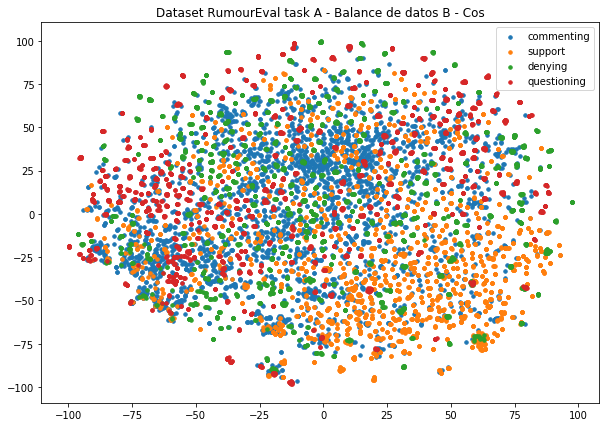

In [42]:
model = TSNE(2, metric='cosine')
to_plot_tsne = model.fit_transform(data_bas_b)    
plt.figure(figsize=(10,7))
for key in keys:
    labels=[dict_cl[lab] for lab in macro_augmented[:,2]]
    mask = np.asarray(labels)==key
    plt.scatter(to_plot_tsne[:,0][mask],to_plot_tsne[:,1][mask], s=12, label=str(key))

plt.legend()
plt.title("Dataset RumourEval task A - Balance de datos B - Cos")
plt.show()

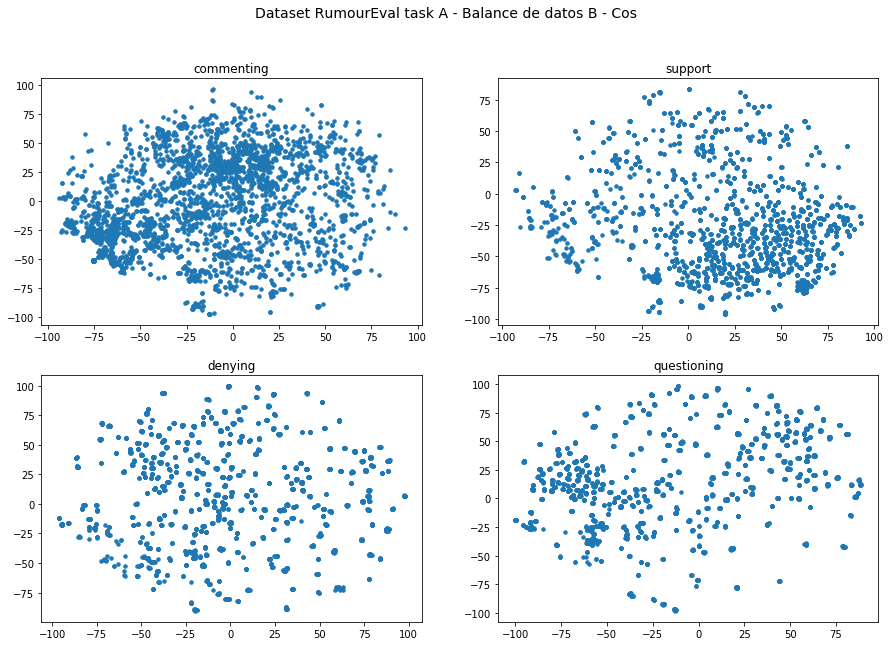

In [43]:
fig = plt.figure(figsize=(15,10))
j=220
for key in keys:
    labels=[dict_cl[lab] for lab in macro_augmented[:,2]]
    mask = np.asarray(labels)==key
    j+=1
    h=fig.add_subplot(j)
    plt.scatter(to_plot_tsne[:,0][mask],to_plot_tsne[:,1][mask], s=12, label=str(key))
    h.title.set_text(str(key))

fig.suptitle("Dataset RumourEval task A - Balance de datos B - Cos", fontsize=14)
plt.show()

In [44]:
np.random.shuffle(macro_augmented)
np.save('../Datasets/CSV_Stance/balance_bert_noPon.npy', macro_augmented)
    

### Sujeto a Embedding BERT ponderando target

In [45]:
macro_augmented=[]
for clase in aum_weight:
    start_time=time.time()
    print ("\n\nGenerando", aum_weight[clase], "ejemplos para", clase)
    muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, BERT=True, pond=True)
    macro_augmented+=muestras
    print ("Resumen de modificaciones:", dict_aumentos)
    elapsed_time= time.time() - start_time
    print ("Este proceso tomó", elapsed_time, "seg")   



Generando 2404 ejemplos para questioning
Consultando por la clase questioning
Entrega label 2
Original: being  	Reemplazo:  [('having', 0.7301497459411621)]
Sentencia original:
['user' 'user' 'any' 'chance' 'that' "'" 's' 'being' 'said' 'for' 'fear'
 'of' 'retribution' '?']
Sentencia final: 2
['user', 'user', 'any', 'chance', 'that', "'", 's', 'having', 'said', 'for', 'fear', 'of', 'retribution', '?']


Original: stupid  	Reemplazo:  [('uploaded', 1.4800913333892822)]
Sentencia original:
['user' 'user' 'user' 'how' 'stupid' 'html']
Sentencia final: 2
['user', 'user', 'user', 'how', 'uploaded', 'html']


Original: s  	Reemplazo:  [('grimace', 0.6017490029335022)]
Original: t  	Reemplazo:  [('win', 0.5105658173561096)]
Sentencia original:
['user' 'user' 'user' 'user' 'ah' 'true' '.' 'problem' 'now' 'is' 'we' "'"
 'll' 'probably' 'only' 'get' 'coroner' "'" 's' 'details' 'they' 'won' "'"
 't' 'make' 'it' '.']
Sentencia final: 2
['user', 'user', 'user', 'user', 'ah', 'true', '.', 'problem

Original: broken  	Reemplazo:  [('broke', 0.4904027581214905)]
Original: is  	Reemplazo:  [('has', 3.3420183658599854)]
Sentencia original:
['user' 'the' 'pause' 'button' 'is' 'broken' 'and' 'there' 'is' 'no'
 'rewind' 'function' '.' 'it' "'" 's' 'terrifying' 'when' 'you' 'think'
 'about' 'it' '.']
Sentencia final: 2
['user', 'the', 'pause', 'button', 'is', 'broke', 'and', 'there', 'has', 'no', 'rewind', 'function', '.', 'it', "'", 's', 'terrifying', 'when', 'you', 'think', 'about', 'it', '.']


Original: fucking  	Reemplazo:  [('freaking', 0.7998443841934204)]
Sentencia original:
['user' 'but' 'why' 'a' 'fucking' 'cafe' 'in' 'australia']
Sentencia final: 2
['user', 'but', 'why', 'a', 'freaking', 'cafe', 'in', 'australia']


Original: crime  	Reemplazo:  [('frenchman', 0.5537458658218384)]
Sentencia original:
['user' 'user' 'a' 'french' 'crime' 'of' 'passion' 'or' 'another'
 'heathen' 'moslem' 'atrocity' '?']
Sentencia final: 2
['user', 'user', 'a', 'french', 'frenchman', 'of', 'passio

Original: didn  	Reemplazo:  [('couldn', 0.9148809313774109)]
Original: t  	Reemplazo:  [('wouldn', 0.5655156970024109)]
Sentencia original:
['user' 'didn' "'" 't' 'the' 'manager' 'of' 'the' 'store' 'already' 'say'
 'this' 'was' 'not' 'true']
Sentencia final: 2
['user', 'couldn', "'", 'wouldn', 'the', 'manager', 'of', 'the', 'store', 'already', 'say', 'this', 'was', 'not', 'true']


Original: names  	Reemplazo:  [('arts', 1.832706332206726)]
Sentencia original:
['user' 'isn' "'" 't' 'it' 'etiquette' 'to' 'remove' 'names' 'from' 'a'
 'press' 'release' '?']
Sentencia final: 2
['user', 'isn', "'", 't', 'it', 'etiquette', 'to', 'remove', 'arts', 'from', 'a', 'press', 'release', '?']


Original: suspects  	Reemplazo:  [('confirms', 0.424936443567276)]
Original: been  	Reemplazo:  [('suspected', 0.953373372554779)]
Sentencia original:
['user' 'has' 'car' '-' 'jack' 'by' 'suspects' 'been' 'confirmed' '?'
 'questionable' '.']
Sentencia final: 2
['user', 'has', 'car', '-', 'jack', 'by', 'confir

Original: conflicting  	Reemplazo:  [('referencing', 0.4635726809501648)]
Original: shooting  	Reemplazo:  [('saying', 0.7948349714279175)]
Sentencia original:
['.' 'user' 'conflicting' 'reports' 'regarding' 'a' 'possible' 'shooting'
 'on' 'near' 'the' 'centre' ',' 'but' 'your' 'gm' 'said' 'no' 'shooting'
 '.' 'can' 'you' 'clarify' 'at' 'all' '?']
Sentencia final: 2
['.', 'user', 'referencing', 'reports', 'regarding', 'a', 'possible', 'shooting', 'on', 'near', 'the', 'centre', ',', 'but', 'your', 'gm', 'said', 'no', 'saying', '.', 'can', 'you', 'clarify', 'at', 'all', '?']


Original: i  	Reemplazo:  [('listener', 0.5481117367744446)]
Original: want  	Reemplazo:  [('need', 0.7385232448577881)]
Original: did  	Reemplazo:  [('got', 0.3381805717945099)]
Original: cbs  	Reemplazo:  [('nbc', 0.8361230492591858)]
Sentencia original:
['user' 'i' 'want' 'answers' 'why' 'did' 'i' 'get' 'netter' 'news' 'fom'
 'cnn' 'and' 'cbs' '?' '?' '?']
Sentencia final: 2
['user', 'listener', 'need', 'answers

Original: everything  	Reemplazo:  [('aback', 2.5646307468414307)]
Sentencia original:
['user' 'user' 'yep' '!' '!' 'splitting' 'image' 'in' 'everything'
 'except' 'one' 'has' 'black' 'hair' 'and' 'other' 'blonde' '.']
Sentencia final: 2
['user', 'user', 'yep', '!', '!', 'splitting', 'image', 'in', 'aback', 'except', 'one', 'has', 'black', 'hair', 'and', 'other', 'blonde', '.']


Original: timeline  	Reemplazo:  [('proponent', 0.8925367593765259)]
Original: general  	Reemplazo:  [('private', 1.3562654256820679)]
Original: name  	Reemplazo:  [('surname', 0.738135039806366)]
Sentencia original:
['user' 'user' 'any' 'timeline' 'on' 'when' 'the' 'general' 'public'
 'gets' 'the' 'name' '?']
Sentencia final: 2
['user', 'user', 'any', 'proponent', 'on', 'when', 'the', 'private', 'public', 'gets', 'the', 'surname', '?']


Original: are  	Reemplazo:  [('am', 1.0071768760681152)]
Sentencia original:
['user' 'user' 'user' 'user' 'that' 'right' 'there' 'tells' 'me' 'you'
 'are' 'going' 'into' 'thi

Original: is  	Reemplazo:  [('has', 1.2290310859680176)]
Original: action  	Reemplazo:  [('pistol', 1.4586126804351807)]
Sentencia original:
['user' 'suppose' 'that' "'" 's' 'real' ':' 'that' 'guy' 'is' 'carrying'
 'a' 'lever' 'action' 'rifle' 'it' 'looks' 'like' '?']
Sentencia final: 2
['user', 'suppose', 'that', "'", 's', 'real', ':', 'that', 'guy', 'has', 'carrying', 'a', 'lever', 'pistol', 'rifle', 'it', 'looks', 'like', '?']


Original: do  	Reemplazo:  [('take', 0.46652951836586)]
Sentencia original:
['user' 'user' 'user' 'user' 'hardly' ',' 'dont' 'hear' 'about' 'a'
 'school' 'shooting' 'or' 'spree' 'every' 'number' 'min' 'do' 'we' '?']
Sentencia final: 2
['user', 'user', 'user', 'user', 'hardly', ',', 'dont', 'hear', 'about', 'a', 'school', 'shooting', 'or', 'spree', 'every', 'number', 'min', 'take', 'we', '?']


Original: drivers  	Reemplazo:  [('pays', 1.2179166078567505)]
Sentencia original:
['user' 'user' 'what' 'do' 'you' 'pay' 'your' 'drivers' '?']
Sentencia final: 2
['us

Original: yes  	Reemplazo:  [('knows', 0.5607513189315796)]
Original: i  	Reemplazo:  [('yeah', 0.46593397855758667)]
Original: know  	Reemplazo:  [('take', 0.41931870579719543)]
Original: is  	Reemplazo:  [('has', 0.4765363931655884)]
Original: %  	Reemplazo:  [('percent', 1.0911431312561035)]
Sentencia original:
['user' 'user' 'yes' 'i' 'know' 'that' 'hand' 'gun' 'crime' 'is' 'up'
 'number' '%' 'where' 'i' 'live' 'and' 'they' 'are' 'banned' '!' ':']
Sentencia final: 2
['user', 'user', 'knows', 'yeah', 'take', 'that', 'hand', 'gun', 'crime', 'has', 'up', 'number', 'percent', 'where', 'i', 'live', 'and', 'they', 'are', 'banned', '!', ':']


Original: training  	Reemplazo:  [('cop', 0.7554331421852112)]
Sentencia original:
['user' 'but' 'because' 'of' 'the' 'training' 'that' 'cops' 'receive'
 'now' 'is' 'more' 'military' 'in' 'manner' 'they' 'react' 'overly'
 'aggressive' 'towards' 'us' 'non' '-' 'cop']
Sentencia final: 2
['user', 'but', 'because', 'of', 'the', 'cop', 'that', 'cops', 'r

Original: was  	Reemplazo:  [('had', 1.716084361076355)]
Sentencia original:
['user' 'user' 'why' 'did' 'the' 'store' 'owner' 'say' 'it' 'wasn' "'" 't'
 'him' 'and' 'the' 'friend' 'admitted' 'it' 'was' '?' 'have' 'the'
 'gotten' 'an' 'explanation']
Sentencia final: 2
['user', 'user', 'why', 'did', 'the', 'store', 'owner', 'say', 'it', 'wasn', "'", 't', 'him', 'and', 'the', 'friend', 'admitted', 'it', 'had', '?', 'have', 'the', 'gotten', 'an', 'explanation']


Original: pricing  	Reemplazo:  [('price', 1.947545051574707)]
Sentencia original:
['user' 'so' 'free' 'or' 'surge' 'pricing' '?' 'hashtag']
Sentencia final: 2
['user', 'so', 'free', 'or', 'surge', 'price', '?', 'hashtag']


Original: reports  	Reemplazo:  [('furlongs', 1.784315824508667)]
Original: french  	Reemplazo:  [('rican', 1.522335171699524)]
Sentencia original:
['user' 'can' 'you' 'confirm' 'the' 'reports' 'that' 'those' 'suspects'
 'were' 'killed' 'by' 'french' 'police' '?']
Sentencia final: 2
['user', 'can', 'you', 'con

Original: picture  	Reemplazo:  [('set', 1.9655286073684692)]
Sentencia original:
['user' 'so' 'who' 'is' 'the' 'brainiac' 'on' 'the' 'right' 'that' 'looks'
 'like' 'he' "'" 's' 'taking' 'a' 'picture' '?']
Sentencia final: 2
['user', 'so', 'who', 'is', 'the', 'brainiac', 'on', 'the', 'right', 'that', 'looks', 'like', 'he', "'", 's', 'taking', 'a', 'set', '?']


Original: s  	Reemplazo:  [('become', 0.4719242453575134)]
Sentencia original:
['user' 'user' 'okay' ',' 'so' 'what' "'" 's' 'been' 'happening' 'in'
 'canada' '?']
Sentencia final: 2
['user', 'user', 'okay', ',', 'so', 'what', "'", 'become', 'been', 'happening', 'in', 'canada', '?']


Original: word  	Reemplazo:  [('verb', 0.7889012694358826)]
Original: active  	Reemplazo:  [('traumatic', 0.835749089717865)]
Sentencia original:
['user' 'user' 'getting' 'the' 'word' 'out' 'about' 'an' 'active'
 'shooter' 'situation' 'seems' 'pretty' 'helpful' ',' 'but' 'please' ','
 'tell' 'us' 'what' 'you' "'" 'd' 'have' 'done' '.']
Sentencia fi

Original: have  	Reemplazo:  [('utilize', 0.5500410199165344)]
Original: pic  	Reemplazo:  [('look', 0.8595076203346252)]
Original: released  	Reemplazo:  [('sold', 2.073129892349243)]
Original: press  	Reemplazo:  [('milling', 0.3485926687717438)]
Original: isn  	Reemplazo:  [('wasn', 0.904886782169342)]
Original: is  	Reemplazo:  [('has', 3.6584975719451904)]
Original: account  	Reemplazo:  [('wasn', 1.4752827882766724)]
Original: t  	Reemplazo:  [('wasn', 1.0186399221420288)]
Original: memorial  	Reemplazo:  [('monument', 1.8122620582580566)]
Original: i  	Reemplazo:  [('utilization', 0.3669181764125824)]
Original: is  	Reemplazo:  [('has', 1.1841729879379272)]
Original: feed  	Reemplazo:  [('englishman', 0.49123767018318176)]
Original: english  	Reemplazo:  [('portuguese', 1.092948079109192)]
Original: t  	Reemplazo:  [('france', 0.547589123249054)]
Original: t  	Reemplazo:  [('gt', 0.724216103553772)]
Original: walk  	Reemplazo:  [('truck', 0.508078932762146)]
Original: utter  	Re

Original: com  	Reemplazo:  [('nexus', 0.47979050874710083)]
Original: ride  	Reemplazo:  [('lumpur', 5.032880783081055)]
Original: right  	Reemplazo:  [('correct', 0.4978989362716675)]
Original: suspects  	Reemplazo:  [('guns', 2.2277727127075195)]
Original: info  	Reemplazo:  [('arose', 0.8984476923942566)]
Original: assume  	Reemplazo:  [('utilize', 0.30558905005455017)]
Original: definition  	Reemplazo:  [('usage', 0.7826235890388489)]
Original: urgent  	Reemplazo:  [('urgency', 0.8362715840339661)]
Original: i  	Reemplazo:  [('time', 0.8913032412528992)]
Original: many  	Reemplazo:  [('numerous', 0.8504038453102112)]
Original: have  	Reemplazo:  [('be', 1.346221923828125)]
Original: tell  	Reemplazo:  [('told', 5.853957653045654)]
Original: f  	Reemplazo:  [('break', 1.2090134620666504)]
Original: sidewalk  	Reemplazo:  [('pavement', 0.7062976360321045)]
Original: wasn  	Reemplazo:  [('isn', 1.1843514442443848)]
Original: world  	Reemplazo:  [('need', 0.7451053857803345)]
Original

Original: fired  	Reemplazo:  [('discharged', 0.7665971517562866)]
Original: centre  	Reemplazo:  [('center', 1.4301137924194336)]
Original: islamic  	Reemplazo:  [('authoritarian', 0.31110677123069763)]
Original: covering  	Reemplazo:  [('encompassing', 0.7799664735794067)]
Original: supreme  	Reemplazo:  [('possess', 0.6723445057868958)]
Original: open  	Reemplazo:  [('scramble', 0.43012675642967224)]
Original: population  	Reemplazo:  [('populace', 0.7303490042686462)]
Original: matter  	Reemplazo:  [('time', 1.1013902425765991)]
Original: isn  	Reemplazo:  [('wasn', 1.3864495754241943)]
Original: is  	Reemplazo:  [('has', 2.1630709171295166)]
Original: memorial  	Reemplazo:  [('commemorative', 0.7898967266082764)]
Original: are  	Reemplazo:  [('am', 1.6128801107406616)]
Original: conflicting  	Reemplazo:  [('referencing', 0.4635726809501648)]
Original: possible  	Reemplazo:  [('feasible', 1.0125856399536133)]
Original: did  	Reemplazo:  [('got', 0.5410585999488831)]
Original: i  	R

Original: thought  	Reemplazo:  [('think', 1.2607859373092651)]
Original: was  	Reemplazo:  [('were', 1.0902677774429321)]
Original: happened  	Reemplazo:  [('went', 0.6995904445648193)]
Original: day  	Reemplazo:  [('fill', 1.3021535873413086)]
Original: raised  	Reemplazo:  [('furrowed', 1.1598503589630127)]
Original: ll  	Reemplazo:  [('explanation', 0.8124455809593201)]
Original: ride  	Reemplazo:  [('lumpur', 5.032880783081055)]
Original: rides  	Reemplazo:  [('replacements', 0.27937352657318115)]
Original: available  	Reemplazo:  [('other', 0.4370383024215698)]
Original: gun  	Reemplazo:  [('suspect', 0.5551424026489258)]
Original: mean  	Reemplazo:  [('imply', 1.0245798826217651)]
Original: aid  	Reemplazo:  [('worker', 0.4007948338985443)]
Original: much  	Reemplazo:  [('little', 2.180238962173462)]
Original: are  	Reemplazo:  [('am', 1.0594267845153809)]
Original: hand  	Reemplazo:  [('fifth', 0.46722352504730225)]
Original: world  	Reemplazo:  [('universe', 0.720231831073761)

Original: war  	Reemplazo:  [('battle', 0.7674046754837036)]
Original: corruption  	Reemplazo:  [('greedy', 1.3145043849945068)]
Original: did  	Reemplazo:  [('discarded', 0.49250322580337524)]
Original: don  	Reemplazo:  [('programmer', 0.453189492225647)]
Original: pricing  	Reemplazo:  [('seduction', 0.7190275192260742)]
Original: is  	Reemplazo:  [('has', 1.231178879737854)]
Original: muslim  	Reemplazo:  [('customer', 0.6440785527229309)]
Original: prefer  	Reemplazo:  [('title', 2.032182216644287)]
Original: shot  	Reemplazo:  [('shoot', 0.747183084487915)]
Original: lone  	Reemplazo:  [('burkina', 1.3006540536880493)]
Original: cat  	Reemplazo:  [('copying', 0.8567346930503845)]
Original: armed  	Reemplazo:  [('pointed', 2.0123720169067383)]
Original: points  	Reemplazo:  [('vertices', 1.6529814004898071)]
Original: worrying  	Reemplazo:  [('wondering', 1.5405213832855225)]
Original: gonna  	Reemplazo:  [('wanna', 0.7564278244972229)]
Original: want  	Reemplazo:  [('need', 1.278

Original: start  	Reemplazo:  [('begin', 1.380656123161316)]
Original: end  	Reemplazo:  [('didn', 0.7533829212188721)]
Original: was  	Reemplazo:  [('seemed', 0.5292702317237854)]
Original: hostage  	Reemplazo:  [('left', 2.0833451747894287)]
Original: is  	Reemplazo:  [('has', 0.4225457012653351)]
Original: minutes  	Reemplazo:  [('seconds', 1.2788619995117188)]
Original: ll  	Reemplazo:  [('want', 2.068018674850464)]
Original: didn  	Reemplazo:  [('doesn', 1.3937205076217651)]
Original: stupid  	Reemplazo:  [('uploaded', 0.9380719661712646)]
Original: problem  	Reemplazo:  [('right', 0.7236416339874268)]
Original: make  	Reemplazo:  [('give', 1.1717842817306519)]
Original: hi  	Reemplazo:  [('susanna', 0.5512474775314331)]
Original: were  	Reemplazo:  [('contributed', 1.1960387229919434)]
Original: media  	Reemplazo:  [('asks', 1.2903190851211548)]
Original: terrorists  	Reemplazo:  [('delivers', 0.6431588530540466)]
Original: tape  	Reemplazo:  [('wire', 1.2487928867340088)]
Origin

Original: movements  	Reemplazo:  [('tracks', 0.5335009694099426)]
Original: i  	Reemplazo:  [('application', 1.5558364391326904)]
Original: being  	Reemplazo:  [('becoming', 3.2563517093658447)]
Original: lone  	Reemplazo:  [('sole', 1.1502808332443237)]
Original: s  	Reemplazo:  [('wanna', 0.5243710279464722)]
Original: i  	Reemplazo:  [('iii', 0.7732857465744019)]
Original: bomb  	Reemplazo:  [('bombing', 1.5844676494598389)]
Original: sydney  	Reemplazo:  [('escape', 1.2654792070388794)]
Original: number  	Reemplazo:  [('present', 1.9783324003219604)]
Original: god  	Reemplazo:  [('lord', 0.4474165141582489)]
Original: show  	Reemplazo:  [('sell', 0.8264249563217163)]
Original: t  	Reemplazo:  [('tb', 0.4592362642288208)]
Original: does  	Reemplazo:  [('expects', 0.6930145025253296)]
Original: did  	Reemplazo:  [('got', 0.5257399082183838)]
Original: get  	Reemplazo:  [('obtain', 0.9521133303642273)]
Original: guy  	Reemplazo:  [('man', 1.3287798166275024)]
Original: yep  	Reemplaz

Original: s  	Reemplazo:  [('thought', 0.4816127121448517)]
Original: get  	Reemplazo:  [('obtain', 0.8871515393257141)]
Original: person  	Reemplazo:  [('man', 0.4463331997394562)]
Original: suspects  	Reemplazo:  [('weren', 1.3334413766860962)]
Original: i  	Reemplazo:  [('salim', 0.31309494376182556)]
Original: demands  	Reemplazo:  [('reports', 3.225684881210327)]
Original: tape  	Reemplazo:  [('wire', 1.2487928867340088)]
Original: crime  	Reemplazo:  [('treason', 1.1847953796386719)]
Original: last  	Reemplazo:  [('final', 0.4954237937927246)]
Original: man  	Reemplazo:  [('boy', 2.0688729286193848)]
Original: safe  	Reemplazo:  [('unsafe', 1.3322019577026367)]
Original: shut  	Reemplazo:  [('remain', 1.1543797254562378)]
Original: know  	Reemplazo:  [('believe', 0.8509821891784668)]
Original: looks  	Reemplazo:  [('rights', 0.7034428715705872)]
Original: canada  	Reemplazo:  [('canadian', 0.9183803200721741)]
Original: d  	Reemplazo:  [('time', 1.3018312454223633)]
Original: wer

Original: myths  	Reemplazo:  [('users', 0.9587019085884094)]
Original: reporting  	Reemplazo:  [('report', 2.117819309234619)]
Original: hostages  	Reemplazo:  [('emerges', 0.9135634303092957)]
Original: have  	Reemplazo:  [('obtain', 0.9028462767601013)]
Original: remains  	Reemplazo:  [('remnants', 0.7886752486228943)]
Original: gunmen  	Reemplazo:  [('smashwords', 2.337071657180786)]
Original: motivated  	Reemplazo:  [('based', 2.0990750789642334)]
Original: s  	Reemplazo:  [('re', 1.1100679636001587)]
Original: hostage  	Reemplazo:  [('home', 1.8969782590866089)]
Original: come  	Reemplazo:  [('run', 1.0116958618164062)]
Original: didn  	Reemplazo:  [('wouldn', 0.8214173316955566)]
Original: does  	Reemplazo:  [('expects', 0.5499165654182434)]
Original: thank  	Reemplazo:  [('goodbye', 1.0882320404052734)]
Original: understand  	Reemplazo:  [('understood', 0.8757350444793701)]
Original: media  	Reemplazo:  [('accounts', 0.7937458753585815)]
Original: account  	Reemplazo:  [('didn'

Original: is  	Reemplazo:  [('has', 0.6976383328437805)]
Original: t  	Reemplazo:  [('win', 0.8470129370689392)]
Original: hi  	Reemplazo:  [('sidney', 0.8120379447937012)]
Original: are  	Reemplazo:  [('am', 1.2702054977416992)]
Original: able  	Reemplazo:  [('unable', 0.5349482297897339)]
Original: i  	Reemplazo:  [('government', 1.215452790260315)]
Original: media  	Reemplazo:  [('asks', 1.3516833782196045)]
Original: shows  	Reemplazo:  [('demonstrates', 1.2672144174575806)]
Original: updates  	Reemplazo:  [('users', 2.3765032291412354)]
Original: help  	Reemplazo:  [('work', 1.2509832382202148)]
Original: report  	Reemplazo:  [('call', 2.0068821907043457)]
Original: shut  	Reemplazo:  [('remain', 0.7636404633522034)]
Original: shows  	Reemplazo:  [('misses', 0.772030234336853)]
Original: looks  	Reemplazo:  [('glances', 0.8087862133979797)]
Original: s  	Reemplazo:  [('time', 2.1396677494049072)]
Original: sorry  	Reemplazo:  [('programmer', 0.5480538606643677)]
Original: know  	R

Original: use  	Reemplazo:  [('usage', 1.9907832145690918)]
Original: agenda  	Reemplazo:  [('goalscorer', 1.297000527381897)]
Original: s  	Reemplazo:  [('home', 2.051809549331665)]
Original: m  	Reemplazo:  [('look', 0.8432133197784424)]
Original: are  	Reemplazo:  [('am', 0.7076185941696167)]
Original: talking  	Reemplazo:  [('chatting', 0.5107682943344116)]
Original: allah  	Reemplazo:  [('deity', 0.7991458177566528)]
Original: is  	Reemplazo:  [('has', 0.45523667335510254)]
Original: god  	Reemplazo:  [('jesus', 1.344079852104187)]
Original: people  	Reemplazo:  [('men', 0.798701822757721)]
Original: involved  	Reemplazo:  [('been', 0.736528754234314)]
Original: lots  	Reemplazo:  [('mixes', 0.521135687828064)]
Original: number  	Reemplazo:  [('resultant', 0.31767529249191284)]
Original: is  	Reemplazo:  [('has', 1.1702858209609985)]
Original: investigation  	Reemplazo:  [('indictment', 0.9056960940361023)]
Original: doesn  	Reemplazo:  [('didn', 1.396124005317688)]
Original: r  	

Original: photo  	Reemplazo:  [('left', 1.1489790678024292)]
Original: night  	Reemplazo:  [('day', 2.210754156112671)]
Original: mad  	Reemplazo:  [('woman', 0.7591707706451416)]
Original: today  	Reemplazo:  [('work', 0.4288709759712219)]
Original: say  	Reemplazo:  [('take', 0.46658384799957275)]
Original: number  	Reemplazo:  [('set', 1.1508318185806274)]
Original: stay  	Reemplazo:  [('stayed', 0.597650945186615)]
Original: s  	Reemplazo:  [('become', 0.45877310633659363)]
Original: seems  	Reemplazo:  [('appears', 0.673344612121582)]
Original: tell  	Reemplazo:  [('told', 3.5601680278778076)]
Original: i  	Reemplazo:  [('told', 1.17494535446167)]
Original: tell  	Reemplazo:  [('told', 0.7508355975151062)]
Original: are  	Reemplazo:  [('am', 0.9838871359825134)]
Original: police  	Reemplazo:  [('media', 1.7735868692398071)]
Original: want  	Reemplazo:  [('wish', 1.9907902479171753)]
Original: lies  	Reemplazo:  [('specializes', 0.8200196623802185)]
Original: is  	Reemplazo:  [('ha

Original: strategy  	Reemplazo:  [('manipulation', 0.5926886200904846)]
Original: is  	Reemplazo:  [('has', 2.122678279876709)]
Original: didn  	Reemplazo:  [('doesn', 1.4671955108642578)]
Original: michael  	Reemplazo:  [('john', 0.5206040143966675)]
Original: please  	Reemplazo:  [('identification', 0.8185669779777527)]
Original: have  	Reemplazo:  [('do', 3.3871235847473145)]
Original: chief  	Reemplazo:  [('head', 1.2163640260696411)]
Original: hold  	Reemplazo:  [('held', 1.00965416431427)]
Original: is  	Reemplazo:  [('seems', 0.7912005186080933)]
Original: proof  	Reemplazo:  [('time', 2.223600149154663)]
Original: attackers  	Reemplazo:  [('perpetrators', 0.6902568340301514)]
Original: waves  	Reemplazo:  [('focuses', 0.7434490323066711)]
Original: was  	Reemplazo:  [('wired', 0.29982393980026245)]
Original: let  	Reemplazo:  [('allow', 1.2683370113372803)]
Original: job  	Reemplazo:  [('task', 1.3450045585632324)]
Original: unknown  	Reemplazo:  [('unspecified', 0.353212088346

Original: coward  	Reemplazo:  [('undertake', 0.4983542561531067)]
Original: i  	Reemplazo:  [('think', 0.8662576079368591)]
Original: supposed  	Reemplazo:  [('been', 0.3089463412761688)]
Original: anonymous  	Reemplazo:  [('malicious', 0.7935815453529358)]
Original: s  	Reemplazo:  [('work', 0.7496449947357178)]
Original: bait  	Reemplazo:  [('aback', 2.768930673599243)]
Original: seen  	Reemplazo:  [('been', 0.7567952871322632)]
Original: are  	Reemplazo:  [('am', 0.6925968527793884)]
Original: is  	Reemplazo:  [('has', 1.2759103775024414)]
Original: confirmed  	Reemplazo:  [('verified', 0.7836800813674927)]
Original: b  	Reemplazo:  [('bc', 0.765507161617279)]
Original: was  	Reemplazo:  [('had', 0.8356590867042542)]
Original: gun  	Reemplazo:  [('saw', 3.196518898010254)]
Original: jack  	Reemplazo:  [('adolf', 0.5273227691650391)]
Original: have  	Reemplazo:  [('see', 1.9943405389785767)]
Original: video  	Reemplazo:  [('time', 1.2709230184555054)]
Original: taken  	Reemplazo:  [

Original: guy  	Reemplazo:  [('carry', 0.525336503982544)]
Original: is  	Reemplazo:  [('has', 1.1976592540740967)]
Original: number  	Reemplazo:  [('lumpur', 2.771089792251587)]
Original: min  	Reemplazo:  [('don', 1.2179557085037231)]
Original: number  	Reemplazo:  [('variety', 0.8542134761810303)]
Original: drivers  	Reemplazo:  [('men', 1.7734782695770264)]
Original: police  	Reemplazo:  [('officers', 2.308288812637329)]
Original: confusing  	Reemplazo:  [('skating', 1.987221360206604)]
Original: t  	Reemplazo:  [('create', 0.29731735587120056)]
Original: sense  	Reemplazo:  [('feel', 1.2268922328948975)]
Original: t  	Reemplazo:  [('beige', 0.5382314324378967)]
Original: shoes  	Reemplazo:  [('media', 3.204267978668213)]
Original: s  	Reemplazo:  [('present', 1.93480384349823)]
Original: are  	Reemplazo:  [('am', 0.4397270083427429)]
Original: isis  	Reemplazo:  [('minerva', 0.5482929944992065)]
Original: is  	Reemplazo:  [('has', 0.5255027413368225)]
Original: reported  	Reemplaz

Original: person  	Reemplazo:  [('want', 0.7889534831047058)]
Original: didn  	Reemplazo:  [('doesn', 0.5667915940284729)]
Original: isn  	Reemplazo:  [('wasn', 0.9048860669136047)]
Original: jack  	Reemplazo:  [('adolf', 0.5273227691650391)]
Original: been  	Reemplazo:  [('suspected', 0.9214662313461304)]
Original: call  	Reemplazo:  [('caller', 0.6047057509422302)]
Original: closer  	Reemplazo:  [('crambidae', 2.8995449542999268)]
Original: get  	Reemplazo:  [('have', 0.7016413807868958)]
Original: many  	Reemplazo:  [('numerous', 0.8739874362945557)]
Original: def  	Reemplazo:  [('aback', 2.926520347595215)]
Original: did  	Reemplazo:  [('was', 3.197237730026245)]
Original: cigar  	Reemplazo:  [('ii', 0.7570237517356873)]
Original: i  	Reemplazo:  [('ii', 0.5940121412277222)]
Original: need  	Reemplazo:  [('want', 0.8803059458732605)]
Original: point  	Reemplazo:  [('angle', 1.1646060943603516)]
Original: heard  	Reemplazo:  [('gunfire', 1.5145366191864014)]
Original: pa  	Reemplazo

Original: life  	Reemplazo:  [('power', 0.741598904132843)]
Original: tell  	Reemplazo:  [('told', 0.793549120426178)]
Original: robbery  	Reemplazo:  [('infantry', 2.118157386779785)]
Original: editor  	Reemplazo:  [('illustrator', 0.8142541646957397)]
Original: be  	Reemplazo:  [('have', 0.7124974131584167)]
Original: cartoon  	Reemplazo:  [('doesn', 0.8822084665298462)]
Original: means  	Reemplazo:  [('cartoons', 0.6270305514335632)]
Original: values  	Reemplazo:  [('vimes', 1.5863943099975586)]
Original: resolution  	Reemplazo:  [('crap', 0.8933325409889221)]
Original: yes  	Reemplazo:  [('users', 1.2891814708709717)]
Original: crime  	Reemplazo:  [('arm', 0.8257333040237427)]
Original: i  	Reemplazo:  [('time', 0.6827170252799988)]
Original: other  	Reemplazo:  [('various', 1.2086541652679443)]
Original: resolution  	Reemplazo:  [('prayed', 0.9669331908226013)]
Original: shoot  	Reemplazo:  [('re', 0.6504355072975159)]
Original: glad  	Reemplazo:  [('policeman', 0.3226542174816131

Original: walk  	Reemplazo:  [('truck', 0.5237069129943848)]
Original: unable  	Reemplazo:  [('incapable', 1.5634011030197144)]
Original: getting  	Reemplazo:  [('letting', 1.4809895753860474)]
Original: need  	Reemplazo:  [('necessity', 0.8169471621513367)]
Original: rumours  	Reemplazo:  [('gotten', 2.3642077445983887)]
Original: be  	Reemplazo:  [('go', 0.7244753241539001)]
Original: did  	Reemplazo:  [('discarded', 0.49250322580337524)]
Original: hostage  	Reemplazo:  [('bribe', 0.9428132176399231)]
Original: sunni  	Reemplazo:  [('hinduism', 1.180841326713562)]
Original: happened  	Reemplazo:  [('was', 0.7300401926040649)]
Original: man  	Reemplazo:  [('held', 0.503943145275116)]
Original: bad  	Reemplazo:  [('good', 1.290719985961914)]
Original: is  	Reemplazo:  [('has', 2.1008918285369873)]
Original: prefer  	Reemplazo:  [('moniker', 0.7365047335624695)]
Original: being  	Reemplazo:  [('having', 1.9428859949111938)]
Original: lone  	Reemplazo:  [('burkina', 1.3006540536880493)]


Original: is  	Reemplazo:  [('has', 0.5041785836219788)]
Original: is  	Reemplazo:  [('has', 1.1715118885040283)]
Original: t  	Reemplazo:  [('haven', 0.7975955605506897)]
Original: big  	Reemplazo:  [('large', 0.7951685786247253)]
Original: need  	Reemplazo:  [('await', 0.832079291343689)]
Original: t  	Reemplazo:  [('hadn', 0.7371214628219604)]
Original: have  	Reemplazo:  [('acquire', 0.6696348190307617)]
Original: clarified  	Reemplazo:  [('flickered', 1.147239089012146)]
Original: ll  	Reemplazo:  [('aback', 2.7167835235595703)]
Original: hi  	Reemplazo:  [('susanna', 0.5512474775314331)]
Original: give  	Reemplazo:  [('obtain', 1.0264174938201904)]
Original: i  	Reemplazo:  [('resultant', 0.29556870460510254)]
Original: report  	Reemplazo:  [('reporting', 1.3995579481124878)]
Original: does  	Reemplazo:  [('is', 0.7503846287727356)]
Original: say  	Reemplazo:  [('emphasize', 0.47823914885520935)]
Original: number  	Reemplazo:  [('amount', 1.2319376468658447)]
Original: are  	Reem

Original: toronto  	Reemplazo:  [('lankan', 2.203773021697998)]
Original: looking  	Reemplazo:  [('staring', 2.45695161819458)]
Original: are  	Reemplazo:  [('am', 0.6788256168365479)]
Original: please  	Reemplazo:  [('ethan', 1.8794043064117432)]
Original: image  	Reemplazo:  [('issn', 1.4683194160461426)]
Original: name  	Reemplazo:  [('surname', 0.7722079157829285)]
Original: were  	Reemplazo:  [('was', 0.546753466129303)]
Original: m  	Reemplazo:  [('look', 0.5208698511123657)]
Original: god  	Reemplazo:  [('time', 2.063857316970825)]
Original: is  	Reemplazo:  [('expects', 0.8002079129219055)]
Original: shooting  	Reemplazo:  [('presenting', 0.7723860144615173)]
Original: present  	Reemplazo:  [('shoot', 0.5422013998031616)]
Original: sydney  	Reemplazo:  [('insurrection', 0.4227410852909088)]
Original: siege  	Reemplazo:  [('reside', 0.42411917448043823)]
Original: —  	Reemplazo:  [('freyja', 0.830102264881134)]
Original: uber  	Reemplazo:  [('fabio', 0.7893084287643433)]
Origina

Original: say  	Reemplazo:  [('take', 0.46658384799957275)]
Original: thanks  	Reemplazo:  [('marks', 1.1682003736495972)]
Original: ottawa  	Reemplazo:  [('stayed', 1.5768026113510132)]
Original: missing  	Reemplazo:  [('showcasing', 0.6133661866188049)]
Original: quality  	Reemplazo:  [('absent', 0.8416528105735779)]
Original: thought  	Reemplazo:  [('think', 1.3625060319900513)]
Original: sorry  	Reemplazo:  [('customer', 0.6687883734703064)]
Original: do  	Reemplazo:  [('have', 0.828050971031189)]
Original: isis  	Reemplazo:  [('ss', 0.7328217625617981)]
Original: happening  	Reemplazo:  [('occurring', 0.5146955847740173)]
Original: getting  	Reemplazo:  [('implementing', 0.9290178418159485)]
Original: seems  	Reemplazo:  [('appears', 0.7803851962089539)]
Original: stop  	Reemplazo:  [('change', 0.7373670935630798)]
Original: explosives  	Reemplazo:  [('panicked', 1.0263181924819946)]
Original: explosion  	Reemplazo:  [('found', 0.7087615728378296)]
Original: madness  	Reemplazo:  

Original: business  	Reemplazo:  [('publishing', 0.5743722915649414)]
Original: get  	Reemplazo:  [('do', 0.8605722188949585)]
Original: confirmation  	Reemplazo:  [('tuna', 0.7564446926116943)]
Original: guy  	Reemplazo:  [('man', 1.2362786531448364)]
Original: hi  	Reemplazo:  [('paul', 0.8295412063598633)]
Original: peter  	Reemplazo:  [('thomas', 1.2762783765792847)]
Original: take  	Reemplazo:  [('do', 0.9260334968566895)]
Original: use  	Reemplazo:  [('usage', 1.343255877494812)]
Original: were  	Reemplazo:  [('was', 1.6055327653884888)]
Original: hat  	Reemplazo:  [('reading', 2.0299649238586426)]
Original: flop  	Reemplazo:  [('bestseller', 1.172869086265564)]
Original: t  	Reemplazo:  [('te', 1.1699739694595337)]
Original: convenient  	Reemplazo:  [('company', 0.7521566152572632)]
Original: robbed  	Reemplazo:  [('bookstore', 0.7861296534538269)]
Original: called  	Reemplazo:  [('named', 2.089879035949707)]
Original: flag  	Reemplazo:  [('work', 2.2996296882629395)]
Original: 

Original: number  	Reemplazo:  [('handful', 1.2741202116012573)]
Original: looks  	Reemplazo:  [('glances', 0.9225923418998718)]
Original: s  	Reemplazo:  [('sh', 0.7671951055526733)]
Original: confirm  	Reemplazo:  [('aback', 2.5109143257141113)]
Original: looks  	Reemplazo:  [('rights', 0.7009566426277161)]
Original: active  	Reemplazo:  [('nonlinear', 0.8447726964950562)]
Original: shooter  	Reemplazo:  [('insurrection', 0.3967643082141876)]
Original: seems  	Reemplazo:  [('intends', 0.4727326035499573)]
Original: helpful  	Reemplazo:  [('seem', 0.9591941237449646)]
Original: yesterday  	Reemplazo:  [('incorrect', 0.586443305015564)]
Original: chief  	Reemplazo:  [('policeman', 0.6488269567489624)]
Original: madness  	Reemplazo:  [('fourteenth', 0.29920390248298645)]
Original: running  	Reemplazo:  [('holding', 1.2572506666183472)]
Original: harm  	Reemplazo:  [('anybody', 0.7076929211616516)]
Original: police  	Reemplazo:  [('policemen', 0.7771272659301758)]
Original: said  	Reempl

Original: store  	Reemplazo:  [('bookstore', 0.3628288209438324)]
Original: flag  	Reemplazo:  [('insurrection', 0.4474082589149475)]
Original: shit  	Reemplazo:  [('crap', 0.8343127369880676)]
Original: t  	Reemplazo:  [('urdu', 0.927787721157074)]
Original: god  	Reemplazo:  [('islam', 1.147389531135559)]
Original: god  	Reemplazo:  [('mohammad', 1.5334217548370361)]
Original: messenger  	Reemplazo:  [('courier', 1.282083511352539)]
Original: god  	Reemplazo:  [('man', 0.7129127383232117)]
Original: please  	Reemplazo:  [('court', 3.1409661769866943)]
Original: number  	Reemplazo:  [('hostage', 0.5927196145057678)]
Original: sydney  	Reemplazo:  [('cafes', 0.4927477240562439)]
Original: updates  	Reemplazo:  [('upgrades', 0.8630142211914062)]
Original: potential  	Reemplazo:  [('prospective', 0.49818694591522217)]
Original: op  	Reemplazo:  [('crime', 0.7538768649101257)]
Original: facts  	Reemplazo:  [('needs', 0.33537963032722473)]
Original: think  	Reemplazo:  [('thought', 2.16762

Original: getting  	Reemplazo:  [('modifying', 0.5762275457382202)]
Original: situation  	Reemplazo:  [('prevalent', 0.6428488492965698)]
Original: police  	Reemplazo:  [('policemen', 0.5265235900878906)]
Original: chief  	Reemplazo:  [('policeman', 0.6802984476089478)]
Original: i  	Reemplazo:  [('set', 3.278379440307617)]
Original: tell  	Reemplazo:  [('told', 3.3519248962402344)]
Original: worried  	Reemplazo:  [('disappointed', 0.7919983267784119)]
Original: was  	Reemplazo:  [('appeared', 0.6256822943687439)]
Original: limited  	Reemplazo:  [('special', 0.4489004611968994)]
Original: max  	Reemplazo:  [('use', 0.7067860960960388)]
Original: police  	Reemplazo:  [('people', 1.1543304920196533)]
Original: don  	Reemplazo:  [('didn', 0.7877156138420105)]
Original: drivers  	Reemplazo:  [('encourages', 0.4314556121826172)]
Original: brown  	Reemplazo:  [('cook', 0.787237823009491)]
Original: confirmed  	Reemplazo:  [('interred', 2.0752954483032227)]
Original: is  	Reemplazo:  [('succe

Original: struggle  	Reemplazo:  [('battling', 0.7918965816497803)]
Original: do  	Reemplazo:  [('have', 1.2768096923828125)]
Original: didn  	Reemplazo:  [('beige', 0.35871487855911255)]
Sentencia original:
['user' 'user' 'and' 'there' 'was' 'a' 'struggle' 'inside' 'the' 'car' '.'
 'how' 'do' 'we' 'know' 'brown' 'didn' "'" 't' 'get' 'the' 'gun' 'and'
 'fire' 'the' 'shot' 'during' 'the' 'struggle' '?']
Sentencia final: 0
['user', 'user', 'and', 'there', 'was', 'a', 'battling', 'inside', 'the', 'car', '.', 'how', 'have', 'we', 'know', 'brown', 'beige', "'", 't', 'get', 'the', 'gun', 'and', 'fire', 'the', 'shot', 'during', 'the', 'struggle', '?']


Original: security  	Reemplazo:  [('home', 1.271941065788269)]
Sentencia original:
['shots' 'fired' 'on' 'parliament' 'hill' 'after' 'a' 'man' 'walked' 'up'
 'with' 'a' 'gun' '.' 'i' "'" 'm' 'locked' 'in' 'a' 'security' 'office'
 'on' 'parliament' 'hill']
Sentencia final: 0
['shots', 'fired', 'on', 'parliament', 'hill', 'after', 'a', 'man', 'w

Original: brown  	Reemplazo:  [('beige', 0.777761697769165)]
Sentencia original:
['“' 'user' ':' 'police' 'reports' 'released' 'this' 'morning' 'indicate'
 'mike' 'brown' 'was' 'a' 'suspect' 'in' 'a' '"' 'strong' '-' 'armed' '"'
 'robbery' 'in' 'hashtag' '”' 'hashtag']
Sentencia final: 0
['“', 'user', ':', 'police', 'reports', 'released', 'this', 'morning', 'afternoon', 'mike', 'beige', 'was', 'a', 'suspect', 'in', 'a', '"', 'strong', '-', 'armed', '"', 'robbery', 'in', 'hashtag', '”', 'hashtag']


Original: sydney  	Reemplazo:  [('london', 1.2821229696273804)]
Sentencia original:
['thoughts' 'go' 'out' 'to' 'those' 'in' 'sydney' 'dealing' 'with' 'the'
 'number' '-' 'hostage' 'situation' '“' 'user' 'html']
Sentencia final: 0
['thoughts', 'go', 'out', 'to', 'those', 'in', 'london', 'dealing', 'with', 'the', 'number', '-', 'hostage', 'situation', '“', 'user', 'html']


Original: live  	Reemplazo:  [('courageous', 0.3383737802505493)]
Sentencia original:
['hashtag' 'to' 'hold' 'news' 'con

Original: mike  	Reemplazo:  [('afternoon', 0.6234288215637207)]
Original: armed  	Reemplazo:  [('strengthened', 0.35260340571403503)]
Sentencia original:
['“' 'user' ':' 'police' 'reports' 'released' 'this' 'morning' 'indicate'
 'mike' 'brown' 'was' 'a' 'suspect' 'in' 'a' '"' 'strong' '-' 'armed' '"'
 'robbery' 'in' 'hashtag' '”']
Sentencia final: 0
['“', 'user', ':', 'police', 'releases', 'released', 'this', 'morning', 'indicate', 'afternoon', 'brown', 'was', 'a', 'suspect', 'in', 'a', '"', 'strong', '-', 'strengthened', '"', 'robbery', 'in', 'hashtag', '”']


Original: shot  	Reemplazo:  [('everything', 2.2993392944335938)]
Original: stealing  	Reemplazo:  [('imagining', 0.5583129525184631)]
Sentencia original:
['he' 'went' 'there' '.' '“' 'user' ':' 'if' 'we' 'shot' 'everyone' 'in'
 'the' 'street' 'for' 'stealing' ',' 'imagine' 'the' 'carnage' 'on' 'wall'
 'st' '.' 'hashtag' 'hashtag' '”']
Sentencia final: 0
['he', 'went', 'there', '.', '“', 'user', ':', 'if', 'we', 'everything', '

Original: brown  	Reemplazo:  [('orange', 0.7866508960723877)]
Original: murder  	Reemplazo:  [('justification', 0.504196286201477)]
Sentencia original:
['user' 'user' 'even' 'going' 'extreme' 'length' 'to' 'hire' 'an' 'actor'
 'that' 'looks' 'like' 'michael' 'brown' '!' 'not' 'saying' 'murder' 'was'
 'justified' ',' 'it' "'" 's' 'not']
Sentencia final: 0
['user', 'user', 'even', 'going', 'extreme', 'length', 'to', 'hire', 'an', 'actor', 'that', 'looks', 'like', 'michael', 'orange', '!', 'not', 'saying', 'justification', 'was', 'justified', ',', 'it', "'", 's', 'not']


Original: soldier  	Reemplazo:  [('policeman', 0.7643742561340332)]
Sentencia original:
['hashtag' 'rt' 'user' ':' 'soldier' 'killed' 'at' 'war' 'memorial'
 'identified' 'as' 'cpl' '.' 'nathan' 'cirillo' 'hashtag' 'html']
Sentencia final: 0
['hashtag', 'rt', 'user', ':', 'policeman', 'killed', 'at', 'war', 'memorial', 'identified', 'as', 'cpl', '.', 'nathan', 'cirillo', 'hashtag', 'html']


Original: supermarket  	Reemp

Original: source  	Reemplazo:  [('reference', 0.7707602381706238)]
Sentencia original:
['user' 'hmm' '.' 'that' "'" 's' 'not' 'what' 'i' 'heard' 'at' 'all' '.'
 'what' "'" 's' 'your' 'source' 'and' 'quote' '?']
Sentencia final: 0
['user', 'mmm', '.', 'that', "'", 's', 'not', 'what', 'i', 'hear', 'at', 'all', '.', 'what', "'", 's', 'your', 'reference', 'and', 'quote', '?']


Original: s  	Reemplazo:  [('something', 0.27257731556892395)]
Original: penalty  	Reemplazo:  [('midfielder', 1.4785244464874268)]
Sentencia original:
['hobby' 'lobby' 'asks' 'hashtag' 'pd' 'for' 'clarification' ':' '"' 'we'
 'thought' 'chop' 'off' 'someone' "'" 's' 'hand' 'was' 'the' 'maximum'
 'penalty' 'for' 'shoplifting' '"']
Sentencia final: 0
['hobby', 'lobby', 'asks', 'hashtag', 'pd', 'for', 'clarification', ':', '"', 'we', 'thought', 'chop', 'off', 'someone', "'", 'something', 'hand', 'was', 'the', 'maximum', 'midfielder', 'for', 'shoplifting', '"']


Original: canada  	Reemplazo:  [('india', 1.140708327293

Original: shoot  	Reemplazo:  [('assassinate', 1.1984307765960693)]
Original: kill  	Reemplazo:  [('assassinate', 0.7498347759246826)]
Sentencia original:
['user' 'user' 'because' 'it' 'shows' 'brown' 'negatively' '.' 'the'
 'real' 'issue' 'is' ':' 'why' 'did' 'a' 'cop' 'shoot' 'and' 'kill' 'an'
 'unarmed' 'man' ',' 'hands' 'up' '?']
Sentencia final: 0
['user', 'user', 'because', 'it', 'shows', 'brown', 'negatively', '.', 'the', 'real', 'issue', 'is', ':', 'why', 'did', 'a', 'cop', 'assassinate', 'and', 'assassinate', 'an', 'unarmed', 'man', ',', 'hands', 'up', '?']


Original: understand  	Reemplazo:  [('understood', 1.2749660015106201)]
Sentencia original:
['user' 'user' 'user' 'user' 'i' 'don' "'" 't' 'understand' 'the' 'double'
 'standard' 'of' 'wanting' 'all' 'the' 'info' 'about' 'the' 'cop' 'but'
 'brown' "'" 's' 'past' 'is' 'safe' '.']
Sentencia final: 0
['user', 'user', 'user', 'user', 'i', 'don', "'", 't', 'understood', 'the', 'double', 'standard', 'of', 'wanting', 'all', 'the

Original: prince  	Reemplazo:  [('princess', 0.856802761554718)]
Sentencia original:
['“' 'user' ':' 'in' 'response' 'to' 'inquiries' ',' 'we' 'can' 'confirm'
 'that' 'prince' 'will' 'not' 'be' 'performing' 'at' 'user' 'tonight' '.'
 '”' 'user']
Sentencia final: 0
['“', 'user', ':', 'in', 'response', 'to', 'inquiries', ',', 'we', 'can', 'confirm', 'that', 'princess', 'will', 'not', 'be', 'performing', 'at', 'user', 'tonight', '.', '”', 'user']


Original: flee  	Reemplazo:  [('evacuate', 0.813864529132843)]
Original: siege  	Reemplazo:  [('cafes', 0.6176779866218567)]
Sentencia original:
['several' 'more' 'hostages' 'flee' 'from' 'cafe' 'under' 'siege' 'in'
 'sydney' ',' 'local' 'media' 'say' 'html']
Sentencia final: 0
['several', 'more', 'hostages', 'evacuate', 'from', 'cafe', 'under', 'cafes', 'in', 'sydney', ',', 'local', 'media', 'say', 'html']


Original: same  	Reemplazo:  [('infamous', 0.4405571520328522)]
Original: many  	Reemplazo:  [('other', 1.5143539905548096)]
Sentencia or

Original: rt  	Reemplazo:  [('impatience', 0.8091270923614502)]
Original: coverage  	Reemplazo:  [('joyah', 2.212491989135742)]
Sentencia original:
['rt' '“' 'user' ':' 'geoblock' 'lifted' 'on' 'hashtag' '.' 'streaming'
 'coverage' 'of' 'martin' 'place' 'siege' 'in' 'sydney' 'here' 'html'
 'hashtag']
Sentencia final: 0
['impatience', '“', 'user', ':', 'geoblock', 'lifted', 'on', 'hashtag', '.', 'streaming', 'joyah', 'of', 'martin', 'place', 'siege', 'in', 'sydney', 'here', 'html', 'hashtag']


Original: same  	Reemplazo:  [('noticeable', 0.3986389636993408)]
Original: claiming  	Reemplazo:  [('saying', 1.3414260149002075)]
Sentencia original:
['user' 'source' 'from' 'ray' 'hadley' 'shows' 'confirmed' 'same' 'report'
 'of' 'gunman' 'claiming' 'there' 'are' 'four' 'packages' 'around'
 'sydney']
Sentencia final: 0
['user', 'source', 'from', 'ray', 'hadley', 'shows', 'confirmed', 'noticeable', 'report', 'of', 'gunman', 'saying', 'there', 'are', 'four', 'packages', 'around', 'sydney']


Ori

Original: breaking  	Reemplazo:  [('shattering', 1.1837204694747925)]
Original: incident  	Reemplazo:  [('accident', 2.1287176609039307)]
Sentencia original:
['“' 'user' ':' 'breaking' ':' 'one' 'person' 'seriously' 'wounded' ','
 'six' 'taken' 'hostage' 'in' 'incident' 'at' 'kosher' 'supermarket' 'in'
 'paris' ':' 'police' 'source' '"' 'mondo' 'cane' '!']
Sentencia final: 0
['“', 'user', ':', 'shattering', ':', 'one', 'person', 'seriously', 'wounded', ',', 'six', 'taken', 'hostage', 'in', 'accident', 'at', 'kosher', 'supermarket', 'in', 'paris', ':', 'police', 'source', '"', 'mondo', 'cane', '!']


Original: shots  	Reemplazo:  [('shoots', 0.951555609703064)]
Original: fired  	Reemplazo:  [('discharged', 0.7665966749191284)]
Sentencia original:
['hashtag' 'news' ':' 'shots' 'fired' 'at' 'parliament' 'hill' '.'
 'follow' 'developing' 'story' ':' 'html' 'html']
Sentencia final: 0
['hashtag', 'news', ':', 'shoots', 'discharged', 'at', 'parliament', 'hill', '.', 'follow', 'developing', 's

Original: today  	Reemplazo:  [('day', 1.1713930368423462)]
Original: hate  	Reemplazo:  [('email', 1.3965566158294678)]
Original: mail  	Reemplazo:  [('nighttime', 0.25738459825515747)]
Original: explosives  	Reemplazo:  [('explosions', 0.8496675491333008)]
Original: paris  	Reemplazo:  [('thirteenth', 0.537419319152832)]
Original: hostage  	Reemplazo:  [('book', 0.77892005443573)]
Original: source  	Reemplazo:  [('gathering', 0.7314744591712952)]
Original: crack  	Reemplazo:  [('replicate', 0.5193480253219604)]
Original: awesome  	Reemplazo:  [('customer', 0.9037066102027893)]
Original: criminals  	Reemplazo:  [('rescues', 1.0596036911010742)]
Original: paris  	Reemplazo:  [('terrorism', 0.5908267498016357)]
Original: terrorist  	Reemplazo:  [('terrorism', 0.7529816031455994)]
Original: sydney  	Reemplazo:  [('christchurch', 0.45989909768104553)]
Original: northeast  	Reemplazo:  [('southeast', 0.9049670696258545)]
Original: uber  	Reemplazo:  [('programmer', 0.42540428042411804)]
Or

Original: end  	Reemplazo:  [('side', 1.217430591583252)]
Original: i  	Reemplazo:  [('ii', 2.0518879890441895)]
Original: rick  	Reemplazo:  [('ke', 1.1945680379867554)]
Original: russian  	Reemplazo:  [('ukrainian', 1.041428565979004)]
Original: london  	Reemplazo:  [('hertfordshire', 0.6561992168426514)]
Original: cop  	Reemplazo:  [('use', 0.8037047386169434)]
Original: un  	Reemplazo:  [('una', 0.41456934809684753)]
Original: cop  	Reemplazo:  [('shoot', 1.3370332717895508)]
Original: hill  	Reemplazo:  [('hillside', 0.3932177424430847)]
Original: awful  	Reemplazo:  [('epic', 1.199206829071045)]
Original: whole  	Reemplazo:  [('entire', 0.5437483191490173)]
Original: thing  	Reemplazo:  [('person', 0.467899352312088)]
Original: soldier  	Reemplazo:  [('confirm', 0.9323772192001343)]
Original: shot  	Reemplazo:  [('stabbed', 0.6316103339195251)]
Original: several  	Reemplazo:  [('many', 0.8646084666252136)]
Original: freed  	Reemplazo:  [('yiddish', 1.082054615020752)]
Original: p

Original: seeing  	Reemplazo:  [('viewing', 1.0213286876678467)]
Original: was  	Reemplazo:  [('were', 0.3195149898529053)]
Original: shot  	Reemplazo:  [('shoot', 0.7784444093704224)]
Original: is  	Reemplazo:  [('expects', 0.421205997467041)]
Original: news  	Reemplazo:  [('broken', 0.8466303944587708)]
Original: shot  	Reemplazo:  [('miner', 0.5132613182067871)]
Original: breaking  	Reemplazo:  [('violating', 0.9293038845062256)]
Original: appear  	Reemplazo:  [('disclose', 0.7531483173370361)]
Original: escaped  	Reemplazo:  [('had', 1.5430545806884766)]
Original: breaking  	Reemplazo:  [('cracking', 1.1388418674468994)]
Original: situation  	Reemplazo:  [('circumstance', 0.5552653074264526)]
Original: preliminary  	Reemplazo:  [('supplementary', 0.7907440066337585)]
Original: held  	Reemplazo:  [('hold', 0.47721824049949646)]
Original: killing  	Reemplazo:  [('arresting', 0.47716304659843445)]
Original: darren  	Reemplazo:  [('users', 0.6163761019706726)]
Original: had  	Reemplazo

Original: michael  	Reemplazo:  [('lead', 1.231233835220337)]
Original: information  	Reemplazo:  [('info', 0.5775628685951233)]
Original: important  	Reemplazo:  [('crucial', 0.38697487115859985)]
Original: president  	Reemplazo:  [('chairman', 1.902354121208191)]
Original: hostages  	Reemplazo:  [('perpetrators', 0.47789478302001953)]
Original: beat  	Reemplazo:  [('beating', 0.9201332330703735)]
Original: blood  	Reemplazo:  [('urine', 0.5629480481147766)]
Original: going  	Reemplazo:  [('happening', 0.8518524169921875)]
Original: mt  	Reemplazo:  [('mrs', 1.262220859527588)]
Original: editor  	Reemplazo:  [('set', 1.9785196781158447)]
Original: chief  	Reemplazo:  [('stayed', 0.790874719619751)]
Original: site  	Reemplazo:  [('group', 1.4171545505523682)]
Original: police  	Reemplazo:  [('hindwings', 3.280851125717163)]
Original: die  	Reemplazo:  [('prepare', 0.9869526028633118)]
Original: eastern  	Reemplazo:  [('parisian', 0.6134420037269592)]
Original: incident  	Reemplazo:  [(

Original: is  	Reemplazo:  [('has', 2.1875393390655518)]
Original: insult  	Reemplazo:  [('isn', 1.3364282846450806)]
Original: i  	Reemplazo:  [('ii', 2.084178924560547)]
Original: agree  	Reemplazo:  [('ii', 0.7665115594863892)]
Original: france  	Reemplazo:  [('contexts', 0.6422733068466187)]
Original: are  	Reemplazo:  [('am', 1.144479513168335)]
Original: head  	Reemplazo:  [('safety', 1.3767629861831665)]
Original: parliament  	Reemplazo:  [('netflix', 0.734813392162323)]
Original: meaning  	Reemplazo:  [('encompass', 0.6814525723457336)]
Original: house  	Reemplazo:  [('evacuate', 0.8572853803634644)]
Original: breaking  	Reemplazo:  [('policing', 1.1060502529144287)]
Original: i  	Reemplazo:  [('ii', 0.47439831495285034)]
Original: videos  	Reemplazo:  [('hectares', 2.360272169113159)]
Original: i  	Reemplazo:  [('ii', 1.1844743490219116)]
Original: m  	Reemplazo:  [('shook', 0.8869363069534302)]
Original: families  	Reemplazo:  [('clans', 0.7893718481063843)]
Original: police 

Original: sydney  	Reemplazo:  [('cafes', 0.5699824690818787)]
Original: islamic  	Reemplazo:  [('theologian', 0.4714033007621765)]
Original: isn  	Reemplazo:  [('wasn', 1.3864495754241943)]
Original: t  	Reemplazo:  [('canadian', 0.8170139789581299)]
Original: been  	Reemplazo:  [('ousted', 0.4687936007976532)]
Original: able  	Reemplazo:  [('unable', 0.5059924721717834)]
Original: cafe  	Reemplazo:  [('cafes', 0.8557276129722595)]
Original: hostage  	Reemplazo:  [('cafes', 0.9133554100990295)]
Original: unknown  	Reemplazo:  [('unclear', 0.7298109531402588)]
Original: confusing  	Reemplazo:  [('being', 1.2097030878067017)]
Original: are  	Reemplazo:  [('am', 0.7744671106338501)]
Original: victims  	Reemplazo:  [('perpetrators', 0.624805748462677)]
Original: top  	Reemplazo:  [('school', 0.7276697158813477)]
Original: danger  	Reemplazo:  [('shadowy', 0.372545450925827)]
Original: i  	Reemplazo:  [('somebody', 0.9488201141357422)]
Original: cartoonist  	Reemplazo:  [('amount', 1.23709

Original: attacks  	Reemplazo:  [('possesses', 0.27573373913764954)]
Original: breaking  	Reemplazo:  [('shattering', 0.8058252930641174)]
Original: wounded  	Reemplazo:  [('winced', 1.2446367740631104)]
Original: police  	Reemplazo:  [('sources', 0.8769964575767517)]
Original: developing  	Reemplazo:  [('evolving', 0.8267215490341187)]
Original: be  	Reemplazo:  [('have', 1.2900309562683105)]
Original: encourage  	Reemplazo:  [('encouragement', 0.5129784941673279)]
Original: confirmed  	Reemplazo:  [('killed', 0.9267206788063049)]
Original: paris  	Reemplazo:  [('customer', 0.9391438364982605)]
Original: hostage  	Reemplazo:  [('hold', 0.5313519835472107)]
Original: siege  	Reemplazo:  [('pdf', 1.5621665716171265)]
Original: incidents  	Reemplazo:  [('shoots', 0.6188572645187378)]
Original: gunmen  	Reemplazo:  [('militants', 0.8614781498908997)]
Original: s  	Reemplazo:  [('captive', 0.6524474024772644)]
Original: thank  	Reemplazo:  [('honor', 0.4412081241607666)]
Original: s  	Reem

Original: sources  	Reemplazo:  [('confirms', 0.6393555998802185)]
Original: plain  	Reemplazo:  [('sound', 1.4066362380981445)]
Original: get  	Reemplazo:  [('be', 2.1435863971710205)]
Original: man  	Reemplazo:  [('part', 3.1786556243896484)]
Original: self  	Reemplazo:  [('tehran', 0.5383872985839844)]
Original: sheikh  	Reemplazo:  [('lankan', 1.9817394018173218)]
Original: little  	Reemplazo:  [('small', 1.2442930936813354)]
Original: road  	Reemplazo:  [('street', 0.8082550168037415)]
Original: operation  	Reemplazo:  [('plan', 1.2983554601669312)]
Original: number  	Reemplazo:  [('death', 1.2507838010787964)]
Original: said  	Reemplazo:  [('was', 2.2088143825531006)]
Original: help  	Reemplazo:  [('assistance', 0.7877182364463806)]
Original: hostage  	Reemplazo:  [('aback', 1.4630507230758667)]
Original: suspect  	Reemplazo:  [('lankan', 1.4600677490234375)]
Original: puts  	Reemplazo:  [('wickets', 3.866945266723633)]
Original: being  	Reemplazo:  [('holding', 0.338712126016616

Original: excellent  	Reemplazo:  [('splendid', 0.3731987774372101)]
Original: wanted  	Reemplazo:  [('wondered', 1.980778694152832)]
Original: are  	Reemplazo:  [('am', 0.4929102659225464)]
Original: harmed  	Reemplazo:  [('disadvantaged', 0.8412278890609741)]
Original: situations  	Reemplazo:  [('numbers', 0.8747837543487549)]
Original: don  	Reemplazo:  [('multitude', 0.361397385597229)]
Original: sold  	Reemplazo:  [('purchased', 0.6389340162277222)]
Original: i  	Reemplazo:  [('ii', 0.45622387528419495)]
Original: says  	Reemplazo:  [('does', 3.7073187828063965)]
Original: beautiful  	Reemplazo:  [('magnificent', 0.8112695217132568)]
Original: vi  	Reemplazo:  [('vii', 0.7983991503715515)]
Original: have  	Reemplazo:  [('leave', 1.2789860963821411)]
Original: separate  	Reemplazo:  [('simultaneous', 0.9732195138931274)]
Original: parliament  	Reemplazo:  [('congress', 3.290742874145508)]
Original: hostages  	Reemplazo:  [('captives', 1.0207668542861938)]
Original: coup  	Reemplazo

Original: say  	Reemplazo:  [('be', 0.8493891358375549)]
Original: citizens  	Reemplazo:  [('reporters', 0.9189534783363342)]
Original: light  	Reemplazo:  [('lighter', 0.7449639439582825)]
Original: situation  	Reemplazo:  [('position', 1.1838613748550415)]
Original: u  	Reemplazo:  [('school', 1.15371835231781)]
Original: louis  	Reemplazo:  [('cf', 0.8303380012512207)]
Original: m  	Reemplazo:  [('woman', 1.2111756801605225)]
Original: police  	Reemplazo:  [('people', 0.45387139916419983)]
Original: attack  	Reemplazo:  [('panic', 1.4161218404769897)]
Original: face  	Reemplazo:  [('cheeks', 0.7749553322792053)]
Original: coward  	Reemplazo:  [('head', 1.2808271646499634)]
Original: video  	Reemplazo:  [('flashlight', 0.6086108088493347)]
Original: satirical  	Reemplazo:  [('humorous', 0.8861263990402222)]
Original: sydney  	Reemplazo:  [('hostage', 0.9473525881767273)]
Original: cafe  	Reemplazo:  [('cafes', 1.2803289890289307)]
Original: dead  	Reemplazo:  [('numbered', 0.49863600

Original: news  	Reemplazo:  [('fifteenth', 0.20246274769306183)]
Original: job  	Reemplazo:  [('gratitude', 0.5635095238685608)]
Original: people  	Reemplazo:  [('sees', 0.489492803812027)]
Original: flag  	Reemplazo:  [('windshield', 1.369606375694275)]
Original: reads  	Reemplazo:  [('revolves', 1.4526803493499756)]
Original: allah  	Reemplazo:  [('islam', 2.2853386402130127)]
Original: ’  	Reemplazo:  [('goddess', 1.5094926357269287)]
Original: canadian  	Reemplazo:  [('argentine', 1.002853512763977)]
Original: number  	Reemplazo:  [('mn', 0.5805772542953491)]
Original: be  	Reemplazo:  [('have', 0.5174949765205383)]
Original: north  	Reemplazo:  [('south', 0.9125052690505981)]
Original: t  	Reemplazo:  [('man', 0.8139681816101074)]
Original: way  	Reemplazo:  [('pathway', 0.7323753237724304)]
Original: attackers  	Reemplazo:  [('holes', 0.6374370455741882)]
Original: teams  	Reemplazo:  [('squads', 0.7996584177017212)]
Original: struggle  	Reemplazo:  [('qaeda', 1.4272629022598267

Original: extreme  	Reemplazo:  [('width', 0.8391759395599365)]
Original: brown  	Reemplazo:  [('blue', 2.154629707336426)]
Original: justified  	Reemplazo:  [('murderous', 0.5768591165542603)]
Original: killed  	Reemplazo:  [('assassinated', 0.6017040610313416)]
Original: freed  	Reemplazo:  [('jurist', 0.781630277633667)]
Original: thomas  	Reemplazo:  [('john', 0.7548915147781372)]
Original: freedom  	Reemplazo:  [('liberty', 0.5291146039962769)]
Original: make  	Reemplazo:  [('take', 0.8106016516685486)]
Original: final  	Reemplazo:  [('eventual', 0.8284809589385986)]
Original: death  	Reemplazo:  [('occur', 0.8569287657737732)]
Original: right  	Reemplazo:  [('left', 0.7670671939849854)]
Original: memorial  	Reemplazo:  [('commemoration', 0.28960928320884705)]
Original: police  	Reemplazo:  [('media', 1.311103343963623)]
Original: robbery  	Reemplazo:  [('kidnapping', 1.0344648361206055)]
Original: credit  	Reemplazo:  [('billing', 0.7395896315574646)]
Original: parliament  	Reemp

Original: sniper  	Reemplazo:  [('voter', 1.5363787412643433)]
Original: continue  	Reemplazo:  [('begin', 1.2746988534927368)]
Original: needs  	Reemplazo:  [('investigates', 0.7746928334236145)]
Original: justice  	Reemplazo:  [('power', 1.1342962980270386)]
Original: release  	Reemplazo:  [('film', 0.7541525959968567)]
Original: story  	Reemplazo:  [('home', 0.7886396646499634)]
Original: pd  	Reemplazo:  [('gaulle', 1.250357747077942)]
Original: shooting  	Reemplazo:  [('surviving', 0.8752957582473755)]
Original: are  	Reemplazo:  [('am', 1.0698004961013794)]
Original: number  	Reemplazo:  [('proportion', 1.3327748775482178)]
Original: robbed  	Reemplazo:  [('aback', 1.7108213901519775)]
Original: phone  	Reemplazo:  [('telephone', 1.0246886014938354)]
Original: suspected  	Reemplazo:  [('interred', 1.1294927597045898)]
Original: gunmen  	Reemplazo:  [('perpetrators', 0.6728107929229736)]
Original: information  	Reemplazo:  [('info', 0.9851340055465698)]
Original: robbery  	Reempla

Original: were  	Reemplazo:  [('was', 0.39838460087776184)]
Original: sure  	Reemplazo:  [('didn', 0.9908722043037415)]
Original: kill  	Reemplazo:  [('darmstadt', 0.5757447481155396)]
Original: report  	Reemplazo:  [('forbade', 0.5913012027740479)]
Original: died  	Reemplazo:  [('whimpered', 0.6338281035423279)]
Original: are  	Reemplazo:  [('am', 1.246185541152954)]
Original: midfielder  	Reemplazo:  [('defender', 0.8628096580505371)]
Original: been  	Reemplazo:  [('seen', 1.1391240358352661)]
Original: michael  	Reemplazo:  [('aback', 2.4104855060577393)]
Original: photo  	Reemplazo:  [('rouen', 0.45168569684028625)]
Original: thomas  	Reemplazo:  [('john', 0.7548915147781372)]
Original: be  	Reemplazo:  [('expect', 1.1606998443603516)]
Original: b  	Reemplazo:  [('dt', 0.8699249625205994)]
Original: ap  	Reemplazo:  [('yahoo', 1.3906211853027344)]
Original: yes  	Reemplazo:  [('users', 0.3254740536212921)]
Original: sources  	Reemplazo:  [('policemen', 0.301724910736084)]
Original:

Original: right  	Reemplazo:  [('left', 1.3749055862426758)]
Original: colour  	Reemplazo:  [('colourful', 0.6364319324493408)]
Original: denial  	Reemplazo:  [('lankan', 2.7437033653259277)]
Original: game  	Reemplazo:  [('gameplay', 0.9521817564964294)]
Original: bloody  	Reemplazo:  [('filthy', 0.4818742573261261)]
Original: hiding  	Reemplazo:  [('isn', 0.7581493258476257)]
Original: o  	Reemplazo:  [('caller', 0.5013859272003174)]
Original: gunmen  	Reemplazo:  [('corpses', 0.9461612105369568)]
Original: t  	Reemplazo:  [('isn', 1.336183786392212)]
Original: call  	Reemplazo:  [('lead', 1.3404146432876587)]
Original: go  	Reemplazo:  [('apologize', 0.8812434077262878)]
Original: number  	Reemplazo:  [('isbn', 1.6403965950012207)]
Original: have  	Reemplazo:  [('be', 0.3330973982810974)]
Original: caught  	Reemplazo:  [('held', 0.7073251605033875)]
Original: end  	Reemplazo:  [('terminate', 0.7186667323112488)]
Original: weekly  	Reemplazo:  [('daily', 0.47321632504463196)]
Origina

Original: shooting  	Reemplazo:  [('outing', 0.33557313680648804)]
Original: cnn  	Reemplazo:  [('interviewed', 0.5921928286552429)]
Original: live  	Reemplazo:  [('new', 1.2486975193023682)]
Original: released  	Reemplazo:  [('emitted', 0.3573245406150818)]
Original: robbery  	Reemplazo:  [('set', 1.1138885021209717)]
Original: control  	Reemplazo:  [('restrictive', 0.2866766154766083)]
Original: fishing  	Reemplazo:  [('goddamn', 0.9617374539375305)]
Original: north  	Reemplazo:  [('south', 1.2415227890014648)]
Original: says  	Reemplazo:  [('adds', 0.3157306909561157)]
Original: chase  	Reemplazo:  [('man', 0.7449308633804321)]
Original: way  	Reemplazo:  [('path', 1.2266877889633179)]
Original: sydney  	Reemplazo:  [('parramatta', 0.5843731760978699)]
Original: evacuated  	Reemplazo:  [('excavated', 1.057476282119751)]
Original: reports  	Reemplazo:  [('finds', 0.5786848664283752)]
Original: is  	Reemplazo:  [('has', 1.313291072845459)]
Original: way  	Reemplazo:  [('walkway', 0.56

Original: background  	Reemplazo:  [('information', 1.454375982284546)]
Original: son  	Reemplazo:  [('left', 2.454420328140259)]
Original: breaking  	Reemplazo:  [('cracking', 0.8503713011741638)]
Original: devices  	Reemplazo:  [('transmitters', 0.3824644684791565)]
Original: located  	Reemplazo:  [('situated', 0.8741253018379211)]
Original: calling  	Reemplazo:  [('policing', 1.4044097661972046)]
Original: s  	Reemplazo:  [('re', 1.8697775602340698)]
Original: killed  	Reemplazo:  [('lost', 0.62924724817276)]
Original: attacks  	Reemplazo:  [('assaults', 0.38683632016181946)]
Original: were  	Reemplazo:  [('said', 0.5123798251152039)]
Original: shooting  	Reemplazo:  [('stabbing', 0.5590592622756958)]
Original: other  	Reemplazo:  [('various', 1.256996989250183)]
Original: rt  	Reemplazo:  [('wolverhampton', 0.6053332090377808)]
Original: evacuated  	Reemplazo:  [('furrowed', 1.6981956958770752)]
Original: high  	Reemplazo:  [('low', 0.5987308025360107)]
Original: level  	Reemplazo:

Original: flip  	Reemplazo:  [('narrower', 0.4932352304458618)]
Original: number  	Reemplazo:  [('group', 0.741807758808136)]
Original: putin  	Reemplazo:  [('lead', 1.29499089717865)]
Original: hmm  	Reemplazo:  [('mmm', 1.229272484779358)]
Original: number  	Reemplazo:  [('time', 3.4142138957977295)]
Original: show  	Reemplazo:  [('reveal', 0.5954258441925049)]
Original: right  	Reemplazo:  [('left', 0.8258046507835388)]
Original: number  	Reemplazo:  [('shootout', 0.5408821702003479)]
Original: number  	Reemplazo:  [('pm', 0.858931303024292)]
Original: several  	Reemplazo:  [('sizable', 0.42679062485694885)]
Original: samson  	Reemplazo:  [('purification', 0.7931976318359375)]
Original: have  	Reemplazo:  [('get', 1.898182988166809)]
Original: war  	Reemplazo:  [('time', 0.6990185976028442)]
Original: road  	Reemplazo:  [('street', 0.7806292772293091)]
Original: s  	Reemplazo:  [('resultant', 0.32139021158218384)]
Original: suspects  	Reemplazo:  [('vimes', 1.9453295469284058)]
Orig

Original: alert  	Reemplazo:  [('deepest', 0.5114686489105225)]
Original: flags  	Reemplazo:  [('lowers', 0.5456724762916565)]
Original: half  	Reemplazo:  [('seventeenth', 0.4979908764362335)]
Original: life  	Reemplazo:  [('parma', 0.45967426896095276)]
Original: europe  	Reemplazo:  [('west', 1.338630199432373)]
Original: invite  	Reemplazo:  [('scandinavia', 0.3273434638977051)]
Original: due  	Reemplazo:  [('unable', 0.956007719039917)]
Original: birth  	Reemplazo:  [('xml', 0.6567811965942383)]
Original: siege  	Reemplazo:  [('lankan', 4.04760217666626)]
Original: breaking  	Reemplazo:  [('shattering', 0.5720016360282898)]
Original: islamic  	Reemplazo:  [('visual', 1.245611548423767)]
Original: fuck  	Reemplazo:  [('xml', 0.8839448690414429)]
Original: forgot  	Reemplazo:  [('forget', 1.8971893787384033)]
Original: job  	Reemplazo:  [('immense', 0.5115501880645752)]
Original: latest  	Reemplazo:  [('newest', 1.7092026472091675)]
Original: most  	Reemplazo:  [('best', 0.791555881

Original: freed  	Reemplazo:  [('jurist', 0.781630277633667)]
Original: photo  	Reemplazo:  [('photograph', 0.8638314008712769)]
Original: sydney  	Reemplazo:  [('cabaret', 1.1354554891586304)]
Original: several  	Reemplazo:  [('many', 0.8646084666252136)]
Original: police  	Reemplazo:  [('users', 0.36363857984542847)]
Original: taking  	Reemplazo:  [('seizing', 0.7590358257293701)]
Original: being  	Reemplazo:  [('holding', 0.5473207235336304)]
Original: held  	Reemplazo:  [('hold', 0.481484591960907)]
Original: number  	Reemplazo:  [('upgrade', 1.0275574922561646)]
Original: flag  	Reemplazo:  [('insurrection', 0.3926677107810974)]
Original: news  	Reemplazo:  [('report', 1.4753371477127075)]
Original: officer  	Reemplazo:  [('man', 1.3603031635284424)]
Original: killed  	Reemplazo:  [('named', 2.8347747325897217)]
Original: is  	Reemplazo:  [('includes', 0.8678745627403259)]
Original: hall  	Reemplazo:  [('today', 0.812626302242279)]
Original: cafe  	Reemplazo:  [('hold', 0.87114906

Original: walking  	Reemplazo:  [('hiking', 0.9195745587348938)]
Original: talk  	Reemplazo:  [('speak', 0.8982765078544617)]
Original: dead  	Reemplazo:  [('murderous', 0.42089176177978516)]
Original: reporting  	Reemplazo:  [('canada', 0.4750865697860718)]
Original: was  	Reemplazo:  [('had', 0.4138714373111725)]
Original: heartbreak  	Reemplazo:  [('injury', 1.7408407926559448)]
Original: help  	Reemplazo:  [('assist', 1.3011724948883057)]
Original: puts  	Reemplazo:  [('wickets', 3.866945266723633)]
Original: least  	Reemplazo:  [('most', 3.8618228435516357)]
Original: have  	Reemplazo:  [('follow', 0.48802316188812256)]
Original: number  	Reemplazo:  [('multitude', 0.5020676255226135)]
Original: people  	Reemplazo:  [('users', 3.5980186462402344)]
Original: incident  	Reemplazo:  [('captive', 1.3620187044143677)]
Original: supermarket  	Reemplazo:  [('motel', 1.1873430013656616)]
Original: be  	Reemplazo:  [('disclose', 0.36908891797065735)]
Original: right  	Reemplazo:  [('left',

Original: heartbreak  	Reemplazo:  [('love', 1.1589175462722778)]
Original: young  	Reemplazo:  [('old', 1.2503530979156494)]
Sentencia original:
['heartbreak' 'for' 'hashtag' 'and' 'canada' '.' '“' 'user' ':' 'soldier'
 'killed' 'in' 'canada' 'shooting' 'was' 'a' 'young' 'reservist' 'with'
 'a' 'son' 'html']
Sentencia final: 1
['love', 'for', 'hashtag', 'and', 'canada', '.', '“', 'user', ':', 'soldier', 'killed', 'in', 'canada', 'shooting', 'was', 'a', 'old', 'reservist', 'with', 'a', 'son', 'html']


Original: be  	Reemplazo:  [('go', 0.7445193529129028)]
Sentencia original:
['user' '"' 'may' 'be' '"' 'really' '?' 'forehead' 'smack']
Sentencia final: 1
['user', '"', 'may', 'go', '"', 'really', '?', 'forehead', 'smack']


Original: sounds  	Reemplazo:  [('noises', 1.2552974224090576)]
Sentencia original:
['user' 'user' 'user' 'i' "'" 'm' 'not' 'watching' 'it' ',' 'but' 'it'
 'sounds' 'as' 'if' 'it' 'is' 'being' 'treated' 'as' 'sport' '.']
Sentencia final: 1
['user', 'user', 'user', 'i

Original: same  	Reemplazo:  [('similar', 1.1892023086547852)]
Sentencia original:
['user' 'user' 'mt' 'user' ':' 'these' 'not' 'the' 'same' '.' '1st'
 'shahadah' 'flag' ',' '2nd' 'is' 'specifically' 'claimed' 'by' 'is' '.'
 'html']
Sentencia final: 1
['user', 'user', 'mt', 'user', ':', 'these', 'not', 'the', 'similar', '.', '1st', 'shahadah', 'flag', ',', '2nd', 'is', 'specifically', 'claimed', 'by', 'is', '.', 'html']


Original: best  	Reemplazo:  [('easiest', 0.5252265334129333)]
Sentencia original:
['user' 'user' 'apparently' 'a' 'hoax' '.' 'best' 'to' 'take' 'tweet'
 'down' '.']
Sentencia final: 1
['user', 'user', 'apparently', 'a', 'hoax', '.', 'easiest', 'to', 'take', 'tweet', 'down', '.']


Original: stop  	Reemplazo:  [('operator', 0.8770612478256226)]
Original: put  	Reemplazo:  [('threw', 1.207076072692871)]
Sentencia original:
['user' 'user' 'user' 'yes' 'why' 'not' '?' '?' 'stop' 'criticizing'
 'user' 'and' 'you' 'need' 'to' 'realize' 'that' 'hashtag' 'put' 'our'
 'lives'

Original: s  	Reemplazo:  [('excellent', 1.2218784093856812)]
Original: movements  	Reemplazo:  [('dialects', 1.7807776927947998)]
Sentencia original:
['user' 'i' 'don' "'" 't' 'think' 'he' "'" 's' 'a' 'good' 'leader' 'at'
 'all' ',' 'he' "'" 's' 'to' 'involved' 'in' 'racial' 'movements' '.'
 'trudeau' 'is' 'better' 'than' 'obama' '.']
Sentencia final: 1
['user', 'i', 'don', "'", 't', 'think', 'he', "'", 'excellent', 'a', 'good', 'leader', 'at', 'all', ',', 'he', "'", 's', 'to', 'involved', 'in', 'racial', 'dialects', '.', 'trudeau', 'is', 'better', 'than', 'obama', '.']


Original: knew  	Reemplazo:  [('knows', 1.189156413078308)]
Original: was  	Reemplazo:  [('were', 0.794035017490387)]
Original: use  	Reemplazo:  [('usage', 1.2181305885314941)]
Sentencia original:
['user' 'i' 'did' 'not' 'think' 'the' 'french' 'knew' 'what' 'a' 'gun'
 'was' 'or' 'how' 'to' 'use' 'one' '.' 'there' 'arms' 'expertise' 'was'
 'on' 'par' 'with' 'the' 'italians' '-' 'experts' 'at' 'dropping']
Sentencia fi

Original: fucking  	Reemplazo:  [('freaking', 0.7221088409423828)]
Sentencia original:
['user' 'if' 'you' 'don' "'" 't' 'think' 'there' 'is' 'clear' 'motive'
 'in' 'fighting' 'or' 'fleeing' 'from' 'police' 'after' 'robbery' ','
 'you' 'are' 'a' 'fucking' 'moron' '.' 'hashtag']
Sentencia final: 1
['user', 'if', 'you', 'don', "'", 't', 'think', 'there', 'is', 'clear', 'motive', 'in', 'fighting', 'or', 'fleeing', 'from', 'police', 'after', 'robbery', ',', 'you', 'are', 'a', 'freaking', 'moron', '.', 'hashtag']


Original: hostages  	Reemplazo:  [('slaves', 2.021571636199951)]
Sentencia original:
['“' 'user' ':' 'several' 'hostages' 'freed' 'at' 'jewish' 'supermarket'
 'in' 'paris' '.' 'photo' 'thomas' 'samson' 'hashtag' 'html']
Sentencia final: 1
['“', 'user', ':', 'several', 'slaves', 'freed', 'at', 'jewish', 'supermarket', 'in', 'paris', '.', 'photo', 'thomas', 'samson', 'hashtag', 'html']


Original: i  	Reemplazo:  [('ii', 0.7856804728507996)]
Sentencia original:
['user' 'user' 'how' 

Original: number  	Reemplazo:  [('variety', 2.133023977279663)]
Sentencia original:
['user' '"' 'ottawa' 'police' 'report' 'a' 'third' 'shooting' 'at'
 'rideau' 'centre' ',' 'no' 'reports' 'of' 'injuries' '.' '"' 'hoping'
 'everyone' 'stays' 'safe' '&lt' ';' 'number']
Sentencia final: 1
['user', '"', 'ottawa', 'police', 'report', 'a', 'third', 'shooting', 'at', 'rideau', 'centre', ',', 'no', 'reports', 'of', 'injuries', '.', '"', 'hoping', 'everyone', 'stays', 'safe', '&lt', ';', 'variety']


Original: akbar  	Reemplazo:  [('scream', 0.9253126382827759)]
Sentencia original:
['user' 'they' 'screamed' 'allahu' 'akbar' 'just' 'like' 'those' 'who'
 'scream' 'novorossiya']
Sentencia final: 1
['user', 'they', 'screamed', 'allahu', 'scream', 'just', 'like', 'those', 'who', 'scream', 'novorossiya']


Original: brown  	Reemplazo:  [('dave', 0.8941307663917542)]
Original: knew  	Reemplazo:  [('knows', 0.5357652902603149)]
Original: know  	Reemplazo:  [('believe', 0.8203845620155334)]
Sentencia o

Original: generic  	Reemplazo:  [('forsyth', 0.5391006469726562)]
Original: group  	Reemplazo:  [('class', 0.7973951697349548)]
Sentencia original:
['user' 'user' 'user' 'shahada' 'flag' 'is' 'a' 'generic' 'flag' ',' 'not'
 'unique' 'to' 'any' 'group' '.' 'isis' 'use' 'a' 'different' 'flag']
Sentencia final: 1
['user', 'user', 'user', 'shahada', 'flag', 'is', 'a', 'forsyth', 'flag', ',', 'not', 'unique', 'to', 'any', 'class', '.', 'isis', 'use', 'a', 'different', 'flag']


Original: fingers  	Reemplazo:  [('hands', 1.2034693956375122)]
Original: stand  	Reemplazo:  [('stood', 0.8934230208396912)]
Sentencia original:
['user' 'user' 'user' 'user' 'rather' 'then' 'point' 'fingers' ',' 'why'
 'don' "'" 't' 'you' 'stand' 'united' 'with' 'the' 'rest' 'of' 'canadians'
 '.']
Sentencia final: 1
['user', 'user', 'user', 'user', 'rather', 'then', 'point', 'hands', ',', 'why', 'don', "'", 't', 'you', 'stood', 'united', 'with', 'the', 'rest', 'of', 'canadians', '.']


Original: sense  	Reemplazo:  

Original: tell  	Reemplazo:  [('told', 3.709627151489258)]
Original: t  	Reemplazo:  [('earn', 0.7894908785820007)]
Sentencia original:
['user' 'user' 'user' 'user' 'then' 'tell' 'me' 'the' 'people' 'of'
 'ferguson' 'haven' "'" 't' 'earned' 'some' 'distrust' '.']
Sentencia final: 1
['user', 'user', 'user', 'user', 'then', 'told', 'me', 'the', 'people', 'of', 'ferguson', 'haven', "'", 'earn', 'earned', 'some', 'distrust', '.']


Original: have  	Reemplazo:  [('utilize', 0.5101586580276489)]
Sentencia original:
['“' 'user' ':' 'breaking' '-' 'shooting' 'on' 'parliament' 'hill' '.'
 'rcmp' 'have' 'weapons' 'drawn' 'hashtag' 'html' 'sirens' 'galore' 'down'
 'here']
Sentencia final: 1
['“', 'user', ':', 'breaking', '-', 'shooting', 'on', 'parliament', 'hill', '.', 'rcmp', 'utilize', 'weapons', 'drawn', 'hashtag', 'html', 'sirens', 'galore', 'down', 'here']


Original: don  	Reemplazo:  [('didn', 2.148160219192505)]
Original: hope  	Reemplazo:  [('time', 1.1923781633377075)]
Sentencia origin

['user', 'fresh', 'bill', 'change', 'militarizing', 'law', 'enforcement', 'act', 'drafted', 'yesterday', 'html']


Original: cafe  	Reemplazo:  [('cafes', 0.6465266942977905)]
Original: held  	Reemplazo:  [('hold', 0.48179635405540466)]
Sentencia original:
['not' 'the' 'isis' 'flag' 'rt' '“' 'user' ':' 'hashtag' 'hostages' 'held'
 'inside' 'sydney' 'cafe' ',' 'islamic' 'flag' 'held' 'up' '"']
Sentencia final: 1
['not', 'the', 'isis', 'flag', 'rt', '“', 'user', ':', 'hashtag', 'hostages', 'held', 'inside', 'sydney', 'cafes', ',', 'islamic', 'flag', 'hold', 'up', '"']


Original: according  	Reemplazo:  [('depending', 0.9465056657791138)]
Sentencia original:
['user' 'not' 'according' 'to' 'what' 'i' "'" 've' 'just' 'heard' 'on'
 'ctv' '.']
Sentencia final: 1
['user', 'not', 'depending', 'to', 'what', 'i', "'", 've', 'just', 'heard', 'on', 'ctv', '.']


Original: canada  	Reemplazo:  [('ask', 1.5138771533966064)]
Sentencia original:
['user' 'user' 'user' 'user' 'wow' 'you' 'are' 'dumber' 

Original: kid  	Reemplazo:  [('man', 0.41856852173805237)]
Original: bs  	Reemplazo:  [('work', 1.203971028327942)]
Sentencia original:
['oh' '.' 'so' 'now' 'the' 'hashtag' 'police' 'chief' 'says' 'the' 'cop'
 'didn' "'" 't' 'know' 'about' 'the' 'robbery' 'when' 'he' 'stopped'
 'hashtag' '.' 'the' 'kid' 'was' '"' 'jaywalking' '"' '?' 'bs' '!']
Sentencia final: 1
['oh', '.', 'so', 'now', 'the', 'hashtag', 'people', 'chief', 'says', 'the', 'doesn', 'didn', "'", 't', 'know', 'about', 'the', 'robbery', 'when', 'he', 'stopped', 'hashtag', '.', 'the', 'man', 'was', '"', 'jaywalking', '"', '?', 'work', '!']


Original: i  	Reemplazo:  [('ii', 0.8988041877746582)]
Sentencia original:
['user' 'user' 'i' 'know' 'i' 'can' "'" 't' 'be' 'insight' 'yet' '-'
 'that' "'" 's' 'the' 'bloody' 'point' ',' 'neither' 'can' 'you' ',' 'and'
 'by' 'trying' 'to' ',' 'you' 'lose' 'ground' '.']
Sentencia final: 1
['user', 'user', 'i', 'know', 'ii', 'can', "'", 't', 'be', 'insight', 'yet', '-', 'that', "'", 's', '

Original: speaking  	Reemplazo:  [('talking', 1.2921127080917358)]
Original: doesn  	Reemplazo:  [('didn', 0.8320744037628174)]
Original: matter  	Reemplazo:  [('wouldn', 0.7990156412124634)]
Original: is  	Reemplazo:  [('expects', 0.49129539728164673)]
Sentencia original:
['user' 'legally' 'speaking' 'it' 'doesn' "'" 't' 'matter' '.' 'the'
 'question' 'of' 'reasonable' 'fear' 'is' 'at' 'issue' '+' 'the' 'krauts'
 'were' 'definitely' 'afraid' 'of' 'my' 'grandpa' '.']
Sentencia final: 1
['user', 'legally', 'talking', 'it', 'didn', "'", 't', 'wouldn', '.', 'the', 'question', 'of', 'reasonable', 'fear', 'expects', 'at', 'issue', '+', 'the', 'krauts', 'were', 'definitely', 'afraid', 'of', 'my', 'grandpa', '.']


Original: info  	Reemplazo:  [('work', 1.6837694644927979)]
Original: have  	Reemplazo:  [('get', 0.7682915329933167)]
Sentencia original:
['user' 'user' 'user' 'user' 'what' 'other' 'info' 'do' 'they' 'have'
 'ready' 'to' 'release' '?' 'all' 'they' 'have' 'said' 'is' 'this' 'is'
 

Original: s  	Reemplazo:  [('accusation', 0.45948654413223267)]
Original: shot  	Reemplazo:  [('become', 0.7811011672019958)]
Original: shot  	Reemplazo:  [('shoot', 0.9052967429161072)]
Original: awful  	Reemplazo:  [('nedra', 1.257897973060608)]
Original: several  	Reemplazo:  [('many', 0.8646084666252136)]
Original: thomas  	Reemplazo:  [('john', 0.7548915147781372)]
Original: opinion  	Reemplazo:  [('matter', 0.8080983757972717)]
Original: matters  	Reemplazo:  [('opinions', 1.0209002494812012)]
Original: ll  	Reemplazo:  [('accomplish', 0.7614270448684692)]
Original: top  	Reemplazo:  [('bottom', 0.8347991108894348)]
Original: please  	Reemplazo:  [('await', 0.8431234359741211)]
Original: re  	Reemplazo:  [('time', 1.2627038955688477)]
Original: prepared  	Reemplazo:  [('ready', 0.8169052600860596)]
Original: think  	Reemplazo:  [('thought', 1.414241909980774)]
Original: extreme  	Reemplazo:  [('ks', 0.7959157228469849)]
Original: dumb  	Reemplazo:  [('underwent', 1.31718015670776

Original: pic  	Reemplazo:  [('ke', 1.1836274862289429)]
Original: info  	Reemplazo:  [('ist', 0.8264340162277222)]
Original: press  	Reemplazo:  [('newspaper', 0.5367989540100098)]
Original: rt  	Reemplazo:  [('policeman', 0.9671196937561035)]
Original: french  	Reemplazo:  [('english', 0.806816577911377)]
Original: said  	Reemplazo:  [('whispered', 0.7880814075469971)]
Original: be  	Reemplazo:  [('happen', 1.3721956014633179)]
Original: has  	Reemplazo:  [('says', 0.9238800406455994)]
Original: reporting  	Reemplazo:  [('joyah', 1.6870135068893433)]
Original: trash  	Reemplazo:  [('garbage', 0.8866321444511414)]
Original: u  	Reemplazo:  [('imply', 0.6302418112754822)]
Original: deserve  	Reemplazo:  [('rightful', 0.5846196413040161)]
Original: be  	Reemplazo:  [('maximize', 0.450711727142334)]
Original: something  	Reemplazo:  [('someone', 1.3101940155029297)]
Original: cops  	Reemplazo:  [('numbers', 0.8637404441833496)]
Original: enforcement  	Reemplazo:  [('enforce', 0.603236734

Original: race  	Reemplazo:  [('family', 1.2400349378585815)]
Original: ctv  	Reemplazo:  [('customer', 0.6749674677848816)]
Original: said  	Reemplazo:  [('was', 1.9858893156051636)]
Original: photo  	Reemplazo:  [('photograph', 0.45972034335136414)]
Original: standing  	Reemplazo:  [('sitting', 1.2567548751831055)]
Original: number  	Reemplazo:  [('quantity', 0.9192003011703491)]
Original: number  	Reemplazo:  [('group', 2.544212818145752)]
Original: google  	Reemplazo:  [('isil', 0.6704219579696655)]
Original: level  	Reemplazo:  [('side', 0.7027919888496399)]
Original: i  	Reemplazo:  [('didn', 0.450115829706192)]
Original: involved  	Reemplazo:  [('featured', 0.7304025888442993)]
Original: stupid  	Reemplazo:  [('foolish', 1.397275686264038)]
Original: i  	Reemplazo:  [('didn', 1.165191888809204)]
Original: gun  	Reemplazo:  [('house', 1.991432547569275)]
Original: use  	Reemplazo:  [('work', 1.2796114683151245)]
Original: +  	Reemplazo:  [('multitude', 0.500679612159729)]
Origina

Original: wasn  	Reemplazo:  [('essendon', 0.4379211664199829)]
Original: terror  	Reemplazo:  [('fifth', 0.9404332637786865)]
Original: think  	Reemplazo:  [('anything', 1.2472773790359497)]
Original: consider  	Reemplazo:  [('realize', 0.9311052560806274)]
Original: flag  	Reemplazo:  [('esa', 0.4619729220867157)]
Original: t  	Reemplazo:  [('man', 0.8276716470718384)]
Original: harmed  	Reemplazo:  [('made', 1.897977352142334)]
Original: suspects  	Reemplazo:  [('wickets', 3.365771770477295)]
Original: report  	Reemplazo:  [('reporting', 0.5897030234336853)]
Original: report  	Reemplazo:  [('work', 0.7646669745445251)]
Original: box  	Reemplazo:  [('breeze', 1.4570581912994385)]
Original: air  	Reemplazo:  [('sky', 0.7643640041351318)]
Original: purple  	Reemplazo:  [('precipitation', 0.8526738286018372)]
Original: world  	Reemplazo:  [('turn', 0.8045607209205627)]
Original: confused  	Reemplazo:  [('bewildered', 0.862902045249939)]
Original: trained  	Reemplazo:  [('reworked', 0.28

Original: heartbreak  	Reemplazo:  [('love', 1.1589175462722778)]
Original: son  	Reemplazo:  [('grandson', 0.898026168346405)]
Original: brothers  	Reemplazo:  [('identifies', 0.904107391834259)]
Original: has  	Reemplazo:  [('is', 0.9248984456062317)]
Original: number  	Reemplazo:  [('time', 2.091341018676758)]
Original: fucking  	Reemplazo:  [('freaking', 1.4837449789047241)]
Original: man  	Reemplazo:  [('need', 0.4945535361766815)]
Original: did  	Reemplazo:  [('began', 1.1997077465057373)]
Original: is  	Reemplazo:  [('has', 1.2815698385238647)]
Original: linked  	Reemplazo:  [('connected', 1.3555625677108765)]
Original: are  	Reemplazo:  [('am', 0.42425674200057983)]
Original: glad  	Reemplazo:  [('pulitzer', 2.1580071449279785)]
Original: come  	Reemplazo:  [('go', 1.2060755491256714)]
Original: decision  	Reemplazo:  [('aback', 2.4129252433776855)]
Original: reports  	Reemplazo:  [('people', 1.1146395206451416)]
Original: true  	Reemplazo:  [('real', 0.7839037179946899)]
Origi

Original: robbery  	Reemplazo:  [('want', 0.8046627640724182)]
Original: friend  	Reemplazo:  [('time', 1.909889578819275)]
Original: been  	Reemplazo:  [('referred', 3.3104817867279053)]
Original: t  	Reemplazo:  [('ts', 0.7270249724388123)]
Original: news  	Reemplazo:  [('show', 0.30582424998283386)]
Original: was  	Reemplazo:  [('were', 2.5942585468292236)]
Original: french  	Reemplazo:  [('spanish', 0.9133459329605103)]
Original: offense  	Reemplazo:  [('offence', 0.41131091117858887)]
Original: u  	Reemplazo:  [('offence', 0.4961041808128357)]
Original: was  	Reemplazo:  [('were', 0.8131076693534851)]
Original: number  	Reemplazo:  [('reach', 0.47994181513786316)]
Original: question  	Reemplazo:  [('ambiguity', 0.38828641176223755)]
Original: s  	Reemplazo:  [('re', 1.929215908050537)]
Original: had  	Reemplazo:  [('was', 0.7864952087402344)]
Original: convenience  	Reemplazo:  [('simplicity', 1.190980315208435)]
Original: is  	Reemplazo:  [('has', 1.4771652221679688)]
Original: s

Original: minutes  	Reemplazo:  [('seconds', 0.9965819120407104)]
Original: laugh  	Reemplazo:  [('chuckle', 0.5755296349525452)]
Original: pussy  	Reemplazo:  [('isn', 0.7496984601020813)]
Original: shit  	Reemplazo:  [('crap', 0.9056334495544434)]
Original: cop  	Reemplazo:  [('doesn', 1.6632758378982544)]
Original: robbery  	Reemplazo:  [('lankan', 2.5919501781463623)]
Original: ottawa  	Reemplazo:  [('work', 2.3291518688201904)]
Original: robbery  	Reemplazo:  [('part', 2.0795516967773438)]
Original: confrontation  	Reemplazo:  [('adversary', 0.7223043441772461)]
Original: stop  	Reemplazo:  [('try', 0.9019410014152527)]
Original: mother  	Reemplazo:  [('mom', 0.5492307543754578)]
Original: shot  	Reemplazo:  [('stabbed', 0.872122585773468)]
Original: human  	Reemplazo:  [('humanoid', 0.8534229397773743)]
Original: is  	Reemplazo:  [('comes', 0.4300239086151123)]
Original: fine  	Reemplazo:  [('half', 1.1110140085220337)]
Original: black  	Reemplazo:  [('fuscous', 1.327583789825439

Original: kid  	Reemplazo:  [('man', 0.23798248171806335)]
Original: i  	Reemplazo:  [('ii', 0.7050351500511169)]
Original: kid  	Reemplazo:  [('lumpur', 4.073290824890137)]
Original: holding  	Reemplazo:  [('guarding', 0.7246077656745911)]
Original: s  	Reemplazo:  [('magdalena', 0.48168450593948364)]
Original: extreme  	Reemplazo:  [('ks', 0.7959157228469849)]
Original: ur  	Reemplazo:  [('key', 1.854076623916626)]
Original: flag  	Reemplazo:  [('type', 1.942821741104126)]
Original: have  	Reemplazo:  [('acquire', 0.5007461309432983)]
Original: store  	Reemplazo:  [('bookstore', 0.6193458437919617)]
Original: business  	Reemplazo:  [('determination', 0.7623969316482544)]
Original: time  	Reemplazo:  [('need', 0.7576025724411011)]
Original: siege  	Reemplazo:  [('light', 1.2135509252548218)]
Original: flag  	Reemplazo:  [('windshield', 0.6563547253608704)]
Original: number  	Reemplazo:  [('year', 1.338208794593811)]
Original: most  	Reemplazo:  [('least', 0.804286539554596)]
Original:

Original: s  	Reemplazo:  [('front', 3.305251121520996)]
Original: flag  	Reemplazo:  [('patriot', 1.1311029195785522)]
Original: hike  	Reemplazo:  [('assistance', 0.8824593424797058)]
Original: injured  	Reemplazo:  [('other', 0.4462684392929077)]
Original: i  	Reemplazo:  [('time', 3.4146127700805664)]
Original: playing  	Reemplazo:  [('portraying', 0.962688148021698)]
Original: says  	Reemplazo:  [('owns', 0.970993161201477)]
Original: shot  	Reemplazo:  [('shoot', 0.7930688858032227)]
Original: wearing  	Reemplazo:  [('being', 1.1999967098236084)]
Original: muslims  	Reemplazo:  [('media', 1.0336719751358032)]
Original: full  	Reemplazo:  [('complete', 0.717926561832428)]
Original: didn  	Reemplazo:  [('don', 1.3408411741256714)]
Original: police  	Reemplazo:  [('conferences', 0.4218234419822693)]
Original: number  	Reemplazo:  [('die', 0.6674450635910034)]
Original: clarified  	Reemplazo:  [('elaborated', 0.7419681549072266)]
Original: zero  	Reemplazo:  [('become', 0.76577311754

Original: number  	Reemplazo:  [('amount', 1.2986098527908325)]
Original: t  	Reemplazo:  [('didn', 0.9234427213668823)]
Original: noise  	Reemplazo:  [('nedra', 1.4089713096618652)]
Original: news  	Reemplazo:  [('left', 0.8054153919219971)]
Original: wrong  	Reemplazo:  [('inexperienced', 0.7750650644302368)]
Original: man  	Reemplazo:  [('qaeda', 2.2236239910125732)]
Original: own  	Reemplazo:  [('new', 1.1396116018295288)]
Original: have  	Reemplazo:  [('do', 0.8131762146949768)]
Original: times  	Reemplazo:  [('days', 1.1802165508270264)]
Original: match  	Reemplazo:  [('witness', 0.5822135806083679)]
Original: other  	Reemplazo:  [('previous', 0.7828153967857361)]
Original: being  	Reemplazo:  [('assisting', 0.49457624554634094)]
Original: political  	Reemplazo:  [('social', 1.2359973192214966)]
Original: has  	Reemplazo:  [('is', 0.7162796854972839)]
Original: islamic  	Reemplazo:  [('second', 2.9465856552124023)]
Original: pickup  	Reemplazo:  [('suv', 0.7686644196510315)]
Orig

Original: fuck  	Reemplazo:  [('asshole', 0.6386773586273193)]
Original: is  	Reemplazo:  [('has', 0.8578468561172485)]
Original: don  	Reemplazo:  [('didn', 0.8095141649246216)]
Original: has  	Reemplazo:  [('includes', 0.5116959810256958)]
Original: is  	Reemplazo:  [('has', 0.4738548994064331)]
Original: life  	Reemplazo:  [('humanity', 1.0007702112197876)]
Original: are  	Reemplazo:  [('am', 0.4325551390647888)]
Original: state  	Reemplazo:  [('country', 0.7975239157676697)]
Original: breaking  	Reemplazo:  [('stabbing', 0.6545570492744446)]
Original: hill  	Reemplazo:  [('mountain', 1.263257384300232)]
Original: weapons  	Reemplazo:  [('firearms', 0.8316229581832886)]
Original: t  	Reemplazo:  [('wasn', 1.164926528930664)]
Original: shooting  	Reemplazo:  [('falling', 2.1508283615112305)]
Original: was  	Reemplazo:  [('became', 0.77174973487854)]
Original: range  	Reemplazo:  [('didn', 0.6846201419830322)]
Original: breaking  	Reemplazo:  [('initiating', 0.767245888710022)]
Origin

Original: right  	Reemplazo:  [('left', 0.7779248356819153)]
Original: know  	Reemplazo:  [('realize', 2.2775869369506836)]
Original: internet  	Reemplazo:  [('broadband', 0.7354471683502197)]
Original: say  	Reemplazo:  [('believe', 2.0548267364501953)]
Original: number  	Reemplazo:  [('caller', 0.8543494343757629)]
Original: linked  	Reemplazo:  [('twinned', 2.1664810180664062)]
Original: number  	Reemplazo:  [('nearer', 0.5549803972244263)]
Original: is  	Reemplazo:  [('has', 0.6896660923957825)]
Original: closer  	Reemplazo:  [('multitude', 0.3197493553161621)]
Original: doesn  	Reemplazo:  [('didn', 0.8320744037628174)]
Original: is  	Reemplazo:  [('has', 0.9389414191246033)]
Original: em  	Reemplazo:  [('townspeople', 0.3632200062274933)]
Original: s  	Reemplazo:  [('re', 1.0949627161026)]
Original: matter  	Reemplazo:  [('resentment', 0.804864764213562)]
Original: do  	Reemplazo:  [('go', 0.46170803904533386)]
Original: try  	Reemplazo:  [('attempt', 0.5852305293083191)]
Origina

Original: do  	Reemplazo:  [('have', 0.4675733745098114)]
Original: basic  	Reemplazo:  [('normal', 1.2835428714752197)]
Original: point  	Reemplazo:  [('time', 0.7752118706703186)]
Original: police  	Reemplazo:  [('reports', 0.6017096042633057)]
Original: reports  	Reemplazo:  [('records', 2.0751514434814453)]
Original: safe  	Reemplazo:  [('unsafe', 0.5353363156318665)]
Original: paris  	Reemplazo:  [('pharmacy', 0.5891940593719482)]
Original: suspects  	Reemplazo:  [('decreases', 0.9658210873603821)]
Original: work  	Reemplazo:  [('job', 1.17978036403656)]
Original: t  	Reemplazo:  [('comprehend', 0.49408501386642456)]
Original: makes  	Reemplazo:  [('has', 1.2326619625091553)]
Original: changing  	Reemplazo:  [('altering', 0.8447564840316772)]
Original: open  	Reemplazo:  [('contemporary', 1.232698917388916)]
Original: topic  	Reemplazo:  [('opening', 1.410584568977356)]
Original: are  	Reemplazo:  [('am', 1.0409973859786987)]
Original: friend  	Reemplazo:  [('brother', 1.202246308

Original: hostage  	Reemplazo:  [('circumstance', 0.5631265044212341)]
Original: situation  	Reemplazo:  [('show', 0.8382174968719482)]
Original: profession  	Reemplazo:  [('islam', 0.7168970108032227)]
Original: u  	Reemplazo:  [('screw', 0.49242860078811646)]
Original: believe  	Reemplazo:  [('do', 1.1371936798095703)]
Original: funny  	Reemplazo:  [('aback', 3.874941825866699)]
Original: have  	Reemplazo:  [('get', 1.5140726566314697)]
Original: number  	Reemplazo:  [('set', 0.7376686930656433)]
Original: point  	Reemplazo:  [('ambiguity', 0.39571478962898254)]
Original: said  	Reemplazo:  [('complained', 0.6237953305244446)]
Original: person  	Reemplazo:  [('murderer', 0.613625705242157)]
Original: son  	Reemplazo:  [('daughter', 2.2101781368255615)]
Original: authority  	Reemplazo:  [('son', 1.4039561748504639)]
Original: rights  	Reemplazo:  [('pensions', 0.7825126051902771)]
Original: jury  	Reemplazo:  [('listener', 0.4953508973121643)]
Original: made  	Reemplazo:  [('produced'

Original: are  	Reemplazo:  [('am', 1.1925939321517944)]
Original: wrong  	Reemplazo:  [('ineligible', 1.022946834564209)]
Original: died  	Reemplazo:  [('was', 1.115909457206726)]
Original: think  	Reemplazo:  [('thought', 0.495608925819397)]
Original: fleeing  	Reemplazo:  [('racing', 0.7561512589454651)]
Original: police  	Reemplazo:  [('robbers', 0.8613297343254089)]
Original: yeah  	Reemplazo:  [('middlesbrough', 0.5545233488082886)]
Original: been  	Reemplazo:  [('gone', 0.6264761090278625)]
Original: run  	Reemplazo:  [('go', 1.186416506767273)]
Original: shot  	Reemplazo:  [('shoot', 2.528730869293213)]
Original: freed  	Reemplazo:  [('yiddish', 1.082054615020752)]
Original: thomas  	Reemplazo:  [('john', 0.7548915147781372)]
Original: top  	Reemplazo:  [('bottom', 0.8347991108894348)]
Original: multiple  	Reemplazo:  [('messy', 1.0192164182662964)]
Original: suspects  	Reemplazo:  [('individuals', 0.8061290383338928)]
Original: need  	Reemplazo:  [('want', 0.8782155513763428)]

Original: flag  	Reemplazo:  [('royalist', 0.9600130319595337)]
Original: way  	Reemplazo:  [('time', 1.3777132034301758)]
Original: action  	Reemplazo:  [('act', 1.2281324863433838)]
Original: s  	Reemplazo:  [('multitude', 0.46372756361961365)]
Original: massey  	Reemplazo:  [('onstage', 0.3882014751434326)]
Original: die  	Reemplazo:  [('death', 1.178916335105896)]
Original: die  	Reemplazo:  [('work', 2.010376453399658)]
Original: number  	Reemplazo:  [('cringed', 0.5230035781860352)]
Original: died  	Reemplazo:  [('remained', 0.7455400824546814)]
Original: clarified  	Reemplazo:  [('elaborated', 0.7419681549072266)]
Original: paris  	Reemplazo:  [('condemnation', 0.39488473534584045)]
Original: soldier  	Reemplazo:  [('monument', 0.8200465440750122)]
Original: memorial  	Reemplazo:  [('commemorative', 0.5128749012947083)]
Original: going  	Reemplazo:  [('darting', 0.549925684928894)]
Original: police  	Reemplazo:  [('numbers', 0.9491903781890869)]
Original: monsters  	Reemplazo:  

Original: guy  	Reemplazo:  [('girl', 1.191993236541748)]
Original: safe  	Reemplazo:  [('unsafe', 0.5119533538818359)]
Original: police  	Reemplazo:  [('assaults', 0.2998341917991638)]
Original: facts  	Reemplazo:  [('allegations', 1.2581878900527954)]
Original: ferguson  	Reemplazo:  [('maddy', 1.561506986618042)]
Original: showing  	Reemplazo:  [('displaying', 0.8405014276504517)]
Original: canada  	Reemplazo:  [('canadian', 0.4982673227787018)]
Original: parliament  	Reemplazo:  [('islamabad', 0.565811276435852)]
Original: s  	Reemplazo:  [('present', 1.3288040161132812)]
Original: said  	Reemplazo:  [('had', 2.917588233947754)]
Original: conference  	Reemplazo:  [('fifteenth', 0.28110724687576294)]
Original: i  	Reemplazo:  [('ii', 0.7789815664291382)]
Original: attempt  	Reemplazo:  [('humour', 0.6212101578712463)]
Original: get  	Reemplazo:  [('obtain', 0.7577569484710693)]
Original: community  	Reemplazo:  [('life', 1.4167463779449463)]
Original: race  	Reemplazo:  [('home', 1.

Original: bad  	Reemplazo:  [('horrible', 0.5160003304481506)]
Original: believe  	Reemplazo:  [('emphasize', 0.5044043660163879)]
Original: little  	Reemplazo:  [('tiny', 0.48196589946746826)]
Original: number  	Reemplazo:  [('group', 2.3994226455688477)]
Original: nu  	Reemplazo:  [('lumpur', 2.585416078567505)]
Original: lot  	Reemplazo:  [('look', 0.812489926815033)]
Original: arrested  	Reemplazo:  [('jailed', 0.8360470533370972)]
Original: myths  	Reemplazo:  [('arrests', 0.9382760524749756)]
Original: t  	Reemplazo:  [('anybody', 0.36341187357902527)]
Original: is  	Reemplazo:  [('has', 0.7784380912780762)]
Original: generic  	Reemplazo:  [('forsyth', 0.5391006469726562)]
Original: don  	Reemplazo:  [('doesn', 2.3219821453094482)]
Original: stand  	Reemplazo:  [('stood', 0.8934230208396912)]
Original: kind  	Reemplazo:  [('sort', 1.3597917556762695)]
Original: does  	Reemplazo:  [('is', 0.8041931986808777)]
Original: disagree  	Reemplazo:  [('disagreed', 1.5330684185028076)]
Ori

Original: won  	Reemplazo:  [('win', 1.3818591833114624)]
Original: robbery  	Reemplazo:  [('opposite', 3.2154343128204346)]
Original: kid  	Reemplazo:  [('onslaught', 0.42077866196632385)]
Original: insight  	Reemplazo:  [('tb', 0.498994380235672)]
Original: trying  	Reemplazo:  [('working', 1.862017273902893)]
Original: twisted  	Reemplazo:  [('twitched', 1.2306253910064697)]
Original: used  	Reemplazo:  [('started', 0.7772517204284668)]
Original: held  	Reemplazo:  [('hold', 0.31448689103126526)]
Original: hostage  	Reemplazo:  [('hold', 0.8013278245925903)]
Original: stop  	Reemplazo:  [('try', 0.9631509184837341)]
Original: shot  	Reemplazo:  [('protest', 1.332351803779602)]
Original: beings  	Reemplazo:  [('creatures', 0.5183481574058533)]
Original: are  	Reemplazo:  [('am', 0.41357851028442383)]
Original: invading  	Reemplazo:  [('depicting', 1.6675409078598022)]
Original: update  	Reemplazo:  [('redeveloped', 0.6443284749984741)]
Original: pa  	Reemplazo:  [('vt', 0.74500507116

Original: concert  	Reemplazo:  [('multitude', 0.3428044021129608)]
Original: most  	Reemplazo:  [('best', 0.4366317391395569)]
Original: was  	Reemplazo:  [('were', 1.4463623762130737)]
Original: disappointed  	Reemplazo:  [('continued', 0.7083200812339783)]
Original: mentioned  	Reemplazo:  [('been', 1.2918237447738647)]
Original: has  	Reemplazo:  [('is', 1.2062216997146606)]
Original: died  	Reemplazo:  [('had', 1.4284507036209106)]
Original: kill  	Reemplazo:  [('slain', 0.457443505525589)]
Original: lost  	Reemplazo:  [('drowned', 1.2813199758529663)]
Original: issue  	Reemplazo:  [('possess', 0.48944029211997986)]
Original: whatsoever  	Reemplazo:  [('warn', 0.5015923976898193)]
Original: photo  	Reemplazo:  [('photograph', 0.5690887570381165)]
Original: making  	Reemplazo:  [('doing', 2.41727876663208)]
Original: s  	Reemplazo:  [('head', 0.687961757183075)]
Original: gets  	Reemplazo:  [('wants', 2.3335976600646973)]
Original: anything  	Reemplazo:  [('something', 0.9491218328

Original: remember  	Reemplazo:  [('say', 1.409703016281128)]
Original: stop  	Reemplazo:  [('fifteenth', 0.3339141011238098)]
Original: act  	Reemplazo:  [('legislation', 0.4326793849468231)]
Original: flag  	Reemplazo:  [('vi', 1.3402798175811768)]
Original: islamic  	Reemplazo:  [('aristocratic', 0.5241122245788574)]
Original: held  	Reemplazo:  [('hold', 0.8361941576004028)]
Original: according  	Reemplazo:  [('depending', 0.7341256141662598)]
Original: has  	Reemplazo:  [('is', 1.3946049213409424)]
Original: s  	Reemplazo:  [('re', 0.7306742668151855)]
Original: t  	Reemplazo:  [('belief', 1.2398427724838257)]
Original: soldiers  	Reemplazo:  [('people', 0.7336871027946472)]
Original: area  	Reemplazo:  [('region', 0.8255499005317688)]
Original: hadley  	Reemplazo:  [('janeiro', 1.2422040700912476)]
Original: emotions  	Reemplazo:  [('disliked', 0.5993185043334961)]
Original: been  	Reemplazo:  [('taken', 1.1429649591445923)]
Original: i  	Reemplazo:  [('ii', 0.7815546989440918)]


Original: contact  	Reemplazo:  [('friction', 0.8271728157997131)]
Original: is  	Reemplazo:  [('has', 1.3454580307006836)]
Original: security  	Reemplazo:  [('agency', 0.9900201559066772)]
Original: did  	Reemplazo:  [('subsided', 0.7399553060531616)]
Original: liberal  	Reemplazo:  [('conservative', 0.7179381847381592)]
Original: good  	Reemplazo:  [('great', 0.7829709053039551)]
Original: was  	Reemplazo:  [('lauded', 0.5036375522613525)]
Original: hasn  	Reemplazo:  [('doesn', 1.5561068058013916)]
Original: helpful  	Reemplazo:  [('customer', 0.8455038666725159)]
Original: i  	Reemplazo:  [('call', 2.222952365875244)]
Original: official  	Reemplazo:  [('news', 2.0584776401519775)]
Original: social  	Reemplazo:  [('sociological', 0.8838170766830444)]
Original: news  	Reemplazo:  [('press', 1.4568986892700195)]
Original: statement  	Reemplazo:  [('seem', 1.4312528371810913)]
Original: seems  	Reemplazo:  [('appears', 0.7636956572532654)]
Original: is  	Reemplazo:  [('has', 1.28563976

Original: boom  	Reemplazo:  [('thump', 0.8212330341339111)]
Original: electric  	Reemplazo:  [('heavy', 0.7125601768493652)]
Original: world  	Reemplazo:  [('turn', 0.515340268611908)]
Original: individuals  	Reemplazo:  [('acknowledges', 0.32366806268692017)]
Original: pd  	Reemplazo:  [('bay', 1.9347459077835083)]
Original: performed  	Reemplazo:  [('conducted', 0.7885214686393738)]
Original: i  	Reemplazo:  [('ii', 1.3432018756866455)]
Original: s  	Reemplazo:  [('re', 1.119807243347168)]
Original: don  	Reemplazo:  [('ii', 0.7394711375236511)]
Original: bullshit  	Reemplazo:  [('democrat', 1.5502742528915405)]
Original: facts  	Reemplazo:  [('forewings', 1.3728125095367432)]
Original: idiot  	Reemplazo:  [('janeiro', 3.2923641204833984)]
Original: mistakes  	Reemplazo:  [('vowels', 1.2010411024093628)]
Original: t  	Reemplazo:  [('didn', 0.4686295688152313)]
Original: terrorist  	Reemplazo:  [('sure', 1.1683892011642456)]
Original: spreading  	Reemplazo:  [('stopping', 0.700883924

Original: s  	Reemplazo:  [('balcony', 1.3004709482192993)]
Original: hundreds  	Reemplazo:  [('decades', 1.8005293607711792)]
Original: smack  	Reemplazo:  [('slap', 0.8438000082969666)]
Original: state  	Reemplazo:  [('country', 1.3539599180221558)]
Original: admission  	Reemplazo:  [('part', 2.029177188873291)]
Original: med  	Reemplazo:  [('admitted', 0.75049889087677)]
Original: was  	Reemplazo:  [('were', 0.29014185070991516)]
Original: man  	Reemplazo:  [('need', 0.5123640894889832)]
Original: help  	Reemplazo:  [('way', 0.7587767839431763)]
Original: officials  	Reemplazo:  [('users', 0.5574749112129211)]
Original: supposed  	Reemplazo:  [('assigned', 1.8040438890457153)]
Original: re  	Reemplazo:  [('reporter', 0.7918093204498291)]
Original: t  	Reemplazo:  [('th', 2.0152952671051025)]
Original: are  	Reemplazo:  [('am', 1.1885266304016113)]
Original: caught  	Reemplazo:  [('held', 0.7073251605033875)]
Original: end  	Reemplazo:  [('terminate', 0.7943299412727356)]
Original: d

Original: ottawa  	Reemplazo:  [('tonight', 0.5616119503974915)]
Original: number  	Reemplazo:  [('want', 0.7930692434310913)]
Original: considered  	Reemplazo:  [('regarded', 0.8063659071922302)]
Original: number  	Reemplazo:  [('variety', 1.2537782192230225)]
Original: know  	Reemplazo:  [('happen', 0.9582884311676025)]
Original: paying  	Reemplazo:  [('bothering', 2.155210256576538)]
Original: attention  	Reemplazo:  [('woken', 0.6590147614479065)]
Original: sky  	Reemplazo:  [('air', 0.6940001845359802)]
Original: news  	Reemplazo:  [('show', 0.49639952182769775)]
Original: shopping  	Reemplazo:  [('motel', 0.8855313062667847)]
Original: dead  	Reemplazo:  [('young', 1.3773233890533447)]
Original: deaths  	Reemplazo:  [('users', 0.9045185446739197)]
Original: sir  	Reemplazo:  [('fa', 0.7679229974746704)]
Original: was  	Reemplazo:  [('were', 1.4752793312072754)]
Original: stupid  	Reemplazo:  [('western', 0.734072208404541)]
Original: appreciate  	Reemplazo:  [('bwv', 1.6001958847

Original: bullets  	Reemplazo:  [('arrows', 1.1877896785736084)]
Original: don  	Reemplazo:  [('didn', 1.3772287368774414)]
Original: is  	Reemplazo:  [('has', 0.758478581905365)]
Original: much  	Reemplazo:  [('many', 0.42997217178344727)]
Original: am  	Reemplazo:  [('are', 0.39085084199905396)]
Original: minutes  	Reemplazo:  [('seconds', 0.9057324528694153)]
Original: t  	Reemplazo:  [('thought', 1.1921136379241943)]
Original: know  	Reemplazo:  [('realize', 0.7414253354072571)]
Original: stopped  	Reemplazo:  [('slowed', 1.3706026077270508)]
Original: fuck  	Reemplazo:  [('utilization', 0.4049522280693054)]
Original: trying  	Reemplazo:  [('attempting', 1.9844847917556763)]
Original: stick  	Reemplazo:  [('practitioner', 0.5477871298789978)]
Original: australian  	Reemplazo:  [('american', 2.053300380706787)]
Original: shot  	Reemplazo:  [('protest', 0.48263999819755554)]
Original: update  	Reemplazo:  [('upgrade', 0.8220128417015076)]
Original: know  	Reemplazo:  [('see', 1.94881

Original: mentioned  	Reemplazo:  [('referenced', 0.5741292834281921)]
Original: true  	Reemplazo:  [('false', 1.4213042259216309)]
Original: are  	Reemplazo:  [('am', 0.6527117490768433)]
Original: saying  	Reemplazo:  [('being', 0.8681944012641907)]
Original: is  	Reemplazo:  [('appears', 0.4512719511985779)]
Original: warning  	Reemplazo:  [('acknowledging', 0.540355384349823)]
Original: take  	Reemplazo:  [('make', 0.7758634686470032)]
Original: re  	Reemplazo:  [('rec', 0.7311084270477295)]
Original: lying  	Reemplazo:  [('sitting', 1.2864779233932495)]
Original: hide  	Reemplazo:  [('conceal', 0.6102485656738281)]
Original: sad  	Reemplazo:  [('group', 0.6714407205581665)]
Original: anything  	Reemplazo:  [('something', 0.9491218328475952)]
Original: shooting  	Reemplazo:  [('firing', 1.377240538597107)]
Original: injuries  	Reemplazo:  [('comments', 0.49826836585998535)]
Original: everyone  	Reemplazo:  [('everybody', 0.38919252157211304)]
Original: are  	Reemplazo:  [('am', 0.7

In [46]:
data_bas_bp=[]
macro_augmented=np.asarray(macro_augmented)
#macro_augmented=np.load('../Datasets/CSV_Stance/balance_bert_Pon.npy', allow_pickle=True)
for tweet in macro_augmented[:,1]:
    try: 
        vector= bc.encode([tweet])[0]
    except:
        tw=' '.join([word for word in tweet])
        vector= bc.encode([tw])[0]
    data_bas_bp.append(vector)

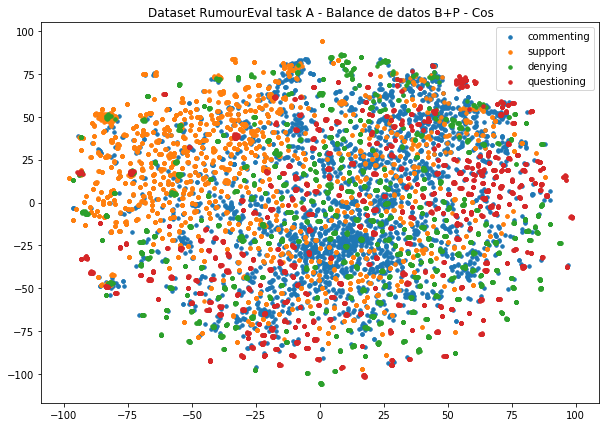

In [47]:
model = TSNE(2, metric='cosine')
to_plot_tsne = model.fit_transform(data_bas_bp)    
plt.figure(figsize=(10,7))
for key in keys:
    labels=[dict_cl[lab] for lab in macro_augmented[:,2]]
    mask = np.asarray(labels)==key
    plt.scatter(to_plot_tsne[:,0][mask],to_plot_tsne[:,1][mask], s=12, label=str(key))

plt.legend()
plt.title("Dataset RumourEval task A - Balance de datos B+P - Cos")
plt.show()

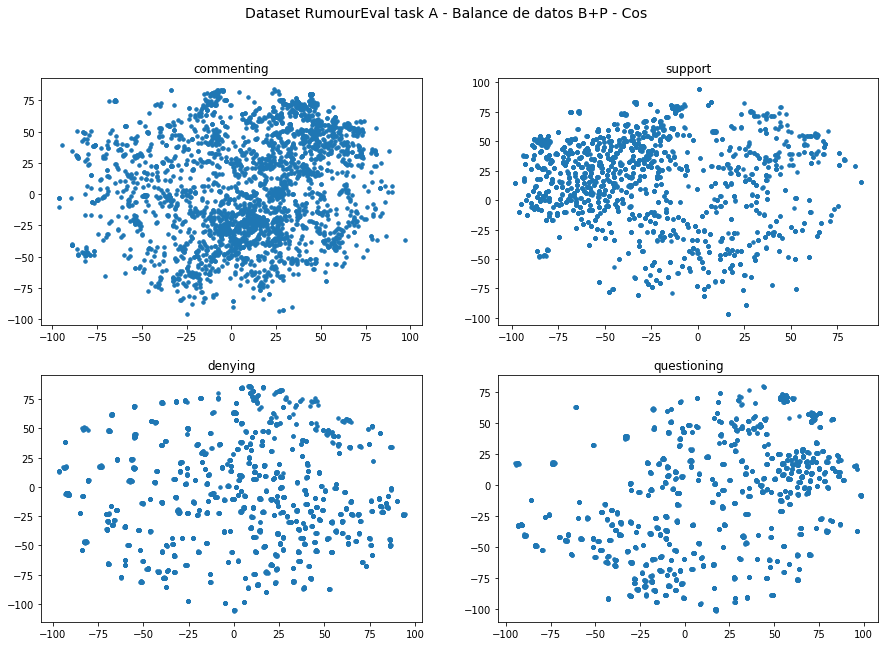

In [48]:
fig = plt.figure(figsize=(15,10))
j=220
for key in keys:
    labels=[dict_cl[lab] for lab in macro_augmented[:,2]]
    mask = np.asarray(labels)==key
    j+=1
    h=fig.add_subplot(j)
    plt.scatter(to_plot_tsne[:,0][mask],to_plot_tsne[:,1][mask], s=12, label=str(key))
    h.title.set_text(str(key))

fig.suptitle("Dataset RumourEval task A - Balance de datos B+P - Cos", fontsize=14)
plt.show()

In [49]:
np.random.shuffle(macro_augmented)
np.save('../Datasets/CSV_Stance/balance_bert_Pon.npy', macro_augmented)
    

In [55]:
macro_augmented.shape

(10936, 3)